In [1]:
import glob
import torch
import copy
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
%matplotlib inline

In [2]:
class LoadData:
    def __init__(self):
        # load data and do seperate train and test set
        X_list = glob.glob("./AEData_64/ac_density_*.npy")
        Y_list = glob.glob("./AEData_64/ev_density_*.npy")
        for idx in range(len(X_list)):
            if idx == 0:
                self.X = np.load(X_list[idx])[None, ...]
                self.Y = np.load(Y_list[idx])[None, ...]
            else:
                self.X = np.concatenate((self.X, np.load(X_list[idx])[None, ...]), axis=0)
                self.Y = np.concatenate((self.Y, np.load(Y_list[idx])[None, ...]), axis=0)
        #self.X, self.Y = self.X*100, self.Y*100

    def dataloader(self, bs, ratio):
        X_train, X_test, Y_train, Y_test = train_test_split(self.X, self.Y, test_size=ratio, shuffle=True)
        X_train, X_test = torch.Tensor(X_train), torch.Tensor(X_test)
        Y_train, Y_test = torch.Tensor(Y_train), torch.Tensor(Y_test)

        trainloader = DataLoader(TensorDataset(X_train, Y_train), batch_size=bs, shuffle=True, num_workers=0)
        testloader = DataLoader(TensorDataset(X_test, Y_test), batch_size=bs, shuffle=True, num_workers=0)
        return trainloader, testloader

In [3]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=3, kernel_size=5, stride=1, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(in_channels=3, out_channels=5, kernel_size=5, stride=1, padding=1),
            nn.MaxPool2d(2, 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(in_channels=5, out_channels=3, kernel_size=5, stride=1, padding=1),
            nn.MaxPool2d(2, 2),
            nn.LeakyReLU(0.2, inplace=True),
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=3, out_channels=5, kernel_size=5, stride=2, padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=5, out_channels=5, kernel_size=7, stride=2, padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=5, out_channels=3, kernel_size=5, stride=1, padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=3, out_channels=1, kernel_size=4, stride=1, padding=1),
            #nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [4]:
class AutoEncoder(nn.Module):
    def __init__(self, nf):
        super(AutoEncoder, self).__init__()

        self.encoder = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(1, nf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(nf, nf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(nf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(nf * 2, nf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(nf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(nf * 4, nf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(nf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(nf * 8, nf * 2, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

        self.decoder = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(nf * 2, nf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(nf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(nf * 8, nf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(nf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(nf * 4, nf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(nf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(nf * 2, nf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(nf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(nf, 1, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [5]:
batch_size = 1
test_ratio = 0.1

# load data
trainloader, testloader = LoadData().dataloader(batch_size, test_ratio)

In [6]:
nf = 8
net = AutoEncoder(nf)

if torch.cuda.is_available():
    GPU = 1
    print('Training on GPU')
    net = net.cuda()

Training on GPU


In [7]:
net

AutoEncoder(
  (encoder): Sequential(
    (0): Conv2d(1, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(8, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(64, 16, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
  (decoder): Sequential(
    (0): ConvTra

In [8]:
#init_weights = copy.deepcopy(net.decoder[2].weight.data)
init_weights = copy.deepcopy(net.decoder[3].weight.data)

In [9]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.00001, betas=(0.5, 0.999))
criterion = nn.MSELoss()

# Training

In [10]:
epochs = 50000

In [11]:
# training
trainloss = []
for epoch in range(epochs):
    training_loss = 0

    for X_train, Y_train in trainloader:
        X_train = X_train.view(-1, 1, X_train.shape[-2], X_train.shape[-1])
        Y_train = Y_train.view(-1, 1, Y_train.shape[-2], Y_train.shape[-1])

        if GPU:
            X_train, Y_train = Variable(X_train).cuda(), Variable(Y_train).cuda()

        optimizer.zero_grad()
        X_pred = net(X_train)
        loss = criterion(X_pred, Y_train)
        loss.backward()
        optimizer.step()
        training_loss += loss.item() / X_train.shape[0]
    print('Epoch: {}/{} \t Mean Square Error Loss: {}'.format(epoch + 1, epochs, training_loss))
    trainloss.append(training_loss)

Epoch: 1/50000 	 Mean Square Error Loss: 0.01576463133096695
Epoch: 2/50000 	 Mean Square Error Loss: 0.013944353163242336
Epoch: 3/50000 	 Mean Square Error Loss: 0.01244319851199786
Epoch: 4/50000 	 Mean Square Error Loss: 0.011214095385124289
Epoch: 5/50000 	 Mean Square Error Loss: 0.010192297740528981
Epoch: 6/50000 	 Mean Square Error Loss: 0.009345419891178607
Epoch: 7/50000 	 Mean Square Error Loss: 0.008649365231394765
Epoch: 8/50000 	 Mean Square Error Loss: 0.008060317113995552
Epoch: 9/50000 	 Mean Square Error Loss: 0.0075489046362539145
Epoch: 10/50000 	 Mean Square Error Loss: 0.007095826261987289
Epoch: 11/50000 	 Mean Square Error Loss: 0.006680933510263761
Epoch: 12/50000 	 Mean Square Error Loss: 0.006302122849350175
Epoch: 13/50000 	 Mean Square Error Loss: 0.005952263095726569
Epoch: 14/50000 	 Mean Square Error Loss: 0.0056269239168614165
Epoch: 15/50000 	 Mean Square Error Loss: 0.005327563003326457
Epoch: 16/50000 	 Mean Square Error Loss: 0.005050127813592553
E

Epoch: 130/50000 	 Mean Square Error Loss: 0.0002178729084941248
Epoch: 131/50000 	 Mean Square Error Loss: 0.00021270283711298058
Epoch: 132/50000 	 Mean Square Error Loss: 0.00020761865986666325
Epoch: 133/50000 	 Mean Square Error Loss: 0.00020271005293276778
Epoch: 134/50000 	 Mean Square Error Loss: 0.0001979499982553534
Epoch: 135/50000 	 Mean Square Error Loss: 0.00019329887970040243
Epoch: 136/50000 	 Mean Square Error Loss: 0.00018878956858922418
Epoch: 137/50000 	 Mean Square Error Loss: 0.0001844914314763931
Epoch: 138/50000 	 Mean Square Error Loss: 0.0001803819681905831
Epoch: 139/50000 	 Mean Square Error Loss: 0.00017639655949703106
Epoch: 140/50000 	 Mean Square Error Loss: 0.00017254790970279527
Epoch: 141/50000 	 Mean Square Error Loss: 0.0001688210899980428
Epoch: 142/50000 	 Mean Square Error Loss: 0.00016517299324429285
Epoch: 143/50000 	 Mean Square Error Loss: 0.00016160427039721984
Epoch: 144/50000 	 Mean Square Error Loss: 0.0001582068337787253
Epoch: 145/50000

Epoch: 256/50000 	 Mean Square Error Loss: 3.285755762287104e-05
Epoch: 257/50000 	 Mean Square Error Loss: 3.2548620462572834e-05
Epoch: 258/50000 	 Mean Square Error Loss: 3.225029916696561e-05
Epoch: 259/50000 	 Mean Square Error Loss: 3.196049001417123e-05
Epoch: 260/50000 	 Mean Square Error Loss: 3.1659451512193e-05
Epoch: 261/50000 	 Mean Square Error Loss: 3.136152129930755e-05
Epoch: 262/50000 	 Mean Square Error Loss: 3.1080847232563735e-05
Epoch: 263/50000 	 Mean Square Error Loss: 3.081491377088241e-05
Epoch: 264/50000 	 Mean Square Error Loss: 3.0536494038339386e-05
Epoch: 265/50000 	 Mean Square Error Loss: 3.026879264022379e-05
Epoch: 266/50000 	 Mean Square Error Loss: 3.000833179006198e-05
Epoch: 267/50000 	 Mean Square Error Loss: 2.9733542154038624e-05
Epoch: 268/50000 	 Mean Square Error Loss: 2.9469128639902924e-05
Epoch: 269/50000 	 Mean Square Error Loss: 2.9210406743610892e-05
Epoch: 270/50000 	 Mean Square Error Loss: 2.896242864759794e-05
Epoch: 271/50000 	 Me

Epoch: 381/50000 	 Mean Square Error Loss: 1.1986401113972536e-05
Epoch: 382/50000 	 Mean Square Error Loss: 1.1920678237705333e-05
Epoch: 383/50000 	 Mean Square Error Loss: 1.1860881325749991e-05
Epoch: 384/50000 	 Mean Square Error Loss: 1.1794946931331652e-05
Epoch: 385/50000 	 Mean Square Error Loss: 1.1712419988422574e-05
Epoch: 386/50000 	 Mean Square Error Loss: 1.1670943725524314e-05
Epoch: 387/50000 	 Mean Square Error Loss: 1.1599905610637506e-05
Epoch: 388/50000 	 Mean Square Error Loss: 1.1533083246225335e-05
Epoch: 389/50000 	 Mean Square Error Loss: 1.1482361060188854e-05
Epoch: 390/50000 	 Mean Square Error Loss: 1.1418652866268528e-05
Epoch: 391/50000 	 Mean Square Error Loss: 1.1367250438828097e-05
Epoch: 392/50000 	 Mean Square Error Loss: 1.130186413623354e-05
Epoch: 393/50000 	 Mean Square Error Loss: 1.1255757120428216e-05
Epoch: 394/50000 	 Mean Square Error Loss: 1.1202913750215279e-05
Epoch: 395/50000 	 Mean Square Error Loss: 1.1147191677688777e-05
Epoch: 396/

Epoch: 507/50000 	 Mean Square Error Loss: 7.675181283654336e-06
Epoch: 508/50000 	 Mean Square Error Loss: 7.654299891631429e-06
Epoch: 509/50000 	 Mean Square Error Loss: 7.663575706828853e-06
Epoch: 510/50000 	 Mean Square Error Loss: 7.630193097914647e-06
Epoch: 511/50000 	 Mean Square Error Loss: 7.62121214089954e-06
Epoch: 512/50000 	 Mean Square Error Loss: 7.597260931409738e-06
Epoch: 513/50000 	 Mean Square Error Loss: 7.605905921082013e-06
Epoch: 514/50000 	 Mean Square Error Loss: 7.567190580933433e-06
Epoch: 515/50000 	 Mean Square Error Loss: 7.558379760060536e-06
Epoch: 516/50000 	 Mean Square Error Loss: 7.554953056872668e-06
Epoch: 517/50000 	 Mean Square Error Loss: 7.537608629111976e-06
Epoch: 518/50000 	 Mean Square Error Loss: 7.532754383040204e-06
Epoch: 519/50000 	 Mean Square Error Loss: 7.512300483843621e-06
Epoch: 520/50000 	 Mean Square Error Loss: 7.496347037279822e-06
Epoch: 521/50000 	 Mean Square Error Loss: 7.485572314180898e-06
Epoch: 522/50000 	 Mean Sq

Epoch: 633/50000 	 Mean Square Error Loss: 6.5130796580585106e-06
Epoch: 634/50000 	 Mean Square Error Loss: 6.482708628633796e-06
Epoch: 635/50000 	 Mean Square Error Loss: 6.50917727398337e-06
Epoch: 636/50000 	 Mean Square Error Loss: 6.476871961543414e-06
Epoch: 637/50000 	 Mean Square Error Loss: 6.50321982599659e-06
Epoch: 638/50000 	 Mean Square Error Loss: 6.480917500084616e-06
Epoch: 639/50000 	 Mean Square Error Loss: 6.483840813113298e-06
Epoch: 640/50000 	 Mean Square Error Loss: 6.469198948858928e-06
Epoch: 641/50000 	 Mean Square Error Loss: 6.478276524527851e-06
Epoch: 642/50000 	 Mean Square Error Loss: 6.47368162087029e-06
Epoch: 643/50000 	 Mean Square Error Loss: 6.456890711585099e-06
Epoch: 644/50000 	 Mean Square Error Loss: 6.464660297448669e-06
Epoch: 645/50000 	 Mean Square Error Loss: 6.458419951134906e-06
Epoch: 646/50000 	 Mean Square Error Loss: 6.457631601127408e-06
Epoch: 647/50000 	 Mean Square Error Loss: 6.449238950760144e-06
Epoch: 648/50000 	 Mean Squ

Epoch: 759/50000 	 Mean Square Error Loss: 6.021269412788871e-06
Epoch: 760/50000 	 Mean Square Error Loss: 6.016782905741517e-06
Epoch: 761/50000 	 Mean Square Error Loss: 6.028779944244888e-06
Epoch: 762/50000 	 Mean Square Error Loss: 6.020691034791525e-06
Epoch: 763/50000 	 Mean Square Error Loss: 6.017170001844836e-06
Epoch: 764/50000 	 Mean Square Error Loss: 6.0215256326046076e-06
Epoch: 765/50000 	 Mean Square Error Loss: 6.0078772397294705e-06
Epoch: 766/50000 	 Mean Square Error Loss: 6.013670008542249e-06
Epoch: 767/50000 	 Mean Square Error Loss: 6.000270135094372e-06
Epoch: 768/50000 	 Mean Square Error Loss: 6.01283610800844e-06
Epoch: 769/50000 	 Mean Square Error Loss: 6.006120050490912e-06
Epoch: 770/50000 	 Mean Square Error Loss: 5.98366602086268e-06
Epoch: 771/50000 	 Mean Square Error Loss: 5.9886366974145245e-06
Epoch: 772/50000 	 Mean Square Error Loss: 5.985292682453292e-06
Epoch: 773/50000 	 Mean Square Error Loss: 5.980790759470741e-06
Epoch: 774/50000 	 Mean 

Epoch: 885/50000 	 Mean Square Error Loss: 5.731777870702596e-06
Epoch: 886/50000 	 Mean Square Error Loss: 5.757088608030851e-06
Epoch: 887/50000 	 Mean Square Error Loss: 5.742278623680855e-06
Epoch: 888/50000 	 Mean Square Error Loss: 5.744504005633643e-06
Epoch: 889/50000 	 Mean Square Error Loss: 5.749328253538504e-06
Epoch: 890/50000 	 Mean Square Error Loss: 5.735811009799363e-06
Epoch: 891/50000 	 Mean Square Error Loss: 5.736296149431534e-06
Epoch: 892/50000 	 Mean Square Error Loss: 5.733281780824959e-06
Epoch: 893/50000 	 Mean Square Error Loss: 5.752984679929796e-06
Epoch: 894/50000 	 Mean Square Error Loss: 5.734316315889979e-06
Epoch: 895/50000 	 Mean Square Error Loss: 5.730648581447892e-06
Epoch: 896/50000 	 Mean Square Error Loss: 5.719890820425158e-06
Epoch: 897/50000 	 Mean Square Error Loss: 5.725041485978484e-06
Epoch: 898/50000 	 Mean Square Error Loss: 5.720939452658058e-06
Epoch: 899/50000 	 Mean Square Error Loss: 5.719478243311945e-06
Epoch: 900/50000 	 Mean S

Epoch: 1011/50000 	 Mean Square Error Loss: 5.581783564897099e-06
Epoch: 1012/50000 	 Mean Square Error Loss: 5.581559253187151e-06
Epoch: 1013/50000 	 Mean Square Error Loss: 5.582492531175377e-06
Epoch: 1014/50000 	 Mean Square Error Loss: 5.5757895703815554e-06
Epoch: 1015/50000 	 Mean Square Error Loss: 5.570903598102935e-06
Epoch: 1016/50000 	 Mean Square Error Loss: 5.563045533563126e-06
Epoch: 1017/50000 	 Mean Square Error Loss: 5.572069843159018e-06
Epoch: 1018/50000 	 Mean Square Error Loss: 5.552650084913087e-06
Epoch: 1019/50000 	 Mean Square Error Loss: 5.5712284392939175e-06
Epoch: 1020/50000 	 Mean Square Error Loss: 5.564962475546054e-06
Epoch: 1021/50000 	 Mean Square Error Loss: 5.551331802659356e-06
Epoch: 1022/50000 	 Mean Square Error Loss: 5.557941813094657e-06
Epoch: 1023/50000 	 Mean Square Error Loss: 5.554695265648963e-06
Epoch: 1024/50000 	 Mean Square Error Loss: 5.56449945179338e-06
Epoch: 1025/50000 	 Mean Square Error Loss: 5.56207511787458e-06
Epoch: 102

Epoch: 1136/50000 	 Mean Square Error Loss: 5.4474116192674655e-06
Epoch: 1137/50000 	 Mean Square Error Loss: 5.456434807153226e-06
Epoch: 1138/50000 	 Mean Square Error Loss: 5.4657831242366225e-06
Epoch: 1139/50000 	 Mean Square Error Loss: 5.4520642909968355e-06
Epoch: 1140/50000 	 Mean Square Error Loss: 5.432708379278968e-06
Epoch: 1141/50000 	 Mean Square Error Loss: 5.439713883485335e-06
Epoch: 1142/50000 	 Mean Square Error Loss: 5.456243873898833e-06
Epoch: 1143/50000 	 Mean Square Error Loss: 5.461158283045127e-06
Epoch: 1144/50000 	 Mean Square Error Loss: 5.4560244128272945e-06
Epoch: 1145/50000 	 Mean Square Error Loss: 5.44601342274594e-06
Epoch: 1146/50000 	 Mean Square Error Loss: 5.449194850370986e-06
Epoch: 1147/50000 	 Mean Square Error Loss: 5.448473211799866e-06
Epoch: 1148/50000 	 Mean Square Error Loss: 5.438814378067036e-06
Epoch: 1149/50000 	 Mean Square Error Loss: 5.454419003096215e-06
Epoch: 1150/50000 	 Mean Square Error Loss: 5.438941191944953e-06
Epoch: 

Epoch: 1260/50000 	 Mean Square Error Loss: 5.370521694203489e-06
Epoch: 1261/50000 	 Mean Square Error Loss: 5.3681162777744845e-06
Epoch: 1262/50000 	 Mean Square Error Loss: 5.358865867795732e-06
Epoch: 1263/50000 	 Mean Square Error Loss: 5.362011309747081e-06
Epoch: 1264/50000 	 Mean Square Error Loss: 5.358134255099381e-06
Epoch: 1265/50000 	 Mean Square Error Loss: 5.362357236056899e-06
Epoch: 1266/50000 	 Mean Square Error Loss: 5.358214427057344e-06
Epoch: 1267/50000 	 Mean Square Error Loss: 5.3683515337373434e-06
Epoch: 1268/50000 	 Mean Square Error Loss: 5.376365652409733e-06
Epoch: 1269/50000 	 Mean Square Error Loss: 5.361705871109735e-06
Epoch: 1270/50000 	 Mean Square Error Loss: 5.3520848117235195e-06
Epoch: 1271/50000 	 Mean Square Error Loss: 5.371646587567131e-06
Epoch: 1272/50000 	 Mean Square Error Loss: 5.354445390063726e-06
Epoch: 1273/50000 	 Mean Square Error Loss: 5.366534636171613e-06
Epoch: 1274/50000 	 Mean Square Error Loss: 5.361677040127689e-06
Epoch: 

Epoch: 1385/50000 	 Mean Square Error Loss: 5.2970423136381825e-06
Epoch: 1386/50000 	 Mean Square Error Loss: 5.285546891779328e-06
Epoch: 1387/50000 	 Mean Square Error Loss: 5.30539811431178e-06
Epoch: 1388/50000 	 Mean Square Error Loss: 5.286415762384422e-06
Epoch: 1389/50000 	 Mean Square Error Loss: 5.284738684470843e-06
Epoch: 1390/50000 	 Mean Square Error Loss: 5.294465017868788e-06
Epoch: 1391/50000 	 Mean Square Error Loss: 5.295346894248118e-06
Epoch: 1392/50000 	 Mean Square Error Loss: 5.3068876241013635e-06
Epoch: 1393/50000 	 Mean Square Error Loss: 5.2875372451429335e-06
Epoch: 1394/50000 	 Mean Square Error Loss: 5.28447517353925e-06
Epoch: 1395/50000 	 Mean Square Error Loss: 5.297942319278567e-06
Epoch: 1396/50000 	 Mean Square Error Loss: 5.287678959575715e-06
Epoch: 1397/50000 	 Mean Square Error Loss: 5.301708279148442e-06
Epoch: 1398/50000 	 Mean Square Error Loss: 5.2969533195816135e-06
Epoch: 1399/50000 	 Mean Square Error Loss: 5.279909055388999e-06
Epoch: 1

Epoch: 1509/50000 	 Mean Square Error Loss: 5.234498939898913e-06
Epoch: 1510/50000 	 Mean Square Error Loss: 5.2326998077963555e-06
Epoch: 1511/50000 	 Mean Square Error Loss: 5.245744083974083e-06
Epoch: 1512/50000 	 Mean Square Error Loss: 5.244358302055237e-06
Epoch: 1513/50000 	 Mean Square Error Loss: 5.227763692043179e-06
Epoch: 1514/50000 	 Mean Square Error Loss: 5.218234006558001e-06
Epoch: 1515/50000 	 Mean Square Error Loss: 5.238213270786218e-06
Epoch: 1516/50000 	 Mean Square Error Loss: 5.214425937083433e-06
Epoch: 1517/50000 	 Mean Square Error Loss: 5.221587556055359e-06
Epoch: 1518/50000 	 Mean Square Error Loss: 5.241229321957992e-06
Epoch: 1519/50000 	 Mean Square Error Loss: 5.253309852074988e-06
Epoch: 1520/50000 	 Mean Square Error Loss: 5.230416718404739e-06
Epoch: 1521/50000 	 Mean Square Error Loss: 5.241361350272198e-06
Epoch: 1522/50000 	 Mean Square Error Loss: 5.2138129376544394e-06
Epoch: 1523/50000 	 Mean Square Error Loss: 5.242510709043322e-06
Epoch: 1

Epoch: 1634/50000 	 Mean Square Error Loss: 5.16351500057984e-06
Epoch: 1635/50000 	 Mean Square Error Loss: 5.188282663463423e-06
Epoch: 1636/50000 	 Mean Square Error Loss: 5.175673929140126e-06
Epoch: 1637/50000 	 Mean Square Error Loss: 5.18793832876933e-06
Epoch: 1638/50000 	 Mean Square Error Loss: 5.1742731557169455e-06
Epoch: 1639/50000 	 Mean Square Error Loss: 5.187740771361859e-06
Epoch: 1640/50000 	 Mean Square Error Loss: 5.176767278195863e-06
Epoch: 1641/50000 	 Mean Square Error Loss: 5.185977458192307e-06
Epoch: 1642/50000 	 Mean Square Error Loss: 5.181162957039002e-06
Epoch: 1643/50000 	 Mean Square Error Loss: 5.188593468119507e-06
Epoch: 1644/50000 	 Mean Square Error Loss: 5.1814275896807274e-06
Epoch: 1645/50000 	 Mean Square Error Loss: 5.1996262754983026e-06
Epoch: 1646/50000 	 Mean Square Error Loss: 5.1863106212598105e-06
Epoch: 1647/50000 	 Mean Square Error Loss: 5.1907937480185256e-06
Epoch: 1648/50000 	 Mean Square Error Loss: 5.180034031582182e-06
Epoch: 

Epoch: 1759/50000 	 Mean Square Error Loss: 5.155098066704037e-06
Epoch: 1760/50000 	 Mean Square Error Loss: 5.124834948825688e-06
Epoch: 1761/50000 	 Mean Square Error Loss: 5.142239600293881e-06
Epoch: 1762/50000 	 Mean Square Error Loss: 5.1351020071403275e-06
Epoch: 1763/50000 	 Mean Square Error Loss: 5.1362960524177955e-06
Epoch: 1764/50000 	 Mean Square Error Loss: 5.141444974772942e-06
Epoch: 1765/50000 	 Mean Square Error Loss: 5.1349675686651615e-06
Epoch: 1766/50000 	 Mean Square Error Loss: 5.13847097257288e-06
Epoch: 1767/50000 	 Mean Square Error Loss: 5.142596758863269e-06
Epoch: 1768/50000 	 Mean Square Error Loss: 5.125908137415535e-06
Epoch: 1769/50000 	 Mean Square Error Loss: 5.152236947954709e-06
Epoch: 1770/50000 	 Mean Square Error Loss: 5.1434884881018664e-06
Epoch: 1771/50000 	 Mean Square Error Loss: 5.140604207554132e-06
Epoch: 1772/50000 	 Mean Square Error Loss: 5.1428758373125076e-06
Epoch: 1773/50000 	 Mean Square Error Loss: 5.128117178780181e-06
Epoch:

Epoch: 1884/50000 	 Mean Square Error Loss: 5.102284255068903e-06
Epoch: 1885/50000 	 Mean Square Error Loss: 5.10557556481217e-06
Epoch: 1886/50000 	 Mean Square Error Loss: 5.1033291735317704e-06
Epoch: 1887/50000 	 Mean Square Error Loss: 5.108516143081941e-06
Epoch: 1888/50000 	 Mean Square Error Loss: 5.1057348628091855e-06
Epoch: 1889/50000 	 Mean Square Error Loss: 5.109694681474744e-06
Epoch: 1890/50000 	 Mean Square Error Loss: 5.101460934990123e-06
Epoch: 1891/50000 	 Mean Square Error Loss: 5.106709689547036e-06
Epoch: 1892/50000 	 Mean Square Error Loss: 5.10240030659285e-06
Epoch: 1893/50000 	 Mean Square Error Loss: 5.109779522172175e-06
Epoch: 1894/50000 	 Mean Square Error Loss: 5.094577181807835e-06
Epoch: 1895/50000 	 Mean Square Error Loss: 5.0973990710190254e-06
Epoch: 1896/50000 	 Mean Square Error Loss: 5.094072321298882e-06
Epoch: 1897/50000 	 Mean Square Error Loss: 5.098308959835169e-06
Epoch: 1898/50000 	 Mean Square Error Loss: 5.097120098677502e-06
Epoch: 18

Epoch: 2008/50000 	 Mean Square Error Loss: 5.066552163649854e-06
Epoch: 2009/50000 	 Mean Square Error Loss: 5.082892099987172e-06
Epoch: 2010/50000 	 Mean Square Error Loss: 5.079739958091524e-06
Epoch: 2011/50000 	 Mean Square Error Loss: 5.084094815780796e-06
Epoch: 2012/50000 	 Mean Square Error Loss: 5.059977987305805e-06
Epoch: 2013/50000 	 Mean Square Error Loss: 5.071601875291284e-06
Epoch: 2014/50000 	 Mean Square Error Loss: 5.067658184998436e-06
Epoch: 2015/50000 	 Mean Square Error Loss: 5.070074121249491e-06
Epoch: 2016/50000 	 Mean Square Error Loss: 5.079042315022282e-06
Epoch: 2017/50000 	 Mean Square Error Loss: 5.043782069454514e-06
Epoch: 2018/50000 	 Mean Square Error Loss: 5.0642833836415465e-06
Epoch: 2019/50000 	 Mean Square Error Loss: 5.067125509109853e-06
Epoch: 2020/50000 	 Mean Square Error Loss: 5.073352000787659e-06
Epoch: 2021/50000 	 Mean Square Error Loss: 5.075673652754632e-06
Epoch: 2022/50000 	 Mean Square Error Loss: 5.0740896919402695e-06
Epoch: 2

Epoch: 2132/50000 	 Mean Square Error Loss: 5.040481255491613e-06
Epoch: 2133/50000 	 Mean Square Error Loss: 5.046031492383919e-06
Epoch: 2134/50000 	 Mean Square Error Loss: 5.042194682876772e-06
Epoch: 2135/50000 	 Mean Square Error Loss: 5.040369721124687e-06
Epoch: 2136/50000 	 Mean Square Error Loss: 5.0322279093961685e-06
Epoch: 2137/50000 	 Mean Square Error Loss: 5.045181554426867e-06
Epoch: 2138/50000 	 Mean Square Error Loss: 5.046681402139561e-06
Epoch: 2139/50000 	 Mean Square Error Loss: 5.031304150785824e-06
Epoch: 2140/50000 	 Mean Square Error Loss: 5.045758098276566e-06
Epoch: 2141/50000 	 Mean Square Error Loss: 5.0383258136813915e-06
Epoch: 2142/50000 	 Mean Square Error Loss: 5.036449344212694e-06
Epoch: 2143/50000 	 Mean Square Error Loss: 5.046934711572248e-06
Epoch: 2144/50000 	 Mean Square Error Loss: 5.040026917413342e-06
Epoch: 2145/50000 	 Mean Square Error Loss: 5.039623450405391e-06
Epoch: 2146/50000 	 Mean Square Error Loss: 5.049340385691419e-06
Epoch: 2

Epoch: 2256/50000 	 Mean Square Error Loss: 5.0179209968822155e-06
Epoch: 2257/50000 	 Mean Square Error Loss: 5.008018388252822e-06
Epoch: 2258/50000 	 Mean Square Error Loss: 5.024727564280814e-06
Epoch: 2259/50000 	 Mean Square Error Loss: 5.018808087697834e-06
Epoch: 2260/50000 	 Mean Square Error Loss: 5.002868329029297e-06
Epoch: 2261/50000 	 Mean Square Error Loss: 5.021114596578021e-06
Epoch: 2262/50000 	 Mean Square Error Loss: 5.020805201638723e-06
Epoch: 2263/50000 	 Mean Square Error Loss: 5.009531711645347e-06
Epoch: 2264/50000 	 Mean Square Error Loss: 5.012911803229752e-06
Epoch: 2265/50000 	 Mean Square Error Loss: 5.003509189312656e-06
Epoch: 2266/50000 	 Mean Square Error Loss: 4.992783639560609e-06
Epoch: 2267/50000 	 Mean Square Error Loss: 5.01047776803413e-06
Epoch: 2268/50000 	 Mean Square Error Loss: 5.011044322600355e-06
Epoch: 2269/50000 	 Mean Square Error Loss: 5.001154916802383e-06
Epoch: 2270/50000 	 Mean Square Error Loss: 5.0153105955056775e-06
Epoch: 22

Epoch: 2381/50000 	 Mean Square Error Loss: 4.991096087299714e-06
Epoch: 2382/50000 	 Mean Square Error Loss: 4.9922375334669285e-06
Epoch: 2383/50000 	 Mean Square Error Loss: 4.989562315434644e-06
Epoch: 2384/50000 	 Mean Square Error Loss: 4.995330891688355e-06
Epoch: 2385/50000 	 Mean Square Error Loss: 4.994913054664116e-06
Epoch: 2386/50000 	 Mean Square Error Loss: 4.992007173617216e-06
Epoch: 2387/50000 	 Mean Square Error Loss: 5.001414744280434e-06
Epoch: 2388/50000 	 Mean Square Error Loss: 4.978003122838951e-06
Epoch: 2389/50000 	 Mean Square Error Loss: 4.97639653076476e-06
Epoch: 2390/50000 	 Mean Square Error Loss: 4.995407546933469e-06
Epoch: 2391/50000 	 Mean Square Error Loss: 4.98992987256012e-06
Epoch: 2392/50000 	 Mean Square Error Loss: 4.987400067572404e-06
Epoch: 2393/50000 	 Mean Square Error Loss: 5.001236801642033e-06
Epoch: 2394/50000 	 Mean Square Error Loss: 4.986763300015203e-06
Epoch: 2395/50000 	 Mean Square Error Loss: 4.984277605520523e-06
Epoch: 2396

Epoch: 2505/50000 	 Mean Square Error Loss: 4.9626988432767884e-06
Epoch: 2506/50000 	 Mean Square Error Loss: 4.968720062000405e-06
Epoch: 2507/50000 	 Mean Square Error Loss: 4.953605715248461e-06
Epoch: 2508/50000 	 Mean Square Error Loss: 4.95427667980645e-06
Epoch: 2509/50000 	 Mean Square Error Loss: 4.965756655413618e-06
Epoch: 2510/50000 	 Mean Square Error Loss: 4.964098555622816e-06
Epoch: 2511/50000 	 Mean Square Error Loss: 4.965663022934072e-06
Epoch: 2512/50000 	 Mean Square Error Loss: 4.973488648829516e-06
Epoch: 2513/50000 	 Mean Square Error Loss: 4.967324988077356e-06
Epoch: 2514/50000 	 Mean Square Error Loss: 4.968561885713522e-06
Epoch: 2515/50000 	 Mean Square Error Loss: 4.953953930453283e-06
Epoch: 2516/50000 	 Mean Square Error Loss: 4.9602581536116e-06
Epoch: 2517/50000 	 Mean Square Error Loss: 4.966450933352462e-06
Epoch: 2518/50000 	 Mean Square Error Loss: 4.963325515442798e-06
Epoch: 2519/50000 	 Mean Square Error Loss: 4.974763578502462e-06
Epoch: 2520/

Epoch: 2630/50000 	 Mean Square Error Loss: 4.951174317587478e-06
Epoch: 2631/50000 	 Mean Square Error Loss: 4.947365535675392e-06
Epoch: 2632/50000 	 Mean Square Error Loss: 4.958127510690246e-06
Epoch: 2633/50000 	 Mean Square Error Loss: 4.955671981103176e-06
Epoch: 2634/50000 	 Mean Square Error Loss: 4.935351701836528e-06
Epoch: 2635/50000 	 Mean Square Error Loss: 4.961397219934345e-06
Epoch: 2636/50000 	 Mean Square Error Loss: 4.953995024455557e-06
Epoch: 2637/50000 	 Mean Square Error Loss: 4.954519636157785e-06
Epoch: 2638/50000 	 Mean Square Error Loss: 4.938033149907521e-06
Epoch: 2639/50000 	 Mean Square Error Loss: 4.939540895065876e-06
Epoch: 2640/50000 	 Mean Square Error Loss: 4.953531333740103e-06
Epoch: 2641/50000 	 Mean Square Error Loss: 4.943513158650602e-06
Epoch: 2642/50000 	 Mean Square Error Loss: 4.948974871391934e-06
Epoch: 2643/50000 	 Mean Square Error Loss: 4.933413674734766e-06
Epoch: 2644/50000 	 Mean Square Error Loss: 4.935198618719975e-06
Epoch: 264

Epoch: 2754/50000 	 Mean Square Error Loss: 4.928407846212697e-06
Epoch: 2755/50000 	 Mean Square Error Loss: 4.930744747374168e-06
Epoch: 2756/50000 	 Mean Square Error Loss: 4.921708659821889e-06
Epoch: 2757/50000 	 Mean Square Error Loss: 4.934552710741021e-06
Epoch: 2758/50000 	 Mean Square Error Loss: 4.9270431190961965e-06
Epoch: 2759/50000 	 Mean Square Error Loss: 4.927831529736672e-06
Epoch: 2760/50000 	 Mean Square Error Loss: 4.924248378301854e-06
Epoch: 2761/50000 	 Mean Square Error Loss: 4.931523881168687e-06
Epoch: 2762/50000 	 Mean Square Error Loss: 4.9243204860734585e-06
Epoch: 2763/50000 	 Mean Square Error Loss: 4.930193017571583e-06
Epoch: 2764/50000 	 Mean Square Error Loss: 4.918756167171523e-06
Epoch: 2765/50000 	 Mean Square Error Loss: 4.9270565796177834e-06
Epoch: 2766/50000 	 Mean Square Error Loss: 4.9240333434378645e-06
Epoch: 2767/50000 	 Mean Square Error Loss: 4.918235587562473e-06
Epoch: 2768/50000 	 Mean Square Error Loss: 4.925056509819115e-06
Epoch:

Epoch: 2878/50000 	 Mean Square Error Loss: 4.917580281471601e-06
Epoch: 2879/50000 	 Mean Square Error Loss: 4.920112299563092e-06
Epoch: 2880/50000 	 Mean Square Error Loss: 4.91087295510321e-06
Epoch: 2881/50000 	 Mean Square Error Loss: 4.912815059772887e-06
Epoch: 2882/50000 	 Mean Square Error Loss: 4.9230283214759155e-06
Epoch: 2883/50000 	 Mean Square Error Loss: 4.915511666088907e-06
Epoch: 2884/50000 	 Mean Square Error Loss: 4.889994549254577e-06
Epoch: 2885/50000 	 Mean Square Error Loss: 4.922747090555883e-06
Epoch: 2886/50000 	 Mean Square Error Loss: 4.911863834422548e-06
Epoch: 2887/50000 	 Mean Square Error Loss: 4.912541908197454e-06
Epoch: 2888/50000 	 Mean Square Error Loss: 4.913027896691347e-06
Epoch: 2889/50000 	 Mean Square Error Loss: 4.910426575103579e-06
Epoch: 2890/50000 	 Mean Square Error Loss: 4.904993935876216e-06
Epoch: 2891/50000 	 Mean Square Error Loss: 4.897690420572568e-06
Epoch: 2892/50000 	 Mean Square Error Loss: 4.91231133613231e-06
Epoch: 2893

Epoch: 3003/50000 	 Mean Square Error Loss: 4.901137011377919e-06
Epoch: 3004/50000 	 Mean Square Error Loss: 4.907925131192316e-06
Epoch: 3005/50000 	 Mean Square Error Loss: 4.896689006272937e-06
Epoch: 3006/50000 	 Mean Square Error Loss: 4.900703318829378e-06
Epoch: 3007/50000 	 Mean Square Error Loss: 4.8891616340066925e-06
Epoch: 3008/50000 	 Mean Square Error Loss: 4.895450774711207e-06
Epoch: 3009/50000 	 Mean Square Error Loss: 4.900690358529876e-06
Epoch: 3010/50000 	 Mean Square Error Loss: 4.893269730625132e-06
Epoch: 3011/50000 	 Mean Square Error Loss: 4.893032913363034e-06
Epoch: 3012/50000 	 Mean Square Error Loss: 4.890705546737687e-06
Epoch: 3013/50000 	 Mean Square Error Loss: 4.888171800606263e-06
Epoch: 3014/50000 	 Mean Square Error Loss: 4.896069488798578e-06
Epoch: 3015/50000 	 Mean Square Error Loss: 4.8983118631440444e-06
Epoch: 3016/50000 	 Mean Square Error Loss: 4.896147387019786e-06
Epoch: 3017/50000 	 Mean Square Error Loss: 4.884653814466825e-06
Epoch: 3

Epoch: 3127/50000 	 Mean Square Error Loss: 4.872409999734373e-06
Epoch: 3128/50000 	 Mean Square Error Loss: 4.881890511872673e-06
Epoch: 3129/50000 	 Mean Square Error Loss: 4.88213248293808e-06
Epoch: 3130/50000 	 Mean Square Error Loss: 4.885765595948517e-06
Epoch: 3131/50000 	 Mean Square Error Loss: 4.8778599951522975e-06
Epoch: 3132/50000 	 Mean Square Error Loss: 4.864999633961512e-06
Epoch: 3133/50000 	 Mean Square Error Loss: 4.878251926735781e-06
Epoch: 3134/50000 	 Mean Square Error Loss: 4.861284757377385e-06
Epoch: 3135/50000 	 Mean Square Error Loss: 4.882661672430307e-06
Epoch: 3136/50000 	 Mean Square Error Loss: 4.882125661727817e-06
Epoch: 3137/50000 	 Mean Square Error Loss: 4.881700397163514e-06
Epoch: 3138/50000 	 Mean Square Error Loss: 4.88284254061e-06
Epoch: 3139/50000 	 Mean Square Error Loss: 4.8842487558431465e-06
Epoch: 3140/50000 	 Mean Square Error Loss: 4.883216949262228e-06
Epoch: 3141/50000 	 Mean Square Error Loss: 4.860662663001372e-06
Epoch: 3142/5

Epoch: 3252/50000 	 Mean Square Error Loss: 4.8575683649687566e-06
Epoch: 3253/50000 	 Mean Square Error Loss: 4.856580017076341e-06
Epoch: 3254/50000 	 Mean Square Error Loss: 4.873867859108335e-06
Epoch: 3255/50000 	 Mean Square Error Loss: 4.852221400142298e-06
Epoch: 3256/50000 	 Mean Square Error Loss: 4.863739286520286e-06
Epoch: 3257/50000 	 Mean Square Error Loss: 4.86248774601942e-06
Epoch: 3258/50000 	 Mean Square Error Loss: 4.867869271644547e-06
Epoch: 3259/50000 	 Mean Square Error Loss: 4.869556081151435e-06
Epoch: 3260/50000 	 Mean Square Error Loss: 4.860017270402751e-06
Epoch: 3261/50000 	 Mean Square Error Loss: 4.869785652772407e-06
Epoch: 3262/50000 	 Mean Square Error Loss: 4.865816572419135e-06
Epoch: 3263/50000 	 Mean Square Error Loss: 4.862293917540227e-06
Epoch: 3264/50000 	 Mean Square Error Loss: 4.874944882734174e-06
Epoch: 3265/50000 	 Mean Square Error Loss: 4.86125674494057e-06
Epoch: 3266/50000 	 Mean Square Error Loss: 4.84425312000288e-06
Epoch: 3267/

Epoch: 3377/50000 	 Mean Square Error Loss: 4.855986617258168e-06
Epoch: 3378/50000 	 Mean Square Error Loss: 4.8587760223502596e-06
Epoch: 3379/50000 	 Mean Square Error Loss: 4.8542642465084395e-06
Epoch: 3380/50000 	 Mean Square Error Loss: 4.859687760472298e-06
Epoch: 3381/50000 	 Mean Square Error Loss: 4.851178846365656e-06
Epoch: 3382/50000 	 Mean Square Error Loss: 4.849362630920951e-06
Epoch: 3383/50000 	 Mean Square Error Loss: 4.8442458288870205e-06
Epoch: 3384/50000 	 Mean Square Error Loss: 4.852421701192118e-06
Epoch: 3385/50000 	 Mean Square Error Loss: 4.8534918884494505e-06
Epoch: 3386/50000 	 Mean Square Error Loss: 4.848028068712059e-06
Epoch: 3387/50000 	 Mean Square Error Loss: 4.859086160043565e-06
Epoch: 3388/50000 	 Mean Square Error Loss: 4.8487791597532736e-06
Epoch: 3389/50000 	 Mean Square Error Loss: 4.849351125812973e-06
Epoch: 3390/50000 	 Mean Square Error Loss: 4.850772468974658e-06
Epoch: 3391/50000 	 Mean Square Error Loss: 4.840490191782011e-06
Epoch

Epoch: 3501/50000 	 Mean Square Error Loss: 4.83025564790296e-06
Epoch: 3502/50000 	 Mean Square Error Loss: 4.840727039360596e-06
Epoch: 3503/50000 	 Mean Square Error Loss: 4.825884813423423e-06
Epoch: 3504/50000 	 Mean Square Error Loss: 4.830600134179501e-06
Epoch: 3505/50000 	 Mean Square Error Loss: 4.847186664846959e-06
Epoch: 3506/50000 	 Mean Square Error Loss: 4.839099650174225e-06
Epoch: 3507/50000 	 Mean Square Error Loss: 4.829002743160042e-06
Epoch: 3508/50000 	 Mean Square Error Loss: 4.836702540463496e-06
Epoch: 3509/50000 	 Mean Square Error Loss: 4.838469582561326e-06
Epoch: 3510/50000 	 Mean Square Error Loss: 4.825597928477994e-06
Epoch: 3511/50000 	 Mean Square Error Loss: 4.818540386016441e-06
Epoch: 3512/50000 	 Mean Square Error Loss: 4.840246629100875e-06
Epoch: 3513/50000 	 Mean Square Error Loss: 4.833308048546315e-06
Epoch: 3514/50000 	 Mean Square Error Loss: 4.837670121560222e-06
Epoch: 3515/50000 	 Mean Square Error Loss: 4.811102417079383e-06
Epoch: 3516

Epoch: 3625/50000 	 Mean Square Error Loss: 4.820475669475855e-06
Epoch: 3626/50000 	 Mean Square Error Loss: 4.830864736504736e-06
Epoch: 3627/50000 	 Mean Square Error Loss: 4.814626830314713e-06
Epoch: 3628/50000 	 Mean Square Error Loss: 4.816042868090638e-06
Epoch: 3629/50000 	 Mean Square Error Loss: 4.821596303372645e-06
Epoch: 3630/50000 	 Mean Square Error Loss: 4.816331405284777e-06
Epoch: 3631/50000 	 Mean Square Error Loss: 4.82087878784417e-06
Epoch: 3632/50000 	 Mean Square Error Loss: 4.8256538472439084e-06
Epoch: 3633/50000 	 Mean Square Error Loss: 4.823551307708842e-06
Epoch: 3634/50000 	 Mean Square Error Loss: 4.817669393257043e-06
Epoch: 3635/50000 	 Mean Square Error Loss: 4.824832664477679e-06
Epoch: 3636/50000 	 Mean Square Error Loss: 4.819560839071831e-06
Epoch: 3637/50000 	 Mean Square Error Loss: 4.810202335647773e-06
Epoch: 3638/50000 	 Mean Square Error Loss: 4.809284867709114e-06
Epoch: 3639/50000 	 Mean Square Error Loss: 4.8052563670353265e-06
Epoch: 36

Epoch: 3750/50000 	 Mean Square Error Loss: 4.793248535861494e-06
Epoch: 3751/50000 	 Mean Square Error Loss: 4.809072061107145e-06
Epoch: 3752/50000 	 Mean Square Error Loss: 4.803967734308873e-06
Epoch: 3753/50000 	 Mean Square Error Loss: 4.79394426899186e-06
Epoch: 3754/50000 	 Mean Square Error Loss: 4.80699391118833e-06
Epoch: 3755/50000 	 Mean Square Error Loss: 4.796042609693056e-06
Epoch: 3756/50000 	 Mean Square Error Loss: 4.8082123309238025e-06
Epoch: 3757/50000 	 Mean Square Error Loss: 4.809618136884335e-06
Epoch: 3758/50000 	 Mean Square Error Loss: 4.8070279111319305e-06
Epoch: 3759/50000 	 Mean Square Error Loss: 4.8047356510020724e-06
Epoch: 3760/50000 	 Mean Square Error Loss: 4.806307833860047e-06
Epoch: 3761/50000 	 Mean Square Error Loss: 4.804066960180838e-06
Epoch: 3762/50000 	 Mean Square Error Loss: 4.790015903684738e-06
Epoch: 3763/50000 	 Mean Square Error Loss: 4.8024100275749025e-06
Epoch: 3764/50000 	 Mean Square Error Loss: 4.8078601139422985e-06
Epoch: 

Epoch: 3874/50000 	 Mean Square Error Loss: 4.790685534317164e-06
Epoch: 3875/50000 	 Mean Square Error Loss: 4.799064587738638e-06
Epoch: 3876/50000 	 Mean Square Error Loss: 4.783696961870494e-06
Epoch: 3877/50000 	 Mean Square Error Loss: 4.804191530638492e-06
Epoch: 3878/50000 	 Mean Square Error Loss: 4.795378830143212e-06
Epoch: 3879/50000 	 Mean Square Error Loss: 4.787750882921196e-06
Epoch: 3880/50000 	 Mean Square Error Loss: 4.786430281455979e-06
Epoch: 3881/50000 	 Mean Square Error Loss: 4.796956409336416e-06
Epoch: 3882/50000 	 Mean Square Error Loss: 4.7647732723514e-06
Epoch: 3883/50000 	 Mean Square Error Loss: 4.796616591799344e-06
Epoch: 3884/50000 	 Mean Square Error Loss: 4.7856867392207885e-06
Epoch: 3885/50000 	 Mean Square Error Loss: 4.790086313732901e-06
Epoch: 3886/50000 	 Mean Square Error Loss: 4.79784281803101e-06
Epoch: 3887/50000 	 Mean Square Error Loss: 4.767356555627582e-06
Epoch: 3888/50000 	 Mean Square Error Loss: 4.786798172062846e-06
Epoch: 3889/

Epoch: 3999/50000 	 Mean Square Error Loss: 4.780752624355955e-06
Epoch: 4000/50000 	 Mean Square Error Loss: 4.772725681808273e-06
Epoch: 4001/50000 	 Mean Square Error Loss: 4.776096830028108e-06
Epoch: 4002/50000 	 Mean Square Error Loss: 4.771129245758251e-06
Epoch: 4003/50000 	 Mean Square Error Loss: 4.785156867607535e-06
Epoch: 4004/50000 	 Mean Square Error Loss: 4.786023767640775e-06
Epoch: 4005/50000 	 Mean Square Error Loss: 4.775026930777433e-06
Epoch: 4006/50000 	 Mean Square Error Loss: 4.78040824418713e-06
Epoch: 4007/50000 	 Mean Square Error Loss: 4.7530693639904104e-06
Epoch: 4008/50000 	 Mean Square Error Loss: 4.775246558589666e-06
Epoch: 4009/50000 	 Mean Square Error Loss: 4.773719198662245e-06
Epoch: 4010/50000 	 Mean Square Error Loss: 4.779831836761635e-06
Epoch: 4011/50000 	 Mean Square Error Loss: 4.7814629245597935e-06
Epoch: 4012/50000 	 Mean Square Error Loss: 4.783067151947762e-06
Epoch: 4013/50000 	 Mean Square Error Loss: 4.777260786189194e-06
Epoch: 40

Epoch: 4124/50000 	 Mean Square Error Loss: 4.771506049413194e-06
Epoch: 4125/50000 	 Mean Square Error Loss: 4.759659229118067e-06
Epoch: 4126/50000 	 Mean Square Error Loss: 4.772729486527774e-06
Epoch: 4127/50000 	 Mean Square Error Loss: 4.7661657693727945e-06
Epoch: 4128/50000 	 Mean Square Error Loss: 4.76733789582795e-06
Epoch: 4129/50000 	 Mean Square Error Loss: 4.767740165334545e-06
Epoch: 4130/50000 	 Mean Square Error Loss: 4.770300559660732e-06
Epoch: 4131/50000 	 Mean Square Error Loss: 4.759292657278518e-06
Epoch: 4132/50000 	 Mean Square Error Loss: 4.74984220394011e-06
Epoch: 4133/50000 	 Mean Square Error Loss: 4.744225558776331e-06
Epoch: 4134/50000 	 Mean Square Error Loss: 4.761345977991976e-06
Epoch: 4135/50000 	 Mean Square Error Loss: 4.768616766644603e-06
Epoch: 4136/50000 	 Mean Square Error Loss: 4.764721234096215e-06
Epoch: 4137/50000 	 Mean Square Error Loss: 4.726309301380146e-06
Epoch: 4138/50000 	 Mean Square Error Loss: 4.7720888839345815e-06
Epoch: 413

Epoch: 4249/50000 	 Mean Square Error Loss: 4.739058052412777e-06
Epoch: 4250/50000 	 Mean Square Error Loss: 4.7507264298474185e-06
Epoch: 4251/50000 	 Mean Square Error Loss: 4.752031448636748e-06
Epoch: 4252/50000 	 Mean Square Error Loss: 4.747263862251809e-06
Epoch: 4253/50000 	 Mean Square Error Loss: 4.744649474256827e-06
Epoch: 4254/50000 	 Mean Square Error Loss: 4.749059189634862e-06
Epoch: 4255/50000 	 Mean Square Error Loss: 4.744425935617377e-06
Epoch: 4256/50000 	 Mean Square Error Loss: 4.757324541060371e-06
Epoch: 4257/50000 	 Mean Square Error Loss: 4.753028512520054e-06
Epoch: 4258/50000 	 Mean Square Error Loss: 4.73674840577587e-06
Epoch: 4259/50000 	 Mean Square Error Loss: 4.757485915736955e-06
Epoch: 4260/50000 	 Mean Square Error Loss: 4.747896446133382e-06
Epoch: 4261/50000 	 Mean Square Error Loss: 4.751073023120018e-06
Epoch: 4262/50000 	 Mean Square Error Loss: 4.750867856273544e-06
Epoch: 4263/50000 	 Mean Square Error Loss: 4.754394800935794e-06
Epoch: 426

Epoch: 4374/50000 	 Mean Square Error Loss: 4.735367777660333e-06
Epoch: 4375/50000 	 Mean Square Error Loss: 4.735584479931276e-06
Epoch: 4376/50000 	 Mean Square Error Loss: 4.73394966320484e-06
Epoch: 4377/50000 	 Mean Square Error Loss: 4.729400522289021e-06
Epoch: 4378/50000 	 Mean Square Error Loss: 4.7360346949669e-06
Epoch: 4379/50000 	 Mean Square Error Loss: 4.740168848608543e-06
Epoch: 4380/50000 	 Mean Square Error Loss: 4.732463018323566e-06
Epoch: 4381/50000 	 Mean Square Error Loss: 4.735935529727915e-06
Epoch: 4382/50000 	 Mean Square Error Loss: 4.731519523678192e-06
Epoch: 4383/50000 	 Mean Square Error Loss: 4.7338481029631405e-06
Epoch: 4384/50000 	 Mean Square Error Loss: 4.73643234120876e-06
Epoch: 4385/50000 	 Mean Square Error Loss: 4.740954348865975e-06
Epoch: 4386/50000 	 Mean Square Error Loss: 4.723140167091819e-06
Epoch: 4387/50000 	 Mean Square Error Loss: 4.734307291679822e-06
Epoch: 4388/50000 	 Mean Square Error Loss: 4.732669488779114e-06
Epoch: 4389/5

Epoch: 4499/50000 	 Mean Square Error Loss: 4.71532574313945e-06
Epoch: 4500/50000 	 Mean Square Error Loss: 4.7057844919133155e-06
Epoch: 4501/50000 	 Mean Square Error Loss: 4.7233219902409475e-06
Epoch: 4502/50000 	 Mean Square Error Loss: 4.713857591317113e-06
Epoch: 4503/50000 	 Mean Square Error Loss: 4.728249359686743e-06
Epoch: 4504/50000 	 Mean Square Error Loss: 4.7296013690356616e-06
Epoch: 4505/50000 	 Mean Square Error Loss: 4.718478006301059e-06
Epoch: 4506/50000 	 Mean Square Error Loss: 4.718869195130538e-06
Epoch: 4507/50000 	 Mean Square Error Loss: 4.7172262081100284e-06
Epoch: 4508/50000 	 Mean Square Error Loss: 4.72094510162909e-06
Epoch: 4509/50000 	 Mean Square Error Loss: 4.71609541818907e-06
Epoch: 4510/50000 	 Mean Square Error Loss: 4.716605462817825e-06
Epoch: 4511/50000 	 Mean Square Error Loss: 4.7282140409758235e-06
Epoch: 4512/50000 	 Mean Square Error Loss: 4.734760477731469e-06
Epoch: 4513/50000 	 Mean Square Error Loss: 4.724113856961291e-06
Epoch: 4

Epoch: 4624/50000 	 Mean Square Error Loss: 4.709757467935559e-06
Epoch: 4625/50000 	 Mean Square Error Loss: 4.704973707703175e-06
Epoch: 4626/50000 	 Mean Square Error Loss: 4.709338539517679e-06
Epoch: 4627/50000 	 Mean Square Error Loss: 4.707066667227385e-06
Epoch: 4628/50000 	 Mean Square Error Loss: 4.700064088562309e-06
Epoch: 4629/50000 	 Mean Square Error Loss: 4.7065105415337415e-06
Epoch: 4630/50000 	 Mean Square Error Loss: 4.7141506456682685e-06
Epoch: 4631/50000 	 Mean Square Error Loss: 4.699200068595626e-06
Epoch: 4632/50000 	 Mean Square Error Loss: 4.719038452094537e-06
Epoch: 4633/50000 	 Mean Square Error Loss: 4.709173284330365e-06
Epoch: 4634/50000 	 Mean Square Error Loss: 4.712908230430912e-06
Epoch: 4635/50000 	 Mean Square Error Loss: 4.7119220198510454e-06
Epoch: 4636/50000 	 Mean Square Error Loss: 4.712659134990342e-06
Epoch: 4637/50000 	 Mean Square Error Loss: 4.706809174119068e-06
Epoch: 4638/50000 	 Mean Square Error Loss: 4.7181927281296035e-06
Epoch:

Epoch: 4748/50000 	 Mean Square Error Loss: 4.6943371520076955e-06
Epoch: 4749/50000 	 Mean Square Error Loss: 4.696942020624797e-06
Epoch: 4750/50000 	 Mean Square Error Loss: 4.70227287223679e-06
Epoch: 4751/50000 	 Mean Square Error Loss: 4.690775191799427e-06
Epoch: 4752/50000 	 Mean Square Error Loss: 4.710659444147798e-06
Epoch: 4753/50000 	 Mean Square Error Loss: 4.696646844119338e-06
Epoch: 4754/50000 	 Mean Square Error Loss: 4.694428116636118e-06
Epoch: 4755/50000 	 Mean Square Error Loss: 4.693902337749024e-06
Epoch: 4756/50000 	 Mean Square Error Loss: 4.69229251696864e-06
Epoch: 4757/50000 	 Mean Square Error Loss: 4.6933958249913605e-06
Epoch: 4758/50000 	 Mean Square Error Loss: 4.690865231774902e-06
Epoch: 4759/50000 	 Mean Square Error Loss: 4.685923401363349e-06
Epoch: 4760/50000 	 Mean Square Error Loss: 4.691599542638869e-06
Epoch: 4761/50000 	 Mean Square Error Loss: 4.699945854251079e-06
Epoch: 4762/50000 	 Mean Square Error Loss: 4.7009442672181965e-06
Epoch: 47

Epoch: 4873/50000 	 Mean Square Error Loss: 4.688330303300366e-06
Epoch: 4874/50000 	 Mean Square Error Loss: 4.684632555533121e-06
Epoch: 4875/50000 	 Mean Square Error Loss: 4.680023418283479e-06
Epoch: 4876/50000 	 Mean Square Error Loss: 4.685102794610429e-06
Epoch: 4877/50000 	 Mean Square Error Loss: 4.682209161425514e-06
Epoch: 4878/50000 	 Mean Square Error Loss: 4.677422233119919e-06
Epoch: 4879/50000 	 Mean Square Error Loss: 4.68183537426133e-06
Epoch: 4880/50000 	 Mean Square Error Loss: 4.679483966659366e-06
Epoch: 4881/50000 	 Mean Square Error Loss: 4.67705635855964e-06
Epoch: 4882/50000 	 Mean Square Error Loss: 4.698721325742858e-06
Epoch: 4883/50000 	 Mean Square Error Loss: 4.681662176153622e-06
Epoch: 4884/50000 	 Mean Square Error Loss: 4.67257876456036e-06
Epoch: 4885/50000 	 Mean Square Error Loss: 4.6830898403034865e-06
Epoch: 4886/50000 	 Mean Square Error Loss: 4.682318725220588e-06
Epoch: 4887/50000 	 Mean Square Error Loss: 4.673526564147323e-06
Epoch: 4888/

Epoch: 4998/50000 	 Mean Square Error Loss: 4.667583152695443e-06
Epoch: 4999/50000 	 Mean Square Error Loss: 4.655421965556645e-06
Epoch: 5000/50000 	 Mean Square Error Loss: 4.66518310228518e-06
Epoch: 5001/50000 	 Mean Square Error Loss: 4.661926853562668e-06
Epoch: 5002/50000 	 Mean Square Error Loss: 4.666103905037745e-06
Epoch: 5003/50000 	 Mean Square Error Loss: 4.667854758129881e-06
Epoch: 5004/50000 	 Mean Square Error Loss: 4.6666096144084205e-06
Epoch: 5005/50000 	 Mean Square Error Loss: 4.67140348519024e-06
Epoch: 5006/50000 	 Mean Square Error Loss: 4.6669584814177744e-06
Epoch: 5007/50000 	 Mean Square Error Loss: 4.662280510577451e-06
Epoch: 5008/50000 	 Mean Square Error Loss: 4.661888230354332e-06
Epoch: 5009/50000 	 Mean Square Error Loss: 4.669721207998615e-06
Epoch: 5010/50000 	 Mean Square Error Loss: 4.677955894294428e-06
Epoch: 5011/50000 	 Mean Square Error Loss: 4.668253950512736e-06
Epoch: 5012/50000 	 Mean Square Error Loss: 4.667617061689574e-06
Epoch: 501

Epoch: 5122/50000 	 Mean Square Error Loss: 4.647259917571015e-06
Epoch: 5123/50000 	 Mean Square Error Loss: 4.648631314315329e-06
Epoch: 5124/50000 	 Mean Square Error Loss: 4.648020512831862e-06
Epoch: 5125/50000 	 Mean Square Error Loss: 4.650292779236528e-06
Epoch: 5126/50000 	 Mean Square Error Loss: 4.658651141653535e-06
Epoch: 5127/50000 	 Mean Square Error Loss: 4.644008640752873e-06
Epoch: 5128/50000 	 Mean Square Error Loss: 4.640530414690147e-06
Epoch: 5129/50000 	 Mean Square Error Loss: 4.6556281783220295e-06
Epoch: 5130/50000 	 Mean Square Error Loss: 4.6603847598210745e-06
Epoch: 5131/50000 	 Mean Square Error Loss: 4.651300544840827e-06
Epoch: 5132/50000 	 Mean Square Error Loss: 4.648536620758629e-06
Epoch: 5133/50000 	 Mean Square Error Loss: 4.6525110671306425e-06
Epoch: 5134/50000 	 Mean Square Error Loss: 4.655314736131308e-06
Epoch: 5135/50000 	 Mean Square Error Loss: 4.651387901806931e-06
Epoch: 5136/50000 	 Mean Square Error Loss: 4.652519510273124e-06
Epoch: 

Epoch: 5246/50000 	 Mean Square Error Loss: 4.648825370168197e-06
Epoch: 5247/50000 	 Mean Square Error Loss: 4.640798003189654e-06
Epoch: 5248/50000 	 Mean Square Error Loss: 4.646488847962852e-06
Epoch: 5249/50000 	 Mean Square Error Loss: 4.648733768893485e-06
Epoch: 5250/50000 	 Mean Square Error Loss: 4.6416853062207036e-06
Epoch: 5251/50000 	 Mean Square Error Loss: 4.642154741911023e-06
Epoch: 5252/50000 	 Mean Square Error Loss: 4.63370715806377e-06
Epoch: 5253/50000 	 Mean Square Error Loss: 4.64481239153732e-06
Epoch: 5254/50000 	 Mean Square Error Loss: 4.649332428622681e-06
Epoch: 5255/50000 	 Mean Square Error Loss: 4.643319471142604e-06
Epoch: 5256/50000 	 Mean Square Error Loss: 4.637775509763742e-06
Epoch: 5257/50000 	 Mean Square Error Loss: 4.64369166669106e-06
Epoch: 5258/50000 	 Mean Square Error Loss: 4.639590482232355e-06
Epoch: 5259/50000 	 Mean Square Error Loss: 4.640483484763536e-06
Epoch: 5260/50000 	 Mean Square Error Loss: 4.631652185101605e-06
Epoch: 5261/

Epoch: 5370/50000 	 Mean Square Error Loss: 4.621388006853522e-06
Epoch: 5371/50000 	 Mean Square Error Loss: 4.6347367060661785e-06
Epoch: 5372/50000 	 Mean Square Error Loss: 4.627273225802734e-06
Epoch: 5373/50000 	 Mean Square Error Loss: 4.6320138911445e-06
Epoch: 5374/50000 	 Mean Square Error Loss: 4.636598744885608e-06
Epoch: 5375/50000 	 Mean Square Error Loss: 4.630858529708348e-06
Epoch: 5376/50000 	 Mean Square Error Loss: 4.630995893724806e-06
Epoch: 5377/50000 	 Mean Square Error Loss: 4.625602105079452e-06
Epoch: 5378/50000 	 Mean Square Error Loss: 4.628490144871951e-06
Epoch: 5379/50000 	 Mean Square Error Loss: 4.627929380755328e-06
Epoch: 5380/50000 	 Mean Square Error Loss: 4.638218403367015e-06
Epoch: 5381/50000 	 Mean Square Error Loss: 4.627953118567044e-06
Epoch: 5382/50000 	 Mean Square Error Loss: 4.602943469459812e-06
Epoch: 5383/50000 	 Mean Square Error Loss: 4.630507510228199e-06
Epoch: 5384/50000 	 Mean Square Error Loss: 4.622402138920734e-06
Epoch: 5385

Epoch: 5495/50000 	 Mean Square Error Loss: 4.608884652649674e-06
Epoch: 5496/50000 	 Mean Square Error Loss: 4.610264356112263e-06
Epoch: 5497/50000 	 Mean Square Error Loss: 4.605730979771276e-06
Epoch: 5498/50000 	 Mean Square Error Loss: 4.61066838397528e-06
Epoch: 5499/50000 	 Mean Square Error Loss: 4.617966639367902e-06
Epoch: 5500/50000 	 Mean Square Error Loss: 4.613448572854395e-06
Epoch: 5501/50000 	 Mean Square Error Loss: 4.60823901751913e-06
Epoch: 5502/50000 	 Mean Square Error Loss: 4.610231978100879e-06
Epoch: 5503/50000 	 Mean Square Error Loss: 4.605614973722065e-06
Epoch: 5504/50000 	 Mean Square Error Loss: 4.618694705034917e-06
Epoch: 5505/50000 	 Mean Square Error Loss: 4.606962041483106e-06
Epoch: 5506/50000 	 Mean Square Error Loss: 4.619689222333061e-06
Epoch: 5507/50000 	 Mean Square Error Loss: 4.62447320993912e-06
Epoch: 5508/50000 	 Mean Square Error Loss: 4.6120694150886276e-06
Epoch: 5509/50000 	 Mean Square Error Loss: 4.6092158148288334e-06
Epoch: 5510

Epoch: 5620/50000 	 Mean Square Error Loss: 4.599032369393778e-06
Epoch: 5621/50000 	 Mean Square Error Loss: 4.592730692820623e-06
Epoch: 5622/50000 	 Mean Square Error Loss: 4.608749365312784e-06
Epoch: 5623/50000 	 Mean Square Error Loss: 4.595946044598046e-06
Epoch: 5624/50000 	 Mean Square Error Loss: 4.60329592897324e-06
Epoch: 5625/50000 	 Mean Square Error Loss: 4.603511994597891e-06
Epoch: 5626/50000 	 Mean Square Error Loss: 4.6041975717040865e-06
Epoch: 5627/50000 	 Mean Square Error Loss: 4.603708445453473e-06
Epoch: 5628/50000 	 Mean Square Error Loss: 4.60668932949678e-06
Epoch: 5629/50000 	 Mean Square Error Loss: 4.607867898206073e-06
Epoch: 5630/50000 	 Mean Square Error Loss: 4.6054374251980335e-06
Epoch: 5631/50000 	 Mean Square Error Loss: 4.608379837615454e-06
Epoch: 5632/50000 	 Mean Square Error Loss: 4.591758730991083e-06
Epoch: 5633/50000 	 Mean Square Error Loss: 4.600647950307272e-06
Epoch: 5634/50000 	 Mean Square Error Loss: 4.603052881672436e-06
Epoch: 563

Epoch: 5745/50000 	 Mean Square Error Loss: 4.593305114516017e-06
Epoch: 5746/50000 	 Mean Square Error Loss: 4.583680401992751e-06
Epoch: 5747/50000 	 Mean Square Error Loss: 4.601774647502073e-06
Epoch: 5748/50000 	 Mean Square Error Loss: 4.5930782562209045e-06
Epoch: 5749/50000 	 Mean Square Error Loss: 4.580914507338699e-06
Epoch: 5750/50000 	 Mean Square Error Loss: 4.5879971215375305e-06
Epoch: 5751/50000 	 Mean Square Error Loss: 4.58471613455913e-06
Epoch: 5752/50000 	 Mean Square Error Loss: 4.590987888756595e-06
Epoch: 5753/50000 	 Mean Square Error Loss: 4.583114120274937e-06
Epoch: 5754/50000 	 Mean Square Error Loss: 4.591873160582811e-06
Epoch: 5755/50000 	 Mean Square Error Loss: 4.590294126198084e-06
Epoch: 5756/50000 	 Mean Square Error Loss: 4.585834949466517e-06
Epoch: 5757/50000 	 Mean Square Error Loss: 4.58221519086995e-06
Epoch: 5758/50000 	 Mean Square Error Loss: 4.5907393238546016e-06
Epoch: 5759/50000 	 Mean Square Error Loss: 4.572728297110491e-06
Epoch: 57

Epoch: 5869/50000 	 Mean Square Error Loss: 4.577158430644581e-06
Epoch: 5870/50000 	 Mean Square Error Loss: 4.565951773353542e-06
Epoch: 5871/50000 	 Mean Square Error Loss: 4.570717631698547e-06
Epoch: 5872/50000 	 Mean Square Error Loss: 4.576714339539952e-06
Epoch: 5873/50000 	 Mean Square Error Loss: 4.5810500068910196e-06
Epoch: 5874/50000 	 Mean Square Error Loss: 4.571279790373712e-06
Epoch: 5875/50000 	 Mean Square Error Loss: 4.56142112549666e-06
Epoch: 5876/50000 	 Mean Square Error Loss: 4.573241252122292e-06
Epoch: 5877/50000 	 Mean Square Error Loss: 4.580533368425677e-06
Epoch: 5878/50000 	 Mean Square Error Loss: 4.5568208255038675e-06
Epoch: 5879/50000 	 Mean Square Error Loss: 4.570556878510009e-06
Epoch: 5880/50000 	 Mean Square Error Loss: 4.568576590221103e-06
Epoch: 5881/50000 	 Mean Square Error Loss: 4.5837160238685705e-06
Epoch: 5882/50000 	 Mean Square Error Loss: 4.573973046717583e-06
Epoch: 5883/50000 	 Mean Square Error Loss: 4.580359139557308e-06
Epoch: 5

Epoch: 5993/50000 	 Mean Square Error Loss: 4.562884775320223e-06
Epoch: 5994/50000 	 Mean Square Error Loss: 4.562640454726837e-06
Epoch: 5995/50000 	 Mean Square Error Loss: 4.564791303588814e-06
Epoch: 5996/50000 	 Mean Square Error Loss: 4.555930657564506e-06
Epoch: 5997/50000 	 Mean Square Error Loss: 4.565444942272734e-06
Epoch: 5998/50000 	 Mean Square Error Loss: 4.550764788291418e-06
Epoch: 5999/50000 	 Mean Square Error Loss: 4.557443389785475e-06
Epoch: 6000/50000 	 Mean Square Error Loss: 4.564697201203672e-06
Epoch: 6001/50000 	 Mean Square Error Loss: 4.566340051799973e-06
Epoch: 6002/50000 	 Mean Square Error Loss: 4.55935902815933e-06
Epoch: 6003/50000 	 Mean Square Error Loss: 4.561288809175797e-06
Epoch: 6004/50000 	 Mean Square Error Loss: 4.558958198686015e-06
Epoch: 6005/50000 	 Mean Square Error Loss: 4.561902642308268e-06
Epoch: 6006/50000 	 Mean Square Error Loss: 4.558851969704847e-06
Epoch: 6007/50000 	 Mean Square Error Loss: 4.553201930927268e-06
Epoch: 6008

Epoch: 6118/50000 	 Mean Square Error Loss: 4.541103938511999e-06
Epoch: 6119/50000 	 Mean Square Error Loss: 4.552542714009178e-06
Epoch: 6120/50000 	 Mean Square Error Loss: 4.543329335623033e-06
Epoch: 6121/50000 	 Mean Square Error Loss: 4.549671029963064e-06
Epoch: 6122/50000 	 Mean Square Error Loss: 4.541469388641415e-06
Epoch: 6123/50000 	 Mean Square Error Loss: 4.548636904170658e-06
Epoch: 6124/50000 	 Mean Square Error Loss: 4.556276432291876e-06
Epoch: 6125/50000 	 Mean Square Error Loss: 4.553919779937132e-06
Epoch: 6126/50000 	 Mean Square Error Loss: 4.5563562101354654e-06
Epoch: 6127/50000 	 Mean Square Error Loss: 4.533894813600151e-06
Epoch: 6128/50000 	 Mean Square Error Loss: 4.550688845483819e-06
Epoch: 6129/50000 	 Mean Square Error Loss: 4.549626646621618e-06
Epoch: 6130/50000 	 Mean Square Error Loss: 4.54460776685058e-06
Epoch: 6131/50000 	 Mean Square Error Loss: 4.540254424985809e-06
Epoch: 6132/50000 	 Mean Square Error Loss: 4.551096799332299e-06
Epoch: 613

Epoch: 6243/50000 	 Mean Square Error Loss: 4.540228898501179e-06
Epoch: 6244/50000 	 Mean Square Error Loss: 4.5335165547536836e-06
Epoch: 6245/50000 	 Mean Square Error Loss: 4.526144296808829e-06
Epoch: 6246/50000 	 Mean Square Error Loss: 4.537405690522669e-06
Epoch: 6247/50000 	 Mean Square Error Loss: 4.538025784010339e-06
Epoch: 6248/50000 	 Mean Square Error Loss: 4.527292776401737e-06
Epoch: 6249/50000 	 Mean Square Error Loss: 4.532741634951284e-06
Epoch: 6250/50000 	 Mean Square Error Loss: 4.547597215302327e-06
Epoch: 6251/50000 	 Mean Square Error Loss: 4.525048158636006e-06
Epoch: 6252/50000 	 Mean Square Error Loss: 4.54580314605361e-06
Epoch: 6253/50000 	 Mean Square Error Loss: 4.532747758882275e-06
Epoch: 6254/50000 	 Mean Square Error Loss: 4.5312064382111795e-06
Epoch: 6255/50000 	 Mean Square Error Loss: 4.528666204350884e-06
Epoch: 6256/50000 	 Mean Square Error Loss: 4.537448315507694e-06
Epoch: 6257/50000 	 Mean Square Error Loss: 4.539007704806863e-06
Epoch: 62

Epoch: 6367/50000 	 Mean Square Error Loss: 4.517381042508836e-06
Epoch: 6368/50000 	 Mean Square Error Loss: 4.520352649706183e-06
Epoch: 6369/50000 	 Mean Square Error Loss: 4.520773154581547e-06
Epoch: 6370/50000 	 Mean Square Error Loss: 4.530613417349135e-06
Epoch: 6371/50000 	 Mean Square Error Loss: 4.524554257538208e-06
Epoch: 6372/50000 	 Mean Square Error Loss: 4.523536836131826e-06
Epoch: 6373/50000 	 Mean Square Error Loss: 4.510411387551965e-06
Epoch: 6374/50000 	 Mean Square Error Loss: 4.522899689618498e-06
Epoch: 6375/50000 	 Mean Square Error Loss: 4.516882245297894e-06
Epoch: 6376/50000 	 Mean Square Error Loss: 4.527303447806237e-06
Epoch: 6377/50000 	 Mean Square Error Loss: 4.524077788422195e-06
Epoch: 6378/50000 	 Mean Square Error Loss: 4.530766864263569e-06
Epoch: 6379/50000 	 Mean Square Error Loss: 4.518657897278899e-06
Epoch: 6380/50000 	 Mean Square Error Loss: 4.5276251815569905e-06
Epoch: 6381/50000 	 Mean Square Error Loss: 4.5242602179011245e-06
Epoch: 6

Epoch: 6491/50000 	 Mean Square Error Loss: 4.5192643635042875e-06
Epoch: 6492/50000 	 Mean Square Error Loss: 4.505667084231391e-06
Epoch: 6493/50000 	 Mean Square Error Loss: 4.510905212858537e-06
Epoch: 6494/50000 	 Mean Square Error Loss: 4.5191900274706625e-06
Epoch: 6495/50000 	 Mean Square Error Loss: 4.509591114280435e-06
Epoch: 6496/50000 	 Mean Square Error Loss: 4.510848172382491e-06
Epoch: 6497/50000 	 Mean Square Error Loss: 4.511835822995636e-06
Epoch: 6498/50000 	 Mean Square Error Loss: 4.517250742234561e-06
Epoch: 6499/50000 	 Mean Square Error Loss: 4.517056731856428e-06
Epoch: 6500/50000 	 Mean Square Error Loss: 4.499831281160975e-06
Epoch: 6501/50000 	 Mean Square Error Loss: 4.51773265316054e-06
Epoch: 6502/50000 	 Mean Square Error Loss: 4.523736652117805e-06
Epoch: 6503/50000 	 Mean Square Error Loss: 4.507564138596838e-06
Epoch: 6504/50000 	 Mean Square Error Loss: 4.513827798291457e-06
Epoch: 6505/50000 	 Mean Square Error Loss: 4.504668762213745e-06
Epoch: 65

Epoch: 6616/50000 	 Mean Square Error Loss: 4.510614583826585e-06
Epoch: 6617/50000 	 Mean Square Error Loss: 4.509094530173267e-06
Epoch: 6618/50000 	 Mean Square Error Loss: 4.4916320651585325e-06
Epoch: 6619/50000 	 Mean Square Error Loss: 4.506304897707498e-06
Epoch: 6620/50000 	 Mean Square Error Loss: 4.496423919893763e-06
Epoch: 6621/50000 	 Mean Square Error Loss: 4.498094555553205e-06
Epoch: 6622/50000 	 Mean Square Error Loss: 4.505672222876455e-06
Epoch: 6623/50000 	 Mean Square Error Loss: 4.505557762968238e-06
Epoch: 6624/50000 	 Mean Square Error Loss: 4.508630763666587e-06
Epoch: 6625/50000 	 Mean Square Error Loss: 4.505633357136199e-06
Epoch: 6626/50000 	 Mean Square Error Loss: 4.501426034645799e-06
Epoch: 6627/50000 	 Mean Square Error Loss: 4.507789981289535e-06
Epoch: 6628/50000 	 Mean Square Error Loss: 4.4979379860402935e-06
Epoch: 6629/50000 	 Mean Square Error Loss: 4.496359042605036e-06
Epoch: 6630/50000 	 Mean Square Error Loss: 4.505644725819971e-06
Epoch: 6

Epoch: 6740/50000 	 Mean Square Error Loss: 4.483194516069488e-06
Epoch: 6741/50000 	 Mean Square Error Loss: 4.479795476678798e-06
Epoch: 6742/50000 	 Mean Square Error Loss: 4.491999076587187e-06
Epoch: 6743/50000 	 Mean Square Error Loss: 4.485989287180322e-06
Epoch: 6744/50000 	 Mean Square Error Loss: 4.490596620598807e-06
Epoch: 6745/50000 	 Mean Square Error Loss: 4.48700410136856e-06
Epoch: 6746/50000 	 Mean Square Error Loss: 4.488007349815841e-06
Epoch: 6747/50000 	 Mean Square Error Loss: 4.487275843227204e-06
Epoch: 6748/50000 	 Mean Square Error Loss: 4.493724812467311e-06
Epoch: 6749/50000 	 Mean Square Error Loss: 4.483798178019546e-06
Epoch: 6750/50000 	 Mean Square Error Loss: 4.487354772209073e-06
Epoch: 6751/50000 	 Mean Square Error Loss: 4.4889441899916465e-06
Epoch: 6752/50000 	 Mean Square Error Loss: 4.4850343025852154e-06
Epoch: 6753/50000 	 Mean Square Error Loss: 4.489270289316967e-06
Epoch: 6754/50000 	 Mean Square Error Loss: 4.484860194982806e-06
Epoch: 67

Epoch: 6865/50000 	 Mean Square Error Loss: 4.476384053001917e-06
Epoch: 6866/50000 	 Mean Square Error Loss: 4.479875254522388e-06
Epoch: 6867/50000 	 Mean Square Error Loss: 4.474252076155002e-06
Epoch: 6868/50000 	 Mean Square Error Loss: 4.484124322819601e-06
Epoch: 6869/50000 	 Mean Square Error Loss: 4.475420670739064e-06
Epoch: 6870/50000 	 Mean Square Error Loss: 4.462236332377264e-06
Epoch: 6871/50000 	 Mean Square Error Loss: 4.473852762506188e-06
Epoch: 6872/50000 	 Mean Square Error Loss: 4.4702628050193495e-06
Epoch: 6873/50000 	 Mean Square Error Loss: 4.47360228766532e-06
Epoch: 6874/50000 	 Mean Square Error Loss: 4.476827765150422e-06
Epoch: 6875/50000 	 Mean Square Error Loss: 4.4662336980157605e-06
Epoch: 6876/50000 	 Mean Square Error Loss: 4.472718031441521e-06
Epoch: 6877/50000 	 Mean Square Error Loss: 4.471478981334561e-06
Epoch: 6878/50000 	 Mean Square Error Loss: 4.479566753919548e-06
Epoch: 6879/50000 	 Mean Square Error Loss: 4.477777929423609e-06
Epoch: 68

Epoch: 6989/50000 	 Mean Square Error Loss: 4.4614911682098555e-06
Epoch: 6990/50000 	 Mean Square Error Loss: 4.462679665569643e-06
Epoch: 6991/50000 	 Mean Square Error Loss: 4.4632030342957785e-06
Epoch: 6992/50000 	 Mean Square Error Loss: 4.470812852256737e-06
Epoch: 6993/50000 	 Mean Square Error Loss: 4.469395677612434e-06
Epoch: 6994/50000 	 Mean Square Error Loss: 4.466142672754358e-06
Epoch: 6995/50000 	 Mean Square Error Loss: 4.464949006433018e-06
Epoch: 6996/50000 	 Mean Square Error Loss: 4.470049028289698e-06
Epoch: 6997/50000 	 Mean Square Error Loss: 4.4642444057293085e-06
Epoch: 6998/50000 	 Mean Square Error Loss: 4.4499707049302135e-06
Epoch: 6999/50000 	 Mean Square Error Loss: 4.459979769914449e-06
Epoch: 7000/50000 	 Mean Square Error Loss: 4.46504048644177e-06
Epoch: 7001/50000 	 Mean Square Error Loss: 4.468351729277249e-06
Epoch: 7002/50000 	 Mean Square Error Loss: 4.462845587719737e-06
Epoch: 7003/50000 	 Mean Square Error Loss: 4.474637883807494e-06
Epoch: 

Epoch: 7113/50000 	 Mean Square Error Loss: 4.455014701913266e-06
Epoch: 7114/50000 	 Mean Square Error Loss: 4.456571999374621e-06
Epoch: 7115/50000 	 Mean Square Error Loss: 4.4329632146400405e-06
Epoch: 7116/50000 	 Mean Square Error Loss: 4.4474179200430316e-06
Epoch: 7117/50000 	 Mean Square Error Loss: 4.455117520289301e-06
Epoch: 7118/50000 	 Mean Square Error Loss: 4.462065589905251e-06
Epoch: 7119/50000 	 Mean Square Error Loss: 4.461361413632402e-06
Epoch: 7120/50000 	 Mean Square Error Loss: 4.4462066853157005e-06
Epoch: 7121/50000 	 Mean Square Error Loss: 4.4525754219648654e-06
Epoch: 7122/50000 	 Mean Square Error Loss: 4.448711706572795e-06
Epoch: 7123/50000 	 Mean Square Error Loss: 4.453904072458196e-06
Epoch: 7124/50000 	 Mean Square Error Loss: 4.445281653412772e-06
Epoch: 7125/50000 	 Mean Square Error Loss: 4.448400295586907e-06
Epoch: 7126/50000 	 Mean Square Error Loss: 4.445596702377467e-06
Epoch: 7127/50000 	 Mean Square Error Loss: 4.4468160164494e-06
Epoch: 7

Epoch: 7238/50000 	 Mean Square Error Loss: 4.444979231266189e-06
Epoch: 7239/50000 	 Mean Square Error Loss: 4.446264089589628e-06
Epoch: 7240/50000 	 Mean Square Error Loss: 4.444484466148424e-06
Epoch: 7241/50000 	 Mean Square Error Loss: 4.444059519907265e-06
Epoch: 7242/50000 	 Mean Square Error Loss: 4.439931778203268e-06
Epoch: 7243/50000 	 Mean Square Error Loss: 4.440277007233817e-06
Epoch: 7244/50000 	 Mean Square Error Loss: 4.434777247297462e-06
Epoch: 7245/50000 	 Mean Square Error Loss: 4.443149646249367e-06
Epoch: 7246/50000 	 Mean Square Error Loss: 4.439756730789668e-06
Epoch: 7247/50000 	 Mean Square Error Loss: 4.437103916643537e-06
Epoch: 7248/50000 	 Mean Square Error Loss: 4.449990531914712e-06
Epoch: 7249/50000 	 Mean Square Error Loss: 4.4462915260131325e-06
Epoch: 7250/50000 	 Mean Square Error Loss: 4.444082120850605e-06
Epoch: 7251/50000 	 Mean Square Error Loss: 4.430414855960408e-06
Epoch: 7252/50000 	 Mean Square Error Loss: 4.446464875703288e-06
Epoch: 72

Epoch: 7362/50000 	 Mean Square Error Loss: 4.433843514561886e-06
Epoch: 7363/50000 	 Mean Square Error Loss: 4.425113138495362e-06
Epoch: 7364/50000 	 Mean Square Error Loss: 4.433695282083742e-06
Epoch: 7365/50000 	 Mean Square Error Loss: 4.428485484216555e-06
Epoch: 7366/50000 	 Mean Square Error Loss: 4.431973638929777e-06
Epoch: 7367/50000 	 Mean Square Error Loss: 4.430957915246835e-06
Epoch: 7368/50000 	 Mean Square Error Loss: 4.436951773338175e-06
Epoch: 7369/50000 	 Mean Square Error Loss: 4.424640701472526e-06
Epoch: 7370/50000 	 Mean Square Error Loss: 4.429849089622925e-06
Epoch: 7371/50000 	 Mean Square Error Loss: 4.429661066751578e-06
Epoch: 7372/50000 	 Mean Square Error Loss: 4.432652319034485e-06
Epoch: 7373/50000 	 Mean Square Error Loss: 4.423843165568542e-06
Epoch: 7374/50000 	 Mean Square Error Loss: 4.431632805790287e-06
Epoch: 7375/50000 	 Mean Square Error Loss: 4.43605978640941e-06
Epoch: 7376/50000 	 Mean Square Error Loss: 4.4302209365317445e-06
Epoch: 737

Epoch: 7487/50000 	 Mean Square Error Loss: 4.41696881049817e-06
Epoch: 7488/50000 	 Mean Square Error Loss: 4.423689870236557e-06
Epoch: 7489/50000 	 Mean Square Error Loss: 4.409670221624159e-06
Epoch: 7490/50000 	 Mean Square Error Loss: 4.418166903027061e-06
Epoch: 7491/50000 	 Mean Square Error Loss: 4.419612711596226e-06
Epoch: 7492/50000 	 Mean Square Error Loss: 4.417731361172627e-06
Epoch: 7493/50000 	 Mean Square Error Loss: 4.414597030214889e-06
Epoch: 7494/50000 	 Mean Square Error Loss: 4.425760168184448e-06
Epoch: 7495/50000 	 Mean Square Error Loss: 4.4193310410870865e-06
Epoch: 7496/50000 	 Mean Square Error Loss: 4.4206398949124075e-06
Epoch: 7497/50000 	 Mean Square Error Loss: 4.416923775352188e-06
Epoch: 7498/50000 	 Mean Square Error Loss: 4.418642386857148e-06
Epoch: 7499/50000 	 Mean Square Error Loss: 4.420037369830727e-06
Epoch: 7500/50000 	 Mean Square Error Loss: 4.4267252633289895e-06
Epoch: 7501/50000 	 Mean Square Error Loss: 4.413998052162546e-06
Epoch: 7

Epoch: 7611/50000 	 Mean Square Error Loss: 4.409822683252666e-06
Epoch: 7612/50000 	 Mean Square Error Loss: 4.402006228095464e-06
Epoch: 7613/50000 	 Mean Square Error Loss: 4.410634513381712e-06
Epoch: 7614/50000 	 Mean Square Error Loss: 4.403736951038203e-06
Epoch: 7615/50000 	 Mean Square Error Loss: 4.41133823490721e-06
Epoch: 7616/50000 	 Mean Square Error Loss: 4.409522898640716e-06
Epoch: 7617/50000 	 Mean Square Error Loss: 4.413261770726725e-06
Epoch: 7618/50000 	 Mean Square Error Loss: 4.406978572054262e-06
Epoch: 7619/50000 	 Mean Square Error Loss: 4.402017369405561e-06
Epoch: 7620/50000 	 Mean Square Error Loss: 4.411790663046606e-06
Epoch: 7621/50000 	 Mean Square Error Loss: 4.402561792934042e-06
Epoch: 7622/50000 	 Mean Square Error Loss: 4.4088193286976695e-06
Epoch: 7623/50000 	 Mean Square Error Loss: 4.408359048587348e-06
Epoch: 7624/50000 	 Mean Square Error Loss: 4.405811826776094e-06
Epoch: 7625/50000 	 Mean Square Error Loss: 4.408451544198517e-06
Epoch: 762

Epoch: 7736/50000 	 Mean Square Error Loss: 4.3933543414217026e-06
Epoch: 7737/50000 	 Mean Square Error Loss: 4.38975143879361e-06
Epoch: 7738/50000 	 Mean Square Error Loss: 4.398469218358514e-06
Epoch: 7739/50000 	 Mean Square Error Loss: 4.394180056503197e-06
Epoch: 7740/50000 	 Mean Square Error Loss: 4.393002594345793e-06
Epoch: 7741/50000 	 Mean Square Error Loss: 4.397907256740534e-06
Epoch: 7742/50000 	 Mean Square Error Loss: 4.381033310589071e-06
Epoch: 7743/50000 	 Mean Square Error Loss: 4.3909281127222735e-06
Epoch: 7744/50000 	 Mean Square Error Loss: 4.382196266305982e-06
Epoch: 7745/50000 	 Mean Square Error Loss: 4.405208665048121e-06
Epoch: 7746/50000 	 Mean Square Error Loss: 4.385368977940136e-06
Epoch: 7747/50000 	 Mean Square Error Loss: 4.396394888317445e-06
Epoch: 7748/50000 	 Mean Square Error Loss: 4.404185998888958e-06
Epoch: 7749/50000 	 Mean Square Error Loss: 4.405171572822535e-06
Epoch: 7750/50000 	 Mean Square Error Loss: 4.389819317414852e-06
Epoch: 77

Epoch: 7861/50000 	 Mean Square Error Loss: 4.385426988543866e-06
Epoch: 7862/50000 	 Mean Square Error Loss: 4.384834528536885e-06
Epoch: 7863/50000 	 Mean Square Error Loss: 4.379963714503296e-06
Epoch: 7864/50000 	 Mean Square Error Loss: 4.380435423930371e-06
Epoch: 7865/50000 	 Mean Square Error Loss: 4.380915015644859e-06
Epoch: 7866/50000 	 Mean Square Error Loss: 4.3865110910701334e-06
Epoch: 7867/50000 	 Mean Square Error Loss: 4.392001255837386e-06
Epoch: 7868/50000 	 Mean Square Error Loss: 4.3781653251547455e-06
Epoch: 7869/50000 	 Mean Square Error Loss: 4.387911167214042e-06
Epoch: 7870/50000 	 Mean Square Error Loss: 4.383760006021476e-06
Epoch: 7871/50000 	 Mean Square Error Loss: 4.385357457673914e-06
Epoch: 7872/50000 	 Mean Square Error Loss: 4.394128942900959e-06
Epoch: 7873/50000 	 Mean Square Error Loss: 4.388142876147565e-06
Epoch: 7874/50000 	 Mean Square Error Loss: 4.381200293816316e-06
Epoch: 7875/50000 	 Mean Square Error Loss: 4.3817632710367125e-06
Epoch: 

Epoch: 7985/50000 	 Mean Square Error Loss: 4.370469271937811e-06
Epoch: 7986/50000 	 Mean Square Error Loss: 4.373302105401915e-06
Epoch: 7987/50000 	 Mean Square Error Loss: 4.385119382277481e-06
Epoch: 7988/50000 	 Mean Square Error Loss: 4.3737136062797315e-06
Epoch: 7989/50000 	 Mean Square Error Loss: 4.377005446561573e-06
Epoch: 7990/50000 	 Mean Square Error Loss: 4.379234633233864e-06
Epoch: 7991/50000 	 Mean Square Error Loss: 4.361608201482644e-06
Epoch: 7992/50000 	 Mean Square Error Loss: 4.376173941030476e-06
Epoch: 7993/50000 	 Mean Square Error Loss: 4.381400594866136e-06
Epoch: 7994/50000 	 Mean Square Error Loss: 4.375887086401538e-06
Epoch: 7995/50000 	 Mean Square Error Loss: 4.3785652451333585e-06
Epoch: 7996/50000 	 Mean Square Error Loss: 4.377453008904315e-06
Epoch: 7997/50000 	 Mean Square Error Loss: 4.377071991257253e-06
Epoch: 7998/50000 	 Mean Square Error Loss: 4.3731790356105195e-06
Epoch: 7999/50000 	 Mean Square Error Loss: 4.381211753449558e-06
Epoch: 

Epoch: 8109/50000 	 Mean Square Error Loss: 4.3646034403839925e-06
Epoch: 8110/50000 	 Mean Square Error Loss: 4.364075145228222e-06
Epoch: 8111/50000 	 Mean Square Error Loss: 4.367572743528096e-06
Epoch: 8112/50000 	 Mean Square Error Loss: 4.363485156015182e-06
Epoch: 8113/50000 	 Mean Square Error Loss: 4.367375671184467e-06
Epoch: 8114/50000 	 Mean Square Error Loss: 4.3675197806199615e-06
Epoch: 8115/50000 	 Mean Square Error Loss: 4.364705318948836e-06
Epoch: 8116/50000 	 Mean Square Error Loss: 4.367261120326779e-06
Epoch: 8117/50000 	 Mean Square Error Loss: 4.361913185372637e-06
Epoch: 8118/50000 	 Mean Square Error Loss: 4.358622315218479e-06
Epoch: 8119/50000 	 Mean Square Error Loss: 4.346019962516342e-06
Epoch: 8120/50000 	 Mean Square Error Loss: 4.373997717266321e-06
Epoch: 8121/50000 	 Mean Square Error Loss: 4.368472203471659e-06
Epoch: 8122/50000 	 Mean Square Error Loss: 4.36662026004342e-06
Epoch: 8123/50000 	 Mean Square Error Loss: 4.368542568045086e-06
Epoch: 81

Epoch: 8234/50000 	 Mean Square Error Loss: 4.360785578683135e-06
Epoch: 8235/50000 	 Mean Square Error Loss: 4.35688945496319e-06
Epoch: 8236/50000 	 Mean Square Error Loss: 4.35569919924698e-06
Epoch: 8237/50000 	 Mean Square Error Loss: 4.354289421826253e-06
Epoch: 8238/50000 	 Mean Square Error Loss: 4.359275180831901e-06
Epoch: 8239/50000 	 Mean Square Error Loss: 4.359734263440866e-06
Epoch: 8240/50000 	 Mean Square Error Loss: 4.359453532742918e-06
Epoch: 8241/50000 	 Mean Square Error Loss: 4.359884799972254e-06
Epoch: 8242/50000 	 Mean Square Error Loss: 4.351352754383697e-06
Epoch: 8243/50000 	 Mean Square Error Loss: 4.353982967586489e-06
Epoch: 8244/50000 	 Mean Square Error Loss: 4.354076766806732e-06
Epoch: 8245/50000 	 Mean Square Error Loss: 4.350294784671859e-06
Epoch: 8246/50000 	 Mean Square Error Loss: 4.350364800605652e-06
Epoch: 8247/50000 	 Mean Square Error Loss: 4.352581026978442e-06
Epoch: 8248/50000 	 Mean Square Error Loss: 4.3544339708508534e-06
Epoch: 8249

Epoch: 8359/50000 	 Mean Square Error Loss: 4.33327889671394e-06
Epoch: 8360/50000 	 Mean Square Error Loss: 4.34261510235956e-06
Epoch: 8361/50000 	 Mean Square Error Loss: 4.348926677266718e-06
Epoch: 8362/50000 	 Mean Square Error Loss: 4.347980469295484e-06
Epoch: 8363/50000 	 Mean Square Error Loss: 4.349882207558645e-06
Epoch: 8364/50000 	 Mean Square Error Loss: 4.331486858670055e-06
Epoch: 8365/50000 	 Mean Square Error Loss: 4.345628273464779e-06
Epoch: 8366/50000 	 Mean Square Error Loss: 4.344428710586119e-06
Epoch: 8367/50000 	 Mean Square Error Loss: 4.347476563755966e-06
Epoch: 8368/50000 	 Mean Square Error Loss: 4.352054217330685e-06
Epoch: 8369/50000 	 Mean Square Error Loss: 4.350370333365087e-06
Epoch: 8370/50000 	 Mean Square Error Loss: 4.346755758888321e-06
Epoch: 8371/50000 	 Mean Square Error Loss: 4.33300982270642e-06
Epoch: 8372/50000 	 Mean Square Error Loss: 4.349740296068679e-06
Epoch: 8373/50000 	 Mean Square Error Loss: 4.348512144739895e-06
Epoch: 8374/5

Epoch: 8484/50000 	 Mean Square Error Loss: 4.337413717318364e-06
Epoch: 8485/50000 	 Mean Square Error Loss: 4.3285915580781875e-06
Epoch: 8486/50000 	 Mean Square Error Loss: 4.3467485890384225e-06
Epoch: 8487/50000 	 Mean Square Error Loss: 4.33259137935238e-06
Epoch: 8488/50000 	 Mean Square Error Loss: 4.339356140311186e-06
Epoch: 8489/50000 	 Mean Square Error Loss: 4.334636954202627e-06
Epoch: 8490/50000 	 Mean Square Error Loss: 4.320739481045166e-06
Epoch: 8491/50000 	 Mean Square Error Loss: 4.346167679614155e-06
Epoch: 8492/50000 	 Mean Square Error Loss: 4.34245133268026e-06
Epoch: 8493/50000 	 Mean Square Error Loss: 4.337779197764272e-06
Epoch: 8494/50000 	 Mean Square Error Loss: 4.332498428993858e-06
Epoch: 8495/50000 	 Mean Square Error Loss: 4.338335308299673e-06
Epoch: 8496/50000 	 Mean Square Error Loss: 4.3441489045411185e-06
Epoch: 8497/50000 	 Mean Square Error Loss: 4.338747036551164e-06
Epoch: 8498/50000 	 Mean Square Error Loss: 4.338663863260687e-06
Epoch: 84

Epoch: 8609/50000 	 Mean Square Error Loss: 4.330410289791568e-06
Epoch: 8610/50000 	 Mean Square Error Loss: 4.329609631289107e-06
Epoch: 8611/50000 	 Mean Square Error Loss: 4.315325531933922e-06
Epoch: 8612/50000 	 Mean Square Error Loss: 4.329355897425557e-06
Epoch: 8613/50000 	 Mean Square Error Loss: 4.324785353067759e-06
Epoch: 8614/50000 	 Mean Square Error Loss: 4.331702196698946e-06
Epoch: 8615/50000 	 Mean Square Error Loss: 4.3276040135727585e-06
Epoch: 8616/50000 	 Mean Square Error Loss: 4.327798963762083e-06
Epoch: 8617/50000 	 Mean Square Error Loss: 4.324122361746655e-06
Epoch: 8618/50000 	 Mean Square Error Loss: 4.32622039928295e-06
Epoch: 8619/50000 	 Mean Square Error Loss: 4.327509501914997e-06
Epoch: 8620/50000 	 Mean Square Error Loss: 4.336156841115251e-06
Epoch: 8621/50000 	 Mean Square Error Loss: 4.32555416409741e-06
Epoch: 8622/50000 	 Mean Square Error Loss: 4.319684740039519e-06
Epoch: 8623/50000 	 Mean Square Error Loss: 4.322226535199055e-06
Epoch: 8624

Epoch: 8734/50000 	 Mean Square Error Loss: 4.318941000747146e-06
Epoch: 8735/50000 	 Mean Square Error Loss: 4.310371984198962e-06
Epoch: 8736/50000 	 Mean Square Error Loss: 4.310536845271903e-06
Epoch: 8737/50000 	 Mean Square Error Loss: 4.327095469610262e-06
Epoch: 8738/50000 	 Mean Square Error Loss: 4.317326647651499e-06
Epoch: 8739/50000 	 Mean Square Error Loss: 4.315597986230084e-06
Epoch: 8740/50000 	 Mean Square Error Loss: 4.323846042098012e-06
Epoch: 8741/50000 	 Mean Square Error Loss: 4.31340107146146e-06
Epoch: 8742/50000 	 Mean Square Error Loss: 4.319196780973773e-06
Epoch: 8743/50000 	 Mean Square Error Loss: 4.319911173903771e-06
Epoch: 8744/50000 	 Mean Square Error Loss: 4.317099774198141e-06
Epoch: 8745/50000 	 Mean Square Error Loss: 4.317472682184112e-06
Epoch: 8746/50000 	 Mean Square Error Loss: 4.32072617210603e-06
Epoch: 8747/50000 	 Mean Square Error Loss: 4.315126155537048e-06
Epoch: 8748/50000 	 Mean Square Error Loss: 4.308454648101664e-06
Epoch: 8749/

Epoch: 8859/50000 	 Mean Square Error Loss: 4.292617025688135e-06
Epoch: 8860/50000 	 Mean Square Error Loss: 4.3068245607476744e-06
Epoch: 8861/50000 	 Mean Square Error Loss: 4.3031530822190686e-06
Epoch: 8862/50000 	 Mean Square Error Loss: 4.31287250345728e-06
Epoch: 8863/50000 	 Mean Square Error Loss: 4.311555297438948e-06
Epoch: 8864/50000 	 Mean Square Error Loss: 4.309701292489384e-06
Epoch: 8865/50000 	 Mean Square Error Loss: 4.306796108721756e-06
Epoch: 8866/50000 	 Mean Square Error Loss: 4.3106371322210175e-06
Epoch: 8867/50000 	 Mean Square Error Loss: 4.302620724653632e-06
Epoch: 8868/50000 	 Mean Square Error Loss: 4.304449248593301e-06
Epoch: 8869/50000 	 Mean Square Error Loss: 4.30415880146029e-06
Epoch: 8870/50000 	 Mean Square Error Loss: 4.3021708885741345e-06
Epoch: 8871/50000 	 Mean Square Error Loss: 4.304630450254383e-06
Epoch: 8872/50000 	 Mean Square Error Loss: 4.30973033568686e-06
Epoch: 8873/50000 	 Mean Square Error Loss: 4.30668868223923e-06
Epoch: 887

Epoch: 8983/50000 	 Mean Square Error Loss: 4.30315612902632e-06
Epoch: 8984/50000 	 Mean Square Error Loss: 4.304603741426642e-06
Epoch: 8985/50000 	 Mean Square Error Loss: 4.288930100907843e-06
Epoch: 8986/50000 	 Mean Square Error Loss: 4.296230387505299e-06
Epoch: 8987/50000 	 Mean Square Error Loss: 4.298321588673085e-06
Epoch: 8988/50000 	 Mean Square Error Loss: 4.298043298452588e-06
Epoch: 8989/50000 	 Mean Square Error Loss: 4.284266393976091e-06
Epoch: 8990/50000 	 Mean Square Error Loss: 4.30148697887489e-06
Epoch: 8991/50000 	 Mean Square Error Loss: 4.299169980489145e-06
Epoch: 8992/50000 	 Mean Square Error Loss: 4.304005415178836e-06
Epoch: 8993/50000 	 Mean Square Error Loss: 4.284102775879242e-06
Epoch: 8994/50000 	 Mean Square Error Loss: 4.297851789184885e-06
Epoch: 8995/50000 	 Mean Square Error Loss: 4.298711883166107e-06
Epoch: 8996/50000 	 Mean Square Error Loss: 4.288613793808812e-06
Epoch: 8997/50000 	 Mean Square Error Loss: 4.3065373120043665e-06
Epoch: 8998

Epoch: 9108/50000 	 Mean Square Error Loss: 4.288392953336976e-06
Epoch: 9109/50000 	 Mean Square Error Loss: 4.288360833015759e-06
Epoch: 9110/50000 	 Mean Square Error Loss: 4.291275066255669e-06
Epoch: 9111/50000 	 Mean Square Error Loss: 4.293052719125019e-06
Epoch: 9112/50000 	 Mean Square Error Loss: 4.292980853885335e-06
Epoch: 9113/50000 	 Mean Square Error Loss: 4.290590428960664e-06
Epoch: 9114/50000 	 Mean Square Error Loss: 4.290868840447122e-06
Epoch: 9115/50000 	 Mean Square Error Loss: 4.288823826451941e-06
Epoch: 9116/50000 	 Mean Square Error Loss: 4.289600353028315e-06
Epoch: 9117/50000 	 Mean Square Error Loss: 4.289621938369237e-06
Epoch: 9118/50000 	 Mean Square Error Loss: 4.288196350898943e-06
Epoch: 9119/50000 	 Mean Square Error Loss: 4.28250368713634e-06
Epoch: 9120/50000 	 Mean Square Error Loss: 4.293106379312425e-06
Epoch: 9121/50000 	 Mean Square Error Loss: 4.293551455702981e-06
Epoch: 9122/50000 	 Mean Square Error Loss: 4.290263162450478e-06
Epoch: 9123

Epoch: 9232/50000 	 Mean Square Error Loss: 4.279417074333954e-06
Epoch: 9233/50000 	 Mean Square Error Loss: 4.281116889615078e-06
Epoch: 9234/50000 	 Mean Square Error Loss: 4.288211766834138e-06
Epoch: 9235/50000 	 Mean Square Error Loss: 4.287118902842242e-06
Epoch: 9236/50000 	 Mean Square Error Loss: 4.277359236463478e-06
Epoch: 9237/50000 	 Mean Square Error Loss: 4.284638559208058e-06
Epoch: 9238/50000 	 Mean Square Error Loss: 4.27566806138202e-06
Epoch: 9239/50000 	 Mean Square Error Loss: 4.2829410631384235e-06
Epoch: 9240/50000 	 Mean Square Error Loss: 4.277593385874449e-06
Epoch: 9241/50000 	 Mean Square Error Loss: 4.279782054557776e-06
Epoch: 9242/50000 	 Mean Square Error Loss: 4.284728386968102e-06
Epoch: 9243/50000 	 Mean Square Error Loss: 4.2824215597647715e-06
Epoch: 9244/50000 	 Mean Square Error Loss: 4.283846586379998e-06
Epoch: 9245/50000 	 Mean Square Error Loss: 4.276949448467349e-06
Epoch: 9246/50000 	 Mean Square Error Loss: 4.289257791848892e-06
Epoch: 92

Epoch: 9357/50000 	 Mean Square Error Loss: 4.269259261491242e-06
Epoch: 9358/50000 	 Mean Square Error Loss: 4.266618968055505e-06
Epoch: 9359/50000 	 Mean Square Error Loss: 4.270939401370319e-06
Epoch: 9360/50000 	 Mean Square Error Loss: 4.277582502254518e-06
Epoch: 9361/50000 	 Mean Square Error Loss: 4.275267868554995e-06
Epoch: 9362/50000 	 Mean Square Error Loss: 4.269609447267915e-06
Epoch: 9363/50000 	 Mean Square Error Loss: 4.270607723810826e-06
Epoch: 9364/50000 	 Mean Square Error Loss: 4.266158081615382e-06
Epoch: 9365/50000 	 Mean Square Error Loss: 4.274172821775816e-06
Epoch: 9366/50000 	 Mean Square Error Loss: 4.266062812045372e-06
Epoch: 9367/50000 	 Mean Square Error Loss: 4.268073674514502e-06
Epoch: 9368/50000 	 Mean Square Error Loss: 4.271318296863078e-06
Epoch: 9369/50000 	 Mean Square Error Loss: 4.270514621869855e-06
Epoch: 9370/50000 	 Mean Square Error Loss: 4.264517353173384e-06
Epoch: 9371/50000 	 Mean Square Error Loss: 4.2717566581510866e-06
Epoch: 93

Epoch: 9481/50000 	 Mean Square Error Loss: 4.269460502352255e-06
Epoch: 9482/50000 	 Mean Square Error Loss: 4.265382024944605e-06
Epoch: 9483/50000 	 Mean Square Error Loss: 4.263332827273795e-06
Epoch: 9484/50000 	 Mean Square Error Loss: 4.263726092782843e-06
Epoch: 9485/50000 	 Mean Square Error Loss: 4.259196490844867e-06
Epoch: 9486/50000 	 Mean Square Error Loss: 4.263910811156772e-06
Epoch: 9487/50000 	 Mean Square Error Loss: 4.263590229432641e-06
Epoch: 9488/50000 	 Mean Square Error Loss: 4.268920838512713e-06
Epoch: 9489/50000 	 Mean Square Error Loss: 4.257241956414267e-06
Epoch: 9490/50000 	 Mean Square Error Loss: 4.265248677863079e-06
Epoch: 9491/50000 	 Mean Square Error Loss: 4.26553080311957e-06
Epoch: 9492/50000 	 Mean Square Error Loss: 4.256732033051472e-06
Epoch: 9493/50000 	 Mean Square Error Loss: 4.258856445934118e-06
Epoch: 9494/50000 	 Mean Square Error Loss: 4.257505861460231e-06
Epoch: 9495/50000 	 Mean Square Error Loss: 4.2588234161182e-06
Epoch: 9496/5

Epoch: 9606/50000 	 Mean Square Error Loss: 4.254425903127412e-06
Epoch: 9607/50000 	 Mean Square Error Loss: 4.250339088684996e-06
Epoch: 9608/50000 	 Mean Square Error Loss: 4.2625832217405944e-06
Epoch: 9609/50000 	 Mean Square Error Loss: 4.248059015784141e-06
Epoch: 9610/50000 	 Mean Square Error Loss: 4.251139913928152e-06
Epoch: 9611/50000 	 Mean Square Error Loss: 4.254133727954467e-06
Epoch: 9612/50000 	 Mean Square Error Loss: 4.256692606456152e-06
Epoch: 9613/50000 	 Mean Square Error Loss: 4.253410603875333e-06
Epoch: 9614/50000 	 Mean Square Error Loss: 4.253191173120286e-06
Epoch: 9615/50000 	 Mean Square Error Loss: 4.25124476350902e-06
Epoch: 9616/50000 	 Mean Square Error Loss: 4.259370249807641e-06
Epoch: 9617/50000 	 Mean Square Error Loss: 4.254664736436098e-06
Epoch: 9618/50000 	 Mean Square Error Loss: 4.256772763255868e-06
Epoch: 9619/50000 	 Mean Square Error Loss: 4.256588560262268e-06
Epoch: 9620/50000 	 Mean Square Error Loss: 4.255215147471366e-06
Epoch: 962

Epoch: 9731/50000 	 Mean Square Error Loss: 4.239567927773654e-06
Epoch: 9732/50000 	 Mean Square Error Loss: 4.247196784490371e-06
Epoch: 9733/50000 	 Mean Square Error Loss: 4.247838326894756e-06
Epoch: 9734/50000 	 Mean Square Error Loss: 4.258247963662143e-06
Epoch: 9735/50000 	 Mean Square Error Loss: 4.251635618857108e-06
Epoch: 9736/50000 	 Mean Square Error Loss: 4.244567814263671e-06
Epoch: 9737/50000 	 Mean Square Error Loss: 4.251535134850808e-06
Epoch: 9738/50000 	 Mean Square Error Loss: 4.24775124277706e-06
Epoch: 9739/50000 	 Mean Square Error Loss: 4.2378406760690265e-06
Epoch: 9740/50000 	 Mean Square Error Loss: 4.25442194682546e-06
Epoch: 9741/50000 	 Mean Square Error Loss: 4.237343773638714e-06
Epoch: 9742/50000 	 Mean Square Error Loss: 4.250963229424087e-06
Epoch: 9743/50000 	 Mean Square Error Loss: 4.240996698475403e-06
Epoch: 9744/50000 	 Mean Square Error Loss: 4.237690397227804e-06
Epoch: 9745/50000 	 Mean Square Error Loss: 4.246560320098069e-06
Epoch: 9746

Epoch: 9856/50000 	 Mean Square Error Loss: 4.235793736976726e-06
Epoch: 9857/50000 	 Mean Square Error Loss: 4.237641405779868e-06
Epoch: 9858/50000 	 Mean Square Error Loss: 4.238161682224017e-06
Epoch: 9859/50000 	 Mean Square Error Loss: 4.237214534441592e-06
Epoch: 9860/50000 	 Mean Square Error Loss: 4.233473434093564e-06
Epoch: 9861/50000 	 Mean Square Error Loss: 4.243968563362918e-06
Epoch: 9862/50000 	 Mean Square Error Loss: 4.2379591529121765e-06
Epoch: 9863/50000 	 Mean Square Error Loss: 4.231064986015554e-06
Epoch: 9864/50000 	 Mean Square Error Loss: 4.23525164781798e-06
Epoch: 9865/50000 	 Mean Square Error Loss: 4.23455668775811e-06
Epoch: 9866/50000 	 Mean Square Error Loss: 4.235477066079813e-06
Epoch: 9867/50000 	 Mean Square Error Loss: 4.229384815819987e-06
Epoch: 9868/50000 	 Mean Square Error Loss: 4.243692334663744e-06
Epoch: 9869/50000 	 Mean Square Error Loss: 4.238118708599359e-06
Epoch: 9870/50000 	 Mean Square Error Loss: 4.243372328952925e-06
Epoch: 9871

Epoch: 9981/50000 	 Mean Square Error Loss: 4.226075331340932e-06
Epoch: 9982/50000 	 Mean Square Error Loss: 4.232846761927552e-06
Epoch: 9983/50000 	 Mean Square Error Loss: 4.2362630665593315e-06
Epoch: 9984/50000 	 Mean Square Error Loss: 4.230734051210068e-06
Epoch: 9985/50000 	 Mean Square Error Loss: 4.230228917852703e-06
Epoch: 9986/50000 	 Mean Square Error Loss: 4.229342736531786e-06
Epoch: 9987/50000 	 Mean Square Error Loss: 4.230891454426455e-06
Epoch: 9988/50000 	 Mean Square Error Loss: 4.22851809768569e-06
Epoch: 9989/50000 	 Mean Square Error Loss: 4.2255954213032954e-06
Epoch: 9990/50000 	 Mean Square Error Loss: 4.222145723057717e-06
Epoch: 9991/50000 	 Mean Square Error Loss: 4.231240912607366e-06
Epoch: 9992/50000 	 Mean Square Error Loss: 4.230894713449137e-06
Epoch: 9993/50000 	 Mean Square Error Loss: 4.220896820091488e-06
Epoch: 9994/50000 	 Mean Square Error Loss: 4.230439374926692e-06
Epoch: 9995/50000 	 Mean Square Error Loss: 4.229353741417678e-06
Epoch: 99

Epoch: 10104/50000 	 Mean Square Error Loss: 4.208255162059988e-06
Epoch: 10105/50000 	 Mean Square Error Loss: 4.225579186822869e-06
Epoch: 10106/50000 	 Mean Square Error Loss: 4.217436556549122e-06
Epoch: 10107/50000 	 Mean Square Error Loss: 4.2229318448031945e-06
Epoch: 10108/50000 	 Mean Square Error Loss: 4.221044415923339e-06
Epoch: 10109/50000 	 Mean Square Error Loss: 4.216855071111544e-06
Epoch: 10110/50000 	 Mean Square Error Loss: 4.21937194611625e-06
Epoch: 10111/50000 	 Mean Square Error Loss: 4.218774938635761e-06
Epoch: 10112/50000 	 Mean Square Error Loss: 4.2235117840997795e-06
Epoch: 10113/50000 	 Mean Square Error Loss: 4.224582001673599e-06
Epoch: 10114/50000 	 Mean Square Error Loss: 4.221915848271842e-06
Epoch: 10115/50000 	 Mean Square Error Loss: 4.220208059753834e-06
Epoch: 10116/50000 	 Mean Square Error Loss: 4.215096820795831e-06
Epoch: 10117/50000 	 Mean Square Error Loss: 4.224961518654406e-06
Epoch: 10118/50000 	 Mean Square Error Loss: 4.20992352398267

Epoch: 10227/50000 	 Mean Square Error Loss: 4.219604170430101e-06
Epoch: 10228/50000 	 Mean Square Error Loss: 4.211543349204779e-06
Epoch: 10229/50000 	 Mean Square Error Loss: 4.220215335711449e-06
Epoch: 10230/50000 	 Mean Square Error Loss: 4.2056594035481485e-06
Epoch: 10231/50000 	 Mean Square Error Loss: 4.214924532182825e-06
Epoch: 10232/50000 	 Mean Square Error Loss: 4.212827980154544e-06
Epoch: 10233/50000 	 Mean Square Error Loss: 4.203248075403584e-06
Epoch: 10234/50000 	 Mean Square Error Loss: 4.195205747237196e-06
Epoch: 10235/50000 	 Mean Square Error Loss: 4.210314955344075e-06
Epoch: 10236/50000 	 Mean Square Error Loss: 4.193484149557966e-06
Epoch: 10237/50000 	 Mean Square Error Loss: 4.220984540855473e-06
Epoch: 10238/50000 	 Mean Square Error Loss: 4.205061592680673e-06
Epoch: 10239/50000 	 Mean Square Error Loss: 4.208587021518421e-06
Epoch: 10240/50000 	 Mean Square Error Loss: 4.2128363778222884e-06
Epoch: 10241/50000 	 Mean Square Error Loss: 4.2109282124632

Epoch: 10350/50000 	 Mean Square Error Loss: 4.20873840691153e-06
Epoch: 10351/50000 	 Mean Square Error Loss: 4.209037357820003e-06
Epoch: 10352/50000 	 Mean Square Error Loss: 4.198281673476838e-06
Epoch: 10353/50000 	 Mean Square Error Loss: 4.207474785289377e-06
Epoch: 10354/50000 	 Mean Square Error Loss: 4.2020803296812416e-06
Epoch: 10355/50000 	 Mean Square Error Loss: 4.201847453562853e-06
Epoch: 10356/50000 	 Mean Square Error Loss: 4.201767933409428e-06
Epoch: 10357/50000 	 Mean Square Error Loss: 4.202336155382606e-06
Epoch: 10358/50000 	 Mean Square Error Loss: 4.205468364186043e-06
Epoch: 10359/50000 	 Mean Square Error Loss: 4.2049242741389514e-06
Epoch: 10360/50000 	 Mean Square Error Loss: 4.2070197347735905e-06
Epoch: 10361/50000 	 Mean Square Error Loss: 4.205471441309782e-06
Epoch: 10362/50000 	 Mean Square Error Loss: 4.207002090576376e-06
Epoch: 10363/50000 	 Mean Square Error Loss: 4.1971899463533194e-06
Epoch: 10364/50000 	 Mean Square Error Loss: 4.206397488815

Epoch: 10473/50000 	 Mean Square Error Loss: 4.1937750817548174e-06
Epoch: 10474/50000 	 Mean Square Error Loss: 4.194623549362101e-06
Epoch: 10475/50000 	 Mean Square Error Loss: 4.194985846576552e-06
Epoch: 10476/50000 	 Mean Square Error Loss: 4.1970368935532545e-06
Epoch: 10477/50000 	 Mean Square Error Loss: 4.200635021334165e-06
Epoch: 10478/50000 	 Mean Square Error Loss: 4.206799955378907e-06
Epoch: 10479/50000 	 Mean Square Error Loss: 4.1965806910108455e-06
Epoch: 10480/50000 	 Mean Square Error Loss: 4.203650390384913e-06
Epoch: 10481/50000 	 Mean Square Error Loss: 4.191291827737585e-06
Epoch: 10482/50000 	 Mean Square Error Loss: 4.197948843890723e-06
Epoch: 10483/50000 	 Mean Square Error Loss: 4.197854938562765e-06
Epoch: 10484/50000 	 Mean Square Error Loss: 4.2014803057099936e-06
Epoch: 10485/50000 	 Mean Square Error Loss: 4.192972664895933e-06
Epoch: 10486/50000 	 Mean Square Error Loss: 4.19699576923449e-06
Epoch: 10487/50000 	 Mean Square Error Loss: 4.194761610657

Epoch: 10596/50000 	 Mean Square Error Loss: 4.1967882073853e-06
Epoch: 10597/50000 	 Mean Square Error Loss: 4.192328318216216e-06
Epoch: 10598/50000 	 Mean Square Error Loss: 4.1907710207548614e-06
Epoch: 10599/50000 	 Mean Square Error Loss: 4.193807323341996e-06
Epoch: 10600/50000 	 Mean Square Error Loss: 4.193134266946193e-06
Epoch: 10601/50000 	 Mean Square Error Loss: 4.189447827229742e-06
Epoch: 10602/50000 	 Mean Square Error Loss: 4.187641752650961e-06
Epoch: 10603/50000 	 Mean Square Error Loss: 4.194869749577871e-06
Epoch: 10604/50000 	 Mean Square Error Loss: 4.193962195131462e-06
Epoch: 10605/50000 	 Mean Square Error Loss: 4.183916462352499e-06
Epoch: 10606/50000 	 Mean Square Error Loss: 4.190625956349928e-06
Epoch: 10607/50000 	 Mean Square Error Loss: 4.191425008078417e-06
Epoch: 10608/50000 	 Mean Square Error Loss: 4.1850982294514925e-06
Epoch: 10609/50000 	 Mean Square Error Loss: 4.182827933618682e-06
Epoch: 10610/50000 	 Mean Square Error Loss: 4.191681500742561

Epoch: 10719/50000 	 Mean Square Error Loss: 4.1738330310181475e-06
Epoch: 10720/50000 	 Mean Square Error Loss: 4.16998177570349e-06
Epoch: 10721/50000 	 Mean Square Error Loss: 4.180455319631923e-06
Epoch: 10722/50000 	 Mean Square Error Loss: 4.171598402535892e-06
Epoch: 10723/50000 	 Mean Square Error Loss: 4.185351235719282e-06
Epoch: 10724/50000 	 Mean Square Error Loss: 4.183159884026586e-06
Epoch: 10725/50000 	 Mean Square Error Loss: 4.185940861134441e-06
Epoch: 10726/50000 	 Mean Square Error Loss: 4.175073399892426e-06
Epoch: 10727/50000 	 Mean Square Error Loss: 4.185326558096374e-06
Epoch: 10728/50000 	 Mean Square Error Loss: 4.179712929423355e-06
Epoch: 10729/50000 	 Mean Square Error Loss: 4.188152388451271e-06
Epoch: 10730/50000 	 Mean Square Error Loss: 4.177653424145925e-06
Epoch: 10731/50000 	 Mean Square Error Loss: 4.177155202948295e-06
Epoch: 10732/50000 	 Mean Square Error Loss: 4.17582358143894e-06
Epoch: 10733/50000 	 Mean Square Error Loss: 4.18101814526987e-

Epoch: 10842/50000 	 Mean Square Error Loss: 4.172641971914951e-06
Epoch: 10843/50000 	 Mean Square Error Loss: 4.177947812422644e-06
Epoch: 10844/50000 	 Mean Square Error Loss: 4.1756319357470295e-06
Epoch: 10845/50000 	 Mean Square Error Loss: 4.1712573420227266e-06
Epoch: 10846/50000 	 Mean Square Error Loss: 4.170475009838506e-06
Epoch: 10847/50000 	 Mean Square Error Loss: 4.175561737914297e-06
Epoch: 10848/50000 	 Mean Square Error Loss: 4.174952118773945e-06
Epoch: 10849/50000 	 Mean Square Error Loss: 4.1651303035905595e-06
Epoch: 10850/50000 	 Mean Square Error Loss: 4.170540766305446e-06
Epoch: 10851/50000 	 Mean Square Error Loss: 4.173969500698149e-06
Epoch: 10852/50000 	 Mean Square Error Loss: 4.174771265752496e-06
Epoch: 10853/50000 	 Mean Square Error Loss: 4.1730734210432274e-06
Epoch: 10854/50000 	 Mean Square Error Loss: 4.173908352337701e-06
Epoch: 10855/50000 	 Mean Square Error Loss: 4.177757682555239e-06
Epoch: 10856/50000 	 Mean Square Error Loss: 4.17376362141

Epoch: 10965/50000 	 Mean Square Error Loss: 4.161619699516451e-06
Epoch: 10966/50000 	 Mean Square Error Loss: 4.1668334082108525e-06
Epoch: 10967/50000 	 Mean Square Error Loss: 4.169084786553866e-06
Epoch: 10968/50000 	 Mean Square Error Loss: 4.160530367395646e-06
Epoch: 10969/50000 	 Mean Square Error Loss: 4.167743630508388e-06
Epoch: 10970/50000 	 Mean Square Error Loss: 4.16046545979043e-06
Epoch: 10971/50000 	 Mean Square Error Loss: 4.169072174894002e-06
Epoch: 10972/50000 	 Mean Square Error Loss: 4.1610089738242095e-06
Epoch: 10973/50000 	 Mean Square Error Loss: 4.170748752585497e-06
Epoch: 10974/50000 	 Mean Square Error Loss: 4.166273932545059e-06
Epoch: 10975/50000 	 Mean Square Error Loss: 4.171040730701256e-06
Epoch: 10976/50000 	 Mean Square Error Loss: 4.164089402062624e-06
Epoch: 10977/50000 	 Mean Square Error Loss: 4.167769081201793e-06
Epoch: 10978/50000 	 Mean Square Error Loss: 4.1743793948019935e-06
Epoch: 10979/50000 	 Mean Square Error Loss: 4.1710602848373

Epoch: 11088/50000 	 Mean Square Error Loss: 4.156548493483569e-06
Epoch: 11089/50000 	 Mean Square Error Loss: 4.158130665625019e-06
Epoch: 11090/50000 	 Mean Square Error Loss: 4.1542813354074795e-06
Epoch: 11091/50000 	 Mean Square Error Loss: 4.157564611280881e-06
Epoch: 11092/50000 	 Mean Square Error Loss: 4.1620401740753245e-06
Epoch: 11093/50000 	 Mean Square Error Loss: 4.164239210998252e-06
Epoch: 11094/50000 	 Mean Square Error Loss: 4.157242316675063e-06
Epoch: 11095/50000 	 Mean Square Error Loss: 4.158750092149908e-06
Epoch: 11096/50000 	 Mean Square Error Loss: 4.159210781532844e-06
Epoch: 11097/50000 	 Mean Square Error Loss: 4.153286818109337e-06
Epoch: 11098/50000 	 Mean Square Error Loss: 4.155699449862975e-06
Epoch: 11099/50000 	 Mean Square Error Loss: 4.1517032059346095e-06
Epoch: 11100/50000 	 Mean Square Error Loss: 4.141799308854388e-06
Epoch: 11101/50000 	 Mean Square Error Loss: 4.1545013876505745e-06
Epoch: 11102/50000 	 Mean Square Error Loss: 4.15742453393

Epoch: 11211/50000 	 Mean Square Error Loss: 4.152282235736493e-06
Epoch: 11212/50000 	 Mean Square Error Loss: 4.149312674902224e-06
Epoch: 11213/50000 	 Mean Square Error Loss: 4.143250286385107e-06
Epoch: 11214/50000 	 Mean Square Error Loss: 4.1495158863350905e-06
Epoch: 11215/50000 	 Mean Square Error Loss: 4.151245881682067e-06
Epoch: 11216/50000 	 Mean Square Error Loss: 4.14824145688423e-06
Epoch: 11217/50000 	 Mean Square Error Loss: 4.150251273434453e-06
Epoch: 11218/50000 	 Mean Square Error Loss: 4.153546387897221e-06
Epoch: 11219/50000 	 Mean Square Error Loss: 4.157608115444115e-06
Epoch: 11220/50000 	 Mean Square Error Loss: 4.1493512223193356e-06
Epoch: 11221/50000 	 Mean Square Error Loss: 4.148330450940799e-06
Epoch: 11222/50000 	 Mean Square Error Loss: 4.139827827505845e-06
Epoch: 11223/50000 	 Mean Square Error Loss: 4.149732740188483e-06
Epoch: 11224/50000 	 Mean Square Error Loss: 4.153620041809822e-06
Epoch: 11225/50000 	 Mean Square Error Loss: 4.15009664417690

Epoch: 11334/50000 	 Mean Square Error Loss: 4.137228719021853e-06
Epoch: 11335/50000 	 Mean Square Error Loss: 4.138586958409482e-06
Epoch: 11336/50000 	 Mean Square Error Loss: 4.146407187969695e-06
Epoch: 11337/50000 	 Mean Square Error Loss: 4.1425978300443e-06
Epoch: 11338/50000 	 Mean Square Error Loss: 4.1470410906185865e-06
Epoch: 11339/50000 	 Mean Square Error Loss: 4.135196225737066e-06
Epoch: 11340/50000 	 Mean Square Error Loss: 4.135762310397695e-06
Epoch: 11341/50000 	 Mean Square Error Loss: 4.146274371426748e-06
Epoch: 11342/50000 	 Mean Square Error Loss: 4.135119297643541e-06
Epoch: 11343/50000 	 Mean Square Error Loss: 4.149582582613221e-06
Epoch: 11344/50000 	 Mean Square Error Loss: 4.145105291778842e-06
Epoch: 11345/50000 	 Mean Square Error Loss: 4.1443502747521664e-06
Epoch: 11346/50000 	 Mean Square Error Loss: 4.139555994697731e-06
Epoch: 11347/50000 	 Mean Square Error Loss: 4.143791450890907e-06
Epoch: 11348/50000 	 Mean Square Error Loss: 4.142345657479988

Epoch: 11457/50000 	 Mean Square Error Loss: 4.128764976485398e-06
Epoch: 11458/50000 	 Mean Square Error Loss: 4.139508776764464e-06
Epoch: 11459/50000 	 Mean Square Error Loss: 4.129717520603057e-06
Epoch: 11460/50000 	 Mean Square Error Loss: 4.129768149141455e-06
Epoch: 11461/50000 	 Mean Square Error Loss: 4.128063968285763e-06
Epoch: 11462/50000 	 Mean Square Error Loss: 4.142183721948338e-06
Epoch: 11463/50000 	 Mean Square Error Loss: 4.135326935283956e-06
Epoch: 11464/50000 	 Mean Square Error Loss: 4.1325183246954105e-06
Epoch: 11465/50000 	 Mean Square Error Loss: 4.134418729033011e-06
Epoch: 11466/50000 	 Mean Square Error Loss: 4.137949902845625e-06
Epoch: 11467/50000 	 Mean Square Error Loss: 4.1282804280247855e-06
Epoch: 11468/50000 	 Mean Square Error Loss: 4.137843704180947e-06
Epoch: 11469/50000 	 Mean Square Error Loss: 4.132146690002021e-06
Epoch: 11470/50000 	 Mean Square Error Loss: 4.134554668174436e-06
Epoch: 11471/50000 	 Mean Square Error Loss: 4.1292008366629

Epoch: 11580/50000 	 Mean Square Error Loss: 4.131849376184012e-06
Epoch: 11581/50000 	 Mean Square Error Loss: 4.125658567015004e-06
Epoch: 11582/50000 	 Mean Square Error Loss: 4.129865161909643e-06
Epoch: 11583/50000 	 Mean Square Error Loss: 4.128824881869756e-06
Epoch: 11584/50000 	 Mean Square Error Loss: 4.129535030491146e-06
Epoch: 11585/50000 	 Mean Square Error Loss: 4.1264027004217505e-06
Epoch: 11586/50000 	 Mean Square Error Loss: 4.125222509780239e-06
Epoch: 11587/50000 	 Mean Square Error Loss: 4.122344792752604e-06
Epoch: 11588/50000 	 Mean Square Error Loss: 4.12949860522834e-06
Epoch: 11589/50000 	 Mean Square Error Loss: 4.127527957583273e-06
Epoch: 11590/50000 	 Mean Square Error Loss: 4.12010905771846e-06
Epoch: 11591/50000 	 Mean Square Error Loss: 4.122626114622107e-06
Epoch: 11592/50000 	 Mean Square Error Loss: 4.132659053842265e-06
Epoch: 11593/50000 	 Mean Square Error Loss: 4.125714849578799e-06
Epoch: 11594/50000 	 Mean Square Error Loss: 4.125346822547727e

Epoch: 11703/50000 	 Mean Square Error Loss: 4.1267707729275564e-06
Epoch: 11704/50000 	 Mean Square Error Loss: 4.12562862948107e-06
Epoch: 11705/50000 	 Mean Square Error Loss: 4.121671781831537e-06
Epoch: 11706/50000 	 Mean Square Error Loss: 4.122587006349932e-06
Epoch: 11707/50000 	 Mean Square Error Loss: 4.122156178709702e-06
Epoch: 11708/50000 	 Mean Square Error Loss: 4.1221784916463845e-06
Epoch: 11709/50000 	 Mean Square Error Loss: 4.118212170093708e-06
Epoch: 11710/50000 	 Mean Square Error Loss: 4.124334888426045e-06
Epoch: 11711/50000 	 Mean Square Error Loss: 4.123333565075882e-06
Epoch: 11712/50000 	 Mean Square Error Loss: 4.123383466018519e-06
Epoch: 11713/50000 	 Mean Square Error Loss: 4.114394550924771e-06
Epoch: 11714/50000 	 Mean Square Error Loss: 4.115633434291037e-06
Epoch: 11715/50000 	 Mean Square Error Loss: 4.1195047439638685e-06
Epoch: 11716/50000 	 Mean Square Error Loss: 4.119863964054578e-06
Epoch: 11717/50000 	 Mean Square Error Loss: 4.1250919366575

Epoch: 11826/50000 	 Mean Square Error Loss: 4.113713672874533e-06
Epoch: 11827/50000 	 Mean Square Error Loss: 4.112561358245633e-06
Epoch: 11828/50000 	 Mean Square Error Loss: 4.110130657863919e-06
Epoch: 11829/50000 	 Mean Square Error Loss: 4.11501449282999e-06
Epoch: 11830/50000 	 Mean Square Error Loss: 4.110598501938512e-06
Epoch: 11831/50000 	 Mean Square Error Loss: 4.106290058795518e-06
Epoch: 11832/50000 	 Mean Square Error Loss: 4.111225780434325e-06
Epoch: 11833/50000 	 Mean Square Error Loss: 4.113289681602813e-06
Epoch: 11834/50000 	 Mean Square Error Loss: 4.108456672232326e-06
Epoch: 11835/50000 	 Mean Square Error Loss: 4.098541664158498e-06
Epoch: 11836/50000 	 Mean Square Error Loss: 4.112992049461658e-06
Epoch: 11837/50000 	 Mean Square Error Loss: 4.115716274100122e-06
Epoch: 11838/50000 	 Mean Square Error Loss: 4.112935175726308e-06
Epoch: 11839/50000 	 Mean Square Error Loss: 4.118260888693233e-06
Epoch: 11840/50000 	 Mean Square Error Loss: 4.108683682109889e

Epoch: 11949/50000 	 Mean Square Error Loss: 4.1093090658250736e-06
Epoch: 11950/50000 	 Mean Square Error Loss: 4.095245427985597e-06
Epoch: 11951/50000 	 Mean Square Error Loss: 4.111783240053531e-06
Epoch: 11952/50000 	 Mean Square Error Loss: 4.1022171747802835e-06
Epoch: 11953/50000 	 Mean Square Error Loss: 4.116531666416753e-06
Epoch: 11954/50000 	 Mean Square Error Loss: 4.1073664003003316e-06
Epoch: 11955/50000 	 Mean Square Error Loss: 4.103667439873485e-06
Epoch: 11956/50000 	 Mean Square Error Loss: 4.109611169648512e-06
Epoch: 11957/50000 	 Mean Square Error Loss: 4.0976780989391644e-06
Epoch: 11958/50000 	 Mean Square Error Loss: 4.101293491961164e-06
Epoch: 11959/50000 	 Mean Square Error Loss: 4.1024053947088156e-06
Epoch: 11960/50000 	 Mean Square Error Loss: 4.098169983990375e-06
Epoch: 11961/50000 	 Mean Square Error Loss: 4.098917330945066e-06
Epoch: 11962/50000 	 Mean Square Error Loss: 4.110060960253274e-06
Epoch: 11963/50000 	 Mean Square Error Loss: 4.1071107868

Epoch: 12072/50000 	 Mean Square Error Loss: 4.100951400687336e-06
Epoch: 12073/50000 	 Mean Square Error Loss: 4.097421409217835e-06
Epoch: 12074/50000 	 Mean Square Error Loss: 4.094292899026186e-06
Epoch: 12075/50000 	 Mean Square Error Loss: 4.091116124982363e-06
Epoch: 12076/50000 	 Mean Square Error Loss: 4.091889559276752e-06
Epoch: 12077/50000 	 Mean Square Error Loss: 4.093127624097785e-06
Epoch: 12078/50000 	 Mean Square Error Loss: 4.09958659777961e-06
Epoch: 12079/50000 	 Mean Square Error Loss: 4.101924817708398e-06
Epoch: 12080/50000 	 Mean Square Error Loss: 4.0976298350869906e-06
Epoch: 12081/50000 	 Mean Square Error Loss: 4.098112185602076e-06
Epoch: 12082/50000 	 Mean Square Error Loss: 4.0939279339606085e-06
Epoch: 12083/50000 	 Mean Square Error Loss: 4.099167654203484e-06
Epoch: 12084/50000 	 Mean Square Error Loss: 4.095296086840486e-06
Epoch: 12085/50000 	 Mean Square Error Loss: 4.099295347259612e-06
Epoch: 12086/50000 	 Mean Square Error Loss: 4.09189489497900

Epoch: 12195/50000 	 Mean Square Error Loss: 4.093036704944097e-06
Epoch: 12196/50000 	 Mean Square Error Loss: 4.0894287091456745e-06
Epoch: 12197/50000 	 Mean Square Error Loss: 4.087175511813257e-06
Epoch: 12198/50000 	 Mean Square Error Loss: 4.085826018733011e-06
Epoch: 12199/50000 	 Mean Square Error Loss: 4.089727311414511e-06
Epoch: 12200/50000 	 Mean Square Error Loss: 4.093518327863422e-06
Epoch: 12201/50000 	 Mean Square Error Loss: 4.091122461128787e-06
Epoch: 12202/50000 	 Mean Square Error Loss: 4.092547321003319e-06
Epoch: 12203/50000 	 Mean Square Error Loss: 4.083906651430881e-06
Epoch: 12204/50000 	 Mean Square Error Loss: 4.084428261800591e-06
Epoch: 12205/50000 	 Mean Square Error Loss: 4.08977305899801e-06
Epoch: 12206/50000 	 Mean Square Error Loss: 4.085890956654718e-06
Epoch: 12207/50000 	 Mean Square Error Loss: 4.086103414617051e-06
Epoch: 12208/50000 	 Mean Square Error Loss: 4.092571801569041e-06
Epoch: 12209/50000 	 Mean Square Error Loss: 4.086483583402392

Epoch: 12317/50000 	 Mean Square Error Loss: 4.083292439342282e-06
Epoch: 12318/50000 	 Mean Square Error Loss: 4.08971901985448e-06
Epoch: 12319/50000 	 Mean Square Error Loss: 4.082029924272016e-06
Epoch: 12320/50000 	 Mean Square Error Loss: 4.08213951838358e-06
Epoch: 12321/50000 	 Mean Square Error Loss: 4.084397490563182e-06
Epoch: 12322/50000 	 Mean Square Error Loss: 4.086372139984935e-06
Epoch: 12323/50000 	 Mean Square Error Loss: 4.086651491282585e-06
Epoch: 12324/50000 	 Mean Square Error Loss: 4.08758470863783e-06
Epoch: 12325/50000 	 Mean Square Error Loss: 4.089128257570943e-06
Epoch: 12326/50000 	 Mean Square Error Loss: 4.0803112066593405e-06
Epoch: 12327/50000 	 Mean Square Error Loss: 4.092823443594778e-06
Epoch: 12328/50000 	 Mean Square Error Loss: 4.07865624462526e-06
Epoch: 12329/50000 	 Mean Square Error Loss: 4.081812721778988e-06
Epoch: 12330/50000 	 Mean Square Error Loss: 4.085404286039799e-06
Epoch: 12331/50000 	 Mean Square Error Loss: 4.070532713740249e-0

Epoch: 12440/50000 	 Mean Square Error Loss: 4.0680817922596665e-06
Epoch: 12441/50000 	 Mean Square Error Loss: 4.08127252740087e-06
Epoch: 12442/50000 	 Mean Square Error Loss: 4.070526150220152e-06
Epoch: 12443/50000 	 Mean Square Error Loss: 4.083833770588777e-06
Epoch: 12444/50000 	 Mean Square Error Loss: 4.073179131106978e-06
Epoch: 12445/50000 	 Mean Square Error Loss: 4.075159525503598e-06
Epoch: 12446/50000 	 Mean Square Error Loss: 4.081018611638381e-06
Epoch: 12447/50000 	 Mean Square Error Loss: 4.079322131171162e-06
Epoch: 12448/50000 	 Mean Square Error Loss: 4.06590837277084e-06
Epoch: 12449/50000 	 Mean Square Error Loss: 4.081883328884336e-06
Epoch: 12450/50000 	 Mean Square Error Loss: 4.076682550172942e-06
Epoch: 12451/50000 	 Mean Square Error Loss: 4.0796667235554204e-06
Epoch: 12452/50000 	 Mean Square Error Loss: 4.0789522245177054e-06
Epoch: 12453/50000 	 Mean Square Error Loss: 4.07895681746595e-06
Epoch: 12454/50000 	 Mean Square Error Loss: 4.079021300640307

Epoch: 12563/50000 	 Mean Square Error Loss: 4.073686053137256e-06
Epoch: 12564/50000 	 Mean Square Error Loss: 4.073616067519955e-06
Epoch: 12565/50000 	 Mean Square Error Loss: 4.0746603341782865e-06
Epoch: 12566/50000 	 Mean Square Error Loss: 4.073242431938222e-06
Epoch: 12567/50000 	 Mean Square Error Loss: 4.0719895878282845e-06
Epoch: 12568/50000 	 Mean Square Error Loss: 4.073887491055454e-06
Epoch: 12569/50000 	 Mean Square Error Loss: 4.068199496032321e-06
Epoch: 12570/50000 	 Mean Square Error Loss: 4.071959741243821e-06
Epoch: 12571/50000 	 Mean Square Error Loss: 4.072411290205007e-06
Epoch: 12572/50000 	 Mean Square Error Loss: 4.069592993497887e-06
Epoch: 12573/50000 	 Mean Square Error Loss: 4.071014548875003e-06
Epoch: 12574/50000 	 Mean Square Error Loss: 4.072102728969185e-06
Epoch: 12575/50000 	 Mean Square Error Loss: 4.066758735158753e-06
Epoch: 12576/50000 	 Mean Square Error Loss: 4.0693669840644965e-06
Epoch: 12577/50000 	 Mean Square Error Loss: 4.068588274700

Epoch: 12686/50000 	 Mean Square Error Loss: 4.061129205486698e-06
Epoch: 12687/50000 	 Mean Square Error Loss: 4.070930829887705e-06
Epoch: 12688/50000 	 Mean Square Error Loss: 4.05643877456896e-06
Epoch: 12689/50000 	 Mean Square Error Loss: 4.06242314359891e-06
Epoch: 12690/50000 	 Mean Square Error Loss: 4.071922042688432e-06
Epoch: 12691/50000 	 Mean Square Error Loss: 4.066663268531557e-06
Epoch: 12692/50000 	 Mean Square Error Loss: 4.0742829848265206e-06
Epoch: 12693/50000 	 Mean Square Error Loss: 4.056894143407893e-06
Epoch: 12694/50000 	 Mean Square Error Loss: 4.0667139122282e-06
Epoch: 12695/50000 	 Mean Square Error Loss: 4.064560137824931e-06
Epoch: 12696/50000 	 Mean Square Error Loss: 4.0571522125295215e-06
Epoch: 12697/50000 	 Mean Square Error Loss: 4.071802413818659e-06
Epoch: 12698/50000 	 Mean Square Error Loss: 4.071573994224309e-06
Epoch: 12699/50000 	 Mean Square Error Loss: 4.063673820079808e-06
Epoch: 12700/50000 	 Mean Square Error Loss: 4.066557115341615e-

Epoch: 12809/50000 	 Mean Square Error Loss: 4.0609930692880885e-06
Epoch: 12810/50000 	 Mean Square Error Loss: 4.053628572364687e-06
Epoch: 12811/50000 	 Mean Square Error Loss: 4.056939496877022e-06
Epoch: 12812/50000 	 Mean Square Error Loss: 4.058466068575702e-06
Epoch: 12813/50000 	 Mean Square Error Loss: 4.058471146587787e-06
Epoch: 12814/50000 	 Mean Square Error Loss: 4.05906786606162e-06
Epoch: 12815/50000 	 Mean Square Error Loss: 4.056240883680098e-06
Epoch: 12816/50000 	 Mean Square Error Loss: 4.055237559441593e-06
Epoch: 12817/50000 	 Mean Square Error Loss: 4.054767456788492e-06
Epoch: 12818/50000 	 Mean Square Error Loss: 4.06062728567728e-06
Epoch: 12819/50000 	 Mean Square Error Loss: 4.059240109199891e-06
Epoch: 12820/50000 	 Mean Square Error Loss: 4.0628374487520575e-06
Epoch: 12821/50000 	 Mean Square Error Loss: 4.0546252572918695e-06
Epoch: 12822/50000 	 Mean Square Error Loss: 4.0545492993260265e-06
Epoch: 12823/50000 	 Mean Square Error Loss: 4.0583227473689

Epoch: 12932/50000 	 Mean Square Error Loss: 4.052726853842615e-06
Epoch: 12933/50000 	 Mean Square Error Loss: 4.053404018122819e-06
Epoch: 12934/50000 	 Mean Square Error Loss: 4.050336989773011e-06
Epoch: 12935/50000 	 Mean Square Error Loss: 4.056812379834203e-06
Epoch: 12936/50000 	 Mean Square Error Loss: 4.048360339462912e-06
Epoch: 12937/50000 	 Mean Square Error Loss: 4.05119044444291e-06
Epoch: 12938/50000 	 Mean Square Error Loss: 4.052861701590397e-06
Epoch: 12939/50000 	 Mean Square Error Loss: 4.0497964770717475e-06
Epoch: 12940/50000 	 Mean Square Error Loss: 4.058742494332061e-06
Epoch: 12941/50000 	 Mean Square Error Loss: 4.053641456872962e-06
Epoch: 12942/50000 	 Mean Square Error Loss: 4.048697686206045e-06
Epoch: 12943/50000 	 Mean Square Error Loss: 4.052198695111049e-06
Epoch: 12944/50000 	 Mean Square Error Loss: 4.050662043179425e-06
Epoch: 12945/50000 	 Mean Square Error Loss: 4.0491504478268325e-06
Epoch: 12946/50000 	 Mean Square Error Loss: 4.05572783771883

Epoch: 13055/50000 	 Mean Square Error Loss: 4.0487181043621e-06
Epoch: 13056/50000 	 Mean Square Error Loss: 4.049265832387997e-06
Epoch: 13057/50000 	 Mean Square Error Loss: 4.042627536667473e-06
Epoch: 13058/50000 	 Mean Square Error Loss: 4.03613234993827e-06
Epoch: 13059/50000 	 Mean Square Error Loss: 4.044687633116458e-06
Epoch: 13060/50000 	 Mean Square Error Loss: 4.033332667556048e-06
Epoch: 13061/50000 	 Mean Square Error Loss: 4.0400333091383805e-06
Epoch: 13062/50000 	 Mean Square Error Loss: 4.041986221636761e-06
Epoch: 13063/50000 	 Mean Square Error Loss: 4.0457012649615836e-06
Epoch: 13064/50000 	 Mean Square Error Loss: 4.043602727203203e-06
Epoch: 13065/50000 	 Mean Square Error Loss: 4.043167321772975e-06
Epoch: 13066/50000 	 Mean Square Error Loss: 4.044664092361926e-06
Epoch: 13067/50000 	 Mean Square Error Loss: 4.045387504447717e-06
Epoch: 13068/50000 	 Mean Square Error Loss: 4.043502015823226e-06
Epoch: 13069/50000 	 Mean Square Error Loss: 4.04119249045228e-

Epoch: 13178/50000 	 Mean Square Error Loss: 4.042130194648054e-06
Epoch: 13179/50000 	 Mean Square Error Loss: 4.0345006861268e-06
Epoch: 13180/50000 	 Mean Square Error Loss: 4.039118463576112e-06
Epoch: 13181/50000 	 Mean Square Error Loss: 4.03806084250391e-06
Epoch: 13182/50000 	 Mean Square Error Loss: 4.042594446218573e-06
Epoch: 13183/50000 	 Mean Square Error Loss: 4.040258302969354e-06
Epoch: 13184/50000 	 Mean Square Error Loss: 4.031893437665228e-06
Epoch: 13185/50000 	 Mean Square Error Loss: 4.044731046330222e-06
Epoch: 13186/50000 	 Mean Square Error Loss: 4.03810939436274e-06
Epoch: 13187/50000 	 Mean Square Error Loss: 4.039802282325884e-06
Epoch: 13188/50000 	 Mean Square Error Loss: 4.0318676383321886e-06
Epoch: 13189/50000 	 Mean Square Error Loss: 4.048207210871623e-06
Epoch: 13190/50000 	 Mean Square Error Loss: 4.0298233064580335e-06
Epoch: 13191/50000 	 Mean Square Error Loss: 4.037132384837605e-06
Epoch: 13192/50000 	 Mean Square Error Loss: 4.037683887266515e-

Epoch: 13301/50000 	 Mean Square Error Loss: 4.03684258950913e-06
Epoch: 13302/50000 	 Mean Square Error Loss: 4.032847846247023e-06
Epoch: 13303/50000 	 Mean Square Error Loss: 4.0269610356820825e-06
Epoch: 13304/50000 	 Mean Square Error Loss: 4.02942249214296e-06
Epoch: 13305/50000 	 Mean Square Error Loss: 4.031138829911167e-06
Epoch: 13306/50000 	 Mean Square Error Loss: 4.026344928812856e-06
Epoch: 13307/50000 	 Mean Square Error Loss: 4.033094410260674e-06
Epoch: 13308/50000 	 Mean Square Error Loss: 4.026047417937662e-06
Epoch: 13309/50000 	 Mean Square Error Loss: 4.033885928341382e-06
Epoch: 13310/50000 	 Mean Square Error Loss: 4.036918896114608e-06
Epoch: 13311/50000 	 Mean Square Error Loss: 4.0308578415230535e-06
Epoch: 13312/50000 	 Mean Square Error Loss: 4.038508329055428e-06
Epoch: 13313/50000 	 Mean Square Error Loss: 4.029033379993054e-06
Epoch: 13314/50000 	 Mean Square Error Loss: 4.0244356265854245e-06
Epoch: 13315/50000 	 Mean Square Error Loss: 4.03734849593699

Epoch: 13424/50000 	 Mean Square Error Loss: 4.027402989474164e-06
Epoch: 13425/50000 	 Mean Square Error Loss: 4.023424556483708e-06
Epoch: 13426/50000 	 Mean Square Error Loss: 4.02712166760466e-06
Epoch: 13427/50000 	 Mean Square Error Loss: 4.027502094080168e-06
Epoch: 13428/50000 	 Mean Square Error Loss: 4.030837862956104e-06
Epoch: 13429/50000 	 Mean Square Error Loss: 4.028307178790176e-06
Epoch: 13430/50000 	 Mean Square Error Loss: 4.028677873672374e-06
Epoch: 13431/50000 	 Mean Square Error Loss: 4.028306026763555e-06
Epoch: 13432/50000 	 Mean Square Error Loss: 4.022087038417036e-06
Epoch: 13433/50000 	 Mean Square Error Loss: 4.022658246564484e-06
Epoch: 13434/50000 	 Mean Square Error Loss: 4.026382430311059e-06
Epoch: 13435/50000 	 Mean Square Error Loss: 4.021588438263279e-06
Epoch: 13436/50000 	 Mean Square Error Loss: 4.026843150010488e-06
Epoch: 13437/50000 	 Mean Square Error Loss: 4.026188101609781e-06
Epoch: 13438/50000 	 Mean Square Error Loss: 4.024125397942649e

Epoch: 13547/50000 	 Mean Square Error Loss: 4.026031820103527e-06
Epoch: 13548/50000 	 Mean Square Error Loss: 4.021809218102135e-06
Epoch: 13549/50000 	 Mean Square Error Loss: 4.01922399457059e-06
Epoch: 13550/50000 	 Mean Square Error Loss: 4.014831620224869e-06
Epoch: 13551/50000 	 Mean Square Error Loss: 4.025431720341051e-06
Epoch: 13552/50000 	 Mean Square Error Loss: 4.0211134394970335e-06
Epoch: 13553/50000 	 Mean Square Error Loss: 4.025545892242614e-06
Epoch: 13554/50000 	 Mean Square Error Loss: 4.021007847162158e-06
Epoch: 13555/50000 	 Mean Square Error Loss: 4.023778759195313e-06
Epoch: 13556/50000 	 Mean Square Error Loss: 4.014517905185736e-06
Epoch: 13557/50000 	 Mean Square Error Loss: 4.017906015481761e-06
Epoch: 13558/50000 	 Mean Square Error Loss: 4.022913041505187e-06
Epoch: 13559/50000 	 Mean Square Error Loss: 4.022661505587166e-06
Epoch: 13560/50000 	 Mean Square Error Loss: 4.022231314593227e-06
Epoch: 13561/50000 	 Mean Square Error Loss: 4.012079898529919

Epoch: 13670/50000 	 Mean Square Error Loss: 4.015909977776271e-06
Epoch: 13671/50000 	 Mean Square Error Loss: 4.011676007091107e-06
Epoch: 13672/50000 	 Mean Square Error Loss: 4.022918756163563e-06
Epoch: 13673/50000 	 Mean Square Error Loss: 4.016184933182862e-06
Epoch: 13674/50000 	 Mean Square Error Loss: 4.003444216020095e-06
Epoch: 13675/50000 	 Mean Square Error Loss: 4.013262984396231e-06
Epoch: 13676/50000 	 Mean Square Error Loss: 4.016077900814708e-06
Epoch: 13677/50000 	 Mean Square Error Loss: 4.017060640156463e-06
Epoch: 13678/50000 	 Mean Square Error Loss: 4.00956425134306e-06
Epoch: 13679/50000 	 Mean Square Error Loss: 4.009804721742208e-06
Epoch: 13680/50000 	 Mean Square Error Loss: 4.0093761223639985e-06
Epoch: 13681/50000 	 Mean Square Error Loss: 4.007300625138063e-06
Epoch: 13682/50000 	 Mean Square Error Loss: 4.0146524346103735e-06
Epoch: 13683/50000 	 Mean Square Error Loss: 4.006195998348024e-06
Epoch: 13684/50000 	 Mean Square Error Loss: 4.00844469368166

Epoch: 13793/50000 	 Mean Square Error Loss: 4.0083208356615316e-06
Epoch: 13794/50000 	 Mean Square Error Loss: 4.00429295647579e-06
Epoch: 13795/50000 	 Mean Square Error Loss: 4.009637177659897e-06
Epoch: 13796/50000 	 Mean Square Error Loss: 4.013319221485289e-06
Epoch: 13797/50000 	 Mean Square Error Loss: 4.0060980760851334e-06
Epoch: 13798/50000 	 Mean Square Error Loss: 4.006699024709329e-06
Epoch: 13799/50000 	 Mean Square Error Loss: 4.011687360616634e-06
Epoch: 13800/50000 	 Mean Square Error Loss: 4.006642560246594e-06
Epoch: 13801/50000 	 Mean Square Error Loss: 4.006129802291981e-06
Epoch: 13802/50000 	 Mean Square Error Loss: 4.011597517698344e-06
Epoch: 13803/50000 	 Mean Square Error Loss: 4.002849406485136e-06
Epoch: 13804/50000 	 Mean Square Error Loss: 4.0081388154552155e-06
Epoch: 13805/50000 	 Mean Square Error Loss: 4.005770673150739e-06
Epoch: 13806/50000 	 Mean Square Error Loss: 4.006155450042569e-06
Epoch: 13807/50000 	 Mean Square Error Loss: 4.0011494547798

Epoch: 13916/50000 	 Mean Square Error Loss: 4.0022993440895025e-06
Epoch: 13917/50000 	 Mean Square Error Loss: 3.996614092708721e-06
Epoch: 13918/50000 	 Mean Square Error Loss: 3.999922167470989e-06
Epoch: 13919/50000 	 Mean Square Error Loss: 4.007109828307876e-06
Epoch: 13920/50000 	 Mean Square Error Loss: 4.004065704066306e-06
Epoch: 13921/50000 	 Mean Square Error Loss: 3.991489741868767e-06
Epoch: 13922/50000 	 Mean Square Error Loss: 4.0031503734401974e-06
Epoch: 13923/50000 	 Mean Square Error Loss: 3.997904908222456e-06
Epoch: 13924/50000 	 Mean Square Error Loss: 4.000303139643317e-06
Epoch: 13925/50000 	 Mean Square Error Loss: 4.005137907370227e-06
Epoch: 13926/50000 	 Mean Square Error Loss: 3.998406494550485e-06
Epoch: 13927/50000 	 Mean Square Error Loss: 4.000102565745086e-06
Epoch: 13928/50000 	 Mean Square Error Loss: 4.0016597570987265e-06
Epoch: 13929/50000 	 Mean Square Error Loss: 4.002735719647414e-06
Epoch: 13930/50000 	 Mean Square Error Loss: 4.002245971908

Epoch: 14039/50000 	 Mean Square Error Loss: 3.9967514112504435e-06
Epoch: 14040/50000 	 Mean Square Error Loss: 3.997609489185076e-06
Epoch: 14041/50000 	 Mean Square Error Loss: 3.996050281784847e-06
Epoch: 14042/50000 	 Mean Square Error Loss: 3.9990502197421545e-06
Epoch: 14043/50000 	 Mean Square Error Loss: 3.991638580676712e-06
Epoch: 14044/50000 	 Mean Square Error Loss: 3.994305294933535e-06
Epoch: 14045/50000 	 Mean Square Error Loss: 3.994548311917849e-06
Epoch: 14046/50000 	 Mean Square Error Loss: 3.997541534772609e-06
Epoch: 14047/50000 	 Mean Square Error Loss: 3.999217763824466e-06
Epoch: 14048/50000 	 Mean Square Error Loss: 3.990500696697079e-06
Epoch: 14049/50000 	 Mean Square Error Loss: 3.989741405045303e-06
Epoch: 14050/50000 	 Mean Square Error Loss: 3.992454170050527e-06
Epoch: 14051/50000 	 Mean Square Error Loss: 3.9948018941989474e-06
Epoch: 14052/50000 	 Mean Square Error Loss: 4.006289630827572e-06
Epoch: 14053/50000 	 Mean Square Error Loss: 3.990270837069

Epoch: 14162/50000 	 Mean Square Error Loss: 3.989989272668027e-06
Epoch: 14163/50000 	 Mean Square Error Loss: 3.981220030861247e-06
Epoch: 14164/50000 	 Mean Square Error Loss: 3.9870899248247354e-06
Epoch: 14165/50000 	 Mean Square Error Loss: 3.990518340894292e-06
Epoch: 14166/50000 	 Mean Square Error Loss: 3.988148576657598e-06
Epoch: 14167/50000 	 Mean Square Error Loss: 3.989699901770413e-06
Epoch: 14168/50000 	 Mean Square Error Loss: 3.987096988566918e-06
Epoch: 14169/50000 	 Mean Square Error Loss: 3.9833124598468805e-06
Epoch: 14170/50000 	 Mean Square Error Loss: 3.99451884428951e-06
Epoch: 14171/50000 	 Mean Square Error Loss: 3.991506385621809e-06
Epoch: 14172/50000 	 Mean Square Error Loss: 3.990723204575867e-06
Epoch: 14173/50000 	 Mean Square Error Loss: 3.993313900233867e-06
Epoch: 14174/50000 	 Mean Square Error Loss: 3.988206769160267e-06
Epoch: 14175/50000 	 Mean Square Error Loss: 3.983325041190256e-06
Epoch: 14176/50000 	 Mean Square Error Loss: 3.98772266028875

Epoch: 14285/50000 	 Mean Square Error Loss: 3.9825344629207395e-06
Epoch: 14286/50000 	 Mean Square Error Loss: 3.980160757540336e-06
Epoch: 14287/50000 	 Mean Square Error Loss: 3.982510891849719e-06
Epoch: 14288/50000 	 Mean Square Error Loss: 3.982489670306677e-06
Epoch: 14289/50000 	 Mean Square Error Loss: 3.9879819723864774e-06
Epoch: 14290/50000 	 Mean Square Error Loss: 3.987873985048887e-06
Epoch: 14291/50000 	 Mean Square Error Loss: 3.98464638540948e-06
Epoch: 14292/50000 	 Mean Square Error Loss: 3.981502231908962e-06
Epoch: 14293/50000 	 Mean Square Error Loss: 3.983878104918403e-06
Epoch: 14294/50000 	 Mean Square Error Loss: 3.976112642097481e-06
Epoch: 14295/50000 	 Mean Square Error Loss: 3.975191702920711e-06
Epoch: 14296/50000 	 Mean Square Error Loss: 3.984251604075931e-06
Epoch: 14297/50000 	 Mean Square Error Loss: 3.9821477457735455e-06
Epoch: 14298/50000 	 Mean Square Error Loss: 3.991750721373441e-06
Epoch: 14299/50000 	 Mean Square Error Loss: 3.9839459380649

Epoch: 14408/50000 	 Mean Square Error Loss: 3.978403356086346e-06
Epoch: 14409/50000 	 Mean Square Error Loss: 3.975746646271243e-06
Epoch: 14410/50000 	 Mean Square Error Loss: 3.973797796182529e-06
Epoch: 14411/50000 	 Mean Square Error Loss: 3.9749156864369676e-06
Epoch: 14412/50000 	 Mean Square Error Loss: 3.977970239551118e-06
Epoch: 14413/50000 	 Mean Square Error Loss: 3.980244127888e-06
Epoch: 14414/50000 	 Mean Square Error Loss: 3.978766062573413e-06
Epoch: 14415/50000 	 Mean Square Error Loss: 3.978597775737095e-06
Epoch: 14416/50000 	 Mean Square Error Loss: 3.9735709075709264e-06
Epoch: 14417/50000 	 Mean Square Error Loss: 3.983368863676635e-06
Epoch: 14418/50000 	 Mean Square Error Loss: 3.978867637973356e-06
Epoch: 14419/50000 	 Mean Square Error Loss: 3.9741373863459245e-06
Epoch: 14420/50000 	 Mean Square Error Loss: 3.973264817129046e-06
Epoch: 14421/50000 	 Mean Square Error Loss: 3.975251108082982e-06
Epoch: 14422/50000 	 Mean Square Error Loss: 3.977719567653064

Epoch: 14531/50000 	 Mean Square Error Loss: 3.971991873186198e-06
Epoch: 14532/50000 	 Mean Square Error Loss: 3.971463471922713e-06
Epoch: 14533/50000 	 Mean Square Error Loss: 3.9709605668273675e-06
Epoch: 14534/50000 	 Mean Square Error Loss: 3.968752632014608e-06
Epoch: 14535/50000 	 Mean Square Error Loss: 3.976074549427722e-06
Epoch: 14536/50000 	 Mean Square Error Loss: 3.973012705197714e-06
Epoch: 14537/50000 	 Mean Square Error Loss: 3.972282032312554e-06
Epoch: 14538/50000 	 Mean Square Error Loss: 3.972564172727288e-06
Epoch: 14539/50000 	 Mean Square Error Loss: 3.970325754683775e-06
Epoch: 14540/50000 	 Mean Square Error Loss: 3.971755980577049e-06
Epoch: 14541/50000 	 Mean Square Error Loss: 3.9641606387400915e-06
Epoch: 14542/50000 	 Mean Square Error Loss: 3.969591458978054e-06
Epoch: 14543/50000 	 Mean Square Error Loss: 3.969769068135065e-06
Epoch: 14544/50000 	 Mean Square Error Loss: 3.973349233395614e-06
Epoch: 14545/50000 	 Mean Square Error Loss: 3.9716681233888

Epoch: 14654/50000 	 Mean Square Error Loss: 3.966780968767125e-06
Epoch: 14655/50000 	 Mean Square Error Loss: 3.968406690546545e-06
Epoch: 14656/50000 	 Mean Square Error Loss: 3.95948345612851e-06
Epoch: 14657/50000 	 Mean Square Error Loss: 3.970285433751996e-06
Epoch: 14658/50000 	 Mean Square Error Loss: 3.965332931935943e-06
Epoch: 14659/50000 	 Mean Square Error Loss: 3.972610466007608e-06
Epoch: 14660/50000 	 Mean Square Error Loss: 3.960607788637086e-06
Epoch: 14661/50000 	 Mean Square Error Loss: 3.970661797817835e-06
Epoch: 14662/50000 	 Mean Square Error Loss: 3.967413552648699e-06
Epoch: 14663/50000 	 Mean Square Error Loss: 3.965337479409451e-06
Epoch: 14664/50000 	 Mean Square Error Loss: 3.9665463797670475e-06
Epoch: 14665/50000 	 Mean Square Error Loss: 3.966055267786336e-06
Epoch: 14666/50000 	 Mean Square Error Loss: 3.969267208958627e-06
Epoch: 14667/50000 	 Mean Square Error Loss: 3.96849429004457e-06
Epoch: 14668/50000 	 Mean Square Error Loss: 3.965565792896086e

Epoch: 14777/50000 	 Mean Square Error Loss: 3.962368418797268e-06
Epoch: 14778/50000 	 Mean Square Error Loss: 3.961717417647985e-06
Epoch: 14779/50000 	 Mean Square Error Loss: 3.962787635221806e-06
Epoch: 14780/50000 	 Mean Square Error Loss: 3.957708834908166e-06
Epoch: 14781/50000 	 Mean Square Error Loss: 3.956774116886664e-06
Epoch: 14782/50000 	 Mean Square Error Loss: 3.95592890830206e-06
Epoch: 14783/50000 	 Mean Square Error Loss: 3.965720892059229e-06
Epoch: 14784/50000 	 Mean Square Error Loss: 3.96226125000491e-06
Epoch: 14785/50000 	 Mean Square Error Loss: 3.961547812044349e-06
Epoch: 14786/50000 	 Mean Square Error Loss: 3.955865698420287e-06
Epoch: 14787/50000 	 Mean Square Error Loss: 3.958545539717307e-06
Epoch: 14788/50000 	 Mean Square Error Loss: 3.959889151398481e-06
Epoch: 14789/50000 	 Mean Square Error Loss: 3.9649732874143706e-06
Epoch: 14790/50000 	 Mean Square Error Loss: 3.9589859928431295e-06
Epoch: 14791/50000 	 Mean Square Error Loss: 3.961650312097238

Epoch: 14900/50000 	 Mean Square Error Loss: 3.957013632316375e-06
Epoch: 14901/50000 	 Mean Square Error Loss: 3.954639775353524e-06
Epoch: 14902/50000 	 Mean Square Error Loss: 3.954778867409914e-06
Epoch: 14903/50000 	 Mean Square Error Loss: 3.952954724203057e-06
Epoch: 14904/50000 	 Mean Square Error Loss: 3.954158470757344e-06
Epoch: 14905/50000 	 Mean Square Error Loss: 3.949396614189027e-06
Epoch: 14906/50000 	 Mean Square Error Loss: 3.957236170511654e-06
Epoch: 14907/50000 	 Mean Square Error Loss: 3.9529913162065595e-06
Epoch: 14908/50000 	 Mean Square Error Loss: 3.954991901385559e-06
Epoch: 14909/50000 	 Mean Square Error Loss: 3.949285822576105e-06
Epoch: 14910/50000 	 Mean Square Error Loss: 3.952713162410267e-06
Epoch: 14911/50000 	 Mean Square Error Loss: 3.952787786450547e-06
Epoch: 14912/50000 	 Mean Square Error Loss: 3.955256746242715e-06
Epoch: 14913/50000 	 Mean Square Error Loss: 3.952956709933158e-06
Epoch: 14914/50000 	 Mean Square Error Loss: 3.95761870398321

Epoch: 15023/50000 	 Mean Square Error Loss: 3.946356522040636e-06
Epoch: 15024/50000 	 Mean Square Error Loss: 3.9524555631942345e-06
Epoch: 15025/50000 	 Mean Square Error Loss: 3.947928704898611e-06
Epoch: 15026/50000 	 Mean Square Error Loss: 3.949741327839243e-06
Epoch: 15027/50000 	 Mean Square Error Loss: 3.9534646930405865e-06
Epoch: 15028/50000 	 Mean Square Error Loss: 3.951333019358572e-06
Epoch: 15029/50000 	 Mean Square Error Loss: 3.946278548028203e-06
Epoch: 15030/50000 	 Mean Square Error Loss: 3.948286924545148e-06
Epoch: 15031/50000 	 Mean Square Error Loss: 3.945907640930575e-06
Epoch: 15032/50000 	 Mean Square Error Loss: 3.948678371064792e-06
Epoch: 15033/50000 	 Mean Square Error Loss: 3.945678160259072e-06
Epoch: 15034/50000 	 Mean Square Error Loss: 3.942704446065666e-06
Epoch: 15035/50000 	 Mean Square Error Loss: 3.948686874840253e-06
Epoch: 15036/50000 	 Mean Square Error Loss: 3.946764945794712e-06
Epoch: 15037/50000 	 Mean Square Error Loss: 3.9454309141243

Epoch: 15146/50000 	 Mean Square Error Loss: 3.943433345436157e-06
Epoch: 15147/50000 	 Mean Square Error Loss: 3.944624601596539e-06
Epoch: 15148/50000 	 Mean Square Error Loss: 3.946686653459134e-06
Epoch: 15149/50000 	 Mean Square Error Loss: 3.940000927589911e-06
Epoch: 15150/50000 	 Mean Square Error Loss: 3.94185515991315e-06
Epoch: 15151/50000 	 Mean Square Error Loss: 3.941700697396301e-06
Epoch: 15152/50000 	 Mean Square Error Loss: 3.944380599326299e-06
Epoch: 15153/50000 	 Mean Square Error Loss: 3.947516097468906e-06
Epoch: 15154/50000 	 Mean Square Error Loss: 3.9400884664549576e-06
Epoch: 15155/50000 	 Mean Square Error Loss: 3.934738864093864e-06
Epoch: 15156/50000 	 Mean Square Error Loss: 3.940328482106755e-06
Epoch: 15157/50000 	 Mean Square Error Loss: 3.944449660290654e-06
Epoch: 15158/50000 	 Mean Square Error Loss: 3.940838405469549e-06
Epoch: 15159/50000 	 Mean Square Error Loss: 3.940175323198976e-06
Epoch: 15160/50000 	 Mean Square Error Loss: 3.938061293714175

Epoch: 15269/50000 	 Mean Square Error Loss: 3.939914525593243e-06
Epoch: 15270/50000 	 Mean Square Error Loss: 3.938661893698737e-06
Epoch: 15271/50000 	 Mean Square Error Loss: 3.929516651623999e-06
Epoch: 15272/50000 	 Mean Square Error Loss: 3.942638886655914e-06
Epoch: 15273/50000 	 Mean Square Error Loss: 3.931582538522586e-06
Epoch: 15274/50000 	 Mean Square Error Loss: 3.941576142096892e-06
Epoch: 15275/50000 	 Mean Square Error Loss: 3.937018846045249e-06
Epoch: 15276/50000 	 Mean Square Error Loss: 3.9407256432847735e-06
Epoch: 15277/50000 	 Mean Square Error Loss: 3.938438082210874e-06
Epoch: 15278/50000 	 Mean Square Error Loss: 3.939992014541834e-06
Epoch: 15279/50000 	 Mean Square Error Loss: 3.937385721049699e-06
Epoch: 15280/50000 	 Mean Square Error Loss: 3.937728630868757e-06
Epoch: 15281/50000 	 Mean Square Error Loss: 3.938733319349315e-06
Epoch: 15282/50000 	 Mean Square Error Loss: 3.935966863840197e-06
Epoch: 15283/50000 	 Mean Square Error Loss: 3.94023760842780

Epoch: 15392/50000 	 Mean Square Error Loss: 3.931439368898282e-06
Epoch: 15393/50000 	 Mean Square Error Loss: 3.932221792031973e-06
Epoch: 15394/50000 	 Mean Square Error Loss: 3.933517064069748e-06
Epoch: 15395/50000 	 Mean Square Error Loss: 3.930159709852887e-06
Epoch: 15396/50000 	 Mean Square Error Loss: 3.925886752161507e-06
Epoch: 15397/50000 	 Mean Square Error Loss: 3.9305765009582196e-06
Epoch: 15398/50000 	 Mean Square Error Loss: 3.936512030122686e-06
Epoch: 15399/50000 	 Mean Square Error Loss: 3.92709343941533e-06
Epoch: 15400/50000 	 Mean Square Error Loss: 3.926619486567991e-06
Epoch: 15401/50000 	 Mean Square Error Loss: 3.932855497623678e-06
Epoch: 15402/50000 	 Mean Square Error Loss: 3.936436163106312e-06
Epoch: 15403/50000 	 Mean Square Error Loss: 3.934166852559429e-06
Epoch: 15404/50000 	 Mean Square Error Loss: 3.937931099547617e-06
Epoch: 15405/50000 	 Mean Square Error Loss: 3.929709737349186e-06
Epoch: 15406/50000 	 Mean Square Error Loss: 3.928963421155155

Epoch: 15515/50000 	 Mean Square Error Loss: 3.925717313298567e-06
Epoch: 15516/50000 	 Mean Square Error Loss: 3.925752844224917e-06
Epoch: 15517/50000 	 Mean Square Error Loss: 3.924782095054979e-06
Epoch: 15518/50000 	 Mean Square Error Loss: 3.924636015047629e-06
Epoch: 15519/50000 	 Mean Square Error Loss: 3.924035778860949e-06
Epoch: 15520/50000 	 Mean Square Error Loss: 3.924865768567543e-06
Epoch: 15521/50000 	 Mean Square Error Loss: 3.925398929519967e-06
Epoch: 15522/50000 	 Mean Square Error Loss: 3.922565459409572e-06
Epoch: 15523/50000 	 Mean Square Error Loss: 3.925082197990074e-06
Epoch: 15524/50000 	 Mean Square Error Loss: 3.931672654289286e-06
Epoch: 15525/50000 	 Mean Square Error Loss: 3.92521862219534e-06
Epoch: 15526/50000 	 Mean Square Error Loss: 3.920704633249746e-06
Epoch: 15527/50000 	 Mean Square Error Loss: 3.922655696442234e-06
Epoch: 15528/50000 	 Mean Square Error Loss: 3.92976330658712e-06
Epoch: 15529/50000 	 Mean Square Error Loss: 3.922804792940345e-

Epoch: 15638/50000 	 Mean Square Error Loss: 3.922906610872209e-06
Epoch: 15639/50000 	 Mean Square Error Loss: 3.9189356205800625e-06
Epoch: 15640/50000 	 Mean Square Error Loss: 3.916177032200115e-06
Epoch: 15641/50000 	 Mean Square Error Loss: 3.921821811066668e-06
Epoch: 15642/50000 	 Mean Square Error Loss: 3.92012128334803e-06
Epoch: 15643/50000 	 Mean Square Error Loss: 3.920626477338373e-06
Epoch: 15644/50000 	 Mean Square Error Loss: 3.919550681530381e-06
Epoch: 15645/50000 	 Mean Square Error Loss: 3.91293463811356e-06
Epoch: 15646/50000 	 Mean Square Error Loss: 3.919834004288229e-06
Epoch: 15647/50000 	 Mean Square Error Loss: 3.91584564264728e-06
Epoch: 15648/50000 	 Mean Square Error Loss: 3.913563584016325e-06
Epoch: 15649/50000 	 Mean Square Error Loss: 3.919702946101703e-06
Epoch: 15650/50000 	 Mean Square Error Loss: 3.917806452591321e-06
Epoch: 15651/50000 	 Mean Square Error Loss: 3.914732027017937e-06
Epoch: 15652/50000 	 Mean Square Error Loss: 3.920141807611799e-

Epoch: 15761/50000 	 Mean Square Error Loss: 3.913956576676962e-06
Epoch: 15762/50000 	 Mean Square Error Loss: 3.912019019480794e-06
Epoch: 15763/50000 	 Mean Square Error Loss: 3.9085961210124285e-06
Epoch: 15764/50000 	 Mean Square Error Loss: 3.9094910031659914e-06
Epoch: 15765/50000 	 Mean Square Error Loss: 3.9150319025793575e-06
Epoch: 15766/50000 	 Mean Square Error Loss: 3.916080459021033e-06
Epoch: 15767/50000 	 Mean Square Error Loss: 3.9162381957188096e-06
Epoch: 15768/50000 	 Mean Square Error Loss: 3.914389223306595e-06
Epoch: 15769/50000 	 Mean Square Error Loss: 3.917454129502099e-06
Epoch: 15770/50000 	 Mean Square Error Loss: 3.919489836334833e-06
Epoch: 15771/50000 	 Mean Square Error Loss: 3.918640353125132e-06
Epoch: 15772/50000 	 Mean Square Error Loss: 3.910329299590861e-06
Epoch: 15773/50000 	 Mean Square Error Loss: 3.911043844103309e-06
Epoch: 15774/50000 	 Mean Square Error Loss: 3.914726873214628e-06
Epoch: 15775/50000 	 Mean Square Error Loss: 3.91436947211

Epoch: 15884/50000 	 Mean Square Error Loss: 3.911690085563653e-06
Epoch: 15885/50000 	 Mean Square Error Loss: 3.910765296192645e-06
Epoch: 15886/50000 	 Mean Square Error Loss: 3.9107222164602716e-06
Epoch: 15887/50000 	 Mean Square Error Loss: 3.909301540261367e-06
Epoch: 15888/50000 	 Mean Square Error Loss: 3.902594395791917e-06
Epoch: 15889/50000 	 Mean Square Error Loss: 3.912210983495849e-06
Epoch: 15890/50000 	 Mean Square Error Loss: 3.910427979766004e-06
Epoch: 15891/50000 	 Mean Square Error Loss: 3.91165225058406e-06
Epoch: 15892/50000 	 Mean Square Error Loss: 3.904679321446261e-06
Epoch: 15893/50000 	 Mean Square Error Loss: 3.908725314734814e-06
Epoch: 15894/50000 	 Mean Square Error Loss: 3.9116266937829415e-06
Epoch: 15895/50000 	 Mean Square Error Loss: 3.913418534769638e-06
Epoch: 15896/50000 	 Mean Square Error Loss: 3.911387148036738e-06
Epoch: 15897/50000 	 Mean Square Error Loss: 3.910393479600316e-06
Epoch: 15898/50000 	 Mean Square Error Loss: 3.90970096001789

Epoch: 16007/50000 	 Mean Square Error Loss: 3.902714812890432e-06
Epoch: 16008/50000 	 Mean Square Error Loss: 3.90820267360444e-06
Epoch: 16009/50000 	 Mean Square Error Loss: 3.908472596473681e-06
Epoch: 16010/50000 	 Mean Square Error Loss: 3.9057810530115e-06
Epoch: 16011/50000 	 Mean Square Error Loss: 3.905624756347e-06
Epoch: 16012/50000 	 Mean Square Error Loss: 3.896049990241105e-06
Epoch: 16013/50000 	 Mean Square Error Loss: 3.899955042167372e-06
Epoch: 16014/50000 	 Mean Square Error Loss: 3.906638600407556e-06
Epoch: 16015/50000 	 Mean Square Error Loss: 3.904800617722989e-06
Epoch: 16016/50000 	 Mean Square Error Loss: 3.902481663923634e-06
Epoch: 16017/50000 	 Mean Square Error Loss: 3.9045731834145655e-06
Epoch: 16018/50000 	 Mean Square Error Loss: 3.905480358904849e-06
Epoch: 16019/50000 	 Mean Square Error Loss: 3.903289795440894e-06
Epoch: 16020/50000 	 Mean Square Error Loss: 3.907810378223075e-06
Epoch: 16021/50000 	 Mean Square Error Loss: 3.906504662154476e-06


Epoch: 16130/50000 	 Mean Square Error Loss: 3.898586858971006e-06
Epoch: 16131/50000 	 Mean Square Error Loss: 3.902267902352226e-06
Epoch: 16132/50000 	 Mean Square Error Loss: 3.900346428054036e-06
Epoch: 16133/50000 	 Mean Square Error Loss: 3.900282172253355e-06
Epoch: 16134/50000 	 Mean Square Error Loss: 3.907209838871494e-06
Epoch: 16135/50000 	 Mean Square Error Loss: 3.898909183893314e-06
Epoch: 16136/50000 	 Mean Square Error Loss: 3.895417876265128e-06
Epoch: 16137/50000 	 Mean Square Error Loss: 3.898026216120342e-06
Epoch: 16138/50000 	 Mean Square Error Loss: 3.900825868186076e-06
Epoch: 16139/50000 	 Mean Square Error Loss: 3.897715108299356e-06
Epoch: 16140/50000 	 Mean Square Error Loss: 3.895288788650457e-06
Epoch: 16141/50000 	 Mean Square Error Loss: 3.8957684561561725e-06
Epoch: 16142/50000 	 Mean Square Error Loss: 3.902188927895622e-06
Epoch: 16143/50000 	 Mean Square Error Loss: 3.9036842887677856e-06
Epoch: 16144/50000 	 Mean Square Error Loss: 3.8960155658666

Epoch: 16253/50000 	 Mean Square Error Loss: 3.892324896999829e-06
Epoch: 16254/50000 	 Mean Square Error Loss: 3.897137230524094e-06
Epoch: 16255/50000 	 Mean Square Error Loss: 3.892580131529637e-06
Epoch: 16256/50000 	 Mean Square Error Loss: 3.890867765221629e-06
Epoch: 16257/50000 	 Mean Square Error Loss: 3.901513537130086e-06
Epoch: 16258/50000 	 Mean Square Error Loss: 3.894498468071106e-06
Epoch: 16259/50000 	 Mean Square Error Loss: 3.8988480810076e-06
Epoch: 16260/50000 	 Mean Square Error Loss: 3.891030322241326e-06
Epoch: 16261/50000 	 Mean Square Error Loss: 3.8984181022290915e-06
Epoch: 16262/50000 	 Mean Square Error Loss: 3.892703671226627e-06
Epoch: 16263/50000 	 Mean Square Error Loss: 3.887867342200479e-06
Epoch: 16264/50000 	 Mean Square Error Loss: 3.8930901458419e-06
Epoch: 16265/50000 	 Mean Square Error Loss: 3.89333354178234e-06
Epoch: 16266/50000 	 Mean Square Error Loss: 3.895267036568839e-06
Epoch: 16267/50000 	 Mean Square Error Loss: 3.894154103060525e-06

Epoch: 16376/50000 	 Mean Square Error Loss: 3.8913078090748355e-06
Epoch: 16377/50000 	 Mean Square Error Loss: 3.886781587425504e-06
Epoch: 16378/50000 	 Mean Square Error Loss: 3.885277828885592e-06
Epoch: 16379/50000 	 Mean Square Error Loss: 3.892970971719477e-06
Epoch: 16380/50000 	 Mean Square Error Loss: 3.8931328769346385e-06
Epoch: 16381/50000 	 Mean Square Error Loss: 3.888982352388363e-06
Epoch: 16382/50000 	 Mean Square Error Loss: 3.890885121412187e-06
Epoch: 16383/50000 	 Mean Square Error Loss: 3.892959405978521e-06
Epoch: 16384/50000 	 Mean Square Error Loss: 3.884948015790239e-06
Epoch: 16385/50000 	 Mean Square Error Loss: 3.886748011912763e-06
Epoch: 16386/50000 	 Mean Square Error Loss: 3.888106948579661e-06
Epoch: 16387/50000 	 Mean Square Error Loss: 3.889408905403495e-06
Epoch: 16388/50000 	 Mean Square Error Loss: 3.890655201151579e-06
Epoch: 16389/50000 	 Mean Square Error Loss: 3.887589582518558e-06
Epoch: 16390/50000 	 Mean Square Error Loss: 3.8887396082524

Epoch: 16499/50000 	 Mean Square Error Loss: 3.887419870807207e-06
Epoch: 16500/50000 	 Mean Square Error Loss: 3.883322384960289e-06
Epoch: 16501/50000 	 Mean Square Error Loss: 3.886290354178831e-06
Epoch: 16502/50000 	 Mean Square Error Loss: 3.88496133988762e-06
Epoch: 16503/50000 	 Mean Square Error Loss: 3.879245711383797e-06
Epoch: 16504/50000 	 Mean Square Error Loss: 3.880993244820274e-06
Epoch: 16505/50000 	 Mean Square Error Loss: 3.8835898218773455e-06
Epoch: 16506/50000 	 Mean Square Error Loss: 3.882265112527723e-06
Epoch: 16507/50000 	 Mean Square Error Loss: 3.882892785137907e-06
Epoch: 16508/50000 	 Mean Square Error Loss: 3.884843575481985e-06
Epoch: 16509/50000 	 Mean Square Error Loss: 3.882989540215931e-06
Epoch: 16510/50000 	 Mean Square Error Loss: 3.8812085070579394e-06
Epoch: 16511/50000 	 Mean Square Error Loss: 3.881259666134913e-06
Epoch: 16512/50000 	 Mean Square Error Loss: 3.884772316572102e-06
Epoch: 16513/50000 	 Mean Square Error Loss: 3.88146290788427

Epoch: 16622/50000 	 Mean Square Error Loss: 3.882317014358704e-06
Epoch: 16623/50000 	 Mean Square Error Loss: 3.88223227976899e-06
Epoch: 16624/50000 	 Mean Square Error Loss: 3.8766203791359045e-06
Epoch: 16625/50000 	 Mean Square Error Loss: 3.88021843112559e-06
Epoch: 16626/50000 	 Mean Square Error Loss: 3.878426362765215e-06
Epoch: 16627/50000 	 Mean Square Error Loss: 3.876028085869621e-06
Epoch: 16628/50000 	 Mean Square Error Loss: 3.879211529541256e-06
Epoch: 16629/50000 	 Mean Square Error Loss: 3.8832924625846015e-06
Epoch: 16630/50000 	 Mean Square Error Loss: 3.877218856966163e-06
Epoch: 16631/50000 	 Mean Square Error Loss: 3.8747699212156785e-06
Epoch: 16632/50000 	 Mean Square Error Loss: 3.878645505513608e-06
Epoch: 16633/50000 	 Mean Square Error Loss: 3.87511699955212e-06
Epoch: 16634/50000 	 Mean Square Error Loss: 3.8824148759886155e-06
Epoch: 16635/50000 	 Mean Square Error Loss: 3.878008616690446e-06
Epoch: 16636/50000 	 Mean Square Error Loss: 3.87588109636756

Epoch: 16745/50000 	 Mean Square Error Loss: 3.871080995547042e-06
Epoch: 16746/50000 	 Mean Square Error Loss: 3.875178193387304e-06
Epoch: 16747/50000 	 Mean Square Error Loss: 3.877925079602089e-06
Epoch: 16748/50000 	 Mean Square Error Loss: 3.8720917624838575e-06
Epoch: 16749/50000 	 Mean Square Error Loss: 3.8740263335057534e-06
Epoch: 16750/50000 	 Mean Square Error Loss: 3.881275794507625e-06
Epoch: 16751/50000 	 Mean Square Error Loss: 3.873021129644864e-06
Epoch: 16752/50000 	 Mean Square Error Loss: 3.875433791714991e-06
Epoch: 16753/50000 	 Mean Square Error Loss: 3.870818227369454e-06
Epoch: 16754/50000 	 Mean Square Error Loss: 3.874285554654004e-06
Epoch: 16755/50000 	 Mean Square Error Loss: 3.87385781929576e-06
Epoch: 16756/50000 	 Mean Square Error Loss: 3.876570311452572e-06
Epoch: 16757/50000 	 Mean Square Error Loss: 3.874837329931324e-06
Epoch: 16758/50000 	 Mean Square Error Loss: 3.879871822694744e-06
Epoch: 16759/50000 	 Mean Square Error Loss: 3.87578277999030

Epoch: 16868/50000 	 Mean Square Error Loss: 3.8700883427130364e-06
Epoch: 16869/50000 	 Mean Square Error Loss: 3.872856905218214e-06
Epoch: 16870/50000 	 Mean Square Error Loss: 3.872082667536839e-06
Epoch: 16871/50000 	 Mean Square Error Loss: 3.871151632968879e-06
Epoch: 16872/50000 	 Mean Square Error Loss: 3.869791711016053e-06
Epoch: 16873/50000 	 Mean Square Error Loss: 3.870591535815037e-06
Epoch: 16874/50000 	 Mean Square Error Loss: 3.872222381081277e-06
Epoch: 16875/50000 	 Mean Square Error Loss: 3.866495656742094e-06
Epoch: 16876/50000 	 Mean Square Error Loss: 3.870719865517459e-06
Epoch: 16877/50000 	 Mean Square Error Loss: 3.870813907269622e-06
Epoch: 16878/50000 	 Mean Square Error Loss: 3.868793495106123e-06
Epoch: 16879/50000 	 Mean Square Error Loss: 3.864407578172783e-06
Epoch: 16880/50000 	 Mean Square Error Loss: 3.870250945207469e-06
Epoch: 16881/50000 	 Mean Square Error Loss: 3.868218815720563e-06
Epoch: 16882/50000 	 Mean Square Error Loss: 3.86777201129007

Epoch: 16991/50000 	 Mean Square Error Loss: 3.8643387142656135e-06
Epoch: 16992/50000 	 Mean Square Error Loss: 3.868630968402915e-06
Epoch: 16993/50000 	 Mean Square Error Loss: 3.861763783182445e-06
Epoch: 16994/50000 	 Mean Square Error Loss: 3.863655198680741e-06
Epoch: 16995/50000 	 Mean Square Error Loss: 3.865262093919834e-06
Epoch: 16996/50000 	 Mean Square Error Loss: 3.859891861187256e-06
Epoch: 16997/50000 	 Mean Square Error Loss: 3.863974567745269e-06
Epoch: 16998/50000 	 Mean Square Error Loss: 3.868904862732355e-06
Epoch: 16999/50000 	 Mean Square Error Loss: 3.861307125892683e-06
Epoch: 17000/50000 	 Mean Square Error Loss: 3.8711247119257075e-06
Epoch: 17001/50000 	 Mean Square Error Loss: 3.861860705001163e-06
Epoch: 17002/50000 	 Mean Square Error Loss: 3.862786221967933e-06
Epoch: 17003/50000 	 Mean Square Error Loss: 3.863953376518717e-06
Epoch: 17004/50000 	 Mean Square Error Loss: 3.863625867476609e-06
Epoch: 17005/50000 	 Mean Square Error Loss: 3.8635331748082

Epoch: 17114/50000 	 Mean Square Error Loss: 3.8657259665342276e-06
Epoch: 17115/50000 	 Mean Square Error Loss: 3.858502122966456e-06
Epoch: 17116/50000 	 Mean Square Error Loss: 3.855519192560071e-06
Epoch: 17117/50000 	 Mean Square Error Loss: 3.860530402259125e-06
Epoch: 17118/50000 	 Mean Square Error Loss: 3.861565392071498e-06
Epoch: 17119/50000 	 Mean Square Error Loss: 3.862830089929048e-06
Epoch: 17120/50000 	 Mean Square Error Loss: 3.863047716852937e-06
Epoch: 17121/50000 	 Mean Square Error Loss: 3.857194754649149e-06
Epoch: 17122/50000 	 Mean Square Error Loss: 3.860022328202225e-06
Epoch: 17123/50000 	 Mean Square Error Loss: 3.858023546854383e-06
Epoch: 17124/50000 	 Mean Square Error Loss: 3.8617045599191145e-06
Epoch: 17125/50000 	 Mean Square Error Loss: 3.8588598272326635e-06
Epoch: 17126/50000 	 Mean Square Error Loss: 3.860503799539098e-06
Epoch: 17127/50000 	 Mean Square Error Loss: 3.862281816206328e-06
Epoch: 17128/50000 	 Mean Square Error Loss: 3.859394579800

Epoch: 17237/50000 	 Mean Square Error Loss: 3.855681992111689e-06
Epoch: 17238/50000 	 Mean Square Error Loss: 3.8578675230382935e-06
Epoch: 17239/50000 	 Mean Square Error Loss: 3.86144605120838e-06
Epoch: 17240/50000 	 Mean Square Error Loss: 3.854523280703385e-06
Epoch: 17241/50000 	 Mean Square Error Loss: 3.8535064049938225e-06
Epoch: 17242/50000 	 Mean Square Error Loss: 3.852403976149314e-06
Epoch: 17243/50000 	 Mean Square Error Loss: 3.855179238598793e-06
Epoch: 17244/50000 	 Mean Square Error Loss: 3.857612106609546e-06
Epoch: 17245/50000 	 Mean Square Error Loss: 3.850595491409573e-06
Epoch: 17246/50000 	 Mean Square Error Loss: 3.859793438702278e-06
Epoch: 17247/50000 	 Mean Square Error Loss: 3.8537612302510144e-06
Epoch: 17248/50000 	 Mean Square Error Loss: 3.8527324704773495e-06
Epoch: 17249/50000 	 Mean Square Error Loss: 3.853324005831383e-06
Epoch: 17250/50000 	 Mean Square Error Loss: 3.855553965574169e-06
Epoch: 17251/50000 	 Mean Square Error Loss: 3.856696563768

Epoch: 17360/50000 	 Mean Square Error Loss: 3.848399122337771e-06
Epoch: 17361/50000 	 Mean Square Error Loss: 3.853988785825398e-06
Epoch: 17362/50000 	 Mean Square Error Loss: 3.8482264092939054e-06
Epoch: 17363/50000 	 Mean Square Error Loss: 3.84616975376654e-06
Epoch: 17364/50000 	 Mean Square Error Loss: 3.85514936169784e-06
Epoch: 17365/50000 	 Mean Square Error Loss: 3.846516968527188e-06
Epoch: 17366/50000 	 Mean Square Error Loss: 3.848940302001817e-06
Epoch: 17367/50000 	 Mean Square Error Loss: 3.853138393120995e-06
Epoch: 17368/50000 	 Mean Square Error Loss: 3.853454806327742e-06
Epoch: 17369/50000 	 Mean Square Error Loss: 3.85094273648671e-06
Epoch: 17370/50000 	 Mean Square Error Loss: 3.850622063813111e-06
Epoch: 17371/50000 	 Mean Square Error Loss: 3.8494601388568596e-06
Epoch: 17372/50000 	 Mean Square Error Loss: 3.8500767611064175e-06
Epoch: 17373/50000 	 Mean Square Error Loss: 3.849627410090762e-06
Epoch: 17374/50000 	 Mean Square Error Loss: 3.847906070101696

Epoch: 17483/50000 	 Mean Square Error Loss: 3.844855154966354e-06
Epoch: 17484/50000 	 Mean Square Error Loss: 3.846770247643386e-06
Epoch: 17485/50000 	 Mean Square Error Loss: 3.845461211919125e-06
Epoch: 17486/50000 	 Mean Square Error Loss: 3.843342362112404e-06
Epoch: 17487/50000 	 Mean Square Error Loss: 3.851386600217666e-06
Epoch: 17488/50000 	 Mean Square Error Loss: 3.844462541261843e-06
Epoch: 17489/50000 	 Mean Square Error Loss: 3.849375783223271e-06
Epoch: 17490/50000 	 Mean Square Error Loss: 3.848682505728599e-06
Epoch: 17491/50000 	 Mean Square Error Loss: 3.844908208823957e-06
Epoch: 17492/50000 	 Mean Square Error Loss: 3.8455176309071245e-06
Epoch: 17493/50000 	 Mean Square Error Loss: 3.841953321170877e-06
Epoch: 17494/50000 	 Mean Square Error Loss: 3.8479086318451065e-06
Epoch: 17495/50000 	 Mean Square Error Loss: 3.851823748846073e-06
Epoch: 17496/50000 	 Mean Square Error Loss: 3.845637411359347e-06
Epoch: 17497/50000 	 Mean Square Error Loss: 3.8447240816215

Epoch: 17606/50000 	 Mean Square Error Loss: 3.8453868758855005e-06
Epoch: 17607/50000 	 Mean Square Error Loss: 3.8451676118711475e-06
Epoch: 17608/50000 	 Mean Square Error Loss: 3.84144185166709e-06
Epoch: 17609/50000 	 Mean Square Error Loss: 3.840167816330601e-06
Epoch: 17610/50000 	 Mean Square Error Loss: 3.841823612068159e-06
Epoch: 17611/50000 	 Mean Square Error Loss: 3.844880363127838e-06
Epoch: 17612/50000 	 Mean Square Error Loss: 3.842187182575192e-06
Epoch: 17613/50000 	 Mean Square Error Loss: 3.836941338401326e-06
Epoch: 17614/50000 	 Mean Square Error Loss: 3.840091054977771e-06
Epoch: 17615/50000 	 Mean Square Error Loss: 3.841809666482732e-06
Epoch: 17616/50000 	 Mean Square Error Loss: 3.836261036364401e-06
Epoch: 17617/50000 	 Mean Square Error Loss: 3.840682423591109e-06
Epoch: 17618/50000 	 Mean Square Error Loss: 3.841203624688205e-06
Epoch: 17619/50000 	 Mean Square Error Loss: 3.841718959544474e-06
Epoch: 17620/50000 	 Mean Square Error Loss: 3.83747236204120

Epoch: 17729/50000 	 Mean Square Error Loss: 3.830629172322612e-06
Epoch: 17730/50000 	 Mean Square Error Loss: 3.847387294323804e-06
Epoch: 17731/50000 	 Mean Square Error Loss: 3.836267584726253e-06
Epoch: 17732/50000 	 Mean Square Error Loss: 3.838433743415711e-06
Epoch: 17733/50000 	 Mean Square Error Loss: 3.841917547712607e-06
Epoch: 17734/50000 	 Mean Square Error Loss: 3.837125026014594e-06
Epoch: 17735/50000 	 Mean Square Error Loss: 3.838005780683792e-06
Epoch: 17736/50000 	 Mean Square Error Loss: 3.848127456270352e-06
Epoch: 17737/50000 	 Mean Square Error Loss: 3.836256094776521e-06
Epoch: 17738/50000 	 Mean Square Error Loss: 3.837298224122302e-06
Epoch: 17739/50000 	 Mean Square Error Loss: 3.832048939026815e-06
Epoch: 17740/50000 	 Mean Square Error Loss: 3.838284646917601e-06
Epoch: 17741/50000 	 Mean Square Error Loss: 3.837029771602828e-06
Epoch: 17742/50000 	 Mean Square Error Loss: 3.837695066977176e-06
Epoch: 17743/50000 	 Mean Square Error Loss: 3.839181060053913

Epoch: 17852/50000 	 Mean Square Error Loss: 3.8328206604395135e-06
Epoch: 17853/50000 	 Mean Square Error Loss: 3.832714552724307e-06
Epoch: 17854/50000 	 Mean Square Error Loss: 3.835414539328971e-06
Epoch: 17855/50000 	 Mean Square Error Loss: 3.833087627450975e-06
Epoch: 17856/50000 	 Mean Square Error Loss: 3.831204943101815e-06
Epoch: 17857/50000 	 Mean Square Error Loss: 3.8357887206075246e-06
Epoch: 17858/50000 	 Mean Square Error Loss: 3.826117987652348e-06
Epoch: 17859/50000 	 Mean Square Error Loss: 3.83654593557973e-06
Epoch: 17860/50000 	 Mean Square Error Loss: 3.8333686461555775e-06
Epoch: 17861/50000 	 Mean Square Error Loss: 3.831643471130519e-06
Epoch: 17862/50000 	 Mean Square Error Loss: 3.839234977931483e-06
Epoch: 17863/50000 	 Mean Square Error Loss: 3.8326756415093165e-06
Epoch: 17864/50000 	 Mean Square Error Loss: 3.83098968086415e-06
Epoch: 17865/50000 	 Mean Square Error Loss: 3.835067203302363e-06
Epoch: 17866/50000 	 Mean Square Error Loss: 3.8340870560205

Epoch: 17975/50000 	 Mean Square Error Loss: 3.832802773710379e-06
Epoch: 17976/50000 	 Mean Square Error Loss: 3.827619169290604e-06
Epoch: 17977/50000 	 Mean Square Error Loss: 3.828325816357391e-06
Epoch: 17978/50000 	 Mean Square Error Loss: 3.8269586639216875e-06
Epoch: 17979/50000 	 Mean Square Error Loss: 3.828733421566237e-06
Epoch: 17980/50000 	 Mean Square Error Loss: 3.833281743936823e-06
Epoch: 17981/50000 	 Mean Square Error Loss: 3.826882751430579e-06
Epoch: 17982/50000 	 Mean Square Error Loss: 3.823939581100907e-06
Epoch: 17983/50000 	 Mean Square Error Loss: 3.8266217870841505e-06
Epoch: 17984/50000 	 Mean Square Error Loss: 3.827868279889419e-06
Epoch: 17985/50000 	 Mean Square Error Loss: 3.8300587372456596e-06
Epoch: 17986/50000 	 Mean Square Error Loss: 3.832934013795845e-06
Epoch: 17987/50000 	 Mean Square Error Loss: 3.831408139376435e-06
Epoch: 17988/50000 	 Mean Square Error Loss: 3.82749899472401e-06
Epoch: 17989/50000 	 Mean Square Error Loss: 3.8344859603967

Epoch: 18098/50000 	 Mean Square Error Loss: 3.822100688921636e-06
Epoch: 18099/50000 	 Mean Square Error Loss: 3.81943987122213e-06
Epoch: 18100/50000 	 Mean Square Error Loss: 3.825912350900278e-06
Epoch: 18101/50000 	 Mean Square Error Loss: 3.820793942092375e-06
Epoch: 18102/50000 	 Mean Square Error Loss: 3.826956617558608e-06
Epoch: 18103/50000 	 Mean Square Error Loss: 3.821021634090963e-06
Epoch: 18104/50000 	 Mean Square Error Loss: 3.824737268587341e-06
Epoch: 18105/50000 	 Mean Square Error Loss: 3.823232827926403e-06
Epoch: 18106/50000 	 Mean Square Error Loss: 3.826966197569466e-06
Epoch: 18107/50000 	 Mean Square Error Loss: 3.827268301392905e-06
Epoch: 18108/50000 	 Mean Square Error Loss: 3.827398768407876e-06
Epoch: 18109/50000 	 Mean Square Error Loss: 3.822711429772122e-06
Epoch: 18110/50000 	 Mean Square Error Loss: 3.824050827461178e-06
Epoch: 18111/50000 	 Mean Square Error Loss: 3.8240616201316396e-06
Epoch: 18112/50000 	 Mean Square Error Loss: 3.824535148548117

Epoch: 18221/50000 	 Mean Square Error Loss: 3.819417058063361e-06
Epoch: 18222/50000 	 Mean Square Error Loss: 3.82473925431744e-06
Epoch: 18223/50000 	 Mean Square Error Loss: 3.827382109496587e-06
Epoch: 18224/50000 	 Mean Square Error Loss: 3.817399692707113e-06
Epoch: 18225/50000 	 Mean Square Error Loss: 3.82427710974298e-06
Epoch: 18226/50000 	 Mean Square Error Loss: 3.818642107944469e-06
Epoch: 18227/50000 	 Mean Square Error Loss: 3.8165510432008895e-06
Epoch: 18228/50000 	 Mean Square Error Loss: 3.819809671767871e-06
Epoch: 18229/50000 	 Mean Square Error Loss: 3.821652065501741e-06
Epoch: 18230/50000 	 Mean Square Error Loss: 3.814663023149478e-06
Epoch: 18231/50000 	 Mean Square Error Loss: 3.817473589151632e-06
Epoch: 18232/50000 	 Mean Square Error Loss: 3.819092565512012e-06
Epoch: 18233/50000 	 Mean Square Error Loss: 3.819475205091294e-06
Epoch: 18234/50000 	 Mean Square Error Loss: 3.817332678105837e-06
Epoch: 18235/50000 	 Mean Square Error Loss: 3.814630432922664e

Epoch: 18344/50000 	 Mean Square Error Loss: 3.8149126339703805e-06
Epoch: 18345/50000 	 Mean Square Error Loss: 3.8116915826928255e-06
Epoch: 18346/50000 	 Mean Square Error Loss: 3.818030002851931e-06
Epoch: 18347/50000 	 Mean Square Error Loss: 3.8119344784111792e-06
Epoch: 18348/50000 	 Mean Square Error Loss: 3.8211796891118865e-06
Epoch: 18349/50000 	 Mean Square Error Loss: 3.8144696797341263e-06
Epoch: 18350/50000 	 Mean Square Error Loss: 3.8120124978983458e-06
Epoch: 18351/50000 	 Mean Square Error Loss: 3.815268185765793e-06
Epoch: 18352/50000 	 Mean Square Error Loss: 3.812499577785881e-06
Epoch: 18353/50000 	 Mean Square Error Loss: 3.8131132138611677e-06
Epoch: 18354/50000 	 Mean Square Error Loss: 3.8179113895845764e-06
Epoch: 18355/50000 	 Mean Square Error Loss: 3.817439998480646e-06
Epoch: 18356/50000 	 Mean Square Error Loss: 3.81557420041645e-06
Epoch: 18357/50000 	 Mean Square Error Loss: 3.8118931721934734e-06
Epoch: 18358/50000 	 Mean Square Error Loss: 3.8165037

Epoch: 18466/50000 	 Mean Square Error Loss: 3.8126961499074245e-06
Epoch: 18467/50000 	 Mean Square Error Loss: 3.8075400273858887e-06
Epoch: 18468/50000 	 Mean Square Error Loss: 3.819704700921041e-06
Epoch: 18469/50000 	 Mean Square Error Loss: 3.8171306186995935e-06
Epoch: 18470/50000 	 Mean Square Error Loss: 3.8092780262862406e-06
Epoch: 18471/50000 	 Mean Square Error Loss: 3.8129108816065124e-06
Epoch: 18472/50000 	 Mean Square Error Loss: 3.808859810305876e-06
Epoch: 18473/50000 	 Mean Square Error Loss: 3.8104330239245123e-06
Epoch: 18474/50000 	 Mean Square Error Loss: 3.809852053867265e-06
Epoch: 18475/50000 	 Mean Square Error Loss: 3.813050898315851e-06
Epoch: 18476/50000 	 Mean Square Error Loss: 3.8051635783631347e-06
Epoch: 18477/50000 	 Mean Square Error Loss: 3.8087994046994335e-06
Epoch: 18478/50000 	 Mean Square Error Loss: 3.8103144106571567e-06
Epoch: 18479/50000 	 Mean Square Error Loss: 3.8097650758572854e-06
Epoch: 18480/50000 	 Mean Square Error Loss: 3.80692

Epoch: 18588/50000 	 Mean Square Error Loss: 3.8078453750737628e-06
Epoch: 18589/50000 	 Mean Square Error Loss: 3.813975460313183e-06
Epoch: 18590/50000 	 Mean Square Error Loss: 3.80527332405715e-06
Epoch: 18591/50000 	 Mean Square Error Loss: 3.8067233617766753e-06
Epoch: 18592/50000 	 Mean Square Error Loss: 3.8066184212463366e-06
Epoch: 18593/50000 	 Mean Square Error Loss: 3.812884536576651e-06
Epoch: 18594/50000 	 Mean Square Error Loss: 3.8035932296528085e-06
Epoch: 18595/50000 	 Mean Square Error Loss: 3.806349817144412e-06
Epoch: 18596/50000 	 Mean Square Error Loss: 3.808881122798387e-06
Epoch: 18597/50000 	 Mean Square Error Loss: 3.8043545221929274e-06
Epoch: 18598/50000 	 Mean Square Error Loss: 3.8091081023594592e-06
Epoch: 18599/50000 	 Mean Square Error Loss: 3.8085895539552435e-06
Epoch: 18600/50000 	 Mean Square Error Loss: 3.8026883885322597e-06
Epoch: 18601/50000 	 Mean Square Error Loss: 3.806635019524643e-06
Epoch: 18602/50000 	 Mean Square Error Loss: 3.80002825

Epoch: 18710/50000 	 Mean Square Error Loss: 3.803881312099596e-06
Epoch: 18711/50000 	 Mean Square Error Loss: 3.8013117773516574e-06
Epoch: 18712/50000 	 Mean Square Error Loss: 3.8031687684754913e-06
Epoch: 18713/50000 	 Mean Square Error Loss: 3.8041585715594315e-06
Epoch: 18714/50000 	 Mean Square Error Loss: 3.8073340116776913e-06
Epoch: 18715/50000 	 Mean Square Error Loss: 3.803171345377147e-06
Epoch: 18716/50000 	 Mean Square Error Loss: 3.800440435952624e-06
Epoch: 18717/50000 	 Mean Square Error Loss: 3.8012541305458087e-06
Epoch: 18718/50000 	 Mean Square Error Loss: 3.801235622328629e-06
Epoch: 18719/50000 	 Mean Square Error Loss: 3.802137977496992e-06
Epoch: 18720/50000 	 Mean Square Error Loss: 3.8079012028902066e-06
Epoch: 18721/50000 	 Mean Square Error Loss: 3.813989421056855e-06
Epoch: 18722/50000 	 Mean Square Error Loss: 3.8021629734430457e-06
Epoch: 18723/50000 	 Mean Square Error Loss: 3.802894783196583e-06
Epoch: 18724/50000 	 Mean Square Error Loss: 3.80107500

Epoch: 18832/50000 	 Mean Square Error Loss: 3.803700747084804e-06
Epoch: 18833/50000 	 Mean Square Error Loss: 3.8016669350326993e-06
Epoch: 18834/50000 	 Mean Square Error Loss: 3.7932491522951744e-06
Epoch: 18835/50000 	 Mean Square Error Loss: 3.801705406658584e-06
Epoch: 18836/50000 	 Mean Square Error Loss: 3.808109007271318e-06
Epoch: 18837/50000 	 Mean Square Error Loss: 3.804011112151784e-06
Epoch: 18838/50000 	 Mean Square Error Loss: 3.8008362025720987e-06
Epoch: 18839/50000 	 Mean Square Error Loss: 3.8021024920453782e-06
Epoch: 18840/50000 	 Mean Square Error Loss: 3.797926198482552e-06
Epoch: 18841/50000 	 Mean Square Error Loss: 3.796248938670033e-06
Epoch: 18842/50000 	 Mean Square Error Loss: 3.801801085501211e-06
Epoch: 18843/50000 	 Mean Square Error Loss: 3.800148882267725e-06
Epoch: 18844/50000 	 Mean Square Error Loss: 3.7949058575274354e-06
Epoch: 18845/50000 	 Mean Square Error Loss: 3.7989160621994722e-06
Epoch: 18846/50000 	 Mean Square Error Loss: 3.794943343

Epoch: 18954/50000 	 Mean Square Error Loss: 3.791782349556646e-06
Epoch: 18955/50000 	 Mean Square Error Loss: 3.798412459824855e-06
Epoch: 18956/50000 	 Mean Square Error Loss: 3.792224075975052e-06
Epoch: 18957/50000 	 Mean Square Error Loss: 3.7949850290412237e-06
Epoch: 18958/50000 	 Mean Square Error Loss: 3.7914907958717483e-06
Epoch: 18959/50000 	 Mean Square Error Loss: 3.7945485019008622e-06
Epoch: 18960/50000 	 Mean Square Error Loss: 3.792882489506155e-06
Epoch: 18961/50000 	 Mean Square Error Loss: 3.798256026736149e-06
Epoch: 18962/50000 	 Mean Square Error Loss: 3.792659435930545e-06
Epoch: 18963/50000 	 Mean Square Error Loss: 3.7949005066669396e-06
Epoch: 18964/50000 	 Mean Square Error Loss: 3.794446790076715e-06
Epoch: 18965/50000 	 Mean Square Error Loss: 3.796786722887191e-06
Epoch: 18966/50000 	 Mean Square Error Loss: 3.7942643757560284e-06
Epoch: 18967/50000 	 Mean Square Error Loss: 3.7932293707854117e-06
Epoch: 18968/50000 	 Mean Square Error Loss: 3.791820790

Epoch: 19076/50000 	 Mean Square Error Loss: 3.7961480453911163e-06
Epoch: 19077/50000 	 Mean Square Error Loss: 3.7892708557289245e-06
Epoch: 19078/50000 	 Mean Square Error Loss: 3.789195534409373e-06
Epoch: 19079/50000 	 Mean Square Error Loss: 3.7927901757939256e-06
Epoch: 19080/50000 	 Mean Square Error Loss: 3.787378470102946e-06
Epoch: 19081/50000 	 Mean Square Error Loss: 3.790883890057254e-06
Epoch: 19082/50000 	 Mean Square Error Loss: 3.789982595966042e-06
Epoch: 19083/50000 	 Mean Square Error Loss: 3.7900055152325274e-06
Epoch: 19084/50000 	 Mean Square Error Loss: 3.791803434675482e-06
Epoch: 19085/50000 	 Mean Square Error Loss: 3.792423816169806e-06
Epoch: 19086/50000 	 Mean Square Error Loss: 3.7907517859518216e-06
Epoch: 19087/50000 	 Mean Square Error Loss: 3.7921862409954585e-06
Epoch: 19088/50000 	 Mean Square Error Loss: 3.788123891960519e-06
Epoch: 19089/50000 	 Mean Square Error Loss: 3.791576455114409e-06
Epoch: 19090/50000 	 Mean Square Error Loss: 3.790572964

Epoch: 19198/50000 	 Mean Square Error Loss: 3.7865265767322845e-06
Epoch: 19199/50000 	 Mean Square Error Loss: 3.7878345968541295e-06
Epoch: 19200/50000 	 Mean Square Error Loss: 3.787646604299274e-06
Epoch: 19201/50000 	 Mean Square Error Loss: 3.7817746033397265e-06
Epoch: 19202/50000 	 Mean Square Error Loss: 3.789935756988901e-06
Epoch: 19203/50000 	 Mean Square Error Loss: 3.7896604832591635e-06
Epoch: 19204/50000 	 Mean Square Error Loss: 3.788252214083817e-06
Epoch: 19205/50000 	 Mean Square Error Loss: 3.7902670707505124e-06
Epoch: 19206/50000 	 Mean Square Error Loss: 3.7926034262151615e-06
Epoch: 19207/50000 	 Mean Square Error Loss: 3.786936197987719e-06
Epoch: 19208/50000 	 Mean Square Error Loss: 3.7869902826059835e-06
Epoch: 19209/50000 	 Mean Square Error Loss: 3.791778757052574e-06
Epoch: 19210/50000 	 Mean Square Error Loss: 3.7955692429629076e-06
Epoch: 19211/50000 	 Mean Square Error Loss: 3.7854794300073994e-06
Epoch: 19212/50000 	 Mean Square Error Loss: 3.786307

Epoch: 19320/50000 	 Mean Square Error Loss: 3.783191868933499e-06
Epoch: 19321/50000 	 Mean Square Error Loss: 3.7821239402546784e-06
Epoch: 19322/50000 	 Mean Square Error Loss: 3.783430550659736e-06
Epoch: 19323/50000 	 Mean Square Error Loss: 3.7799516424759837e-06
Epoch: 19324/50000 	 Mean Square Error Loss: 3.7875836824241554e-06
Epoch: 19325/50000 	 Mean Square Error Loss: 3.7878067966327455e-06
Epoch: 19326/50000 	 Mean Square Error Loss: 3.7848954586176355e-06
Epoch: 19327/50000 	 Mean Square Error Loss: 3.7930387255376755e-06
Epoch: 19328/50000 	 Mean Square Error Loss: 3.7888994635674563e-06
Epoch: 19329/50000 	 Mean Square Error Loss: 3.7836029150639664e-06
Epoch: 19330/50000 	 Mean Square Error Loss: 3.7805193642270747e-06
Epoch: 19331/50000 	 Mean Square Error Loss: 3.7831654026376783e-06
Epoch: 19332/50000 	 Mean Square Error Loss: 3.7821592134908617e-06
Epoch: 19333/50000 	 Mean Square Error Loss: 3.784711861953838e-06
Epoch: 19334/50000 	 Mean Square Error Loss: 3.7801

Epoch: 19442/50000 	 Mean Square Error Loss: 3.778862780260776e-06
Epoch: 19443/50000 	 Mean Square Error Loss: 3.7778809807302126e-06
Epoch: 19444/50000 	 Mean Square Error Loss: 3.7798922979466926e-06
Epoch: 19445/50000 	 Mean Square Error Loss: 3.7796535101127428e-06
Epoch: 19446/50000 	 Mean Square Error Loss: 3.782690858618783e-06
Epoch: 19447/50000 	 Mean Square Error Loss: 3.7849807540624166e-06
Epoch: 19448/50000 	 Mean Square Error Loss: 3.7813113370551347e-06
Epoch: 19449/50000 	 Mean Square Error Loss: 3.780465506982485e-06
Epoch: 19450/50000 	 Mean Square Error Loss: 3.7779270921115914e-06
Epoch: 19451/50000 	 Mean Square Error Loss: 3.78060650897775e-06
Epoch: 19452/50000 	 Mean Square Error Loss: 3.7790246400012017e-06
Epoch: 19453/50000 	 Mean Square Error Loss: 3.780068118430791e-06
Epoch: 19454/50000 	 Mean Square Error Loss: 3.784595476948501e-06
Epoch: 19455/50000 	 Mean Square Error Loss: 3.7788450451140915e-06
Epoch: 19456/50000 	 Mean Square Error Loss: 3.77862938

Epoch: 19564/50000 	 Mean Square Error Loss: 3.774963079195004e-06
Epoch: 19565/50000 	 Mean Square Error Loss: 3.775349910029035e-06
Epoch: 19566/50000 	 Mean Square Error Loss: 3.7740416852708825e-06
Epoch: 19567/50000 	 Mean Square Error Loss: 3.7768191911406276e-06
Epoch: 19568/50000 	 Mean Square Error Loss: 3.782753401537775e-06
Epoch: 19569/50000 	 Mean Square Error Loss: 3.779118590803894e-06
Epoch: 19570/50000 	 Mean Square Error Loss: 3.7770205381093543e-06
Epoch: 19571/50000 	 Mean Square Error Loss: 3.7755764424218802e-06
Epoch: 19572/50000 	 Mean Square Error Loss: 3.770432158489711e-06
Epoch: 19573/50000 	 Mean Square Error Loss: 3.7750131620365808e-06
Epoch: 19574/50000 	 Mean Square Error Loss: 3.779434852428191e-06
Epoch: 19575/50000 	 Mean Square Error Loss: 3.7748544248946323e-06
Epoch: 19576/50000 	 Mean Square Error Loss: 3.777762928317922e-06
Epoch: 19577/50000 	 Mean Square Error Loss: 3.7722394305698496e-06
Epoch: 19578/50000 	 Mean Square Error Loss: 3.77722808

Epoch: 19686/50000 	 Mean Square Error Loss: 3.770226976484991e-06
Epoch: 19687/50000 	 Mean Square Error Loss: 3.773046213003302e-06
Epoch: 19688/50000 	 Mean Square Error Loss: 3.770063229543059e-06
Epoch: 19689/50000 	 Mean Square Error Loss: 3.7749105104012415e-06
Epoch: 19690/50000 	 Mean Square Error Loss: 3.7747138928049626e-06
Epoch: 19691/50000 	 Mean Square Error Loss: 3.7734499301222974e-06
Epoch: 19692/50000 	 Mean Square Error Loss: 3.7683971186197597e-06
Epoch: 19693/50000 	 Mean Square Error Loss: 3.7732758300990107e-06
Epoch: 19694/50000 	 Mean Square Error Loss: 3.774380653946233e-06
Epoch: 19695/50000 	 Mean Square Error Loss: 3.7702446206822063e-06
Epoch: 19696/50000 	 Mean Square Error Loss: 3.768725991903921e-06
Epoch: 19697/50000 	 Mean Square Error Loss: 3.770592653988084e-06
Epoch: 19698/50000 	 Mean Square Error Loss: 3.7753486291573302e-06
Epoch: 19699/50000 	 Mean Square Error Loss: 3.7706849980168045e-06
Epoch: 19700/50000 	 Mean Square Error Loss: 3.7719015

Epoch: 19808/50000 	 Mean Square Error Loss: 3.7670407285380256e-06
Epoch: 19809/50000 	 Mean Square Error Loss: 3.768451385136965e-06
Epoch: 19810/50000 	 Mean Square Error Loss: 3.7710217990631154e-06
Epoch: 19811/50000 	 Mean Square Error Loss: 3.774052728052387e-06
Epoch: 19812/50000 	 Mean Square Error Loss: 3.7714990260913808e-06
Epoch: 19813/50000 	 Mean Square Error Loss: 3.7671869904443155e-06
Epoch: 19814/50000 	 Mean Square Error Loss: 3.7681293633795566e-06
Epoch: 19815/50000 	 Mean Square Error Loss: 3.7678129198563204e-06
Epoch: 19816/50000 	 Mean Square Error Loss: 3.7694046947459956e-06
Epoch: 19817/50000 	 Mean Square Error Loss: 3.7683552515469882e-06
Epoch: 19818/50000 	 Mean Square Error Loss: 3.7693716725091994e-06
Epoch: 19819/50000 	 Mean Square Error Loss: 3.765239390910816e-06
Epoch: 19820/50000 	 Mean Square Error Loss: 3.763681373432822e-06
Epoch: 19821/50000 	 Mean Square Error Loss: 3.7667754061961513e-06
Epoch: 19822/50000 	 Mean Square Error Loss: 3.77127

Epoch: 19930/50000 	 Mean Square Error Loss: 3.7653787179200054e-06
Epoch: 19931/50000 	 Mean Square Error Loss: 3.7682042451100027e-06
Epoch: 19932/50000 	 Mean Square Error Loss: 3.76540428987937e-06
Epoch: 19933/50000 	 Mean Square Error Loss: 3.7734177567472213e-06
Epoch: 19934/50000 	 Mean Square Error Loss: 3.7680481076070764e-06
Epoch: 19935/50000 	 Mean Square Error Loss: 3.7628317689571598e-06
Epoch: 19936/50000 	 Mean Square Error Loss: 3.75692693523888e-06
Epoch: 19937/50000 	 Mean Square Error Loss: 3.766109656074452e-06
Epoch: 19938/50000 	 Mean Square Error Loss: 3.7638732768148954e-06
Epoch: 19939/50000 	 Mean Square Error Loss: 3.7615118117173552e-06
Epoch: 19940/50000 	 Mean Square Error Loss: 3.7696076712260645e-06
Epoch: 19941/50000 	 Mean Square Error Loss: 3.7631185477948753e-06
Epoch: 19942/50000 	 Mean Square Error Loss: 3.7649347708187025e-06
Epoch: 19943/50000 	 Mean Square Error Loss: 3.7680895578281095e-06
Epoch: 19944/50000 	 Mean Square Error Loss: 3.761260

Epoch: 20052/50000 	 Mean Square Error Loss: 3.7565879362470393e-06
Epoch: 20053/50000 	 Mean Square Error Loss: 3.7603787859552537e-06
Epoch: 20054/50000 	 Mean Square Error Loss: 3.7638685626006922e-06
Epoch: 20055/50000 	 Mean Square Error Loss: 3.7544261355530274e-06
Epoch: 20056/50000 	 Mean Square Error Loss: 3.7611363495670957e-06
Epoch: 20057/50000 	 Mean Square Error Loss: 3.7613673536422235e-06
Epoch: 20058/50000 	 Mean Square Error Loss: 3.75953640438335e-06
Epoch: 20059/50000 	 Mean Square Error Loss: 3.7586039979942137e-06
Epoch: 20060/50000 	 Mean Square Error Loss: 3.757245046169071e-06
Epoch: 20061/50000 	 Mean Square Error Loss: 3.766549912143091e-06
Epoch: 20062/50000 	 Mean Square Error Loss: 3.761978049017974e-06
Epoch: 20063/50000 	 Mean Square Error Loss: 3.759484601080961e-06
Epoch: 20064/50000 	 Mean Square Error Loss: 3.7610652270814173e-06
Epoch: 20065/50000 	 Mean Square Error Loss: 3.761804540166243e-06
Epoch: 20066/50000 	 Mean Square Error Loss: 3.76209635

Epoch: 20174/50000 	 Mean Square Error Loss: 3.756157131344177e-06
Epoch: 20175/50000 	 Mean Square Error Loss: 3.758665153933786e-06
Epoch: 20176/50000 	 Mean Square Error Loss: 3.7579605229135877e-06
Epoch: 20177/50000 	 Mean Square Error Loss: 3.7576655055697e-06
Epoch: 20178/50000 	 Mean Square Error Loss: 3.756536648324982e-06
Epoch: 20179/50000 	 Mean Square Error Loss: 3.761971174753854e-06
Epoch: 20180/50000 	 Mean Square Error Loss: 3.7537791740760445e-06
Epoch: 20181/50000 	 Mean Square Error Loss: 3.7592305867898787e-06
Epoch: 20182/50000 	 Mean Square Error Loss: 3.7559930206043637e-06
Epoch: 20183/50000 	 Mean Square Error Loss: 3.756094474738347e-06
Epoch: 20184/50000 	 Mean Square Error Loss: 3.7564583332520367e-06
Epoch: 20185/50000 	 Mean Square Error Loss: 3.7571533387866418e-06
Epoch: 20186/50000 	 Mean Square Error Loss: 3.755187064295266e-06
Epoch: 20187/50000 	 Mean Square Error Loss: 3.7559945212706224e-06
Epoch: 20188/50000 	 Mean Square Error Loss: 3.7549779335

Epoch: 20296/50000 	 Mean Square Error Loss: 3.7533219028773607e-06
Epoch: 20297/50000 	 Mean Square Error Loss: 3.755712699179034e-06
Epoch: 20298/50000 	 Mean Square Error Loss: 3.755521432443249e-06
Epoch: 20299/50000 	 Mean Square Error Loss: 3.755624910202944e-06
Epoch: 20300/50000 	 Mean Square Error Loss: 3.7572449400613554e-06
Epoch: 20301/50000 	 Mean Square Error Loss: 3.7544414529596303e-06
Epoch: 20302/50000 	 Mean Square Error Loss: 3.7616165855069992e-06
Epoch: 20303/50000 	 Mean Square Error Loss: 3.7544717846079345e-06
Epoch: 20304/50000 	 Mean Square Error Loss: 3.7547927149717006e-06
Epoch: 20305/50000 	 Mean Square Error Loss: 3.7512380686166576e-06
Epoch: 20306/50000 	 Mean Square Error Loss: 3.7562742439452754e-06
Epoch: 20307/50000 	 Mean Square Error Loss: 3.7503307491230467e-06
Epoch: 20308/50000 	 Mean Square Error Loss: 3.75371436499942e-06
Epoch: 20309/50000 	 Mean Square Error Loss: 3.7526708335159744e-06
Epoch: 20310/50000 	 Mean Square Error Loss: 3.752906

Epoch: 20418/50000 	 Mean Square Error Loss: 3.754928267577877e-06
Epoch: 20419/50000 	 Mean Square Error Loss: 3.750134760593937e-06
Epoch: 20420/50000 	 Mean Square Error Loss: 3.7528490414236645e-06
Epoch: 20421/50000 	 Mean Square Error Loss: 3.7530683205962608e-06
Epoch: 20422/50000 	 Mean Square Error Loss: 3.752438412144935e-06
Epoch: 20423/50000 	 Mean Square Error Loss: 3.7544700565680013e-06
Epoch: 20424/50000 	 Mean Square Error Loss: 3.7557987373778212e-06
Epoch: 20425/50000 	 Mean Square Error Loss: 3.7508304027748332e-06
Epoch: 20426/50000 	 Mean Square Error Loss: 3.750055248019635e-06
Epoch: 20427/50000 	 Mean Square Error Loss: 3.7458530338578083e-06
Epoch: 20428/50000 	 Mean Square Error Loss: 3.750773695780178e-06
Epoch: 20429/50000 	 Mean Square Error Loss: 3.7489942390796685e-06
Epoch: 20430/50000 	 Mean Square Error Loss: 3.7475472557465157e-06
Epoch: 20431/50000 	 Mean Square Error Loss: 3.748408153114724e-06
Epoch: 20432/50000 	 Mean Square Error Loss: 3.7524356

Epoch: 20540/50000 	 Mean Square Error Loss: 3.7501686695880686e-06
Epoch: 20541/50000 	 Mean Square Error Loss: 3.749275212309536e-06
Epoch: 20542/50000 	 Mean Square Error Loss: 3.7438294763584667e-06
Epoch: 20543/50000 	 Mean Square Error Loss: 3.748028204123936e-06
Epoch: 20544/50000 	 Mean Square Error Loss: 3.745446322985421e-06
Epoch: 20545/50000 	 Mean Square Error Loss: 3.746495932925124e-06
Epoch: 20546/50000 	 Mean Square Error Loss: 3.745445352857739e-06
Epoch: 20547/50000 	 Mean Square Error Loss: 3.7511753816943376e-06
Epoch: 20548/50000 	 Mean Square Error Loss: 3.748933704628143e-06
Epoch: 20549/50000 	 Mean Square Error Loss: 3.7439014931806015e-06
Epoch: 20550/50000 	 Mean Square Error Loss: 3.745960990878908e-06
Epoch: 20551/50000 	 Mean Square Error Loss: 3.7503660526757203e-06
Epoch: 20552/50000 	 Mean Square Error Loss: 3.744831906260515e-06
Epoch: 20553/50000 	 Mean Square Error Loss: 3.7458996530403966e-06
Epoch: 20554/50000 	 Mean Square Error Loss: 3.742367804

Epoch: 20662/50000 	 Mean Square Error Loss: 3.742739242322082e-06
Epoch: 20663/50000 	 Mean Square Error Loss: 3.7430982123017505e-06
Epoch: 20664/50000 	 Mean Square Error Loss: 3.7439986954268526e-06
Epoch: 20665/50000 	 Mean Square Error Loss: 3.7448547269984073e-06
Epoch: 20666/50000 	 Mean Square Error Loss: 3.7384781232200725e-06
Epoch: 20667/50000 	 Mean Square Error Loss: 3.7408488954800613e-06
Epoch: 20668/50000 	 Mean Square Error Loss: 3.740083244944495e-06
Epoch: 20669/50000 	 Mean Square Error Loss: 3.75031409021176e-06
Epoch: 20670/50000 	 Mean Square Error Loss: 3.7523159638415874e-06
Epoch: 20671/50000 	 Mean Square Error Loss: 3.739867095949497e-06
Epoch: 20672/50000 	 Mean Square Error Loss: 3.748373039040113e-06
Epoch: 20673/50000 	 Mean Square Error Loss: 3.743989918802982e-06
Epoch: 20674/50000 	 Mean Square Error Loss: 3.7416640452647702e-06
Epoch: 20675/50000 	 Mean Square Error Loss: 3.7440596164136273e-06
Epoch: 20676/50000 	 Mean Square Error Loss: 3.74187737

Epoch: 20784/50000 	 Mean Square Error Loss: 3.7371497531542758e-06
Epoch: 20785/50000 	 Mean Square Error Loss: 3.7443306761512456e-06
Epoch: 20786/50000 	 Mean Square Error Loss: 3.7428273420421944e-06
Epoch: 20787/50000 	 Mean Square Error Loss: 3.7403968841924018e-06
Epoch: 20788/50000 	 Mean Square Error Loss: 3.7382710388556e-06
Epoch: 20789/50000 	 Mean Square Error Loss: 3.740587150484013e-06
Epoch: 20790/50000 	 Mean Square Error Loss: 3.743861960477564e-06
Epoch: 20791/50000 	 Mean Square Error Loss: 3.73403249795956e-06
Epoch: 20792/50000 	 Mean Square Error Loss: 3.7379702841159696e-06
Epoch: 20793/50000 	 Mean Square Error Loss: 3.7372470766664867e-06
Epoch: 20794/50000 	 Mean Square Error Loss: 3.739672282184377e-06
Epoch: 20795/50000 	 Mean Square Error Loss: 3.73497332475381e-06
Epoch: 20796/50000 	 Mean Square Error Loss: 3.7361440035965646e-06
Epoch: 20797/50000 	 Mean Square Error Loss: 3.7409132801258237e-06
Epoch: 20798/50000 	 Mean Square Error Loss: 3.74233390327

Epoch: 20906/50000 	 Mean Square Error Loss: 3.732471767155705e-06
Epoch: 20907/50000 	 Mean Square Error Loss: 3.74047032588957e-06
Epoch: 20908/50000 	 Mean Square Error Loss: 3.735494336372843e-06
Epoch: 20909/50000 	 Mean Square Error Loss: 3.731886226887582e-06
Epoch: 20910/50000 	 Mean Square Error Loss: 3.7301103247955328e-06
Epoch: 20911/50000 	 Mean Square Error Loss: 3.735473463469438e-06
Epoch: 20912/50000 	 Mean Square Error Loss: 3.736238249985035e-06
Epoch: 20913/50000 	 Mean Square Error Loss: 3.739801657805705e-06
Epoch: 20914/50000 	 Mean Square Error Loss: 3.740007408244613e-06
Epoch: 20915/50000 	 Mean Square Error Loss: 3.7334700588568623e-06
Epoch: 20916/50000 	 Mean Square Error Loss: 3.7337460450241146e-06
Epoch: 20917/50000 	 Mean Square Error Loss: 3.736174615672401e-06
Epoch: 20918/50000 	 Mean Square Error Loss: 3.740064895888889e-06
Epoch: 20919/50000 	 Mean Square Error Loss: 3.7391989659833295e-06
Epoch: 20920/50000 	 Mean Square Error Loss: 3.738468755424

Epoch: 21028/50000 	 Mean Square Error Loss: 3.7331312796595748e-06
Epoch: 21029/50000 	 Mean Square Error Loss: 3.7356397948921464e-06
Epoch: 21030/50000 	 Mean Square Error Loss: 3.730590515260701e-06
Epoch: 21031/50000 	 Mean Square Error Loss: 3.7310986575297038e-06
Epoch: 21032/50000 	 Mean Square Error Loss: 3.7354091470357775e-06
Epoch: 21033/50000 	 Mean Square Error Loss: 3.733318885679182e-06
Epoch: 21034/50000 	 Mean Square Error Loss: 3.7349537099847414e-06
Epoch: 21035/50000 	 Mean Square Error Loss: 3.7334987230982122e-06
Epoch: 21036/50000 	 Mean Square Error Loss: 3.729247949498434e-06
Epoch: 21037/50000 	 Mean Square Error Loss: 3.731095815358761e-06
Epoch: 21038/50000 	 Mean Square Error Loss: 3.729570183471272e-06
Epoch: 21039/50000 	 Mean Square Error Loss: 3.732158544759538e-06
Epoch: 21040/50000 	 Mean Square Error Loss: 3.7324681594933896e-06
Epoch: 21041/50000 	 Mean Square Error Loss: 3.7324747684882207e-06
Epoch: 21042/50000 	 Mean Square Error Loss: 3.7319597

Epoch: 21150/50000 	 Mean Square Error Loss: 3.729639456651057e-06
Epoch: 21151/50000 	 Mean Square Error Loss: 3.730657726919162e-06
Epoch: 21152/50000 	 Mean Square Error Loss: 3.7273565870539944e-06
Epoch: 21153/50000 	 Mean Square Error Loss: 3.7254833462914883e-06
Epoch: 21154/50000 	 Mean Square Error Loss: 3.727570454733117e-06
Epoch: 21155/50000 	 Mean Square Error Loss: 3.7286552924342696e-06
Epoch: 21156/50000 	 Mean Square Error Loss: 3.72932943264459e-06
Epoch: 21157/50000 	 Mean Square Error Loss: 3.7297849379077277e-06
Epoch: 21158/50000 	 Mean Square Error Loss: 3.724419692237765e-06
Epoch: 21159/50000 	 Mean Square Error Loss: 3.7307758248061872e-06
Epoch: 21160/50000 	 Mean Square Error Loss: 3.729070264550197e-06
Epoch: 21161/50000 	 Mean Square Error Loss: 3.726147042470984e-06
Epoch: 21162/50000 	 Mean Square Error Loss: 3.726685607337761e-06
Epoch: 21163/50000 	 Mean Square Error Loss: 3.7300473953412924e-06
Epoch: 21164/50000 	 Mean Square Error Loss: 3.7279882765

Epoch: 21272/50000 	 Mean Square Error Loss: 3.723461653256284e-06
Epoch: 21273/50000 	 Mean Square Error Loss: 3.7316925575699615e-06
Epoch: 21274/50000 	 Mean Square Error Loss: 3.7325150212078975e-06
Epoch: 21275/50000 	 Mean Square Error Loss: 3.727593002622598e-06
Epoch: 21276/50000 	 Mean Square Error Loss: 3.730804746737703e-06
Epoch: 21277/50000 	 Mean Square Error Loss: 3.729836013614355e-06
Epoch: 21278/50000 	 Mean Square Error Loss: 3.722202003094329e-06
Epoch: 21279/50000 	 Mean Square Error Loss: 3.721216520110223e-06
Epoch: 21280/50000 	 Mean Square Error Loss: 3.7283359006323734e-06
Epoch: 21281/50000 	 Mean Square Error Loss: 3.720512813742972e-06
Epoch: 21282/50000 	 Mean Square Error Loss: 3.7245737454819993e-06
Epoch: 21283/50000 	 Mean Square Error Loss: 3.7224352278523537e-06
Epoch: 21284/50000 	 Mean Square Error Loss: 3.7296724334131195e-06
Epoch: 21285/50000 	 Mean Square Error Loss: 3.7255234398495907e-06
Epoch: 21286/50000 	 Mean Square Error Loss: 3.72710737

Epoch: 21394/50000 	 Mean Square Error Loss: 3.7208059666227203e-06
Epoch: 21395/50000 	 Mean Square Error Loss: 3.7226461017780815e-06
Epoch: 21396/50000 	 Mean Square Error Loss: 3.7221033683939214e-06
Epoch: 21397/50000 	 Mean Square Error Loss: 3.724311401735273e-06
Epoch: 21398/50000 	 Mean Square Error Loss: 3.723041542495291e-06
Epoch: 21399/50000 	 Mean Square Error Loss: 3.7208014191492114e-06
Epoch: 21400/50000 	 Mean Square Error Loss: 3.7219771684249283e-06
Epoch: 21401/50000 	 Mean Square Error Loss: 3.722936526173726e-06
Epoch: 21402/50000 	 Mean Square Error Loss: 3.723946156242164e-06
Epoch: 21403/50000 	 Mean Square Error Loss: 3.725981385590179e-06
Epoch: 21404/50000 	 Mean Square Error Loss: 3.7180161598371346e-06
Epoch: 21405/50000 	 Mean Square Error Loss: 3.716262494890544e-06
Epoch: 21406/50000 	 Mean Square Error Loss: 3.723175829388007e-06
Epoch: 21407/50000 	 Mean Square Error Loss: 3.7180373813801757e-06
Epoch: 21408/50000 	 Mean Square Error Loss: 3.72224983

Epoch: 21516/50000 	 Mean Square Error Loss: 3.717308504747052e-06
Epoch: 21517/50000 	 Mean Square Error Loss: 3.7204227055553932e-06
Epoch: 21518/50000 	 Mean Square Error Loss: 3.723414859753878e-06
Epoch: 21519/50000 	 Mean Square Error Loss: 3.7220048398012296e-06
Epoch: 21520/50000 	 Mean Square Error Loss: 3.7175116555469385e-06
Epoch: 21521/50000 	 Mean Square Error Loss: 3.7147925164996795e-06
Epoch: 21522/50000 	 Mean Square Error Loss: 3.717666716814468e-06
Epoch: 21523/50000 	 Mean Square Error Loss: 3.7202465440107817e-06
Epoch: 21524/50000 	 Mean Square Error Loss: 3.716466024646555e-06
Epoch: 21525/50000 	 Mean Square Error Loss: 3.717156603973611e-06
Epoch: 21526/50000 	 Mean Square Error Loss: 3.715900591790462e-06
Epoch: 21527/50000 	 Mean Square Error Loss: 3.7171726944507096e-06
Epoch: 21528/50000 	 Mean Square Error Loss: 3.7168108519836096e-06
Epoch: 21529/50000 	 Mean Square Error Loss: 3.7171843359828926e-06
Epoch: 21530/50000 	 Mean Square Error Loss: 3.7214815

Epoch: 21638/50000 	 Mean Square Error Loss: 3.7116415190515302e-06
Epoch: 21639/50000 	 Mean Square Error Loss: 3.7096973831770203e-06
Epoch: 21640/50000 	 Mean Square Error Loss: 3.7150651602739047e-06
Epoch: 21641/50000 	 Mean Square Error Loss: 3.7162882639070937e-06
Epoch: 21642/50000 	 Mean Square Error Loss: 3.712288093993266e-06
Epoch: 21643/50000 	 Mean Square Error Loss: 3.713145323066177e-06
Epoch: 21644/50000 	 Mean Square Error Loss: 3.7132438137632553e-06
Epoch: 21645/50000 	 Mean Square Error Loss: 3.7133720525162057e-06
Epoch: 21646/50000 	 Mean Square Error Loss: 3.7136354118653493e-06
Epoch: 21647/50000 	 Mean Square Error Loss: 3.7197524837514115e-06
Epoch: 21648/50000 	 Mean Square Error Loss: 3.7166566774734145e-06
Epoch: 21649/50000 	 Mean Square Error Loss: 3.718231573657249e-06
Epoch: 21650/50000 	 Mean Square Error Loss: 3.7133026429122157e-06
Epoch: 21651/50000 	 Mean Square Error Loss: 3.712906535232226e-06
Epoch: 21652/50000 	 Mean Square Error Loss: 3.71320

Epoch: 21760/50000 	 Mean Square Error Loss: 3.7118000212406816e-06
Epoch: 21761/50000 	 Mean Square Error Loss: 3.710130082860511e-06
Epoch: 21762/50000 	 Mean Square Error Loss: 3.7155492388289233e-06
Epoch: 21763/50000 	 Mean Square Error Loss: 3.7105918030041108e-06
Epoch: 21764/50000 	 Mean Square Error Loss: 3.7123744656734444e-06
Epoch: 21765/50000 	 Mean Square Error Loss: 3.716409279756287e-06
Epoch: 21766/50000 	 Mean Square Error Loss: 3.721990393993716e-06
Epoch: 21767/50000 	 Mean Square Error Loss: 3.7107162749331714e-06
Epoch: 21768/50000 	 Mean Square Error Loss: 3.711414812338868e-06
Epoch: 21769/50000 	 Mean Square Error Loss: 3.711761996783025e-06
Epoch: 21770/50000 	 Mean Square Error Loss: 3.710887972374621e-06
Epoch: 21771/50000 	 Mean Square Error Loss: 3.710243762119111e-06
Epoch: 21772/50000 	 Mean Square Error Loss: 3.710599230544176e-06
Epoch: 21773/50000 	 Mean Square Error Loss: 3.7118211973089878e-06
Epoch: 21774/50000 	 Mean Square Error Loss: 3.711015256

Epoch: 21882/50000 	 Mean Square Error Loss: 3.7083739925947154e-06
Epoch: 21883/50000 	 Mean Square Error Loss: 3.707205716333799e-06
Epoch: 21884/50000 	 Mean Square Error Loss: 3.704436471707595e-06
Epoch: 21885/50000 	 Mean Square Error Loss: 3.7092631297734133e-06
Epoch: 21886/50000 	 Mean Square Error Loss: 3.70731322618667e-06
Epoch: 21887/50000 	 Mean Square Error Loss: 3.717075401254987e-06
Epoch: 21888/50000 	 Mean Square Error Loss: 3.7087478782874927e-06
Epoch: 21889/50000 	 Mean Square Error Loss: 3.71099980990645e-06
Epoch: 21890/50000 	 Mean Square Error Loss: 3.7139787233779016e-06
Epoch: 21891/50000 	 Mean Square Error Loss: 3.708402467358003e-06
Epoch: 21892/50000 	 Mean Square Error Loss: 3.7078188521869983e-06
Epoch: 21893/50000 	 Mean Square Error Loss: 3.710515450923897e-06
Epoch: 21894/50000 	 Mean Square Error Loss: 3.7049484641708355e-06
Epoch: 21895/50000 	 Mean Square Error Loss: 3.7081534931833937e-06
Epoch: 21896/50000 	 Mean Square Error Loss: 3.7095937689

Epoch: 22004/50000 	 Mean Square Error Loss: 3.7062493447592715e-06
Epoch: 22005/50000 	 Mean Square Error Loss: 3.7055488822564557e-06
Epoch: 22006/50000 	 Mean Square Error Loss: 3.708128178914194e-06
Epoch: 22007/50000 	 Mean Square Error Loss: 3.70610633429654e-06
Epoch: 22008/50000 	 Mean Square Error Loss: 3.70261576942236e-06
Epoch: 22009/50000 	 Mean Square Error Loss: 3.701427961762723e-06
Epoch: 22010/50000 	 Mean Square Error Loss: 3.705368249029562e-06
Epoch: 22011/50000 	 Mean Square Error Loss: 3.7082857109756636e-06
Epoch: 22012/50000 	 Mean Square Error Loss: 3.7036737239759533e-06
Epoch: 22013/50000 	 Mean Square Error Loss: 3.7046140202316263e-06
Epoch: 22014/50000 	 Mean Square Error Loss: 3.704301965020326e-06
Epoch: 22015/50000 	 Mean Square Error Loss: 3.7101128782524025e-06
Epoch: 22016/50000 	 Mean Square Error Loss: 3.7059547973209797e-06
Epoch: 22017/50000 	 Mean Square Error Loss: 3.7029589520898297e-06
Epoch: 22018/50000 	 Mean Square Error Loss: 3.704464506

Epoch: 22126/50000 	 Mean Square Error Loss: 3.702178120571868e-06
Epoch: 22127/50000 	 Mean Square Error Loss: 3.699421002541687e-06
Epoch: 22128/50000 	 Mean Square Error Loss: 3.702471387138454e-06
Epoch: 22129/50000 	 Mean Square Error Loss: 3.697112720146833e-06
Epoch: 22130/50000 	 Mean Square Error Loss: 3.6970185647078327e-06
Epoch: 22131/50000 	 Mean Square Error Loss: 3.7025350062928437e-06
Epoch: 22132/50000 	 Mean Square Error Loss: 3.7014839032660046e-06
Epoch: 22133/50000 	 Mean Square Error Loss: 3.7102104442965355e-06
Epoch: 22134/50000 	 Mean Square Error Loss: 3.7083882943989013e-06
Epoch: 22135/50000 	 Mean Square Error Loss: 3.702596480555561e-06
Epoch: 22136/50000 	 Mean Square Error Loss: 3.7019463585844878e-06
Epoch: 22137/50000 	 Mean Square Error Loss: 3.7042321309854745e-06
Epoch: 22138/50000 	 Mean Square Error Loss: 3.6998419545852816e-06
Epoch: 22139/50000 	 Mean Square Error Loss: 3.6961830877165387e-06
Epoch: 22140/50000 	 Mean Square Error Loss: 3.700479

Epoch: 22248/50000 	 Mean Square Error Loss: 3.7035954240612535e-06
Epoch: 22249/50000 	 Mean Square Error Loss: 3.699712359169401e-06
Epoch: 22250/50000 	 Mean Square Error Loss: 3.6992134634298657e-06
Epoch: 22251/50000 	 Mean Square Error Loss: 3.703146315577518e-06
Epoch: 22252/50000 	 Mean Square Error Loss: 3.7011338766509034e-06
Epoch: 22253/50000 	 Mean Square Error Loss: 3.7031510222125993e-06
Epoch: 22254/50000 	 Mean Square Error Loss: 3.6974916004813457e-06
Epoch: 22255/50000 	 Mean Square Error Loss: 3.7024122851410842e-06
Epoch: 22256/50000 	 Mean Square Error Loss: 3.7005814344108025e-06
Epoch: 22257/50000 	 Mean Square Error Loss: 3.6943937251029036e-06
Epoch: 22258/50000 	 Mean Square Error Loss: 3.7009362055565963e-06
Epoch: 22259/50000 	 Mean Square Error Loss: 3.696747800555992e-06
Epoch: 22260/50000 	 Mean Square Error Loss: 3.6942505630577213e-06
Epoch: 22261/50000 	 Mean Square Error Loss: 3.69735071217292e-06
Epoch: 22262/50000 	 Mean Square Error Loss: 3.697350

Epoch: 22370/50000 	 Mean Square Error Loss: 3.6950291587345418e-06
Epoch: 22371/50000 	 Mean Square Error Loss: 3.6963441440699786e-06
Epoch: 22372/50000 	 Mean Square Error Loss: 3.6994533805530708e-06
Epoch: 22373/50000 	 Mean Square Error Loss: 3.6935988949456556e-06
Epoch: 22374/50000 	 Mean Square Error Loss: 3.693233171967829e-06
Epoch: 22375/50000 	 Mean Square Error Loss: 3.6935042468636914e-06
Epoch: 22376/50000 	 Mean Square Error Loss: 3.693742958906417e-06
Epoch: 22377/50000 	 Mean Square Error Loss: 3.697536885738372e-06
Epoch: 22378/50000 	 Mean Square Error Loss: 3.7005056128691655e-06
Epoch: 22379/50000 	 Mean Square Error Loss: 3.6968325881995647e-06
Epoch: 22380/50000 	 Mean Square Error Loss: 3.6902802473074794e-06
Epoch: 22381/50000 	 Mean Square Error Loss: 3.6930836661971013e-06
Epoch: 22382/50000 	 Mean Square Error Loss: 3.6902054262100144e-06
Epoch: 22383/50000 	 Mean Square Error Loss: 3.6947264258439337e-06
Epoch: 22384/50000 	 Mean Square Error Loss: 3.6970

Epoch: 22492/50000 	 Mean Square Error Loss: 3.689827159784424e-06
Epoch: 22493/50000 	 Mean Square Error Loss: 3.6986376774924186e-06
Epoch: 22494/50000 	 Mean Square Error Loss: 3.6895002798094842e-06
Epoch: 22495/50000 	 Mean Square Error Loss: 3.689597201628203e-06
Epoch: 22496/50000 	 Mean Square Error Loss: 3.6936224281210657e-06
Epoch: 22497/50000 	 Mean Square Error Loss: 3.6909589880451674e-06
Epoch: 22498/50000 	 Mean Square Error Loss: 3.691873052957817e-06
Epoch: 22499/50000 	 Mean Square Error Loss: 3.694527739147209e-06
Epoch: 22500/50000 	 Mean Square Error Loss: 3.6939693548750563e-06
Epoch: 22501/50000 	 Mean Square Error Loss: 3.688837887239061e-06
Epoch: 22502/50000 	 Mean Square Error Loss: 3.6910059482882698e-06
Epoch: 22503/50000 	 Mean Square Error Loss: 3.691920066254777e-06
Epoch: 22504/50000 	 Mean Square Error Loss: 3.6977885883970887e-06
Epoch: 22505/50000 	 Mean Square Error Loss: 3.6926172848931548e-06
Epoch: 22506/50000 	 Mean Square Error Loss: 3.6877573

Epoch: 22614/50000 	 Mean Square Error Loss: 3.6915588680130894e-06
Epoch: 22615/50000 	 Mean Square Error Loss: 3.6891053544726072e-06
Epoch: 22616/50000 	 Mean Square Error Loss: 3.6940456766387795e-06
Epoch: 22617/50000 	 Mean Square Error Loss: 3.688639405178643e-06
Epoch: 22618/50000 	 Mean Square Error Loss: 3.6938320439124565e-06
Epoch: 22619/50000 	 Mean Square Error Loss: 3.6869740142719814e-06
Epoch: 22620/50000 	 Mean Square Error Loss: 3.689501060459103e-06
Epoch: 22621/50000 	 Mean Square Error Loss: 3.6987132413438915e-06
Epoch: 22622/50000 	 Mean Square Error Loss: 3.6899609995089125e-06
Epoch: 22623/50000 	 Mean Square Error Loss: 3.6955845644115468e-06
Epoch: 22624/50000 	 Mean Square Error Loss: 3.6916395705096272e-06
Epoch: 22625/50000 	 Mean Square Error Loss: 3.689727335161781e-06
Epoch: 22626/50000 	 Mean Square Error Loss: 3.6879531838470327e-06
Epoch: 22627/50000 	 Mean Square Error Loss: 3.6919906051480212e-06
Epoch: 22628/50000 	 Mean Square Error Loss: 3.6888

Epoch: 22736/50000 	 Mean Square Error Loss: 3.6921964844320126e-06
Epoch: 22737/50000 	 Mean Square Error Loss: 3.685765788456288e-06
Epoch: 22738/50000 	 Mean Square Error Loss: 3.683386482104349e-06
Epoch: 22739/50000 	 Mean Square Error Loss: 3.6824441394855957e-06
Epoch: 22740/50000 	 Mean Square Error Loss: 3.6889165661098857e-06
Epoch: 22741/50000 	 Mean Square Error Loss: 3.6810784498205368e-06
Epoch: 22742/50000 	 Mean Square Error Loss: 3.6887448307728245e-06
Epoch: 22743/50000 	 Mean Square Error Loss: 3.6915145907793583e-06
Epoch: 22744/50000 	 Mean Square Error Loss: 3.684942498693999e-06
Epoch: 22745/50000 	 Mean Square Error Loss: 3.68479030233478e-06
Epoch: 22746/50000 	 Mean Square Error Loss: 3.6849082107437424e-06
Epoch: 22747/50000 	 Mean Square Error Loss: 3.684409337741575e-06
Epoch: 22748/50000 	 Mean Square Error Loss: 3.686647634519128e-06
Epoch: 22749/50000 	 Mean Square Error Loss: 3.6882524833951417e-06
Epoch: 22750/50000 	 Mean Square Error Loss: 3.68406347

Epoch: 22858/50000 	 Mean Square Error Loss: 3.6815947396462435e-06
Epoch: 22859/50000 	 Mean Square Error Loss: 3.683816165297078e-06
Epoch: 22860/50000 	 Mean Square Error Loss: 3.680592226373847e-06
Epoch: 22861/50000 	 Mean Square Error Loss: 3.6877449777724304e-06
Epoch: 22862/50000 	 Mean Square Error Loss: 3.68336466938975e-06
Epoch: 22863/50000 	 Mean Square Error Loss: 3.6795207582448105e-06
Epoch: 22864/50000 	 Mean Square Error Loss: 3.680429949781683e-06
Epoch: 22865/50000 	 Mean Square Error Loss: 3.6780491882382186e-06
Epoch: 22866/50000 	 Mean Square Error Loss: 3.6825822765725504e-06
Epoch: 22867/50000 	 Mean Square Error Loss: 3.684041280394013e-06
Epoch: 22868/50000 	 Mean Square Error Loss: 3.683999428479486e-06
Epoch: 22869/50000 	 Mean Square Error Loss: 3.686655766917587e-06
Epoch: 22870/50000 	 Mean Square Error Loss: 3.6815219421744884e-06
Epoch: 22871/50000 	 Mean Square Error Loss: 3.6876312151434835e-06
Epoch: 22872/50000 	 Mean Square Error Loss: 3.687738626

Epoch: 22980/50000 	 Mean Square Error Loss: 3.6855551646416036e-06
Epoch: 22981/50000 	 Mean Square Error Loss: 3.678734378809168e-06
Epoch: 22982/50000 	 Mean Square Error Loss: 3.67808288501692e-06
Epoch: 22983/50000 	 Mean Square Error Loss: 3.6761788427005146e-06
Epoch: 22984/50000 	 Mean Square Error Loss: 3.678706737749356e-06
Epoch: 22985/50000 	 Mean Square Error Loss: 3.6845461030073536e-06
Epoch: 22986/50000 	 Mean Square Error Loss: 3.6823958907916673e-06
Epoch: 22987/50000 	 Mean Square Error Loss: 3.680615297222781e-06
Epoch: 22988/50000 	 Mean Square Error Loss: 3.679088528466916e-06
Epoch: 22989/50000 	 Mean Square Error Loss: 3.6820319868032433e-06
Epoch: 22990/50000 	 Mean Square Error Loss: 3.68496591818257e-06
Epoch: 22991/50000 	 Mean Square Error Loss: 3.6846976096664245e-06
Epoch: 22992/50000 	 Mean Square Error Loss: 3.689113403500717e-06
Epoch: 22993/50000 	 Mean Square Error Loss: 3.6809698106784102e-06
Epoch: 22994/50000 	 Mean Square Error Loss: 3.6818836027

Epoch: 23102/50000 	 Mean Square Error Loss: 3.675922122662693e-06
Epoch: 23103/50000 	 Mean Square Error Loss: 3.677428003356909e-06
Epoch: 23104/50000 	 Mean Square Error Loss: 3.6740107058600786e-06
Epoch: 23105/50000 	 Mean Square Error Loss: 3.674061357135846e-06
Epoch: 23106/50000 	 Mean Square Error Loss: 3.6774606466375805e-06
Epoch: 23107/50000 	 Mean Square Error Loss: 3.6767248654238453e-06
Epoch: 23108/50000 	 Mean Square Error Loss: 3.684542358920832e-06
Epoch: 23109/50000 	 Mean Square Error Loss: 3.6769295851020916e-06
Epoch: 23110/50000 	 Mean Square Error Loss: 3.678436473819602e-06
Epoch: 23111/50000 	 Mean Square Error Loss: 3.6798850184519922e-06
Epoch: 23112/50000 	 Mean Square Error Loss: 3.680266801590429e-06
Epoch: 23113/50000 	 Mean Square Error Loss: 3.676781064617292e-06
Epoch: 23114/50000 	 Mean Square Error Loss: 3.6789561742504396e-06
Epoch: 23115/50000 	 Mean Square Error Loss: 3.6776144649290165e-06
Epoch: 23116/50000 	 Mean Square Error Loss: 3.67880328

Epoch: 23224/50000 	 Mean Square Error Loss: 3.677214560108648e-06
Epoch: 23225/50000 	 Mean Square Error Loss: 3.6779212526501698e-06
Epoch: 23226/50000 	 Mean Square Error Loss: 3.676297092169989e-06
Epoch: 23227/50000 	 Mean Square Error Loss: 3.6864274534309512e-06
Epoch: 23228/50000 	 Mean Square Error Loss: 3.6753248650711614e-06
Epoch: 23229/50000 	 Mean Square Error Loss: 3.673485033080699e-06
Epoch: 23230/50000 	 Mean Square Error Loss: 3.681217587351663e-06
Epoch: 23231/50000 	 Mean Square Error Loss: 3.682003754571876e-06
Epoch: 23232/50000 	 Mean Square Error Loss: 3.6799877307203135e-06
Epoch: 23233/50000 	 Mean Square Error Loss: 3.670955788948049e-06
Epoch: 23234/50000 	 Mean Square Error Loss: 3.6719812063286856e-06
Epoch: 23235/50000 	 Mean Square Error Loss: 3.6741562704870976e-06
Epoch: 23236/50000 	 Mean Square Error Loss: 3.6736453542592555e-06
Epoch: 23237/50000 	 Mean Square Error Loss: 3.6730313543860876e-06
Epoch: 23238/50000 	 Mean Square Error Loss: 3.6737360

Epoch: 23346/50000 	 Mean Square Error Loss: 3.6733772503794167e-06
Epoch: 23347/50000 	 Mean Square Error Loss: 3.670473468749454e-06
Epoch: 23348/50000 	 Mean Square Error Loss: 3.669425162418823e-06
Epoch: 23349/50000 	 Mean Square Error Loss: 3.673908001170882e-06
Epoch: 23350/50000 	 Mean Square Error Loss: 3.6703796619500888e-06
Epoch: 23351/50000 	 Mean Square Error Loss: 3.670908358799352e-06
Epoch: 23352/50000 	 Mean Square Error Loss: 3.6705444548109273e-06
Epoch: 23353/50000 	 Mean Square Error Loss: 3.669632549948195e-06
Epoch: 23354/50000 	 Mean Square Error Loss: 3.6755488205623505e-06
Epoch: 23355/50000 	 Mean Square Error Loss: 3.6691364281675e-06
Epoch: 23356/50000 	 Mean Square Error Loss: 3.6707783692691e-06
Epoch: 23357/50000 	 Mean Square Error Loss: 3.670649546923718e-06
Epoch: 23358/50000 	 Mean Square Error Loss: 3.6697333371193964e-06
Epoch: 23359/50000 	 Mean Square Error Loss: 3.668815187059711e-06
Epoch: 23360/50000 	 Mean Square Error Loss: 3.66916433449659

Epoch: 23468/50000 	 Mean Square Error Loss: 3.667829272065622e-06
Epoch: 23469/50000 	 Mean Square Error Loss: 3.675687003124039e-06
Epoch: 23470/50000 	 Mean Square Error Loss: 3.6691509649244835e-06
Epoch: 23471/50000 	 Mean Square Error Loss: 3.6657697440508254e-06
Epoch: 23472/50000 	 Mean Square Error Loss: 3.66476970915149e-06
Epoch: 23473/50000 	 Mean Square Error Loss: 3.6666162562444997e-06
Epoch: 23474/50000 	 Mean Square Error Loss: 3.6666177038568997e-06
Epoch: 23475/50000 	 Mean Square Error Loss: 3.6673460802679376e-06
Epoch: 23476/50000 	 Mean Square Error Loss: 3.6636703195351103e-06
Epoch: 23477/50000 	 Mean Square Error Loss: 3.6692932402123306e-06
Epoch: 23478/50000 	 Mean Square Error Loss: 3.6648527157012717e-06
Epoch: 23479/50000 	 Mean Square Error Loss: 3.6655863292859676e-06
Epoch: 23480/50000 	 Mean Square Error Loss: 3.668987559043065e-06
Epoch: 23481/50000 	 Mean Square Error Loss: 3.6684182608344906e-06
Epoch: 23482/50000 	 Mean Square Error Loss: 3.668221

Epoch: 23590/50000 	 Mean Square Error Loss: 3.663870491739847e-06
Epoch: 23591/50000 	 Mean Square Error Loss: 3.666443482567653e-06
Epoch: 23592/50000 	 Mean Square Error Loss: 3.6626625615099326e-06
Epoch: 23593/50000 	 Mean Square Error Loss: 3.6606248007349975e-06
Epoch: 23594/50000 	 Mean Square Error Loss: 3.6646120330866925e-06
Epoch: 23595/50000 	 Mean Square Error Loss: 3.6719582794830787e-06
Epoch: 23596/50000 	 Mean Square Error Loss: 3.6682146552872532e-06
Epoch: 23597/50000 	 Mean Square Error Loss: 3.668202665115435e-06
Epoch: 23598/50000 	 Mean Square Error Loss: 3.669128091132734e-06
Epoch: 23599/50000 	 Mean Square Error Loss: 3.6695803601105576e-06
Epoch: 23600/50000 	 Mean Square Error Loss: 3.667277246677258e-06
Epoch: 23601/50000 	 Mean Square Error Loss: 3.6654160567195497e-06
Epoch: 23602/50000 	 Mean Square Error Loss: 3.6680698713098546e-06
Epoch: 23603/50000 	 Mean Square Error Loss: 3.662486271120239e-06
Epoch: 23604/50000 	 Mean Square Error Loss: 3.6636428

Epoch: 23712/50000 	 Mean Square Error Loss: 3.6664070573048474e-06
Epoch: 23713/50000 	 Mean Square Error Loss: 3.662906791153849e-06
Epoch: 23714/50000 	 Mean Square Error Loss: 3.663194896338004e-06
Epoch: 23715/50000 	 Mean Square Error Loss: 3.6667848765622083e-06
Epoch: 23716/50000 	 Mean Square Error Loss: 3.665685608211788e-06
Epoch: 23717/50000 	 Mean Square Error Loss: 3.664656871175491e-06
Epoch: 23718/50000 	 Mean Square Error Loss: 3.659346089079918e-06
Epoch: 23719/50000 	 Mean Square Error Loss: 3.657257646712727e-06
Epoch: 23720/50000 	 Mean Square Error Loss: 3.6627133946846396e-06
Epoch: 23721/50000 	 Mean Square Error Loss: 3.6595627913508604e-06
Epoch: 23722/50000 	 Mean Square Error Loss: 3.6619970993948897e-06
Epoch: 23723/50000 	 Mean Square Error Loss: 3.6600392832042425e-06
Epoch: 23724/50000 	 Mean Square Error Loss: 3.6611994649623124e-06
Epoch: 23725/50000 	 Mean Square Error Loss: 3.6608708645265616e-06
Epoch: 23726/50000 	 Mean Square Error Loss: 3.6558786

Epoch: 23834/50000 	 Mean Square Error Loss: 3.6555414150522352e-06
Epoch: 23835/50000 	 Mean Square Error Loss: 3.660044618906493e-06
Epoch: 23836/50000 	 Mean Square Error Loss: 3.6594466488774443e-06
Epoch: 23837/50000 	 Mean Square Error Loss: 3.6595845131159873e-06
Epoch: 23838/50000 	 Mean Square Error Loss: 3.655076920949795e-06
Epoch: 23839/50000 	 Mean Square Error Loss: 3.662276412796927e-06
Epoch: 23840/50000 	 Mean Square Error Loss: 3.6558646039945116e-06
Epoch: 23841/50000 	 Mean Square Error Loss: 3.6579034485839657e-06
Epoch: 23842/50000 	 Mean Square Error Loss: 3.6587232140542867e-06
Epoch: 23843/50000 	 Mean Square Error Loss: 3.6606085132007138e-06
Epoch: 23844/50000 	 Mean Square Error Loss: 3.6567970634375034e-06
Epoch: 23845/50000 	 Mean Square Error Loss: 3.655488664359533e-06
Epoch: 23846/50000 	 Mean Square Error Loss: 3.6574328760252676e-06
Epoch: 23847/50000 	 Mean Square Error Loss: 3.6595269269431203e-06
Epoch: 23848/50000 	 Mean Square Error Loss: 3.65697

Epoch: 23956/50000 	 Mean Square Error Loss: 3.6595965336042963e-06
Epoch: 23957/50000 	 Mean Square Error Loss: 3.6603710744505716e-06
Epoch: 23958/50000 	 Mean Square Error Loss: 3.666192227077165e-06
Epoch: 23959/50000 	 Mean Square Error Loss: 3.656792114270502e-06
Epoch: 23960/50000 	 Mean Square Error Loss: 3.663521253353489e-06
Epoch: 23961/50000 	 Mean Square Error Loss: 3.656547210084682e-06
Epoch: 23962/50000 	 Mean Square Error Loss: 3.6563382612560714e-06
Epoch: 23963/50000 	 Mean Square Error Loss: 3.6589390295678935e-06
Epoch: 23964/50000 	 Mean Square Error Loss: 3.6544561756575897e-06
Epoch: 23965/50000 	 Mean Square Error Loss: 3.655929943609711e-06
Epoch: 23966/50000 	 Mean Square Error Loss: 3.6567119498916624e-06
Epoch: 23967/50000 	 Mean Square Error Loss: 3.6572183792789777e-06
Epoch: 23968/50000 	 Mean Square Error Loss: 3.653845965345681e-06
Epoch: 23969/50000 	 Mean Square Error Loss: 3.654461518938964e-06
Epoch: 23970/50000 	 Mean Square Error Loss: 3.65273124

Epoch: 24078/50000 	 Mean Square Error Loss: 3.6472192581034818e-06
Epoch: 24079/50000 	 Mean Square Error Loss: 3.6524006797359712e-06
Epoch: 24080/50000 	 Mean Square Error Loss: 3.650564250771519e-06
Epoch: 24081/50000 	 Mean Square Error Loss: 3.649013069662033e-06
Epoch: 24082/50000 	 Mean Square Error Loss: 3.6573545836896902e-06
Epoch: 24083/50000 	 Mean Square Error Loss: 3.6528286879426252e-06
Epoch: 24084/50000 	 Mean Square Error Loss: 3.65867660245082e-06
Epoch: 24085/50000 	 Mean Square Error Loss: 3.6528661818617063e-06
Epoch: 24086/50000 	 Mean Square Error Loss: 3.653439716799767e-06
Epoch: 24087/50000 	 Mean Square Error Loss: 3.651263962941207e-06
Epoch: 24088/50000 	 Mean Square Error Loss: 3.654195006674854e-06
Epoch: 24089/50000 	 Mean Square Error Loss: 3.64657890562133e-06
Epoch: 24090/50000 	 Mean Square Error Loss: 3.6571696606794525e-06
Epoch: 24091/50000 	 Mean Square Error Loss: 3.6518281073464703e-06
Epoch: 24092/50000 	 Mean Square Error Loss: 3.6525716344

Epoch: 24200/50000 	 Mean Square Error Loss: 3.651477421347712e-06
Epoch: 24201/50000 	 Mean Square Error Loss: 3.6463214655668713e-06
Epoch: 24202/50000 	 Mean Square Error Loss: 3.6488386816320904e-06
Epoch: 24203/50000 	 Mean Square Error Loss: 3.6482792362827844e-06
Epoch: 24204/50000 	 Mean Square Error Loss: 3.6532221277714907e-06
Epoch: 24205/50000 	 Mean Square Error Loss: 3.6506210487156445e-06
Epoch: 24206/50000 	 Mean Square Error Loss: 3.6545323231014965e-06
Epoch: 24207/50000 	 Mean Square Error Loss: 3.650076958668554e-06
Epoch: 24208/50000 	 Mean Square Error Loss: 3.654190246985915e-06
Epoch: 24209/50000 	 Mean Square Error Loss: 3.655277570639252e-06
Epoch: 24210/50000 	 Mean Square Error Loss: 3.656884958521307e-06
Epoch: 24211/50000 	 Mean Square Error Loss: 3.649569490941455e-06
Epoch: 24212/50000 	 Mean Square Error Loss: 3.647897559252063e-06
Epoch: 24213/50000 	 Mean Square Error Loss: 3.653210887932801e-06
Epoch: 24214/50000 	 Mean Square Error Loss: 3.652802032

Epoch: 24322/50000 	 Mean Square Error Loss: 3.6452127081550614e-06
Epoch: 24323/50000 	 Mean Square Error Loss: 3.6500796568361696e-06
Epoch: 24324/50000 	 Mean Square Error Loss: 3.6463840009067406e-06
Epoch: 24325/50000 	 Mean Square Error Loss: 3.6499181002606435e-06
Epoch: 24326/50000 	 Mean Square Error Loss: 3.646084686200387e-06
Epoch: 24327/50000 	 Mean Square Error Loss: 3.652174677881704e-06
Epoch: 24328/50000 	 Mean Square Error Loss: 3.654096644822858e-06
Epoch: 24329/50000 	 Mean Square Error Loss: 3.642540597563008e-06
Epoch: 24330/50000 	 Mean Square Error Loss: 3.648207181565037e-06
Epoch: 24331/50000 	 Mean Square Error Loss: 3.648275499775385e-06
Epoch: 24332/50000 	 Mean Square Error Loss: 3.6495013622091693e-06
Epoch: 24333/50000 	 Mean Square Error Loss: 3.646187678896241e-06
Epoch: 24334/50000 	 Mean Square Error Loss: 3.6454897629785894e-06
Epoch: 24335/50000 	 Mean Square Error Loss: 3.649919563031289e-06
Epoch: 24336/50000 	 Mean Square Error Loss: 3.646084883

Epoch: 24444/50000 	 Mean Square Error Loss: 3.64191963247625e-06
Epoch: 24445/50000 	 Mean Square Error Loss: 3.6426250971999256e-06
Epoch: 24446/50000 	 Mean Square Error Loss: 3.644462231022772e-06
Epoch: 24447/50000 	 Mean Square Error Loss: 3.6505279088790606e-06
Epoch: 24448/50000 	 Mean Square Error Loss: 3.643778624488428e-06
Epoch: 24449/50000 	 Mean Square Error Loss: 3.6491385192978977e-06
Epoch: 24450/50000 	 Mean Square Error Loss: 3.6458487860121143e-06
Epoch: 24451/50000 	 Mean Square Error Loss: 3.6482414846735388e-06
Epoch: 24452/50000 	 Mean Square Error Loss: 3.6424767965096783e-06
Epoch: 24453/50000 	 Mean Square Error Loss: 3.6438244402840304e-06
Epoch: 24454/50000 	 Mean Square Error Loss: 3.6472171207909317e-06
Epoch: 24455/50000 	 Mean Square Error Loss: 3.644817691868714e-06
Epoch: 24456/50000 	 Mean Square Error Loss: 3.646401220673094e-06
Epoch: 24457/50000 	 Mean Square Error Loss: 3.6474070384429067e-06
Epoch: 24458/50000 	 Mean Square Error Loss: 3.6440869

Epoch: 24566/50000 	 Mean Square Error Loss: 3.6452041664839878e-06
Epoch: 24567/50000 	 Mean Square Error Loss: 3.6436654302936707e-06
Epoch: 24568/50000 	 Mean Square Error Loss: 3.6453202483244245e-06
Epoch: 24569/50000 	 Mean Square Error Loss: 3.6429829985233173e-06
Epoch: 24570/50000 	 Mean Square Error Loss: 3.6447241579177584e-06
Epoch: 24571/50000 	 Mean Square Error Loss: 3.6400197738354717e-06
Epoch: 24572/50000 	 Mean Square Error Loss: 3.643727791313722e-06
Epoch: 24573/50000 	 Mean Square Error Loss: 3.63953047326504e-06
Epoch: 24574/50000 	 Mean Square Error Loss: 3.6381039156670633e-06
Epoch: 24575/50000 	 Mean Square Error Loss: 3.636849191934744e-06
Epoch: 24576/50000 	 Mean Square Error Loss: 3.6398611655386047e-06
Epoch: 24577/50000 	 Mean Square Error Loss: 3.645700151840477e-06
Epoch: 24578/50000 	 Mean Square Error Loss: 3.6396785390024893e-06
Epoch: 24579/50000 	 Mean Square Error Loss: 3.642106730694649e-06
Epoch: 24580/50000 	 Mean Square Error Loss: 3.6428243

Epoch: 24688/50000 	 Mean Square Error Loss: 3.6400210395489316e-06
Epoch: 24689/50000 	 Mean Square Error Loss: 3.645081975870805e-06
Epoch: 24690/50000 	 Mean Square Error Loss: 3.639944551044513e-06
Epoch: 24691/50000 	 Mean Square Error Loss: 3.6370795366262133e-06
Epoch: 24692/50000 	 Mean Square Error Loss: 3.6391104307161485e-06
Epoch: 24693/50000 	 Mean Square Error Loss: 3.6359811777704936e-06
Epoch: 24694/50000 	 Mean Square Error Loss: 3.6404186403160557e-06
Epoch: 24695/50000 	 Mean Square Error Loss: 3.6403989118601504e-06
Epoch: 24696/50000 	 Mean Square Error Loss: 3.641195629218903e-06
Epoch: 24697/50000 	 Mean Square Error Loss: 3.6430504981884345e-06
Epoch: 24698/50000 	 Mean Square Error Loss: 3.6393436933697862e-06
Epoch: 24699/50000 	 Mean Square Error Loss: 3.64313556625954e-06
Epoch: 24700/50000 	 Mean Square Error Loss: 3.6438269034988482e-06
Epoch: 24701/50000 	 Mean Square Error Loss: 3.6394402968653597e-06
Epoch: 24702/50000 	 Mean Square Error Loss: 3.641739

Epoch: 24810/50000 	 Mean Square Error Loss: 3.6359850658603436e-06
Epoch: 24811/50000 	 Mean Square Error Loss: 3.632697848843236e-06
Epoch: 24812/50000 	 Mean Square Error Loss: 3.635266633258046e-06
Epoch: 24813/50000 	 Mean Square Error Loss: 3.6336023943780065e-06
Epoch: 24814/50000 	 Mean Square Error Loss: 3.642676733761619e-06
Epoch: 24815/50000 	 Mean Square Error Loss: 3.635166255359461e-06
Epoch: 24816/50000 	 Mean Square Error Loss: 3.6401789278291595e-06
Epoch: 24817/50000 	 Mean Square Error Loss: 3.6429004088252757e-06
Epoch: 24818/50000 	 Mean Square Error Loss: 3.635906440043375e-06
Epoch: 24819/50000 	 Mean Square Error Loss: 3.638025358062198e-06
Epoch: 24820/50000 	 Mean Square Error Loss: 3.642964270511584e-06
Epoch: 24821/50000 	 Mean Square Error Loss: 3.631474305620941e-06
Epoch: 24822/50000 	 Mean Square Error Loss: 3.6350075561131244e-06
Epoch: 24823/50000 	 Mean Square Error Loss: 3.6365666346682704e-06
Epoch: 24824/50000 	 Mean Square Error Loss: 3.639012053

Epoch: 24932/50000 	 Mean Square Error Loss: 3.6359382496205697e-06
Epoch: 24933/50000 	 Mean Square Error Loss: 3.6360172468145425e-06
Epoch: 24934/50000 	 Mean Square Error Loss: 3.631318440966425e-06
Epoch: 24935/50000 	 Mean Square Error Loss: 3.63525079289199e-06
Epoch: 24936/50000 	 Mean Square Error Loss: 3.639972745380267e-06
Epoch: 24937/50000 	 Mean Square Error Loss: 3.6372530378988202e-06
Epoch: 24938/50000 	 Mean Square Error Loss: 3.6340489714348215e-06
Epoch: 24939/50000 	 Mean Square Error Loss: 3.6325019891592086e-06
Epoch: 24940/50000 	 Mean Square Error Loss: 3.6393728199376096e-06
Epoch: 24941/50000 	 Mean Square Error Loss: 3.641082541131861e-06
Epoch: 24942/50000 	 Mean Square Error Loss: 3.631802618050035e-06
Epoch: 24943/50000 	 Mean Square Error Loss: 3.636265940561619e-06
Epoch: 24944/50000 	 Mean Square Error Loss: 3.6323911596506754e-06
Epoch: 24945/50000 	 Mean Square Error Loss: 3.636741530499421e-06
Epoch: 24946/50000 	 Mean Square Error Loss: 3.633862813

Epoch: 25054/50000 	 Mean Square Error Loss: 3.6392098460661755e-06
Epoch: 25055/50000 	 Mean Square Error Loss: 3.6366834971583257e-06
Epoch: 25056/50000 	 Mean Square Error Loss: 3.6344100559896712e-06
Epoch: 25057/50000 	 Mean Square Error Loss: 3.640201847095644e-06
Epoch: 25058/50000 	 Mean Square Error Loss: 3.637700357709643e-06
Epoch: 25059/50000 	 Mean Square Error Loss: 3.6357747300523136e-06
Epoch: 25060/50000 	 Mean Square Error Loss: 3.631256299740926e-06
Epoch: 25061/50000 	 Mean Square Error Loss: 3.631080979478914e-06
Epoch: 25062/50000 	 Mean Square Error Loss: 3.6327458246887544e-06
Epoch: 25063/50000 	 Mean Square Error Loss: 3.6295196044496454e-06
Epoch: 25064/50000 	 Mean Square Error Loss: 3.6272526585889856e-06
Epoch: 25065/50000 	 Mean Square Error Loss: 3.632601965364302e-06
Epoch: 25066/50000 	 Mean Square Error Loss: 3.630584281684908e-06
Epoch: 25067/50000 	 Mean Square Error Loss: 3.6263075041157814e-06
Epoch: 25068/50000 	 Mean Square Error Loss: 3.6281364

Epoch: 25176/50000 	 Mean Square Error Loss: 3.633394840107939e-06
Epoch: 25177/50000 	 Mean Square Error Loss: 3.626993543548451e-06
Epoch: 25178/50000 	 Mean Square Error Loss: 3.6293626332432423e-06
Epoch: 25179/50000 	 Mean Square Error Loss: 3.6284658487299254e-06
Epoch: 25180/50000 	 Mean Square Error Loss: 3.62679902536911e-06
Epoch: 25181/50000 	 Mean Square Error Loss: 3.6303871638665445e-06
Epoch: 25182/50000 	 Mean Square Error Loss: 3.6315370228597504e-06
Epoch: 25183/50000 	 Mean Square Error Loss: 3.626538311133724e-06
Epoch: 25184/50000 	 Mean Square Error Loss: 3.634119783176478e-06
Epoch: 25185/50000 	 Mean Square Error Loss: 3.632219181781693e-06
Epoch: 25186/50000 	 Mean Square Error Loss: 3.6301489899415173e-06
Epoch: 25187/50000 	 Mean Square Error Loss: 3.6308151644940764e-06
Epoch: 25188/50000 	 Mean Square Error Loss: 3.6285338410380063e-06
Epoch: 25189/50000 	 Mean Square Error Loss: 3.6332048694021064e-06
Epoch: 25190/50000 	 Mean Square Error Loss: 3.63356408

Epoch: 25298/50000 	 Mean Square Error Loss: 3.6263507505888514e-06
Epoch: 25299/50000 	 Mean Square Error Loss: 3.626922815177143e-06
Epoch: 25300/50000 	 Mean Square Error Loss: 3.6312594147602796e-06
Epoch: 25301/50000 	 Mean Square Error Loss: 3.6255256190997895e-06
Epoch: 25302/50000 	 Mean Square Error Loss: 3.62731364020874e-06
Epoch: 25303/50000 	 Mean Square Error Loss: 3.6302062653703615e-06
Epoch: 25304/50000 	 Mean Square Error Loss: 3.6275772799854174e-06
Epoch: 25305/50000 	 Mean Square Error Loss: 3.629808027956945e-06
Epoch: 25306/50000 	 Mean Square Error Loss: 3.6233061185460733e-06
Epoch: 25307/50000 	 Mean Square Error Loss: 3.6299039796479826e-06
Epoch: 25308/50000 	 Mean Square Error Loss: 3.627703055523549e-06
Epoch: 25309/50000 	 Mean Square Error Loss: 3.624596630894908e-06
Epoch: 25310/50000 	 Mean Square Error Loss: 3.6256455890300758e-06
Epoch: 25311/50000 	 Mean Square Error Loss: 3.6273033326021195e-06
Epoch: 25312/50000 	 Mean Square Error Loss: 3.6234657

Epoch: 25420/50000 	 Mean Square Error Loss: 3.6221096934241356e-06
Epoch: 25421/50000 	 Mean Square Error Loss: 3.6302508230316255e-06
Epoch: 25422/50000 	 Mean Square Error Loss: 3.6231123885954728e-06
Epoch: 25423/50000 	 Mean Square Error Loss: 3.625619221262847e-06
Epoch: 25424/50000 	 Mean Square Error Loss: 3.63079398842577e-06
Epoch: 25425/50000 	 Mean Square Error Loss: 3.6218640919590457e-06
Epoch: 25426/50000 	 Mean Square Error Loss: 3.627211299317423e-06
Epoch: 25427/50000 	 Mean Square Error Loss: 3.630379872750685e-06
Epoch: 25428/50000 	 Mean Square Error Loss: 3.6257494836415088e-06
Epoch: 25429/50000 	 Mean Square Error Loss: 3.6220810822366426e-06
Epoch: 25430/50000 	 Mean Square Error Loss: 3.625664627785834e-06
Epoch: 25431/50000 	 Mean Square Error Loss: 3.6237264036268843e-06
Epoch: 25432/50000 	 Mean Square Error Loss: 3.6251732353775874e-06
Epoch: 25433/50000 	 Mean Square Error Loss: 3.620017719185853e-06
Epoch: 25434/50000 	 Mean Square Error Loss: 3.62493353

Epoch: 25542/50000 	 Mean Square Error Loss: 3.62279884787616e-06
Epoch: 25543/50000 	 Mean Square Error Loss: 3.6209639423153326e-06
Epoch: 25544/50000 	 Mean Square Error Loss: 3.6199806951723683e-06
Epoch: 25545/50000 	 Mean Square Error Loss: 3.626196735240228e-06
Epoch: 25546/50000 	 Mean Square Error Loss: 3.6252770087230602e-06
Epoch: 25547/50000 	 Mean Square Error Loss: 3.6221984752652737e-06
Epoch: 25548/50000 	 Mean Square Error Loss: 3.619083804551337e-06
Epoch: 25549/50000 	 Mean Square Error Loss: 3.6244662396711646e-06
Epoch: 25550/50000 	 Mean Square Error Loss: 3.620726412615719e-06
Epoch: 25551/50000 	 Mean Square Error Loss: 3.617661210834437e-06
Epoch: 25552/50000 	 Mean Square Error Loss: 3.622573687304491e-06
Epoch: 25553/50000 	 Mean Square Error Loss: 3.6168575358412154e-06
Epoch: 25554/50000 	 Mean Square Error Loss: 3.62267103355407e-06
Epoch: 25555/50000 	 Mean Square Error Loss: 3.6208443816576614e-06
Epoch: 25556/50000 	 Mean Square Error Loss: 3.6200171810

Epoch: 25664/50000 	 Mean Square Error Loss: 3.6184882598414942e-06
Epoch: 25665/50000 	 Mean Square Error Loss: 3.614676567546364e-06
Epoch: 25666/50000 	 Mean Square Error Loss: 3.616629214775458e-06
Epoch: 25667/50000 	 Mean Square Error Loss: 3.616505902452143e-06
Epoch: 25668/50000 	 Mean Square Error Loss: 3.622863270417535e-06
Epoch: 25669/50000 	 Mean Square Error Loss: 3.6178974596623445e-06
Epoch: 25670/50000 	 Mean Square Error Loss: 3.615901043000728e-06
Epoch: 25671/50000 	 Mean Square Error Loss: 3.6156447777102586e-06
Epoch: 25672/50000 	 Mean Square Error Loss: 3.6250134295793645e-06
Epoch: 25673/50000 	 Mean Square Error Loss: 3.6227787328850056e-06
Epoch: 25674/50000 	 Mean Square Error Loss: 3.6151199386343553e-06
Epoch: 25675/50000 	 Mean Square Error Loss: 3.6261216867690864e-06
Epoch: 25676/50000 	 Mean Square Error Loss: 3.6213157121286107e-06
Epoch: 25677/50000 	 Mean Square Error Loss: 3.616191285497431e-06
Epoch: 25678/50000 	 Mean Square Error Loss: 3.6187463

Epoch: 25786/50000 	 Mean Square Error Loss: 3.611610039418642e-06
Epoch: 25787/50000 	 Mean Square Error Loss: 3.6149931626520507e-06
Epoch: 25788/50000 	 Mean Square Error Loss: 3.6161999256970986e-06
Epoch: 25789/50000 	 Mean Square Error Loss: 3.6189059377041614e-06
Epoch: 25790/50000 	 Mean Square Error Loss: 3.6198709646365994e-06
Epoch: 25791/50000 	 Mean Square Error Loss: 3.6189759763753195e-06
Epoch: 25792/50000 	 Mean Square Error Loss: 3.618846441592419e-06
Epoch: 25793/50000 	 Mean Square Error Loss: 3.615705683538787e-06
Epoch: 25794/50000 	 Mean Square Error Loss: 3.6167698302354746e-06
Epoch: 25795/50000 	 Mean Square Error Loss: 3.619144081312698e-06
Epoch: 25796/50000 	 Mean Square Error Loss: 3.613148654342998e-06
Epoch: 25797/50000 	 Mean Square Error Loss: 3.616776022378569e-06
Epoch: 25798/50000 	 Mean Square Error Loss: 3.6183048602348822e-06
Epoch: 25799/50000 	 Mean Square Error Loss: 3.6184251863839266e-06
Epoch: 25800/50000 	 Mean Square Error Loss: 3.6241733

Epoch: 25908/50000 	 Mean Square Error Loss: 3.6141334855225677e-06
Epoch: 25909/50000 	 Mean Square Error Loss: 3.6120012055107515e-06
Epoch: 25910/50000 	 Mean Square Error Loss: 3.613728275316438e-06
Epoch: 25911/50000 	 Mean Square Error Loss: 3.613947766704465e-06
Epoch: 25912/50000 	 Mean Square Error Loss: 3.614688375819242e-06
Epoch: 25913/50000 	 Mean Square Error Loss: 3.617853318852819e-06
Epoch: 25914/50000 	 Mean Square Error Loss: 3.607797930271772e-06
Epoch: 25915/50000 	 Mean Square Error Loss: 3.6179988986380826e-06
Epoch: 25916/50000 	 Mean Square Error Loss: 3.6097325998222607e-06
Epoch: 25917/50000 	 Mean Square Error Loss: 3.6133592402620707e-06
Epoch: 25918/50000 	 Mean Square Error Loss: 3.6157968831200076e-06
Epoch: 25919/50000 	 Mean Square Error Loss: 3.6144583418717962e-06
Epoch: 25920/50000 	 Mean Square Error Loss: 3.6177142571129176e-06
Epoch: 25921/50000 	 Mean Square Error Loss: 3.6182937189247842e-06
Epoch: 25922/50000 	 Mean Square Error Loss: 3.613131

Epoch: 26030/50000 	 Mean Square Error Loss: 3.609550473508231e-06
Epoch: 26031/50000 	 Mean Square Error Loss: 3.6098061855227574e-06
Epoch: 26032/50000 	 Mean Square Error Loss: 3.610280737120775e-06
Epoch: 26033/50000 	 Mean Square Error Loss: 3.623284957636012e-06
Epoch: 26034/50000 	 Mean Square Error Loss: 3.6133840846256747e-06
Epoch: 26035/50000 	 Mean Square Error Loss: 3.6134117484228527e-06
Epoch: 26036/50000 	 Mean Square Error Loss: 3.6077208960705314e-06
Epoch: 26037/50000 	 Mean Square Error Loss: 3.6123713092213927e-06
Epoch: 26038/50000 	 Mean Square Error Loss: 3.6081480857319547e-06
Epoch: 26039/50000 	 Mean Square Error Loss: 3.611827901295329e-06
Epoch: 26040/50000 	 Mean Square Error Loss: 3.609992594041008e-06
Epoch: 26041/50000 	 Mean Square Error Loss: 3.6117810092643284e-06
Epoch: 26042/50000 	 Mean Square Error Loss: 3.611780334722425e-06
Epoch: 26043/50000 	 Mean Square Error Loss: 3.6105320077695063e-06
Epoch: 26044/50000 	 Mean Square Error Loss: 3.6168155

Epoch: 26152/50000 	 Mean Square Error Loss: 3.6045005420722494e-06
Epoch: 26153/50000 	 Mean Square Error Loss: 3.6069596262677804e-06
Epoch: 26154/50000 	 Mean Square Error Loss: 3.6102788044445332e-06
Epoch: 26155/50000 	 Mean Square Error Loss: 3.6149778907201836e-06
Epoch: 26156/50000 	 Mean Square Error Loss: 3.610039001008166e-06
Epoch: 26157/50000 	 Mean Square Error Loss: 3.610738038635949e-06
Epoch: 26158/50000 	 Mean Square Error Loss: 3.606831857420425e-06
Epoch: 26159/50000 	 Mean Square Error Loss: 3.6145417425359485e-06
Epoch: 26160/50000 	 Mean Square Error Loss: 3.6065125186723896e-06
Epoch: 26161/50000 	 Mean Square Error Loss: 3.6049391004174436e-06
Epoch: 26162/50000 	 Mean Square Error Loss: 3.608576146992467e-06
Epoch: 26163/50000 	 Mean Square Error Loss: 3.6120144386586613e-06
Epoch: 26164/50000 	 Mean Square Error Loss: 3.608948918554234e-06
Epoch: 26165/50000 	 Mean Square Error Loss: 3.608580451934056e-06
Epoch: 26166/50000 	 Mean Square Error Loss: 3.6072529

Epoch: 26274/50000 	 Mean Square Error Loss: 3.6047009340715397e-06
Epoch: 26275/50000 	 Mean Square Error Loss: 3.6052183607656237e-06
Epoch: 26276/50000 	 Mean Square Error Loss: 3.606725954341527e-06
Epoch: 26277/50000 	 Mean Square Error Loss: 3.614015364898175e-06
Epoch: 26278/50000 	 Mean Square Error Loss: 3.6077717368243616e-06
Epoch: 26279/50000 	 Mean Square Error Loss: 3.5997867522989214e-06
Epoch: 26280/50000 	 Mean Square Error Loss: 3.610527483033365e-06
Epoch: 26281/50000 	 Mean Square Error Loss: 3.6057292542560992e-06
Epoch: 26282/50000 	 Mean Square Error Loss: 3.606114804218426e-06
Epoch: 26283/50000 	 Mean Square Error Loss: 3.6119010701440866e-06
Epoch: 26284/50000 	 Mean Square Error Loss: 3.6044609790527227e-06
Epoch: 26285/50000 	 Mean Square Error Loss: 3.6067846622245272e-06
Epoch: 26286/50000 	 Mean Square Error Loss: 3.611458570655184e-06
Epoch: 26287/50000 	 Mean Square Error Loss: 3.602197261898254e-06
Epoch: 26288/50000 	 Mean Square Error Loss: 3.6015129

Epoch: 26396/50000 	 Mean Square Error Loss: 3.6052271449686178e-06
Epoch: 26397/50000 	 Mean Square Error Loss: 3.6015324515877488e-06
Epoch: 26398/50000 	 Mean Square Error Loss: 3.6045368384899725e-06
Epoch: 26399/50000 	 Mean Square Error Loss: 3.6021267154258867e-06
Epoch: 26400/50000 	 Mean Square Error Loss: 3.606586384800418e-06
Epoch: 26401/50000 	 Mean Square Error Loss: 3.605589396708334e-06
Epoch: 26402/50000 	 Mean Square Error Loss: 3.5998967177874873e-06
Epoch: 26403/50000 	 Mean Square Error Loss: 3.6080413110539662e-06
Epoch: 26404/50000 	 Mean Square Error Loss: 3.6016277059995145e-06
Epoch: 26405/50000 	 Mean Square Error Loss: 3.6035255561728263e-06
Epoch: 26406/50000 	 Mean Square Error Loss: 3.600772932562298e-06
Epoch: 26407/50000 	 Mean Square Error Loss: 3.6006628079121583e-06
Epoch: 26408/50000 	 Mean Square Error Loss: 3.603354639380996e-06
Epoch: 26409/50000 	 Mean Square Error Loss: 3.6028419269011163e-06
Epoch: 26410/50000 	 Mean Square Error Loss: 3.60279

Epoch: 26518/50000 	 Mean Square Error Loss: 3.603849412077883e-06
Epoch: 26519/50000 	 Mean Square Error Loss: 3.6055965892956014e-06
Epoch: 26520/50000 	 Mean Square Error Loss: 3.5970884331012104e-06
Epoch: 26521/50000 	 Mean Square Error Loss: 3.6008819355023053e-06
Epoch: 26522/50000 	 Mean Square Error Loss: 3.6017405212381472e-06
Epoch: 26523/50000 	 Mean Square Error Loss: 3.6038045209352277e-06
Epoch: 26524/50000 	 Mean Square Error Loss: 3.6035370537016816e-06
Epoch: 26525/50000 	 Mean Square Error Loss: 3.599075800290545e-06
Epoch: 26526/50000 	 Mean Square Error Loss: 3.596284803582724e-06
Epoch: 26527/50000 	 Mean Square Error Loss: 3.6083855699568322e-06
Epoch: 26528/50000 	 Mean Square Error Loss: 3.5984259435887607e-06
Epoch: 26529/50000 	 Mean Square Error Loss: 3.597931845433777e-06
Epoch: 26530/50000 	 Mean Square Error Loss: 3.60403511573774e-06
Epoch: 26531/50000 	 Mean Square Error Loss: 3.603246826363223e-06
Epoch: 26532/50000 	 Mean Square Error Loss: 3.60217901

Epoch: 26640/50000 	 Mean Square Error Loss: 3.599204198205067e-06
Epoch: 26641/50000 	 Mean Square Error Loss: 3.601729758884176e-06
Epoch: 26642/50000 	 Mean Square Error Loss: 3.6050653989150303e-06
Epoch: 26643/50000 	 Mean Square Error Loss: 3.59489993115858e-06
Epoch: 26644/50000 	 Mean Square Error Loss: 3.5970408816865532e-06
Epoch: 26645/50000 	 Mean Square Error Loss: 3.6063918969375665e-06
Epoch: 26646/50000 	 Mean Square Error Loss: 3.6054881396315375e-06
Epoch: 26647/50000 	 Mean Square Error Loss: 3.604786350782281e-06
Epoch: 26648/50000 	 Mean Square Error Loss: 3.6016041121911254e-06
Epoch: 26649/50000 	 Mean Square Error Loss: 3.597160351394753e-06
Epoch: 26650/50000 	 Mean Square Error Loss: 3.5981758022292823e-06
Epoch: 26651/50000 	 Mean Square Error Loss: 3.6007653913353952e-06
Epoch: 26652/50000 	 Mean Square Error Loss: 3.603028835641453e-06
Epoch: 26653/50000 	 Mean Square Error Loss: 3.6061328425300114e-06
Epoch: 26654/50000 	 Mean Square Error Loss: 3.60237569

Epoch: 26762/50000 	 Mean Square Error Loss: 3.597162738818346e-06
Epoch: 26763/50000 	 Mean Square Error Loss: 3.5988671091521004e-06
Epoch: 26764/50000 	 Mean Square Error Loss: 3.594841412753643e-06
Epoch: 26765/50000 	 Mean Square Error Loss: 3.5977523263378913e-06
Epoch: 26766/50000 	 Mean Square Error Loss: 3.597052053313139e-06
Epoch: 26767/50000 	 Mean Square Error Loss: 3.601088201321545e-06
Epoch: 26768/50000 	 Mean Square Error Loss: 3.600502789898505e-06
Epoch: 26769/50000 	 Mean Square Error Loss: 3.6006690227926206e-06
Epoch: 26770/50000 	 Mean Square Error Loss: 3.5913888799162428e-06
Epoch: 26771/50000 	 Mean Square Error Loss: 3.59486524151483e-06
Epoch: 26772/50000 	 Mean Square Error Loss: 3.596724013732455e-06
Epoch: 26773/50000 	 Mean Square Error Loss: 3.5947656670032305e-06
Epoch: 26774/50000 	 Mean Square Error Loss: 3.59561809849159e-06
Epoch: 26775/50000 	 Mean Square Error Loss: 3.5918067320987267e-06
Epoch: 26776/50000 	 Mean Square Error Loss: 3.59850734336

Epoch: 26884/50000 	 Mean Square Error Loss: 3.593629170003018e-06
Epoch: 26885/50000 	 Mean Square Error Loss: 3.5911244140152128e-06
Epoch: 26886/50000 	 Mean Square Error Loss: 3.5955148935803063e-06
Epoch: 26887/50000 	 Mean Square Error Loss: 3.599371431543356e-06
Epoch: 26888/50000 	 Mean Square Error Loss: 3.597120333627876e-06
Epoch: 26889/50000 	 Mean Square Error Loss: 3.5927306119750333e-06
Epoch: 26890/50000 	 Mean Square Error Loss: 3.5899652099639445e-06
Epoch: 26891/50000 	 Mean Square Error Loss: 3.595930926773386e-06
Epoch: 26892/50000 	 Mean Square Error Loss: 3.594284044083906e-06
Epoch: 26893/50000 	 Mean Square Error Loss: 3.5986196204855034e-06
Epoch: 26894/50000 	 Mean Square Error Loss: 3.5981595525906114e-06
Epoch: 26895/50000 	 Mean Square Error Loss: 3.595923696290508e-06
Epoch: 26896/50000 	 Mean Square Error Loss: 3.5949078968163428e-06
Epoch: 26897/50000 	 Mean Square Error Loss: 3.5920364477230276e-06
Epoch: 26898/50000 	 Mean Square Error Loss: 3.5913196

Epoch: 27006/50000 	 Mean Square Error Loss: 3.5879123515769607e-06
Epoch: 27007/50000 	 Mean Square Error Loss: 3.5945575215616064e-06
Epoch: 27008/50000 	 Mean Square Error Loss: 3.593568355123959e-06
Epoch: 27009/50000 	 Mean Square Error Loss: 3.594688306899722e-06
Epoch: 27010/50000 	 Mean Square Error Loss: 3.5918007370128187e-06
Epoch: 27011/50000 	 Mean Square Error Loss: 3.590882647586114e-06
Epoch: 27012/50000 	 Mean Square Error Loss: 3.593290057324339e-06
Epoch: 27013/50000 	 Mean Square Error Loss: 3.5931645318972492e-06
Epoch: 27014/50000 	 Mean Square Error Loss: 3.6002057489289037e-06
Epoch: 27015/50000 	 Mean Square Error Loss: 3.593207634366991e-06
Epoch: 27016/50000 	 Mean Square Error Loss: 3.5892281857741186e-06
Epoch: 27017/50000 	 Mean Square Error Loss: 3.597300542423909e-06
Epoch: 27018/50000 	 Mean Square Error Loss: 3.592573019280584e-06
Epoch: 27019/50000 	 Mean Square Error Loss: 3.5937392870740344e-06
Epoch: 27020/50000 	 Mean Square Error Loss: 3.58930637

Epoch: 27128/50000 	 Mean Square Error Loss: 3.587851945970518e-06
Epoch: 27129/50000 	 Mean Square Error Loss: 3.59010666670656e-06
Epoch: 27130/50000 	 Mean Square Error Loss: 3.588956489390209e-06
Epoch: 27131/50000 	 Mean Square Error Loss: 3.5913248060145027e-06
Epoch: 27132/50000 	 Mean Square Error Loss: 3.5870997256400487e-06
Epoch: 27133/50000 	 Mean Square Error Loss: 3.58776307317991e-06
Epoch: 27134/50000 	 Mean Square Error Loss: 3.5882555039279386e-06
Epoch: 27135/50000 	 Mean Square Error Loss: 3.590278674892033e-06
Epoch: 27136/50000 	 Mean Square Error Loss: 3.589024648438984e-06
Epoch: 27137/50000 	 Mean Square Error Loss: 3.589210640105497e-06
Epoch: 27138/50000 	 Mean Square Error Loss: 3.5933039801723987e-06
Epoch: 27139/50000 	 Mean Square Error Loss: 3.591598776135167e-06
Epoch: 27140/50000 	 Mean Square Error Loss: 3.5923937427166183e-06
Epoch: 27141/50000 	 Mean Square Error Loss: 3.593824188404445e-06
Epoch: 27142/50000 	 Mean Square Error Loss: 3.592956772990

Epoch: 27250/50000 	 Mean Square Error Loss: 3.586182060644206e-06
Epoch: 27251/50000 	 Mean Square Error Loss: 3.5863507643322603e-06
Epoch: 27252/50000 	 Mean Square Error Loss: 3.590076289583522e-06
Epoch: 27253/50000 	 Mean Square Error Loss: 3.5891865384959e-06
Epoch: 27254/50000 	 Mean Square Error Loss: 3.58684617367544e-06
Epoch: 27255/50000 	 Mean Square Error Loss: 3.589423219333791e-06
Epoch: 27256/50000 	 Mean Square Error Loss: 3.588997507601258e-06
Epoch: 27257/50000 	 Mean Square Error Loss: 3.58447593953315e-06
Epoch: 27258/50000 	 Mean Square Error Loss: 3.5920500370896964e-06
Epoch: 27259/50000 	 Mean Square Error Loss: 3.5888954926122094e-06
Epoch: 27260/50000 	 Mean Square Error Loss: 3.589985279480364e-06
Epoch: 27261/50000 	 Mean Square Error Loss: 3.5854073682154806e-06
Epoch: 27262/50000 	 Mean Square Error Loss: 3.584962541935965e-06
Epoch: 27263/50000 	 Mean Square Error Loss: 3.586734320985367e-06
Epoch: 27264/50000 	 Mean Square Error Loss: 3.581356766820439

Epoch: 27372/50000 	 Mean Square Error Loss: 3.5845309109087493e-06
Epoch: 27373/50000 	 Mean Square Error Loss: 3.585275529379335e-06
Epoch: 27374/50000 	 Mean Square Error Loss: 3.5862447172500344e-06
Epoch: 27375/50000 	 Mean Square Error Loss: 3.5886131930359012e-06
Epoch: 27376/50000 	 Mean Square Error Loss: 3.5822059392861165e-06
Epoch: 27377/50000 	 Mean Square Error Loss: 3.585737977118697e-06
Epoch: 27378/50000 	 Mean Square Error Loss: 3.586963498491969e-06
Epoch: 27379/50000 	 Mean Square Error Loss: 3.5826864480744313e-06
Epoch: 27380/50000 	 Mean Square Error Loss: 3.590308513897374e-06
Epoch: 27381/50000 	 Mean Square Error Loss: 3.586917425006201e-06
Epoch: 27382/50000 	 Mean Square Error Loss: 3.5896891176889765e-06
Epoch: 27383/50000 	 Mean Square Error Loss: 3.5880186411911075e-06
Epoch: 27384/50000 	 Mean Square Error Loss: 3.5889026548829867e-06
Epoch: 27385/50000 	 Mean Square Error Loss: 3.5840825072834078e-06
Epoch: 27386/50000 	 Mean Square Error Loss: 3.582867

Epoch: 27494/50000 	 Mean Square Error Loss: 3.58197282821493e-06
Epoch: 27495/50000 	 Mean Square Error Loss: 3.583443208299286e-06
Epoch: 27496/50000 	 Mean Square Error Loss: 3.58539199775502e-06
Epoch: 27497/50000 	 Mean Square Error Loss: 3.5846910198718733e-06
Epoch: 27498/50000 	 Mean Square Error Loss: 3.583617111265388e-06
Epoch: 27499/50000 	 Mean Square Error Loss: 3.5764419029267925e-06
Epoch: 27500/50000 	 Mean Square Error Loss: 3.582541019871618e-06
Epoch: 27501/50000 	 Mean Square Error Loss: 3.5884820438999062e-06
Epoch: 27502/50000 	 Mean Square Error Loss: 3.5851556200820296e-06
Epoch: 27503/50000 	 Mean Square Error Loss: 3.58627490489501e-06
Epoch: 27504/50000 	 Mean Square Error Loss: 3.587327485850741e-06
Epoch: 27505/50000 	 Mean Square Error Loss: 3.580538153376741e-06
Epoch: 27506/50000 	 Mean Square Error Loss: 3.5874906264628714e-06
Epoch: 27507/50000 	 Mean Square Error Loss: 3.5833174630776437e-06
Epoch: 27508/50000 	 Mean Square Error Loss: 3.581878369611

Epoch: 27616/50000 	 Mean Square Error Loss: 3.589252355595819e-06
Epoch: 27617/50000 	 Mean Square Error Loss: 3.586320819219206e-06
Epoch: 27618/50000 	 Mean Square Error Loss: 3.5842771315704647e-06
Epoch: 27619/50000 	 Mean Square Error Loss: 3.580392505379374e-06
Epoch: 27620/50000 	 Mean Square Error Loss: 3.5786395983450344e-06
Epoch: 27621/50000 	 Mean Square Error Loss: 3.5787299111689207e-06
Epoch: 27622/50000 	 Mean Square Error Loss: 3.5772050826684177e-06
Epoch: 27623/50000 	 Mean Square Error Loss: 3.5768295068313212e-06
Epoch: 27624/50000 	 Mean Square Error Loss: 3.5814589788666735e-06
Epoch: 27625/50000 	 Mean Square Error Loss: 3.5833084136053613e-06
Epoch: 27626/50000 	 Mean Square Error Loss: 3.584083181825311e-06
Epoch: 27627/50000 	 Mean Square Error Loss: 3.5903366248627806e-06
Epoch: 27628/50000 	 Mean Square Error Loss: 3.581532556988047e-06
Epoch: 27629/50000 	 Mean Square Error Loss: 3.582991704812836e-06
Epoch: 27630/50000 	 Mean Square Error Loss: 3.5798564

Epoch: 27738/50000 	 Mean Square Error Loss: 3.576238214009209e-06
Epoch: 27739/50000 	 Mean Square Error Loss: 3.578981371295715e-06
Epoch: 27740/50000 	 Mean Square Error Loss: 3.5765824425955843e-06
Epoch: 27741/50000 	 Mean Square Error Loss: 3.589982641945729e-06
Epoch: 27742/50000 	 Mean Square Error Loss: 3.580400023868909e-06
Epoch: 27743/50000 	 Mean Square Error Loss: 3.5795400132580354e-06
Epoch: 27744/50000 	 Mean Square Error Loss: 3.5796109311074063e-06
Epoch: 27745/50000 	 Mean Square Error Loss: 3.582228858552602e-06
Epoch: 27746/50000 	 Mean Square Error Loss: 3.575610207917635e-06
Epoch: 27747/50000 	 Mean Square Error Loss: 3.5798182125290623e-06
Epoch: 27748/50000 	 Mean Square Error Loss: 3.585163790376101e-06
Epoch: 27749/50000 	 Mean Square Error Loss: 3.57990798723525e-06
Epoch: 27750/50000 	 Mean Square Error Loss: 3.580076607552958e-06
Epoch: 27751/50000 	 Mean Square Error Loss: 3.5730382478504912e-06
Epoch: 27752/50000 	 Mean Square Error Loss: 3.58157813025

Epoch: 27860/50000 	 Mean Square Error Loss: 3.570121263389108e-06
Epoch: 27861/50000 	 Mean Square Error Loss: 3.573134987770268e-06
Epoch: 27862/50000 	 Mean Square Error Loss: 3.5731018821631237e-06
Epoch: 27863/50000 	 Mean Square Error Loss: 3.574863406659763e-06
Epoch: 27864/50000 	 Mean Square Error Loss: 3.58102877271449e-06
Epoch: 27865/50000 	 Mean Square Error Loss: 3.5768418608010196e-06
Epoch: 27866/50000 	 Mean Square Error Loss: 3.574990099271721e-06
Epoch: 27867/50000 	 Mean Square Error Loss: 3.575835701970694e-06
Epoch: 27868/50000 	 Mean Square Error Loss: 3.5794134040164256e-06
Epoch: 27869/50000 	 Mean Square Error Loss: 3.5881792352180733e-06
Epoch: 27870/50000 	 Mean Square Error Loss: 3.5776329468717453e-06
Epoch: 27871/50000 	 Mean Square Error Loss: 3.5719241471573094e-06
Epoch: 27872/50000 	 Mean Square Error Loss: 3.577193501769216e-06
Epoch: 27873/50000 	 Mean Square Error Loss: 3.5721141860752437e-06
Epoch: 27874/50000 	 Mean Square Error Loss: 3.573871526

Epoch: 27982/50000 	 Mean Square Error Loss: 3.573617838507441e-06
Epoch: 27983/50000 	 Mean Square Error Loss: 3.571966976778639e-06
Epoch: 27984/50000 	 Mean Square Error Loss: 3.5720403199472163e-06
Epoch: 27985/50000 	 Mean Square Error Loss: 3.5747467033312817e-06
Epoch: 27986/50000 	 Mean Square Error Loss: 3.5680337684122303e-06
Epoch: 27987/50000 	 Mean Square Error Loss: 3.5761067162335767e-06
Epoch: 27988/50000 	 Mean Square Error Loss: 3.5739491977437862e-06
Epoch: 27989/50000 	 Mean Square Error Loss: 3.574866112406501e-06
Epoch: 27990/50000 	 Mean Square Error Loss: 3.588776849028363e-06
Epoch: 27991/50000 	 Mean Square Error Loss: 3.5772819880245753e-06
Epoch: 27992/50000 	 Mean Square Error Loss: 3.575469592457618e-06
Epoch: 27993/50000 	 Mean Square Error Loss: 3.576259299128045e-06
Epoch: 27994/50000 	 Mean Square Error Loss: 3.5789949530832622e-06
Epoch: 27995/50000 	 Mean Square Error Loss: 3.5733982031160853e-06
Epoch: 27996/50000 	 Mean Square Error Loss: 3.5733738

Epoch: 28104/50000 	 Mean Square Error Loss: 3.569367133119764e-06
Epoch: 28105/50000 	 Mean Square Error Loss: 3.5810021624153393e-06
Epoch: 28106/50000 	 Mean Square Error Loss: 3.5779297983632805e-06
Epoch: 28107/50000 	 Mean Square Error Loss: 3.575207127444931e-06
Epoch: 28108/50000 	 Mean Square Error Loss: 3.5751192323611276e-06
Epoch: 28109/50000 	 Mean Square Error Loss: 3.569193616688912e-06
Epoch: 28110/50000 	 Mean Square Error Loss: 3.5729539831663712e-06
Epoch: 28111/50000 	 Mean Square Error Loss: 3.5747863573002783e-06
Epoch: 28112/50000 	 Mean Square Error Loss: 3.5724853357047923e-06
Epoch: 28113/50000 	 Mean Square Error Loss: 3.5681485921183295e-06
Epoch: 28114/50000 	 Mean Square Error Loss: 3.5715517166560546e-06
Epoch: 28115/50000 	 Mean Square Error Loss: 3.5725837354524023e-06
Epoch: 28116/50000 	 Mean Square Error Loss: 3.5754450588380386e-06
Epoch: 28117/50000 	 Mean Square Error Loss: 3.5701161020066747e-06
Epoch: 28118/50000 	 Mean Square Error Loss: 3.5727

Epoch: 28226/50000 	 Mean Square Error Loss: 3.5764067433774465e-06
Epoch: 28227/50000 	 Mean Square Error Loss: 3.5697103915784583e-06
Epoch: 28228/50000 	 Mean Square Error Loss: 3.5709224145345313e-06
Epoch: 28229/50000 	 Mean Square Error Loss: 3.5747452784562488e-06
Epoch: 28230/50000 	 Mean Square Error Loss: 3.5712891531147763e-06
Epoch: 28231/50000 	 Mean Square Error Loss: 3.5701926663023205e-06
Epoch: 28232/50000 	 Mean Square Error Loss: 3.5751035132610312e-06
Epoch: 28233/50000 	 Mean Square Error Loss: 3.5775597401273746e-06
Epoch: 28234/50000 	 Mean Square Error Loss: 3.5691639974781236e-06
Epoch: 28235/50000 	 Mean Square Error Loss: 3.5707100626799128e-06
Epoch: 28236/50000 	 Mean Square Error Loss: 3.5705145819520115e-06
Epoch: 28237/50000 	 Mean Square Error Loss: 3.567458088582498e-06
Epoch: 28238/50000 	 Mean Square Error Loss: 3.5710335547870877e-06
Epoch: 28239/50000 	 Mean Square Error Loss: 3.5731554286636914e-06
Epoch: 28240/50000 	 Mean Square Error Loss: 3.57

Epoch: 28348/50000 	 Mean Square Error Loss: 3.5673872389452308e-06
Epoch: 28349/50000 	 Mean Square Error Loss: 3.5698541447951962e-06
Epoch: 28350/50000 	 Mean Square Error Loss: 3.5628218104951277e-06
Epoch: 28351/50000 	 Mean Square Error Loss: 3.5652539205936288e-06
Epoch: 28352/50000 	 Mean Square Error Loss: 3.5649506571644453e-06
Epoch: 28353/50000 	 Mean Square Error Loss: 3.570475882952451e-06
Epoch: 28354/50000 	 Mean Square Error Loss: 3.570225885596301e-06
Epoch: 28355/50000 	 Mean Square Error Loss: 3.575232585717458e-06
Epoch: 28356/50000 	 Mean Square Error Loss: 3.58543295533309e-06
Epoch: 28357/50000 	 Mean Square Error Loss: 3.570243378211065e-06
Epoch: 28358/50000 	 Mean Square Error Loss: 3.5670889474204154e-06
Epoch: 28359/50000 	 Mean Square Error Loss: 3.568511291026273e-06
Epoch: 28360/50000 	 Mean Square Error Loss: 3.5684547962470487e-06
Epoch: 28361/50000 	 Mean Square Error Loss: 3.566853411030025e-06
Epoch: 28362/50000 	 Mean Square Error Loss: 3.569936795

Epoch: 28470/50000 	 Mean Square Error Loss: 3.5672824272599726e-06
Epoch: 28471/50000 	 Mean Square Error Loss: 3.5672840112965783e-06
Epoch: 28472/50000 	 Mean Square Error Loss: 3.564388331748584e-06
Epoch: 28473/50000 	 Mean Square Error Loss: 3.565052634257881e-06
Epoch: 28474/50000 	 Mean Square Error Loss: 3.563851320601923e-06
Epoch: 28475/50000 	 Mean Square Error Loss: 3.5684682870851248e-06
Epoch: 28476/50000 	 Mean Square Error Loss: 3.571468748001886e-06
Epoch: 28477/50000 	 Mean Square Error Loss: 3.5686504058200323e-06
Epoch: 28478/50000 	 Mean Square Error Loss: 3.561261238852846e-06
Epoch: 28479/50000 	 Mean Square Error Loss: 3.5696135303927203e-06
Epoch: 28480/50000 	 Mean Square Error Loss: 3.5696693809465307e-06
Epoch: 28481/50000 	 Mean Square Error Loss: 3.561488748952494e-06
Epoch: 28482/50000 	 Mean Square Error Loss: 3.564470982079608e-06
Epoch: 28483/50000 	 Mean Square Error Loss: 3.565274065901273e-06
Epoch: 28484/50000 	 Mean Square Error Loss: 3.564779694

Epoch: 28592/50000 	 Mean Square Error Loss: 3.5592824284928306e-06
Epoch: 28593/50000 	 Mean Square Error Loss: 3.5566327672616653e-06
Epoch: 28594/50000 	 Mean Square Error Loss: 3.5582086108358155e-06
Epoch: 28595/50000 	 Mean Square Error Loss: 3.559032628193866e-06
Epoch: 28596/50000 	 Mean Square Error Loss: 3.5687769847451526e-06
Epoch: 28597/50000 	 Mean Square Error Loss: 3.5645157671145485e-06
Epoch: 28598/50000 	 Mean Square Error Loss: 3.5648316422035945e-06
Epoch: 28599/50000 	 Mean Square Error Loss: 3.5658021033668774e-06
Epoch: 28600/50000 	 Mean Square Error Loss: 3.563579040625579e-06
Epoch: 28601/50000 	 Mean Square Error Loss: 3.5659794017798653e-06
Epoch: 28602/50000 	 Mean Square Error Loss: 3.5645119017620647e-06
Epoch: 28603/50000 	 Mean Square Error Loss: 3.5695670703717046e-06
Epoch: 28604/50000 	 Mean Square Error Loss: 3.567265230230987e-06
Epoch: 28605/50000 	 Mean Square Error Loss: 3.563961687783982e-06
Epoch: 28606/50000 	 Mean Square Error Loss: 3.56344

Epoch: 28714/50000 	 Mean Square Error Loss: 3.5615719601385846e-06
Epoch: 28715/50000 	 Mean Square Error Loss: 3.55907163793745e-06
Epoch: 28716/50000 	 Mean Square Error Loss: 3.5631384056008154e-06
Epoch: 28717/50000 	 Mean Square Error Loss: 3.5602161081745483e-06
Epoch: 28718/50000 	 Mean Square Error Loss: 3.5617635830931246e-06
Epoch: 28719/50000 	 Mean Square Error Loss: 3.567585091938478e-06
Epoch: 28720/50000 	 Mean Square Error Loss: 3.5596634385607715e-06
Epoch: 28721/50000 	 Mean Square Error Loss: 3.57033555549909e-06
Epoch: 28722/50000 	 Mean Square Error Loss: 3.5648130733534347e-06
Epoch: 28723/50000 	 Mean Square Error Loss: 3.5644872089809117e-06
Epoch: 28724/50000 	 Mean Square Error Loss: 3.5637970919803295e-06
Epoch: 28725/50000 	 Mean Square Error Loss: 3.562449486101589e-06
Epoch: 28726/50000 	 Mean Square Error Loss: 3.558309936124715e-06
Epoch: 28727/50000 	 Mean Square Error Loss: 3.5599627987418596e-06
Epoch: 28728/50000 	 Mean Square Error Loss: 3.56600248

Epoch: 28836/50000 	 Mean Square Error Loss: 3.5568414280836194e-06
Epoch: 28837/50000 	 Mean Square Error Loss: 3.5617690021657236e-06
Epoch: 28838/50000 	 Mean Square Error Loss: 3.5633187584001764e-06
Epoch: 28839/50000 	 Mean Square Error Loss: 3.560730662381199e-06
Epoch: 28840/50000 	 Mean Square Error Loss: 3.5574365028878672e-06
Epoch: 28841/50000 	 Mean Square Error Loss: 3.557598286837068e-06
Epoch: 28842/50000 	 Mean Square Error Loss: 3.559046119031942e-06
Epoch: 28843/50000 	 Mean Square Error Loss: 3.5572571808491674e-06
Epoch: 28844/50000 	 Mean Square Error Loss: 3.5577695446894117e-06
Epoch: 28845/50000 	 Mean Square Error Loss: 3.5606674903950385e-06
Epoch: 28846/50000 	 Mean Square Error Loss: 3.5567880104281352e-06
Epoch: 28847/50000 	 Mean Square Error Loss: 3.5545235050449263e-06
Epoch: 28848/50000 	 Mean Square Error Loss: 3.5571944939268483e-06
Epoch: 28849/50000 	 Mean Square Error Loss: 3.563367613423907e-06
Epoch: 28850/50000 	 Mean Square Error Loss: 3.55890

Epoch: 28958/50000 	 Mean Square Error Loss: 3.5515373762488403e-06
Epoch: 28959/50000 	 Mean Square Error Loss: 3.557922597489475e-06
Epoch: 28960/50000 	 Mean Square Error Loss: 3.565636150900294e-06
Epoch: 28961/50000 	 Mean Square Error Loss: 3.5541735390628063e-06
Epoch: 28962/50000 	 Mean Square Error Loss: 3.5554478548268283e-06
Epoch: 28963/50000 	 Mean Square Error Loss: 3.5548046525946122e-06
Epoch: 28964/50000 	 Mean Square Error Loss: 3.5617363588850517e-06
Epoch: 28965/50000 	 Mean Square Error Loss: 3.560241369389889e-06
Epoch: 28966/50000 	 Mean Square Error Loss: 3.5640035775941206e-06
Epoch: 28967/50000 	 Mean Square Error Loss: 3.560377498009378e-06
Epoch: 28968/50000 	 Mean Square Error Loss: 3.5585462076899896e-06
Epoch: 28969/50000 	 Mean Square Error Loss: 3.5570694232471095e-06
Epoch: 28970/50000 	 Mean Square Error Loss: 3.5569132630068154e-06
Epoch: 28971/50000 	 Mean Square Error Loss: 3.555399750136227e-06
Epoch: 28972/50000 	 Mean Square Error Loss: 3.560119

Epoch: 29080/50000 	 Mean Square Error Loss: 3.551470111536522e-06
Epoch: 29081/50000 	 Mean Square Error Loss: 3.5507749847359563e-06
Epoch: 29082/50000 	 Mean Square Error Loss: 3.560862076786483e-06
Epoch: 29083/50000 	 Mean Square Error Loss: 3.5554114219849004e-06
Epoch: 29084/50000 	 Mean Square Error Loss: 3.5578880518490517e-06
Epoch: 29085/50000 	 Mean Square Error Loss: 3.5573719287640405e-06
Epoch: 29086/50000 	 Mean Square Error Loss: 3.5535042494908946e-06
Epoch: 29087/50000 	 Mean Square Error Loss: 3.5599182031849823e-06
Epoch: 29088/50000 	 Mean Square Error Loss: 3.555709046546932e-06
Epoch: 29089/50000 	 Mean Square Error Loss: 3.5508731646890124e-06
Epoch: 29090/50000 	 Mean Square Error Loss: 3.553096909551339e-06
Epoch: 29091/50000 	 Mean Square Error Loss: 3.5568348039305416e-06
Epoch: 29092/50000 	 Mean Square Error Loss: 3.5622835336350054e-06
Epoch: 29093/50000 	 Mean Square Error Loss: 3.5489716007456695e-06
Epoch: 29094/50000 	 Mean Square Error Loss: 3.55759

Epoch: 29202/50000 	 Mean Square Error Loss: 3.5533668172623345e-06
Epoch: 29203/50000 	 Mean Square Error Loss: 3.5512455345572865e-06
Epoch: 29204/50000 	 Mean Square Error Loss: 3.5512642701481435e-06
Epoch: 29205/50000 	 Mean Square Error Loss: 3.5599062584879e-06
Epoch: 29206/50000 	 Mean Square Error Loss: 3.5541422751824332e-06
Epoch: 29207/50000 	 Mean Square Error Loss: 3.5552415814284655e-06
Epoch: 29208/50000 	 Mean Square Error Loss: 3.55733530644405e-06
Epoch: 29209/50000 	 Mean Square Error Loss: 3.555307133259096e-06
Epoch: 29210/50000 	 Mean Square Error Loss: 3.5549445707753576e-06
Epoch: 29211/50000 	 Mean Square Error Loss: 3.55160630078899e-06
Epoch: 29212/50000 	 Mean Square Error Loss: 3.5497562748787457e-06
Epoch: 29213/50000 	 Mean Square Error Loss: 3.5549876732450986e-06
Epoch: 29214/50000 	 Mean Square Error Loss: 3.5565539747040018e-06
Epoch: 29215/50000 	 Mean Square Error Loss: 3.5521323297871275e-06
Epoch: 29216/50000 	 Mean Square Error Loss: 3.551032773

Epoch: 29324/50000 	 Mean Square Error Loss: 3.5501170259522035e-06
Epoch: 29325/50000 	 Mean Square Error Loss: 3.5498917289563296e-06
Epoch: 29326/50000 	 Mean Square Error Loss: 3.550952919795236e-06
Epoch: 29327/50000 	 Mean Square Error Loss: 3.55190632793286e-06
Epoch: 29328/50000 	 Mean Square Error Loss: 3.5505040083686858e-06
Epoch: 29329/50000 	 Mean Square Error Loss: 3.556325926486655e-06
Epoch: 29330/50000 	 Mean Square Error Loss: 3.5584251160495728e-06
Epoch: 29331/50000 	 Mean Square Error Loss: 3.549819659080337e-06
Epoch: 29332/50000 	 Mean Square Error Loss: 3.5494346472357092e-06
Epoch: 29333/50000 	 Mean Square Error Loss: 3.5510852209578536e-06
Epoch: 29334/50000 	 Mean Square Error Loss: 3.5488528737914744e-06
Epoch: 29335/50000 	 Mean Square Error Loss: 3.5484157857960477e-06
Epoch: 29336/50000 	 Mean Square Error Loss: 3.5460481967675155e-06
Epoch: 29337/50000 	 Mean Square Error Loss: 3.5467403601311776e-06
Epoch: 29338/50000 	 Mean Square Error Loss: 3.548445

Epoch: 29446/50000 	 Mean Square Error Loss: 3.545083268363669e-06
Epoch: 29447/50000 	 Mean Square Error Loss: 3.553164325846107e-06
Epoch: 29448/50000 	 Mean Square Error Loss: 3.548783123126971e-06
Epoch: 29449/50000 	 Mean Square Error Loss: 3.549301603319084e-06
Epoch: 29450/50000 	 Mean Square Error Loss: 3.5445357146575892e-06
Epoch: 29451/50000 	 Mean Square Error Loss: 3.5511176292857267e-06
Epoch: 29452/50000 	 Mean Square Error Loss: 3.5478862779806757e-06
Epoch: 29453/50000 	 Mean Square Error Loss: 3.5538212690274427e-06
Epoch: 29454/50000 	 Mean Square Error Loss: 3.5507342317941945e-06
Epoch: 29455/50000 	 Mean Square Error Loss: 3.5521377867553386e-06
Epoch: 29456/50000 	 Mean Square Error Loss: 3.545819375479672e-06
Epoch: 29457/50000 	 Mean Square Error Loss: 3.5473763697761272e-06
Epoch: 29458/50000 	 Mean Square Error Loss: 3.5503656590663015e-06
Epoch: 29459/50000 	 Mean Square Error Loss: 3.5411209940624153e-06
Epoch: 29460/50000 	 Mean Square Error Loss: 3.547254

Epoch: 29568/50000 	 Mean Square Error Loss: 3.545304995592839e-06
Epoch: 29569/50000 	 Mean Square Error Loss: 3.545215963640658e-06
Epoch: 29570/50000 	 Mean Square Error Loss: 3.5489153106027515e-06
Epoch: 29571/50000 	 Mean Square Error Loss: 3.548779780733942e-06
Epoch: 29572/50000 	 Mean Square Error Loss: 3.5479027549930224e-06
Epoch: 29573/50000 	 Mean Square Error Loss: 3.5513787376354838e-06
Epoch: 29574/50000 	 Mean Square Error Loss: 3.5522837530758506e-06
Epoch: 29575/50000 	 Mean Square Error Loss: 3.5497973840392656e-06
Epoch: 29576/50000 	 Mean Square Error Loss: 3.5514538088439916e-06
Epoch: 29577/50000 	 Mean Square Error Loss: 3.5515822294958834e-06
Epoch: 29578/50000 	 Mean Square Error Loss: 3.547670113827431e-06
Epoch: 29579/50000 	 Mean Square Error Loss: 3.547986269344013e-06
Epoch: 29580/50000 	 Mean Square Error Loss: 3.5501744529634987e-06
Epoch: 29581/50000 	 Mean Square Error Loss: 3.5479759465791477e-06
Epoch: 29582/50000 	 Mean Square Error Loss: 3.546160

Epoch: 29690/50000 	 Mean Square Error Loss: 3.542869042879223e-06
Epoch: 29691/50000 	 Mean Square Error Loss: 3.5443492227689904e-06
Epoch: 29692/50000 	 Mean Square Error Loss: 3.543398656802311e-06
Epoch: 29693/50000 	 Mean Square Error Loss: 3.5414014064372163e-06
Epoch: 29694/50000 	 Mean Square Error Loss: 3.5434034922824747e-06
Epoch: 29695/50000 	 Mean Square Error Loss: 3.544009640184717e-06
Epoch: 29696/50000 	 Mean Square Error Loss: 3.5452557995085946e-06
Epoch: 29697/50000 	 Mean Square Error Loss: 3.548430792458627e-06
Epoch: 29698/50000 	 Mean Square Error Loss: 3.545995734081468e-06
Epoch: 29699/50000 	 Mean Square Error Loss: 3.547312394402979e-06
Epoch: 29700/50000 	 Mean Square Error Loss: 3.5420422970370663e-06
Epoch: 29701/50000 	 Mean Square Error Loss: 3.544309235318603e-06
Epoch: 29702/50000 	 Mean Square Error Loss: 3.541959351120264e-06
Epoch: 29703/50000 	 Mean Square Error Loss: 3.5423625680171722e-06
Epoch: 29704/50000 	 Mean Square Error Loss: 3.546170538

Epoch: 29812/50000 	 Mean Square Error Loss: 3.5393575293104125e-06
Epoch: 29813/50000 	 Mean Square Error Loss: 3.5459752552924328e-06
Epoch: 29814/50000 	 Mean Square Error Loss: 3.5413104418087944e-06
Epoch: 29815/50000 	 Mean Square Error Loss: 3.5465906421450194e-06
Epoch: 29816/50000 	 Mean Square Error Loss: 3.542012799092238e-06
Epoch: 29817/50000 	 Mean Square Error Loss: 3.5388552078075006e-06
Epoch: 29818/50000 	 Mean Square Error Loss: 3.5442411369028075e-06
Epoch: 29819/50000 	 Mean Square Error Loss: 3.5393996313359824e-06
Epoch: 29820/50000 	 Mean Square Error Loss: 3.543170987541089e-06
Epoch: 29821/50000 	 Mean Square Error Loss: 3.5452056863505277e-06
Epoch: 29822/50000 	 Mean Square Error Loss: 3.5493333446841768e-06
Epoch: 29823/50000 	 Mean Square Error Loss: 3.5496525849036207e-06
Epoch: 29824/50000 	 Mean Square Error Loss: 3.5426056228970994e-06
Epoch: 29825/50000 	 Mean Square Error Loss: 3.5471082128424315e-06
Epoch: 29826/50000 	 Mean Square Error Loss: 3.542

Epoch: 29934/50000 	 Mean Square Error Loss: 3.542978864364461e-06
Epoch: 29935/50000 	 Mean Square Error Loss: 3.5425566845030217e-06
Epoch: 29936/50000 	 Mean Square Error Loss: 3.5407861635879573e-06
Epoch: 29937/50000 	 Mean Square Error Loss: 3.54261511953761e-06
Epoch: 29938/50000 	 Mean Square Error Loss: 3.538094695917e-06
Epoch: 29939/50000 	 Mean Square Error Loss: 3.5359821670984577e-06
Epoch: 29940/50000 	 Mean Square Error Loss: 3.53820044741345e-06
Epoch: 29941/50000 	 Mean Square Error Loss: 3.5395409743917603e-06
Epoch: 29942/50000 	 Mean Square Error Loss: 3.543967181940389e-06
Epoch: 29943/50000 	 Mean Square Error Loss: 3.5405511425778963e-06
Epoch: 29944/50000 	 Mean Square Error Loss: 3.535993490307495e-06
Epoch: 29945/50000 	 Mean Square Error Loss: 3.5418369028169158e-06
Epoch: 29946/50000 	 Mean Square Error Loss: 3.5388282261313473e-06
Epoch: 29947/50000 	 Mean Square Error Loss: 3.544692640389257e-06
Epoch: 29948/50000 	 Mean Square Error Loss: 3.5518723355683

Epoch: 30056/50000 	 Mean Square Error Loss: 3.5386512763579955e-06
Epoch: 30057/50000 	 Mean Square Error Loss: 3.543661288555692e-06
Epoch: 30058/50000 	 Mean Square Error Loss: 3.5378562567226857e-06
Epoch: 30059/50000 	 Mean Square Error Loss: 3.538832910029062e-06
Epoch: 30060/50000 	 Mean Square Error Loss: 3.533619845560073e-06
Epoch: 30061/50000 	 Mean Square Error Loss: 3.536821410913641e-06
Epoch: 30062/50000 	 Mean Square Error Loss: 3.5401513438652423e-06
Epoch: 30063/50000 	 Mean Square Error Loss: 3.5380801970556307e-06
Epoch: 30064/50000 	 Mean Square Error Loss: 3.5432227984225997e-06
Epoch: 30065/50000 	 Mean Square Error Loss: 3.5427604567909538e-06
Epoch: 30066/50000 	 Mean Square Error Loss: 3.536098764319225e-06
Epoch: 30067/50000 	 Mean Square Error Loss: 3.5387555650837995e-06
Epoch: 30068/50000 	 Mean Square Error Loss: 3.5328835868616193e-06
Epoch: 30069/50000 	 Mean Square Error Loss: 3.5402318038298596e-06
Epoch: 30070/50000 	 Mean Square Error Loss: 3.539138

Epoch: 30178/50000 	 Mean Square Error Loss: 3.536405984050362e-06
Epoch: 30179/50000 	 Mean Square Error Loss: 3.5343837680557047e-06
Epoch: 30180/50000 	 Mean Square Error Loss: 3.538752722912856e-06
Epoch: 30181/50000 	 Mean Square Error Loss: 3.531639883173436e-06
Epoch: 30182/50000 	 Mean Square Error Loss: 3.5347448147149406e-06
Epoch: 30183/50000 	 Mean Square Error Loss: 3.5352602632580484e-06
Epoch: 30184/50000 	 Mean Square Error Loss: 3.532900806627973e-06
Epoch: 30185/50000 	 Mean Square Error Loss: 3.5341917130911796e-06
Epoch: 30186/50000 	 Mean Square Error Loss: 3.5374287411589955e-06
Epoch: 30187/50000 	 Mean Square Error Loss: 3.5373539731153862e-06
Epoch: 30188/50000 	 Mean Square Error Loss: 3.5365128572569422e-06
Epoch: 30189/50000 	 Mean Square Error Loss: 3.536328821004039e-06
Epoch: 30190/50000 	 Mean Square Error Loss: 3.535866585480107e-06
Epoch: 30191/50000 	 Mean Square Error Loss: 3.535872815518814e-06
Epoch: 30192/50000 	 Mean Square Error Loss: 3.53568473

Epoch: 30300/50000 	 Mean Square Error Loss: 3.5323044585311434e-06
Epoch: 30301/50000 	 Mean Square Error Loss: 3.538832629601529e-06
Epoch: 30302/50000 	 Mean Square Error Loss: 3.539022304721584e-06
Epoch: 30303/50000 	 Mean Square Error Loss: 3.5365194889891425e-06
Epoch: 30304/50000 	 Mean Square Error Loss: 3.5356346036981753e-06
Epoch: 30305/50000 	 Mean Square Error Loss: 3.5314735820672164e-06
Epoch: 30306/50000 	 Mean Square Error Loss: 3.5325801263752504e-06
Epoch: 30307/50000 	 Mean Square Error Loss: 3.53274127367816e-06
Epoch: 30308/50000 	 Mean Square Error Loss: 3.535392731161361e-06
Epoch: 30309/50000 	 Mean Square Error Loss: 3.538015441032864e-06
Epoch: 30310/50000 	 Mean Square Error Loss: 3.5322316080055317e-06
Epoch: 30311/50000 	 Mean Square Error Loss: 3.5320557117302085e-06
Epoch: 30312/50000 	 Mean Square Error Loss: 3.5422228241562458e-06
Epoch: 30313/50000 	 Mean Square Error Loss: 3.5332652487340966e-06
Epoch: 30314/50000 	 Mean Square Error Loss: 3.5321978

Epoch: 30422/50000 	 Mean Square Error Loss: 3.531716348940488e-06
Epoch: 30423/50000 	 Mean Square Error Loss: 3.5379331317623534e-06
Epoch: 30424/50000 	 Mean Square Error Loss: 3.5354532352963973e-06
Epoch: 30425/50000 	 Mean Square Error Loss: 3.534484380907088e-06
Epoch: 30426/50000 	 Mean Square Error Loss: 3.5340931996567336e-06
Epoch: 30427/50000 	 Mean Square Error Loss: 3.5389102852908157e-06
Epoch: 30428/50000 	 Mean Square Error Loss: 3.5292729914241744e-06
Epoch: 30429/50000 	 Mean Square Error Loss: 3.533004860400978e-06
Epoch: 30430/50000 	 Mean Square Error Loss: 3.5300655402655446e-06
Epoch: 30431/50000 	 Mean Square Error Loss: 3.5305177713477554e-06
Epoch: 30432/50000 	 Mean Square Error Loss: 3.5325799444763107e-06
Epoch: 30433/50000 	 Mean Square Error Loss: 3.531273114276701e-06
Epoch: 30434/50000 	 Mean Square Error Loss: 3.5295654091290394e-06
Epoch: 30435/50000 	 Mean Square Error Loss: 3.5289923062009622e-06
Epoch: 30436/50000 	 Mean Square Error Loss: 3.53437

Epoch: 30544/50000 	 Mean Square Error Loss: 3.5308828955749052e-06
Epoch: 30545/50000 	 Mean Square Error Loss: 3.528666691939482e-06
Epoch: 30546/50000 	 Mean Square Error Loss: 3.5346291421471204e-06
Epoch: 30547/50000 	 Mean Square Error Loss: 3.533749956356284e-06
Epoch: 30548/50000 	 Mean Square Error Loss: 3.532560776875471e-06
Epoch: 30549/50000 	 Mean Square Error Loss: 3.5349692401117248e-06
Epoch: 30550/50000 	 Mean Square Error Loss: 3.5325034104971566e-06
Epoch: 30551/50000 	 Mean Square Error Loss: 3.5286476759210922e-06
Epoch: 30552/50000 	 Mean Square Error Loss: 3.5325639676860502e-06
Epoch: 30553/50000 	 Mean Square Error Loss: 3.5340508020453855e-06
Epoch: 30554/50000 	 Mean Square Error Loss: 3.535550323855811e-06
Epoch: 30555/50000 	 Mean Square Error Loss: 3.5336007006966e-06
Epoch: 30556/50000 	 Mean Square Error Loss: 3.53715787089944e-06
Epoch: 30557/50000 	 Mean Square Error Loss: 3.5325259811240045e-06
Epoch: 30558/50000 	 Mean Square Error Loss: 3.5305752968

Epoch: 30666/50000 	 Mean Square Error Loss: 3.528784350237402e-06
Epoch: 30667/50000 	 Mean Square Error Loss: 3.532136959923567e-06
Epoch: 30668/50000 	 Mean Square Error Loss: 3.5279463948730454e-06
Epoch: 30669/50000 	 Mean Square Error Loss: 3.541032189483909e-06
Epoch: 30670/50000 	 Mean Square Error Loss: 3.5299467602574926e-06
Epoch: 30671/50000 	 Mean Square Error Loss: 3.527114010163738e-06
Epoch: 30672/50000 	 Mean Square Error Loss: 3.5329076657338497e-06
Epoch: 30673/50000 	 Mean Square Error Loss: 3.529901816060981e-06
Epoch: 30674/50000 	 Mean Square Error Loss: 3.52600706416221e-06
Epoch: 30675/50000 	 Mean Square Error Loss: 3.5231221393890636e-06
Epoch: 30676/50000 	 Mean Square Error Loss: 3.5243321462985476e-06
Epoch: 30677/50000 	 Mean Square Error Loss: 3.5246292782176174e-06
Epoch: 30678/50000 	 Mean Square Error Loss: 3.5333424724133987e-06
Epoch: 30679/50000 	 Mean Square Error Loss: 3.5289416473460733e-06
Epoch: 30680/50000 	 Mean Square Error Loss: 3.52717500

Epoch: 30788/50000 	 Mean Square Error Loss: 3.5242104710656955e-06
Epoch: 30789/50000 	 Mean Square Error Loss: 3.5328901731190855e-06
Epoch: 30790/50000 	 Mean Square Error Loss: 3.524868581431899e-06
Epoch: 30791/50000 	 Mean Square Error Loss: 3.530922989133008e-06
Epoch: 30792/50000 	 Mean Square Error Loss: 3.5235458805497424e-06
Epoch: 30793/50000 	 Mean Square Error Loss: 3.5305524382541384e-06
Epoch: 30794/50000 	 Mean Square Error Loss: 3.5298781767778565e-06
Epoch: 30795/50000 	 Mean Square Error Loss: 3.526064218325094e-06
Epoch: 30796/50000 	 Mean Square Error Loss: 3.5242016489670886e-06
Epoch: 30797/50000 	 Mean Square Error Loss: 3.528666146242661e-06
Epoch: 30798/50000 	 Mean Square Error Loss: 3.528415807825998e-06
Epoch: 30799/50000 	 Mean Square Error Loss: 3.527096578181954e-06
Epoch: 30800/50000 	 Mean Square Error Loss: 3.525083305551865e-06
Epoch: 30801/50000 	 Mean Square Error Loss: 3.5280334714116185e-06
Epoch: 30802/50000 	 Mean Square Error Loss: 3.52952599

Epoch: 30910/50000 	 Mean Square Error Loss: 3.519523086955208e-06
Epoch: 30911/50000 	 Mean Square Error Loss: 3.5297008632066232e-06
Epoch: 30912/50000 	 Mean Square Error Loss: 3.524375438246352e-06
Epoch: 30913/50000 	 Mean Square Error Loss: 3.526259767265097e-06
Epoch: 30914/50000 	 Mean Square Error Loss: 3.522153398686594e-06
Epoch: 30915/50000 	 Mean Square Error Loss: 3.522653893620979e-06
Epoch: 30916/50000 	 Mean Square Error Loss: 3.5313527102213513e-06
Epoch: 30917/50000 	 Mean Square Error Loss: 3.5283917668493817e-06
Epoch: 30918/50000 	 Mean Square Error Loss: 3.527008425407985e-06
Epoch: 30919/50000 	 Mean Square Error Loss: 3.5250773028868324e-06
Epoch: 30920/50000 	 Mean Square Error Loss: 3.52391259639262e-06
Epoch: 30921/50000 	 Mean Square Error Loss: 3.5327614568814172e-06
Epoch: 30922/50000 	 Mean Square Error Loss: 3.5294295836744516e-06
Epoch: 30923/50000 	 Mean Square Error Loss: 3.521631917161965e-06
Epoch: 30924/50000 	 Mean Square Error Loss: 3.5195997497

Epoch: 31032/50000 	 Mean Square Error Loss: 3.5216528885939627e-06
Epoch: 31033/50000 	 Mean Square Error Loss: 3.522174930973658e-06
Epoch: 31034/50000 	 Mean Square Error Loss: 3.5259836977274974e-06
Epoch: 31035/50000 	 Mean Square Error Loss: 3.5219494596579664e-06
Epoch: 31036/50000 	 Mean Square Error Loss: 3.525169525649593e-06
Epoch: 31037/50000 	 Mean Square Error Loss: 3.528507401521589e-06
Epoch: 31038/50000 	 Mean Square Error Loss: 3.524195365874524e-06
Epoch: 31039/50000 	 Mean Square Error Loss: 3.524116959852108e-06
Epoch: 31040/50000 	 Mean Square Error Loss: 3.5236212852396418e-06
Epoch: 31041/50000 	 Mean Square Error Loss: 3.53065705288221e-06
Epoch: 31042/50000 	 Mean Square Error Loss: 3.522320139381918e-06
Epoch: 31043/50000 	 Mean Square Error Loss: 3.5218019320382153e-06
Epoch: 31044/50000 	 Mean Square Error Loss: 3.518906813345287e-06
Epoch: 31045/50000 	 Mean Square Error Loss: 3.523304674975709e-06
Epoch: 31046/50000 	 Mean Square Error Loss: 3.52432375620

Epoch: 31154/50000 	 Mean Square Error Loss: 3.520349506895097e-06
Epoch: 31155/50000 	 Mean Square Error Loss: 3.5180205183375313e-06
Epoch: 31156/50000 	 Mean Square Error Loss: 3.532899457544166e-06
Epoch: 31157/50000 	 Mean Square Error Loss: 3.5225864621679643e-06
Epoch: 31158/50000 	 Mean Square Error Loss: 3.5223429298033196e-06
Epoch: 31159/50000 	 Mean Square Error Loss: 3.5227776152169105e-06
Epoch: 31160/50000 	 Mean Square Error Loss: 3.522707485596281e-06
Epoch: 31161/50000 	 Mean Square Error Loss: 3.5230631283411644e-06
Epoch: 31162/50000 	 Mean Square Error Loss: 3.5194290073074327e-06
Epoch: 31163/50000 	 Mean Square Error Loss: 3.5173654775159477e-06
Epoch: 31164/50000 	 Mean Square Error Loss: 3.5198368777855646e-06
Epoch: 31165/50000 	 Mean Square Error Loss: 3.522040712293043e-06
Epoch: 31166/50000 	 Mean Square Error Loss: 3.520812007688316e-06
Epoch: 31167/50000 	 Mean Square Error Loss: 3.52725439825008e-06
Epoch: 31168/50000 	 Mean Square Error Loss: 3.52382320

Epoch: 31276/50000 	 Mean Square Error Loss: 3.520677735953844e-06
Epoch: 31277/50000 	 Mean Square Error Loss: 3.516337172489633e-06
Epoch: 31278/50000 	 Mean Square Error Loss: 3.5193457961213426e-06
Epoch: 31279/50000 	 Mean Square Error Loss: 3.515502832366716e-06
Epoch: 31280/50000 	 Mean Square Error Loss: 3.5218183938923175e-06
Epoch: 31281/50000 	 Mean Square Error Loss: 3.526313351661277e-06
Epoch: 31282/50000 	 Mean Square Error Loss: 3.5217631496683077e-06
Epoch: 31283/50000 	 Mean Square Error Loss: 3.5186284018588292e-06
Epoch: 31284/50000 	 Mean Square Error Loss: 3.5214029670290385e-06
Epoch: 31285/50000 	 Mean Square Error Loss: 3.526494356265175e-06
Epoch: 31286/50000 	 Mean Square Error Loss: 3.520000662623109e-06
Epoch: 31287/50000 	 Mean Square Error Loss: 3.5164946969719804e-06
Epoch: 31288/50000 	 Mean Square Error Loss: 3.5152235113855564e-06
Epoch: 31289/50000 	 Mean Square Error Loss: 3.5176660503566382e-06
Epoch: 31290/50000 	 Mean Square Error Loss: 3.5209202

Epoch: 31398/50000 	 Mean Square Error Loss: 3.5198578264801953e-06
Epoch: 31399/50000 	 Mean Square Error Loss: 3.5227727948949904e-06
Epoch: 31400/50000 	 Mean Square Error Loss: 3.5248282453418743e-06
Epoch: 31401/50000 	 Mean Square Error Loss: 3.5125241235315722e-06
Epoch: 31402/50000 	 Mean Square Error Loss: 3.5195312724075244e-06
Epoch: 31403/50000 	 Mean Square Error Loss: 3.5162098962852424e-06
Epoch: 31404/50000 	 Mean Square Error Loss: 3.5177881879159633e-06
Epoch: 31405/50000 	 Mean Square Error Loss: 3.5215879809887457e-06
Epoch: 31406/50000 	 Mean Square Error Loss: 3.516267080764616e-06
Epoch: 31407/50000 	 Mean Square Error Loss: 3.5198962602104686e-06
Epoch: 31408/50000 	 Mean Square Error Loss: 3.513757549929627e-06
Epoch: 31409/50000 	 Mean Square Error Loss: 3.5154685595747043e-06
Epoch: 31410/50000 	 Mean Square Error Loss: 3.518849151381195e-06
Epoch: 31411/50000 	 Mean Square Error Loss: 3.5204424345162503e-06
Epoch: 31412/50000 	 Mean Square Error Loss: 3.5192

Epoch: 31520/50000 	 Mean Square Error Loss: 3.513382724425659e-06
Epoch: 31521/50000 	 Mean Square Error Loss: 3.511411099073788e-06
Epoch: 31522/50000 	 Mean Square Error Loss: 3.5188757768385886e-06
Epoch: 31523/50000 	 Mean Square Error Loss: 3.517099889904785e-06
Epoch: 31524/50000 	 Mean Square Error Loss: 3.5197859839778773e-06
Epoch: 31525/50000 	 Mean Square Error Loss: 3.52016015767731e-06
Epoch: 31526/50000 	 Mean Square Error Loss: 3.5165681083526582e-06
Epoch: 31527/50000 	 Mean Square Error Loss: 3.515429708992695e-06
Epoch: 31528/50000 	 Mean Square Error Loss: 3.512083261133133e-06
Epoch: 31529/50000 	 Mean Square Error Loss: 3.513082613911441e-06
Epoch: 31530/50000 	 Mean Square Error Loss: 3.5149471386830547e-06
Epoch: 31531/50000 	 Mean Square Error Loss: 3.517723560738281e-06
Epoch: 31532/50000 	 Mean Square Error Loss: 3.5188272856127397e-06
Epoch: 31533/50000 	 Mean Square Error Loss: 3.5182077378218914e-06
Epoch: 31534/50000 	 Mean Square Error Loss: 3.5157124784

Epoch: 31642/50000 	 Mean Square Error Loss: 3.5124291798638293e-06
Epoch: 31643/50000 	 Mean Square Error Loss: 3.5129631063076274e-06
Epoch: 31644/50000 	 Mean Square Error Loss: 3.5143991984417264e-06
Epoch: 31645/50000 	 Mean Square Error Loss: 3.5146109667039127e-06
Epoch: 31646/50000 	 Mean Square Error Loss: 3.5144169790631468e-06
Epoch: 31647/50000 	 Mean Square Error Loss: 3.508186455292162e-06
Epoch: 31648/50000 	 Mean Square Error Loss: 3.5182846659154165e-06
Epoch: 31649/50000 	 Mean Square Error Loss: 3.5126567354382126e-06
Epoch: 31650/50000 	 Mean Square Error Loss: 3.511822531739502e-06
Epoch: 31651/50000 	 Mean Square Error Loss: 3.5113608722288818e-06
Epoch: 31652/50000 	 Mean Square Error Loss: 3.5164834874497805e-06
Epoch: 31653/50000 	 Mean Square Error Loss: 3.5160128087833684e-06
Epoch: 31654/50000 	 Mean Square Error Loss: 3.5123158265074988e-06
Epoch: 31655/50000 	 Mean Square Error Loss: 3.5149719906257816e-06
Epoch: 31656/50000 	 Mean Square Error Loss: 3.510

Epoch: 31764/50000 	 Mean Square Error Loss: 3.513935007504187e-06
Epoch: 31765/50000 	 Mean Square Error Loss: 3.516661475562917e-06
Epoch: 31766/50000 	 Mean Square Error Loss: 3.5080761563222044e-06
Epoch: 31767/50000 	 Mean Square Error Loss: 3.513530585526799e-06
Epoch: 31768/50000 	 Mean Square Error Loss: 3.510935842617376e-06
Epoch: 31769/50000 	 Mean Square Error Loss: 3.512323511737728e-06
Epoch: 31770/50000 	 Mean Square Error Loss: 3.5098046585820446e-06
Epoch: 31771/50000 	 Mean Square Error Loss: 3.5105794116437512e-06
Epoch: 31772/50000 	 Mean Square Error Loss: 3.5189157870263445e-06
Epoch: 31773/50000 	 Mean Square Error Loss: 3.5157304258367116e-06
Epoch: 31774/50000 	 Mean Square Error Loss: 3.5078599618524707e-06
Epoch: 31775/50000 	 Mean Square Error Loss: 3.5095367593385164e-06
Epoch: 31776/50000 	 Mean Square Error Loss: 3.5168982473502797e-06
Epoch: 31777/50000 	 Mean Square Error Loss: 3.5146808689508665e-06
Epoch: 31778/50000 	 Mean Square Error Loss: 3.514549

Epoch: 31886/50000 	 Mean Square Error Loss: 3.5150672601957928e-06
Epoch: 31887/50000 	 Mean Square Error Loss: 3.5150007761330927e-06
Epoch: 31888/50000 	 Mean Square Error Loss: 3.5075367046980924e-06
Epoch: 31889/50000 	 Mean Square Error Loss: 3.5139326579762086e-06
Epoch: 31890/50000 	 Mean Square Error Loss: 3.511905689871734e-06
Epoch: 31891/50000 	 Mean Square Error Loss: 3.5101293557697017e-06
Epoch: 31892/50000 	 Mean Square Error Loss: 3.5100629171817374e-06
Epoch: 31893/50000 	 Mean Square Error Loss: 3.509064041888147e-06
Epoch: 31894/50000 	 Mean Square Error Loss: 3.5149913173881943e-06
Epoch: 31895/50000 	 Mean Square Error Loss: 3.5098101837623593e-06
Epoch: 31896/50000 	 Mean Square Error Loss: 3.5096966409279654e-06
Epoch: 31897/50000 	 Mean Square Error Loss: 3.508246262147926e-06
Epoch: 31898/50000 	 Mean Square Error Loss: 3.5107651910948338e-06
Epoch: 31899/50000 	 Mean Square Error Loss: 3.5150985468135333e-06
Epoch: 31900/50000 	 Mean Square Error Loss: 3.5129

Epoch: 32008/50000 	 Mean Square Error Loss: 3.511711209588005e-06
Epoch: 32009/50000 	 Mean Square Error Loss: 3.5082929874382294e-06
Epoch: 32010/50000 	 Mean Square Error Loss: 3.5074692126120986e-06
Epoch: 32011/50000 	 Mean Square Error Loss: 3.5122940289511466e-06
Epoch: 32012/50000 	 Mean Square Error Loss: 3.510870707638484e-06
Epoch: 32013/50000 	 Mean Square Error Loss: 3.5087357900920327e-06
Epoch: 32014/50000 	 Mean Square Error Loss: 3.5098590312069663e-06
Epoch: 32015/50000 	 Mean Square Error Loss: 3.51333622650903e-06
Epoch: 32016/50000 	 Mean Square Error Loss: 3.5123433917760857e-06
Epoch: 32017/50000 	 Mean Square Error Loss: 3.5141910605792265e-06
Epoch: 32018/50000 	 Mean Square Error Loss: 3.5100632506631272e-06
Epoch: 32019/50000 	 Mean Square Error Loss: 3.5152438158547736e-06
Epoch: 32020/50000 	 Mean Square Error Loss: 3.508836107357638e-06
Epoch: 32021/50000 	 Mean Square Error Loss: 3.509802331791434e-06
Epoch: 32022/50000 	 Mean Square Error Loss: 3.5087908

Epoch: 32130/50000 	 Mean Square Error Loss: 3.5111729024113934e-06
Epoch: 32131/50000 	 Mean Square Error Loss: 3.504391937288649e-06
Epoch: 32132/50000 	 Mean Square Error Loss: 3.5045324617991963e-06
Epoch: 32133/50000 	 Mean Square Error Loss: 3.5063736959273236e-06
Epoch: 32134/50000 	 Mean Square Error Loss: 3.5026299656237825e-06
Epoch: 32135/50000 	 Mean Square Error Loss: 3.5142603792337463e-06
Epoch: 32136/50000 	 Mean Square Error Loss: 3.5091557795870663e-06
Epoch: 32137/50000 	 Mean Square Error Loss: 3.5100066043014528e-06
Epoch: 32138/50000 	 Mean Square Error Loss: 3.5104877042613228e-06
Epoch: 32139/50000 	 Mean Square Error Loss: 3.50081918440992e-06
Epoch: 32140/50000 	 Mean Square Error Loss: 3.5043581495604796e-06
Epoch: 32141/50000 	 Mean Square Error Loss: 3.5068097152664747e-06
Epoch: 32142/50000 	 Mean Square Error Loss: 3.504684210990187e-06
Epoch: 32143/50000 	 Mean Square Error Loss: 3.5044421035005755e-06
Epoch: 32144/50000 	 Mean Square Error Loss: 3.51057

Epoch: 32252/50000 	 Mean Square Error Loss: 3.5081801494622297e-06
Epoch: 32253/50000 	 Mean Square Error Loss: 3.5031019857948793e-06
Epoch: 32254/50000 	 Mean Square Error Loss: 3.5106907792699827e-06
Epoch: 32255/50000 	 Mean Square Error Loss: 3.511092002857671e-06
Epoch: 32256/50000 	 Mean Square Error Loss: 3.5081556158426493e-06
Epoch: 32257/50000 	 Mean Square Error Loss: 3.5032604879840315e-06
Epoch: 32258/50000 	 Mean Square Error Loss: 3.5031348488701046e-06
Epoch: 32259/50000 	 Mean Square Error Loss: 3.508249202847461e-06
Epoch: 32260/50000 	 Mean Square Error Loss: 3.5080678874995402e-06
Epoch: 32261/50000 	 Mean Square Error Loss: 3.504573889282862e-06
Epoch: 32262/50000 	 Mean Square Error Loss: 3.505172518695568e-06
Epoch: 32263/50000 	 Mean Square Error Loss: 3.5065092485334998e-06
Epoch: 32264/50000 	 Mean Square Error Loss: 3.5041299270233144e-06
Epoch: 32265/50000 	 Mean Square Error Loss: 3.5097004456474676e-06
Epoch: 32266/50000 	 Mean Square Error Loss: 3.49963

Epoch: 32374/50000 	 Mean Square Error Loss: 3.507297325692586e-06
Epoch: 32375/50000 	 Mean Square Error Loss: 3.503425955386774e-06
Epoch: 32376/50000 	 Mean Square Error Loss: 3.50245066632245e-06
Epoch: 32377/50000 	 Mean Square Error Loss: 3.5112068417220148e-06
Epoch: 32378/50000 	 Mean Square Error Loss: 3.506481706002281e-06
Epoch: 32379/50000 	 Mean Square Error Loss: 3.5006330260027128e-06
Epoch: 32380/50000 	 Mean Square Error Loss: 3.5055611912563718e-06
Epoch: 32381/50000 	 Mean Square Error Loss: 3.499779177218443e-06
Epoch: 32382/50000 	 Mean Square Error Loss: 3.504601621292143e-06
Epoch: 32383/50000 	 Mean Square Error Loss: 3.5038594963528642e-06
Epoch: 32384/50000 	 Mean Square Error Loss: 3.503923024557783e-06
Epoch: 32385/50000 	 Mean Square Error Loss: 3.502424192447506e-06
Epoch: 32386/50000 	 Mean Square Error Loss: 3.503060209671579e-06
Epoch: 32387/50000 	 Mean Square Error Loss: 3.5037155612371866e-06
Epoch: 32388/50000 	 Mean Square Error Loss: 3.50399398788

Epoch: 32496/50000 	 Mean Square Error Loss: 3.510744644093696e-06
Epoch: 32497/50000 	 Mean Square Error Loss: 3.5081771405505907e-06
Epoch: 32498/50000 	 Mean Square Error Loss: 3.5044712982805017e-06
Epoch: 32499/50000 	 Mean Square Error Loss: 3.5048751972984375e-06
Epoch: 32500/50000 	 Mean Square Error Loss: 3.4980049425333467e-06
Epoch: 32501/50000 	 Mean Square Error Loss: 3.497759159169316e-06
Epoch: 32502/50000 	 Mean Square Error Loss: 3.5018724626449213e-06
Epoch: 32503/50000 	 Mean Square Error Loss: 3.5021166543932244e-06
Epoch: 32504/50000 	 Mean Square Error Loss: 3.5000148045583047e-06
Epoch: 32505/50000 	 Mean Square Error Loss: 3.5011930170488395e-06
Epoch: 32506/50000 	 Mean Square Error Loss: 3.502415120237856e-06
Epoch: 32507/50000 	 Mean Square Error Loss: 3.5055143068044964e-06
Epoch: 32508/50000 	 Mean Square Error Loss: 3.499420616511391e-06
Epoch: 32509/50000 	 Mean Square Error Loss: 3.5042418251881225e-06
Epoch: 32510/50000 	 Mean Square Error Loss: 3.50119

Epoch: 32618/50000 	 Mean Square Error Loss: 3.4981489837567396e-06
Epoch: 32619/50000 	 Mean Square Error Loss: 3.4979930584692438e-06
Epoch: 32620/50000 	 Mean Square Error Loss: 3.500370811101068e-06
Epoch: 32621/50000 	 Mean Square Error Loss: 3.4989411157463714e-06
Epoch: 32622/50000 	 Mean Square Error Loss: 3.502942020835083e-06
Epoch: 32623/50000 	 Mean Square Error Loss: 3.4960624285910545e-06
Epoch: 32624/50000 	 Mean Square Error Loss: 3.501036356586459e-06
Epoch: 32625/50000 	 Mean Square Error Loss: 3.504575473319467e-06
Epoch: 32626/50000 	 Mean Square Error Loss: 3.500793044016367e-06
Epoch: 32627/50000 	 Mean Square Error Loss: 3.496591186073298e-06
Epoch: 32628/50000 	 Mean Square Error Loss: 3.497673886461901e-06
Epoch: 32629/50000 	 Mean Square Error Loss: 3.505035942907853e-06
Epoch: 32630/50000 	 Mean Square Error Loss: 3.498795452590761e-06
Epoch: 32631/50000 	 Mean Square Error Loss: 3.4966246857948127e-06
Epoch: 32632/50000 	 Mean Square Error Loss: 3.5003380996

Epoch: 32740/50000 	 Mean Square Error Loss: 3.4950301748419096e-06
Epoch: 32741/50000 	 Mean Square Error Loss: 3.501242364715532e-06
Epoch: 32742/50000 	 Mean Square Error Loss: 3.501437906076414e-06
Epoch: 32743/50000 	 Mean Square Error Loss: 3.499679633023334e-06
Epoch: 32744/50000 	 Mean Square Error Loss: 3.490660227119709e-06
Epoch: 32745/50000 	 Mean Square Error Loss: 3.4980157958367873e-06
Epoch: 32746/50000 	 Mean Square Error Loss: 3.499994378823127e-06
Epoch: 32747/50000 	 Mean Square Error Loss: 3.507919670179642e-06
Epoch: 32748/50000 	 Mean Square Error Loss: 3.5005830720062172e-06
Epoch: 32749/50000 	 Mean Square Error Loss: 3.4987605658898245e-06
Epoch: 32750/50000 	 Mean Square Error Loss: 3.499486251712369e-06
Epoch: 32751/50000 	 Mean Square Error Loss: 3.494836225096757e-06
Epoch: 32752/50000 	 Mean Square Error Loss: 3.4977015805755705e-06
Epoch: 32753/50000 	 Mean Square Error Loss: 3.494671735400819e-06
Epoch: 32754/50000 	 Mean Square Error Loss: 3.4955978132

Epoch: 32862/50000 	 Mean Square Error Loss: 3.5007799851882727e-06
Epoch: 32863/50000 	 Mean Square Error Loss: 3.5005495722847026e-06
Epoch: 32864/50000 	 Mean Square Error Loss: 3.499058713411311e-06
Epoch: 32865/50000 	 Mean Square Error Loss: 3.5000993648282017e-06
Epoch: 32866/50000 	 Mean Square Error Loss: 3.4947278057491834e-06
Epoch: 32867/50000 	 Mean Square Error Loss: 3.4954573417659655e-06
Epoch: 32868/50000 	 Mean Square Error Loss: 3.4976339293280033e-06
Epoch: 32869/50000 	 Mean Square Error Loss: 3.5023337583576603e-06
Epoch: 32870/50000 	 Mean Square Error Loss: 3.4968972916734246e-06
Epoch: 32871/50000 	 Mean Square Error Loss: 3.4949812743434456e-06
Epoch: 32872/50000 	 Mean Square Error Loss: 3.49730544257909e-06
Epoch: 32873/50000 	 Mean Square Error Loss: 3.4947567049433313e-06
Epoch: 32874/50000 	 Mean Square Error Loss: 3.495437810367245e-06
Epoch: 32875/50000 	 Mean Square Error Loss: 3.499677382023947e-06
Epoch: 32876/50000 	 Mean Square Error Loss: 3.497337

Epoch: 32984/50000 	 Mean Square Error Loss: 3.495964953496392e-06
Epoch: 32985/50000 	 Mean Square Error Loss: 3.4943058229449282e-06
Epoch: 32986/50000 	 Mean Square Error Loss: 3.504227705282876e-06
Epoch: 32987/50000 	 Mean Square Error Loss: 3.495927209466269e-06
Epoch: 32988/50000 	 Mean Square Error Loss: 3.4935680484219728e-06
Epoch: 32989/50000 	 Mean Square Error Loss: 3.4930793541813425e-06
Epoch: 32990/50000 	 Mean Square Error Loss: 3.4951227765607954e-06
Epoch: 32991/50000 	 Mean Square Error Loss: 3.4970837911411467e-06
Epoch: 32992/50000 	 Mean Square Error Loss: 3.4988634827944516e-06
Epoch: 32993/50000 	 Mean Square Error Loss: 3.501772645601401e-06
Epoch: 32994/50000 	 Mean Square Error Loss: 3.4938125054395638e-06
Epoch: 32995/50000 	 Mean Square Error Loss: 3.490527008883266e-06
Epoch: 32996/50000 	 Mean Square Error Loss: 3.493407310391679e-06
Epoch: 32997/50000 	 Mean Square Error Loss: 3.4988052296588037e-06
Epoch: 32998/50000 	 Mean Square Error Loss: 3.5044776

Epoch: 33106/50000 	 Mean Square Error Loss: 3.4946663466447114e-06
Epoch: 33107/50000 	 Mean Square Error Loss: 3.4924619588612884e-06
Epoch: 33108/50000 	 Mean Square Error Loss: 3.497412725058287e-06
Epoch: 33109/50000 	 Mean Square Error Loss: 3.4941186868309164e-06
Epoch: 33110/50000 	 Mean Square Error Loss: 3.4925767598300193e-06
Epoch: 33111/50000 	 Mean Square Error Loss: 3.491728095165551e-06
Epoch: 33112/50000 	 Mean Square Error Loss: 3.4928190567976945e-06
Epoch: 33113/50000 	 Mean Square Error Loss: 3.4919073035174134e-06
Epoch: 33114/50000 	 Mean Square Error Loss: 3.4906232258435927e-06
Epoch: 33115/50000 	 Mean Square Error Loss: 3.493444827048127e-06
Epoch: 33116/50000 	 Mean Square Error Loss: 3.4896856959676366e-06
Epoch: 33117/50000 	 Mean Square Error Loss: 3.493059777307887e-06
Epoch: 33118/50000 	 Mean Square Error Loss: 3.496354558289264e-06
Epoch: 33119/50000 	 Mean Square Error Loss: 3.499514832583372e-06
Epoch: 33120/50000 	 Mean Square Error Loss: 3.4954621

Epoch: 33228/50000 	 Mean Square Error Loss: 3.492068276500504e-06
Epoch: 33229/50000 	 Mean Square Error Loss: 3.492962021785692e-06
Epoch: 33230/50000 	 Mean Square Error Loss: 3.4923458391252405e-06
Epoch: 33231/50000 	 Mean Square Error Loss: 3.4931503250845716e-06
Epoch: 33232/50000 	 Mean Square Error Loss: 3.494980645276276e-06
Epoch: 33233/50000 	 Mean Square Error Loss: 3.4967334689402686e-06
Epoch: 33234/50000 	 Mean Square Error Loss: 3.495858732094348e-06
Epoch: 33235/50000 	 Mean Square Error Loss: 3.4892557247682514e-06
Epoch: 33236/50000 	 Mean Square Error Loss: 3.492460988733607e-06
Epoch: 33237/50000 	 Mean Square Error Loss: 3.494671204862243e-06
Epoch: 33238/50000 	 Mean Square Error Loss: 3.4997695062581143e-06
Epoch: 33239/50000 	 Mean Square Error Loss: 3.4888377210033164e-06
Epoch: 33240/50000 	 Mean Square Error Loss: 3.4908475223952937e-06
Epoch: 33241/50000 	 Mean Square Error Loss: 3.497180963070908e-06
Epoch: 33242/50000 	 Mean Square Error Loss: 3.48577593

Epoch: 33350/50000 	 Mean Square Error Loss: 3.4917967847529025e-06
Epoch: 33351/50000 	 Mean Square Error Loss: 3.4885904521312724e-06
Epoch: 33352/50000 	 Mean Square Error Loss: 3.490926807595922e-06
Epoch: 33353/50000 	 Mean Square Error Loss: 3.489372753999002e-06
Epoch: 33354/50000 	 Mean Square Error Loss: 3.4885914071007078e-06
Epoch: 33355/50000 	 Mean Square Error Loss: 3.4881756694934052e-06
Epoch: 33356/50000 	 Mean Square Error Loss: 3.4875772977708643e-06
Epoch: 33357/50000 	 Mean Square Error Loss: 3.4864085743417174e-06
Epoch: 33358/50000 	 Mean Square Error Loss: 3.488639943801293e-06
Epoch: 33359/50000 	 Mean Square Error Loss: 3.501927509811745e-06
Epoch: 33360/50000 	 Mean Square Error Loss: 3.4903684763776247e-06
Epoch: 33361/50000 	 Mean Square Error Loss: 3.4870258105001993e-06
Epoch: 33362/50000 	 Mean Square Error Loss: 3.4940098127359915e-06
Epoch: 33363/50000 	 Mean Square Error Loss: 3.486959781184851e-06
Epoch: 33364/50000 	 Mean Square Error Loss: 3.486731

Epoch: 33472/50000 	 Mean Square Error Loss: 3.4892858669384926e-06
Epoch: 33473/50000 	 Mean Square Error Loss: 3.4930416480468318e-06
Epoch: 33474/50000 	 Mean Square Error Loss: 3.4846686351860013e-06
Epoch: 33475/50000 	 Mean Square Error Loss: 3.4837140295470204e-06
Epoch: 33476/50000 	 Mean Square Error Loss: 3.4878335706404563e-06
Epoch: 33477/50000 	 Mean Square Error Loss: 3.4849461295986357e-06
Epoch: 33478/50000 	 Mean Square Error Loss: 3.4823300363010882e-06
Epoch: 33479/50000 	 Mean Square Error Loss: 3.4868102223602675e-06
Epoch: 33480/50000 	 Mean Square Error Loss: 3.4857104689460056e-06
Epoch: 33481/50000 	 Mean Square Error Loss: 3.4897880671754434e-06
Epoch: 33482/50000 	 Mean Square Error Loss: 3.4849654412028034e-06
Epoch: 33483/50000 	 Mean Square Error Loss: 3.485977102476075e-06
Epoch: 33484/50000 	 Mean Square Error Loss: 3.4865125902191115e-06
Epoch: 33485/50000 	 Mean Square Error Loss: 3.49431444798635e-06
Epoch: 33486/50000 	 Mean Square Error Loss: 3.4944

Epoch: 33594/50000 	 Mean Square Error Loss: 3.493488801116959e-06
Epoch: 33595/50000 	 Mean Square Error Loss: 3.488640724450912e-06
Epoch: 33596/50000 	 Mean Square Error Loss: 3.4870683066401397e-06
Epoch: 33597/50000 	 Mean Square Error Loss: 3.4831178027161513e-06
Epoch: 33598/50000 	 Mean Square Error Loss: 3.492050427666981e-06
Epoch: 33599/50000 	 Mean Square Error Loss: 3.4846282308838757e-06
Epoch: 33600/50000 	 Mean Square Error Loss: 3.4904834744035407e-06
Epoch: 33601/50000 	 Mean Square Error Loss: 3.4889755549253695e-06
Epoch: 33602/50000 	 Mean Square Error Loss: 3.4855516029589736e-06
Epoch: 33603/50000 	 Mean Square Error Loss: 3.4860051528085016e-06
Epoch: 33604/50000 	 Mean Square Error Loss: 3.4807935435310356e-06
Epoch: 33605/50000 	 Mean Square Error Loss: 3.485766425607532e-06
Epoch: 33606/50000 	 Mean Square Error Loss: 3.4811503079860515e-06
Epoch: 33607/50000 	 Mean Square Error Loss: 3.4794658934818776e-06
Epoch: 33608/50000 	 Mean Square Error Loss: 3.48478

Epoch: 33716/50000 	 Mean Square Error Loss: 3.4833584853307304e-06
Epoch: 33717/50000 	 Mean Square Error Loss: 3.4828414830675083e-06
Epoch: 33718/50000 	 Mean Square Error Loss: 3.4877399608982765e-06
Epoch: 33719/50000 	 Mean Square Error Loss: 3.484319889442607e-06
Epoch: 33720/50000 	 Mean Square Error Loss: 3.4877841396034157e-06
Epoch: 33721/50000 	 Mean Square Error Loss: 3.4952098379411222e-06
Epoch: 33722/50000 	 Mean Square Error Loss: 3.489313902112674e-06
Epoch: 33723/50000 	 Mean Square Error Loss: 3.4833713395225154e-06
Epoch: 33724/50000 	 Mean Square Error Loss: 3.4836105593664496e-06
Epoch: 33725/50000 	 Mean Square Error Loss: 3.4866847424079115e-06
Epoch: 33726/50000 	 Mean Square Error Loss: 3.4912509515076336e-06
Epoch: 33727/50000 	 Mean Square Error Loss: 3.4831328927490787e-06
Epoch: 33728/50000 	 Mean Square Error Loss: 3.48518462942593e-06
Epoch: 33729/50000 	 Mean Square Error Loss: 3.4834043162845768e-06
Epoch: 33730/50000 	 Mean Square Error Loss: 3.48291

Epoch: 33838/50000 	 Mean Square Error Loss: 3.4843127271718303e-06
Epoch: 33839/50000 	 Mean Square Error Loss: 3.4825328915151965e-06
Epoch: 33840/50000 	 Mean Square Error Loss: 3.4828711932277656e-06
Epoch: 33841/50000 	 Mean Square Error Loss: 3.481835930566983e-06
Epoch: 33842/50000 	 Mean Square Error Loss: 3.4798996163469085e-06
Epoch: 33843/50000 	 Mean Square Error Loss: 3.483811246951518e-06
Epoch: 33844/50000 	 Mean Square Error Loss: 3.480633912052629e-06
Epoch: 33845/50000 	 Mean Square Error Loss: 3.48787782513682e-06
Epoch: 33846/50000 	 Mean Square Error Loss: 3.484721598094136e-06
Epoch: 33847/50000 	 Mean Square Error Loss: 3.4820568847256556e-06
Epoch: 33848/50000 	 Mean Square Error Loss: 3.4892877465608764e-06
Epoch: 33849/50000 	 Mean Square Error Loss: 3.4853349764792565e-06
Epoch: 33850/50000 	 Mean Square Error Loss: 3.490853221895425e-06
Epoch: 33851/50000 	 Mean Square Error Loss: 3.481972695832762e-06
Epoch: 33852/50000 	 Mean Square Error Loss: 3.478498274

Epoch: 33960/50000 	 Mean Square Error Loss: 3.4809247078252764e-06
Epoch: 33961/50000 	 Mean Square Error Loss: 3.4816697962014585e-06
Epoch: 33962/50000 	 Mean Square Error Loss: 3.4811776155644713e-06
Epoch: 33963/50000 	 Mean Square Error Loss: 3.4786239514990784e-06
Epoch: 33964/50000 	 Mean Square Error Loss: 3.480715478569133e-06
Epoch: 33965/50000 	 Mean Square Error Loss: 3.483551548318549e-06
Epoch: 33966/50000 	 Mean Square Error Loss: 3.4808724043008024e-06
Epoch: 33967/50000 	 Mean Square Error Loss: 3.4819179063561024e-06
Epoch: 33968/50000 	 Mean Square Error Loss: 3.4792179576470505e-06
Epoch: 33969/50000 	 Mean Square Error Loss: 3.478353535986875e-06
Epoch: 33970/50000 	 Mean Square Error Loss: 3.486195517628706e-06
Epoch: 33971/50000 	 Mean Square Error Loss: 3.4836170167788323e-06
Epoch: 33972/50000 	 Mean Square Error Loss: 3.4818412283736215e-06
Epoch: 33973/50000 	 Mean Square Error Loss: 3.478642990254836e-06
Epoch: 33974/50000 	 Mean Square Error Loss: 3.480344

Epoch: 34082/50000 	 Mean Square Error Loss: 3.480882992334955e-06
Epoch: 34083/50000 	 Mean Square Error Loss: 3.47913856633871e-06
Epoch: 34084/50000 	 Mean Square Error Loss: 3.4820959929978327e-06
Epoch: 34085/50000 	 Mean Square Error Loss: 3.477175141597399e-06
Epoch: 34086/50000 	 Mean Square Error Loss: 3.47764503203507e-06
Epoch: 34087/50000 	 Mean Square Error Loss: 3.479527094896184e-06
Epoch: 34088/50000 	 Mean Square Error Loss: 3.4755873457470436e-06
Epoch: 34089/50000 	 Mean Square Error Loss: 3.479334698871146e-06
Epoch: 34090/50000 	 Mean Square Error Loss: 3.480216453984515e-06
Epoch: 34091/50000 	 Mean Square Error Loss: 3.488294934565298e-06
Epoch: 34092/50000 	 Mean Square Error Loss: 3.4823040399108624e-06
Epoch: 34093/50000 	 Mean Square Error Loss: 3.482207989691233e-06
Epoch: 34094/50000 	 Mean Square Error Loss: 3.4798974032431335e-06
Epoch: 34095/50000 	 Mean Square Error Loss: 3.474667497963916e-06
Epoch: 34096/50000 	 Mean Square Error Loss: 3.4784929994202

Epoch: 34204/50000 	 Mean Square Error Loss: 3.481815542727418e-06
Epoch: 34205/50000 	 Mean Square Error Loss: 3.475464351746875e-06
Epoch: 34206/50000 	 Mean Square Error Loss: 3.472948848563343e-06
Epoch: 34207/50000 	 Mean Square Error Loss: 3.473503215900564e-06
Epoch: 34208/50000 	 Mean Square Error Loss: 3.475371537812559e-06
Epoch: 34209/50000 	 Mean Square Error Loss: 3.4843037459116503e-06
Epoch: 34210/50000 	 Mean Square Error Loss: 3.4735470914408024e-06
Epoch: 34211/50000 	 Mean Square Error Loss: 3.4730024935925034e-06
Epoch: 34212/50000 	 Mean Square Error Loss: 3.4785324942276928e-06
Epoch: 34213/50000 	 Mean Square Error Loss: 3.473773282773133e-06
Epoch: 34214/50000 	 Mean Square Error Loss: 3.479348674773064e-06
Epoch: 34215/50000 	 Mean Square Error Loss: 3.4749944764674483e-06
Epoch: 34216/50000 	 Mean Square Error Loss: 3.472884259281272e-06
Epoch: 34217/50000 	 Mean Square Error Loss: 3.478657519432696e-06
Epoch: 34218/50000 	 Mean Square Error Loss: 3.4857050726

Epoch: 34326/50000 	 Mean Square Error Loss: 3.4733558095467748e-06
Epoch: 34327/50000 	 Mean Square Error Loss: 3.4793265892100558e-06
Epoch: 34328/50000 	 Mean Square Error Loss: 3.47212470236021e-06
Epoch: 34329/50000 	 Mean Square Error Loss: 3.4775788738746385e-06
Epoch: 34330/50000 	 Mean Square Error Loss: 3.475469012907221e-06
Epoch: 34331/50000 	 Mean Square Error Loss: 3.473879595124647e-06
Epoch: 34332/50000 	 Mean Square Error Loss: 3.4777983425252994e-06
Epoch: 34333/50000 	 Mean Square Error Loss: 3.4780828779427496e-06
Epoch: 34334/50000 	 Mean Square Error Loss: 3.4830780577976836e-06
Epoch: 34335/50000 	 Mean Square Error Loss: 3.4774005901757244e-06
Epoch: 34336/50000 	 Mean Square Error Loss: 3.4756009199554683e-06
Epoch: 34337/50000 	 Mean Square Error Loss: 3.4718087514799357e-06
Epoch: 34338/50000 	 Mean Square Error Loss: 3.4717716971499618e-06
Epoch: 34339/50000 	 Mean Square Error Loss: 3.4742023065822045e-06
Epoch: 34340/50000 	 Mean Square Error Loss: 3.47761

Epoch: 34448/50000 	 Mean Square Error Loss: 3.4748202854946918e-06
Epoch: 34449/50000 	 Mean Square Error Loss: 3.4739365977050812e-06
Epoch: 34450/50000 	 Mean Square Error Loss: 3.4762258716606694e-06
Epoch: 34451/50000 	 Mean Square Error Loss: 3.4826458810736463e-06
Epoch: 34452/50000 	 Mean Square Error Loss: 3.4724384173993404e-06
Epoch: 34453/50000 	 Mean Square Error Loss: 3.4715909805527197e-06
Epoch: 34454/50000 	 Mean Square Error Loss: 3.476420693004911e-06
Epoch: 34455/50000 	 Mean Square Error Loss: 3.4750657505355773e-06
Epoch: 34456/50000 	 Mean Square Error Loss: 3.4812455396604485e-06
Epoch: 34457/50000 	 Mean Square Error Loss: 3.47560827928343e-06
Epoch: 34458/50000 	 Mean Square Error Loss: 3.472757627302296e-06
Epoch: 34459/50000 	 Mean Square Error Loss: 3.4713260750625817e-06
Epoch: 34460/50000 	 Mean Square Error Loss: 3.4746236527401683e-06
Epoch: 34461/50000 	 Mean Square Error Loss: 3.4751733892335318e-06
Epoch: 34462/50000 	 Mean Square Error Loss: 3.47992

Epoch: 34570/50000 	 Mean Square Error Loss: 3.4717955941232503e-06
Epoch: 34571/50000 	 Mean Square Error Loss: 3.4770563843267157e-06
Epoch: 34572/50000 	 Mean Square Error Loss: 3.473902158172375e-06
Epoch: 34573/50000 	 Mean Square Error Loss: 3.4787225407247505e-06
Epoch: 34574/50000 	 Mean Square Error Loss: 3.470522748708997e-06
Epoch: 34575/50000 	 Mean Square Error Loss: 3.4752590787926848e-06
Epoch: 34576/50000 	 Mean Square Error Loss: 3.4736825000436513e-06
Epoch: 34577/50000 	 Mean Square Error Loss: 3.475695310347267e-06
Epoch: 34578/50000 	 Mean Square Error Loss: 3.4768235764204293e-06
Epoch: 34579/50000 	 Mean Square Error Loss: 3.484788953755924e-06
Epoch: 34580/50000 	 Mean Square Error Loss: 3.4732414102715364e-06
Epoch: 34581/50000 	 Mean Square Error Loss: 3.476528263490763e-06
Epoch: 34582/50000 	 Mean Square Error Loss: 3.4732321258464553e-06
Epoch: 34583/50000 	 Mean Square Error Loss: 3.475930801262924e-06
Epoch: 34584/50000 	 Mean Square Error Loss: 3.4740259

Epoch: 34692/50000 	 Mean Square Error Loss: 3.4766607844479336e-06
Epoch: 34693/50000 	 Mean Square Error Loss: 3.4700243456124247e-06
Epoch: 34694/50000 	 Mean Square Error Loss: 3.4696127007312797e-06
Epoch: 34695/50000 	 Mean Square Error Loss: 3.4733571434723375e-06
Epoch: 34696/50000 	 Mean Square Error Loss: 3.472944899840513e-06
Epoch: 34697/50000 	 Mean Square Error Loss: 3.472978331349926e-06
Epoch: 34698/50000 	 Mean Square Error Loss: 3.4744834692901346e-06
Epoch: 34699/50000 	 Mean Square Error Loss: 3.469625638293413e-06
Epoch: 34700/50000 	 Mean Square Error Loss: 3.471786537071845e-06
Epoch: 34701/50000 	 Mean Square Error Loss: 3.47250797100666e-06
Epoch: 34702/50000 	 Mean Square Error Loss: 3.479605409969129e-06
Epoch: 34703/50000 	 Mean Square Error Loss: 3.474899805648117e-06
Epoch: 34704/50000 	 Mean Square Error Loss: 3.4731007872323977e-06
Epoch: 34705/50000 	 Mean Square Error Loss: 3.4718336185809076e-06
Epoch: 34706/50000 	 Mean Square Error Loss: 3.473402883

Epoch: 34814/50000 	 Mean Square Error Loss: 3.470370340134347e-06
Epoch: 34815/50000 	 Mean Square Error Loss: 3.4743521988881794e-06
Epoch: 34816/50000 	 Mean Square Error Loss: 3.471927016107656e-06
Epoch: 34817/50000 	 Mean Square Error Loss: 3.4710145958645928e-06
Epoch: 34818/50000 	 Mean Square Error Loss: 3.4695174766360043e-06
Epoch: 34819/50000 	 Mean Square Error Loss: 3.470035380814807e-06
Epoch: 34820/50000 	 Mean Square Error Loss: 3.4712785767017824e-06
Epoch: 34821/50000 	 Mean Square Error Loss: 3.473025033902862e-06
Epoch: 34822/50000 	 Mean Square Error Loss: 3.4754131244577984e-06
Epoch: 34823/50000 	 Mean Square Error Loss: 3.4678578003877184e-06
Epoch: 34824/50000 	 Mean Square Error Loss: 3.476567174705755e-06
Epoch: 34825/50000 	 Mean Square Error Loss: 3.4701792780348726e-06
Epoch: 34826/50000 	 Mean Square Error Loss: 3.470743035904889e-06
Epoch: 34827/50000 	 Mean Square Error Loss: 3.4682331412720182e-06
Epoch: 34828/50000 	 Mean Square Error Loss: 3.4676801

Epoch: 34936/50000 	 Mean Square Error Loss: 3.470569057147561e-06
Epoch: 34937/50000 	 Mean Square Error Loss: 3.465207032604667e-06
Epoch: 34938/50000 	 Mean Square Error Loss: 3.4657469162387617e-06
Epoch: 34939/50000 	 Mean Square Error Loss: 3.4686089065871785e-06
Epoch: 34940/50000 	 Mean Square Error Loss: 3.4705558694743865e-06
Epoch: 34941/50000 	 Mean Square Error Loss: 3.4699143498073684e-06
Epoch: 34942/50000 	 Mean Square Error Loss: 3.472725165920565e-06
Epoch: 34943/50000 	 Mean Square Error Loss: 3.4698050891771954e-06
Epoch: 34944/50000 	 Mean Square Error Loss: 3.468039221843356e-06
Epoch: 34945/50000 	 Mean Square Error Loss: 3.4683428869660324e-06
Epoch: 34946/50000 	 Mean Square Error Loss: 3.4731349539166937e-06
Epoch: 34947/50000 	 Mean Square Error Loss: 3.467307548514024e-06
Epoch: 34948/50000 	 Mean Square Error Loss: 3.4645625040260104e-06
Epoch: 34949/50000 	 Mean Square Error Loss: 3.469976233342701e-06
Epoch: 34950/50000 	 Mean Square Error Loss: 3.4752093

Epoch: 35058/50000 	 Mean Square Error Loss: 3.462721110736311e-06
Epoch: 35059/50000 	 Mean Square Error Loss: 3.4715135749744754e-06
Epoch: 35060/50000 	 Mean Square Error Loss: 3.4725058109567422e-06
Epoch: 35061/50000 	 Mean Square Error Loss: 3.466017710707092e-06
Epoch: 35062/50000 	 Mean Square Error Loss: 3.467609182431867e-06
Epoch: 35063/50000 	 Mean Square Error Loss: 3.467285720641181e-06
Epoch: 35064/50000 	 Mean Square Error Loss: 3.4710509604944187e-06
Epoch: 35065/50000 	 Mean Square Error Loss: 3.4642180480659593e-06
Epoch: 35066/50000 	 Mean Square Error Loss: 3.4751371003949315e-06
Epoch: 35067/50000 	 Mean Square Error Loss: 3.4659176056569176e-06
Epoch: 35068/50000 	 Mean Square Error Loss: 3.4599907166921184e-06
Epoch: 35069/50000 	 Mean Square Error Loss: 3.464335766996858e-06
Epoch: 35070/50000 	 Mean Square Error Loss: 3.4687534328744126e-06
Epoch: 35071/50000 	 Mean Square Error Loss: 3.4608823928768598e-06
Epoch: 35072/50000 	 Mean Square Error Loss: 3.463356

Epoch: 35180/50000 	 Mean Square Error Loss: 3.4733845571584725e-06
Epoch: 35181/50000 	 Mean Square Error Loss: 3.462222624269392e-06
Epoch: 35182/50000 	 Mean Square Error Loss: 3.4610613208011886e-06
Epoch: 35183/50000 	 Mean Square Error Loss: 3.460857639462726e-06
Epoch: 35184/50000 	 Mean Square Error Loss: 3.46466093409011e-06
Epoch: 35185/50000 	 Mean Square Error Loss: 3.4607742994315536e-06
Epoch: 35186/50000 	 Mean Square Error Loss: 3.4705444249993886e-06
Epoch: 35187/50000 	 Mean Square Error Loss: 3.4619279252486497e-06
Epoch: 35188/50000 	 Mean Square Error Loss: 3.469586620970707e-06
Epoch: 35189/50000 	 Mean Square Error Loss: 3.469432423723144e-06
Epoch: 35190/50000 	 Mean Square Error Loss: 3.469183297966083e-06
Epoch: 35191/50000 	 Mean Square Error Loss: 3.464581952054383e-06
Epoch: 35192/50000 	 Mean Square Error Loss: 3.4629804152549094e-06
Epoch: 35193/50000 	 Mean Square Error Loss: 3.4638812091240343e-06
Epoch: 35194/50000 	 Mean Square Error Loss: 3.466452684

Epoch: 35302/50000 	 Mean Square Error Loss: 3.46487111831569e-06
Epoch: 35303/50000 	 Mean Square Error Loss: 3.463298836929121e-06
Epoch: 35304/50000 	 Mean Square Error Loss: 3.4595142096804913e-06
Epoch: 35305/50000 	 Mean Square Error Loss: 3.458072114881361e-06
Epoch: 35306/50000 	 Mean Square Error Loss: 3.467070344716679e-06
Epoch: 35307/50000 	 Mean Square Error Loss: 3.462825831472097e-06
Epoch: 35308/50000 	 Mean Square Error Loss: 3.458215413350747e-06
Epoch: 35309/50000 	 Mean Square Error Loss: 3.4622059501998594e-06
Epoch: 35310/50000 	 Mean Square Error Loss: 3.4693343574569247e-06
Epoch: 35311/50000 	 Mean Square Error Loss: 3.465351649841371e-06
Epoch: 35312/50000 	 Mean Square Error Loss: 3.462739118731406e-06
Epoch: 35313/50000 	 Mean Square Error Loss: 3.463573837810448e-06
Epoch: 35314/50000 	 Mean Square Error Loss: 3.460539399687453e-06
Epoch: 35315/50000 	 Mean Square Error Loss: 3.4607133632865348e-06
Epoch: 35316/50000 	 Mean Square Error Loss: 3.464295211112

Epoch: 35424/50000 	 Mean Square Error Loss: 3.4574238346370602e-06
Epoch: 35425/50000 	 Mean Square Error Loss: 3.4623512343993443e-06
Epoch: 35426/50000 	 Mean Square Error Loss: 3.461549454186752e-06
Epoch: 35427/50000 	 Mean Square Error Loss: 3.4640121081489877e-06
Epoch: 35428/50000 	 Mean Square Error Loss: 3.4593634988292853e-06
Epoch: 35429/50000 	 Mean Square Error Loss: 3.4549054513869735e-06
Epoch: 35430/50000 	 Mean Square Error Loss: 3.459096622767295e-06
Epoch: 35431/50000 	 Mean Square Error Loss: 3.460764348043691e-06
Epoch: 35432/50000 	 Mean Square Error Loss: 3.464883032696282e-06
Epoch: 35433/50000 	 Mean Square Error Loss: 3.4611728854846055e-06
Epoch: 35434/50000 	 Mean Square Error Loss: 3.4650404510709146e-06
Epoch: 35435/50000 	 Mean Square Error Loss: 3.467843923014395e-06
Epoch: 35436/50000 	 Mean Square Error Loss: 3.462068214806398e-06
Epoch: 35437/50000 	 Mean Square Error Loss: 3.462071996788534e-06
Epoch: 35438/50000 	 Mean Square Error Loss: 3.46212157

Epoch: 35546/50000 	 Mean Square Error Loss: 3.458059374376414e-06
Epoch: 35547/50000 	 Mean Square Error Loss: 3.4593386165700697e-06
Epoch: 35548/50000 	 Mean Square Error Loss: 3.464782639639452e-06
Epoch: 35549/50000 	 Mean Square Error Loss: 3.461411567210841e-06
Epoch: 35550/50000 	 Mean Square Error Loss: 3.4602998463621284e-06
Epoch: 35551/50000 	 Mean Square Error Loss: 3.4622496135246665e-06
Epoch: 35552/50000 	 Mean Square Error Loss: 3.4584925439655004e-06
Epoch: 35553/50000 	 Mean Square Error Loss: 3.457765706116334e-06
Epoch: 35554/50000 	 Mean Square Error Loss: 3.465199324637069e-06
Epoch: 35555/50000 	 Mean Square Error Loss: 3.4615944438579998e-06
Epoch: 35556/50000 	 Mean Square Error Loss: 3.4546236217162608e-06
Epoch: 35557/50000 	 Mean Square Error Loss: 3.461654894939177e-06
Epoch: 35558/50000 	 Mean Square Error Loss: 3.4578175624725793e-06
Epoch: 35559/50000 	 Mean Square Error Loss: 3.4666856663534424e-06
Epoch: 35560/50000 	 Mean Square Error Loss: 3.4615208

Epoch: 35668/50000 	 Mean Square Error Loss: 3.4571672661816887e-06
Epoch: 35669/50000 	 Mean Square Error Loss: 3.454211279555845e-06
Epoch: 35670/50000 	 Mean Square Error Loss: 3.462365051139689e-06
Epoch: 35671/50000 	 Mean Square Error Loss: 3.455563849759831e-06
Epoch: 35672/50000 	 Mean Square Error Loss: 3.4570006543314475e-06
Epoch: 35673/50000 	 Mean Square Error Loss: 3.4510845049832515e-06
Epoch: 35674/50000 	 Mean Square Error Loss: 3.4631033789385893e-06
Epoch: 35675/50000 	 Mean Square Error Loss: 3.4588131029522634e-06
Epoch: 35676/50000 	 Mean Square Error Loss: 3.458094761299435e-06
Epoch: 35677/50000 	 Mean Square Error Loss: 3.4601873039719065e-06
Epoch: 35678/50000 	 Mean Square Error Loss: 3.4552469969639787e-06
Epoch: 35679/50000 	 Mean Square Error Loss: 3.4638308837505365e-06
Epoch: 35680/50000 	 Mean Square Error Loss: 3.4573483086812015e-06
Epoch: 35681/50000 	 Mean Square Error Loss: 3.4610213788255346e-06
Epoch: 35682/50000 	 Mean Square Error Loss: 3.46116

Epoch: 35790/50000 	 Mean Square Error Loss: 3.457188586253323e-06
Epoch: 35791/50000 	 Mean Square Error Loss: 3.4597879979022157e-06
Epoch: 35792/50000 	 Mean Square Error Loss: 3.458665977026006e-06
Epoch: 35793/50000 	 Mean Square Error Loss: 3.4588836721619977e-06
Epoch: 35794/50000 	 Mean Square Error Loss: 3.4565348035660768e-06
Epoch: 35795/50000 	 Mean Square Error Loss: 3.4547252425909393e-06
Epoch: 35796/50000 	 Mean Square Error Loss: 3.455928799667163e-06
Epoch: 35797/50000 	 Mean Square Error Loss: 3.4587122399898364e-06
Epoch: 35798/50000 	 Mean Square Error Loss: 3.4554275847161385e-06
Epoch: 35799/50000 	 Mean Square Error Loss: 3.455968521848263e-06
Epoch: 35800/50000 	 Mean Square Error Loss: 3.4567905762135825e-06
Epoch: 35801/50000 	 Mean Square Error Loss: 3.4588810649438534e-06
Epoch: 35802/50000 	 Mean Square Error Loss: 3.4581144897553403e-06
Epoch: 35803/50000 	 Mean Square Error Loss: 3.45896044109395e-06
Epoch: 35804/50000 	 Mean Square Error Loss: 3.4589547

Epoch: 35912/50000 	 Mean Square Error Loss: 3.455148983751618e-06
Epoch: 35913/50000 	 Mean Square Error Loss: 3.4553765317468786e-06
Epoch: 35914/50000 	 Mean Square Error Loss: 3.45749749612878e-06
Epoch: 35915/50000 	 Mean Square Error Loss: 3.460683471227336e-06
Epoch: 35916/50000 	 Mean Square Error Loss: 3.4536822871208033e-06
Epoch: 35917/50000 	 Mean Square Error Loss: 3.454207118617584e-06
Epoch: 35918/50000 	 Mean Square Error Loss: 3.4597384683365815e-06
Epoch: 35919/50000 	 Mean Square Error Loss: 3.4587862198047032e-06
Epoch: 35920/50000 	 Mean Square Error Loss: 3.4596599562064517e-06
Epoch: 35921/50000 	 Mean Square Error Loss: 3.453379038849865e-06
Epoch: 35922/50000 	 Mean Square Error Loss: 3.459490396077551e-06
Epoch: 35923/50000 	 Mean Square Error Loss: 3.4588225086433035e-06
Epoch: 35924/50000 	 Mean Square Error Loss: 3.461345795585657e-06
Epoch: 35925/50000 	 Mean Square Error Loss: 3.456540374221125e-06
Epoch: 35926/50000 	 Mean Square Error Loss: 3.4540074769

Epoch: 36034/50000 	 Mean Square Error Loss: 3.4480350677767996e-06
Epoch: 36035/50000 	 Mean Square Error Loss: 3.453256317698106e-06
Epoch: 36036/50000 	 Mean Square Error Loss: 3.4531693396881267e-06
Epoch: 36037/50000 	 Mean Square Error Loss: 3.451735377287454e-06
Epoch: 36038/50000 	 Mean Square Error Loss: 3.4537617845368615e-06
Epoch: 36039/50000 	 Mean Square Error Loss: 3.453039539635938e-06
Epoch: 36040/50000 	 Mean Square Error Loss: 3.453630824878929e-06
Epoch: 36041/50000 	 Mean Square Error Loss: 3.4564657653390894e-06
Epoch: 36042/50000 	 Mean Square Error Loss: 3.458012899197152e-06
Epoch: 36043/50000 	 Mean Square Error Loss: 3.4538953893085514e-06
Epoch: 36044/50000 	 Mean Square Error Loss: 3.4557129462579422e-06
Epoch: 36045/50000 	 Mean Square Error Loss: 3.4530056685374196e-06
Epoch: 36046/50000 	 Mean Square Error Loss: 3.4558254507525513e-06
Epoch: 36047/50000 	 Mean Square Error Loss: 3.4553955553443905e-06
Epoch: 36048/50000 	 Mean Square Error Loss: 3.451347

Epoch: 36156/50000 	 Mean Square Error Loss: 3.461402426789087e-06
Epoch: 36157/50000 	 Mean Square Error Loss: 3.4583688905816717e-06
Epoch: 36158/50000 	 Mean Square Error Loss: 3.4589410233820672e-06
Epoch: 36159/50000 	 Mean Square Error Loss: 3.454353948958062e-06
Epoch: 36160/50000 	 Mean Square Error Loss: 3.453213139437139e-06
Epoch: 36161/50000 	 Mean Square Error Loss: 3.453267906176431e-06
Epoch: 36162/50000 	 Mean Square Error Loss: 3.454884911964958e-06
Epoch: 36163/50000 	 Mean Square Error Loss: 3.4525770464218416e-06
Epoch: 36164/50000 	 Mean Square Error Loss: 3.4548379971965913e-06
Epoch: 36165/50000 	 Mean Square Error Loss: 3.447081803642504e-06
Epoch: 36166/50000 	 Mean Square Error Loss: 3.445722419807377e-06
Epoch: 36167/50000 	 Mean Square Error Loss: 3.449206815275829e-06
Epoch: 36168/50000 	 Mean Square Error Loss: 3.452596342867764e-06
Epoch: 36169/50000 	 Mean Square Error Loss: 3.451256914862218e-06
Epoch: 36170/50000 	 Mean Square Error Loss: 3.45099316139

Epoch: 36278/50000 	 Mean Square Error Loss: 3.4526430605789454e-06
Epoch: 36279/50000 	 Mean Square Error Loss: 3.4532723778587145e-06
Epoch: 36280/50000 	 Mean Square Error Loss: 3.446269784035394e-06
Epoch: 36281/50000 	 Mean Square Error Loss: 3.44976275149141e-06
Epoch: 36282/50000 	 Mean Square Error Loss: 3.4461886343706284e-06
Epoch: 36283/50000 	 Mean Square Error Loss: 3.4492948164673483e-06
Epoch: 36284/50000 	 Mean Square Error Loss: 3.449558190974737e-06
Epoch: 36285/50000 	 Mean Square Error Loss: 3.4534396794091054e-06
Epoch: 36286/50000 	 Mean Square Error Loss: 3.450454247892291e-06
Epoch: 36287/50000 	 Mean Square Error Loss: 3.4485255355320986e-06
Epoch: 36288/50000 	 Mean Square Error Loss: 3.456465348487352e-06
Epoch: 36289/50000 	 Mean Square Error Loss: 3.457963650059053e-06
Epoch: 36290/50000 	 Mean Square Error Loss: 3.456880555556078e-06
Epoch: 36291/50000 	 Mean Square Error Loss: 3.4502884849037697e-06
Epoch: 36292/50000 	 Mean Square Error Loss: 3.449440290

Epoch: 36400/50000 	 Mean Square Error Loss: 3.444068480954835e-06
Epoch: 36401/50000 	 Mean Square Error Loss: 3.4478834701682597e-06
Epoch: 36402/50000 	 Mean Square Error Loss: 3.445639686106005e-06
Epoch: 36403/50000 	 Mean Square Error Loss: 3.4486507956899e-06
Epoch: 36404/50000 	 Mean Square Error Loss: 3.450780210793406e-06
Epoch: 36405/50000 	 Mean Square Error Loss: 3.4537994451966377e-06
Epoch: 36406/50000 	 Mean Square Error Loss: 3.453864640808509e-06
Epoch: 36407/50000 	 Mean Square Error Loss: 3.4523589495923566e-06
Epoch: 36408/50000 	 Mean Square Error Loss: 3.446588554349243e-06
Epoch: 36409/50000 	 Mean Square Error Loss: 3.4437296941784255e-06
Epoch: 36410/50000 	 Mean Square Error Loss: 3.4470119241329184e-06
Epoch: 36411/50000 	 Mean Square Error Loss: 3.4450021075826957e-06
Epoch: 36412/50000 	 Mean Square Error Loss: 3.453104477557645e-06
Epoch: 36413/50000 	 Mean Square Error Loss: 3.4449142428153815e-06
Epoch: 36414/50000 	 Mean Square Error Loss: 3.4558550623

Epoch: 36522/50000 	 Mean Square Error Loss: 3.451546725348938e-06
Epoch: 36523/50000 	 Mean Square Error Loss: 3.4458916312966425e-06
Epoch: 36524/50000 	 Mean Square Error Loss: 3.4510195443241784e-06
Epoch: 36525/50000 	 Mean Square Error Loss: 3.446766193822744e-06
Epoch: 36526/50000 	 Mean Square Error Loss: 3.447064788512458e-06
Epoch: 36527/50000 	 Mean Square Error Loss: 3.4447268490112042e-06
Epoch: 36528/50000 	 Mean Square Error Loss: 3.4471760727683426e-06
Epoch: 36529/50000 	 Mean Square Error Loss: 3.450831074284604e-06
Epoch: 36530/50000 	 Mean Square Error Loss: 3.44419935724242e-06
Epoch: 36531/50000 	 Mean Square Error Loss: 3.4514640825970374e-06
Epoch: 36532/50000 	 Mean Square Error Loss: 3.4433311536001084e-06
Epoch: 36533/50000 	 Mean Square Error Loss: 3.4452554321736294e-06
Epoch: 36534/50000 	 Mean Square Error Loss: 3.4518704978836467e-06
Epoch: 36535/50000 	 Mean Square Error Loss: 3.4404801605584598e-06
Epoch: 36536/50000 	 Mean Square Error Loss: 3.4443450

Epoch: 36644/50000 	 Mean Square Error Loss: 3.4485558974968927e-06
Epoch: 36645/50000 	 Mean Square Error Loss: 3.4451090414222556e-06
Epoch: 36646/50000 	 Mean Square Error Loss: 3.445550927002236e-06
Epoch: 36647/50000 	 Mean Square Error Loss: 3.4432081444416923e-06
Epoch: 36648/50000 	 Mean Square Error Loss: 3.4477392318876805e-06
Epoch: 36649/50000 	 Mean Square Error Loss: 3.4446655869639164e-06
Epoch: 36650/50000 	 Mean Square Error Loss: 3.4469877088364837e-06
Epoch: 36651/50000 	 Mean Square Error Loss: 3.44412346748868e-06
Epoch: 36652/50000 	 Mean Square Error Loss: 3.4494953827864563e-06
Epoch: 36653/50000 	 Mean Square Error Loss: 3.4444053274758825e-06
Epoch: 36654/50000 	 Mean Square Error Loss: 3.4430427831466665e-06
Epoch: 36655/50000 	 Mean Square Error Loss: 3.4447182846027623e-06
Epoch: 36656/50000 	 Mean Square Error Loss: 3.4473664527467913e-06
Epoch: 36657/50000 	 Mean Square Error Loss: 3.445084333482858e-06
Epoch: 36658/50000 	 Mean Square Error Loss: 3.44690

Epoch: 36766/50000 	 Mean Square Error Loss: 3.4540547782550376e-06
Epoch: 36767/50000 	 Mean Square Error Loss: 3.45203271384283e-06
Epoch: 36768/50000 	 Mean Square Error Loss: 3.4434334187001996e-06
Epoch: 36769/50000 	 Mean Square Error Loss: 3.438452305696652e-06
Epoch: 36770/50000 	 Mean Square Error Loss: 3.44049272674359e-06
Epoch: 36771/50000 	 Mean Square Error Loss: 3.4502258055605727e-06
Epoch: 36772/50000 	 Mean Square Error Loss: 3.440015764984613e-06
Epoch: 36773/50000 	 Mean Square Error Loss: 3.4449031394008976e-06
Epoch: 36774/50000 	 Mean Square Error Loss: 3.447402885588721e-06
Epoch: 36775/50000 	 Mean Square Error Loss: 3.446335169125329e-06
Epoch: 36776/50000 	 Mean Square Error Loss: 3.4442269983022314e-06
Epoch: 36777/50000 	 Mean Square Error Loss: 3.4455949162293103e-06
Epoch: 36778/50000 	 Mean Square Error Loss: 3.4450311053054364e-06
Epoch: 36779/50000 	 Mean Square Error Loss: 3.4496006567981865e-06
Epoch: 36780/50000 	 Mean Square Error Loss: 3.443224151

Epoch: 36888/50000 	 Mean Square Error Loss: 3.4438825271839353e-06
Epoch: 36889/50000 	 Mean Square Error Loss: 3.4420798480520406e-06
Epoch: 36890/50000 	 Mean Square Error Loss: 3.4429742148252745e-06
Epoch: 36891/50000 	 Mean Square Error Loss: 3.444259838640089e-06
Epoch: 36892/50000 	 Mean Square Error Loss: 3.441776107138139e-06
Epoch: 36893/50000 	 Mean Square Error Loss: 3.4484468263447828e-06
Epoch: 36894/50000 	 Mean Square Error Loss: 3.447045090373043e-06
Epoch: 36895/50000 	 Mean Square Error Loss: 3.448287695088463e-06
Epoch: 36896/50000 	 Mean Square Error Loss: 3.441068361098587e-06
Epoch: 36897/50000 	 Mean Square Error Loss: 3.4426105078940356e-06
Epoch: 36898/50000 	 Mean Square Error Loss: 3.438159819779685e-06
Epoch: 36899/50000 	 Mean Square Error Loss: 3.4414148710008403e-06
Epoch: 36900/50000 	 Mean Square Error Loss: 3.446351221706815e-06
Epoch: 36901/50000 	 Mean Square Error Loss: 3.4413967720562743e-06
Epoch: 36902/50000 	 Mean Square Error Loss: 3.43999840

Epoch: 37010/50000 	 Mean Square Error Loss: 3.4437511355160195e-06
Epoch: 37011/50000 	 Mean Square Error Loss: 3.439699541255929e-06
Epoch: 37012/50000 	 Mean Square Error Loss: 3.448085332517318e-06
Epoch: 37013/50000 	 Mean Square Error Loss: 3.4456906026510595e-06
Epoch: 37014/50000 	 Mean Square Error Loss: 3.4428503189095254e-06
Epoch: 37015/50000 	 Mean Square Error Loss: 3.4393421401546223e-06
Epoch: 37016/50000 	 Mean Square Error Loss: 3.4376460386435306e-06
Epoch: 37017/50000 	 Mean Square Error Loss: 3.446559821895789e-06
Epoch: 37018/50000 	 Mean Square Error Loss: 3.4459894171353277e-06
Epoch: 37019/50000 	 Mean Square Error Loss: 3.4383929611673624e-06
Epoch: 37020/50000 	 Mean Square Error Loss: 3.439676955470835e-06
Epoch: 37021/50000 	 Mean Square Error Loss: 3.4418894756527143e-06
Epoch: 37022/50000 	 Mean Square Error Loss: 3.4415709327125413e-06
Epoch: 37023/50000 	 Mean Square Error Loss: 3.445367224230722e-06
Epoch: 37024/50000 	 Mean Square Error Loss: 3.448312

Epoch: 37132/50000 	 Mean Square Error Loss: 3.440559324493126e-06
Epoch: 37133/50000 	 Mean Square Error Loss: 3.4383328814631868e-06
Epoch: 37134/50000 	 Mean Square Error Loss: 3.4410569545192027e-06
Epoch: 37135/50000 	 Mean Square Error Loss: 3.4451153320939436e-06
Epoch: 37136/50000 	 Mean Square Error Loss: 3.4409735386968046e-06
Epoch: 37137/50000 	 Mean Square Error Loss: 3.441108689609488e-06
Epoch: 37138/50000 	 Mean Square Error Loss: 3.4369400964351376e-06
Epoch: 37139/50000 	 Mean Square Error Loss: 3.4402303526803734e-06
Epoch: 37140/50000 	 Mean Square Error Loss: 3.4411441977984697e-06
Epoch: 37141/50000 	 Mean Square Error Loss: 3.4434163656745418e-06
Epoch: 37142/50000 	 Mean Square Error Loss: 3.438895828367095e-06
Epoch: 37143/50000 	 Mean Square Error Loss: 3.443973643394808e-06
Epoch: 37144/50000 	 Mean Square Error Loss: 3.436083594957988e-06
Epoch: 37145/50000 	 Mean Square Error Loss: 3.438339975521861e-06
Epoch: 37146/50000 	 Mean Square Error Loss: 3.4387801

Epoch: 37254/50000 	 Mean Square Error Loss: 3.4357739347494017e-06
Epoch: 37255/50000 	 Mean Square Error Loss: 3.4398368901141414e-06
Epoch: 37256/50000 	 Mean Square Error Loss: 3.4381762285799284e-06
Epoch: 37257/50000 	 Mean Square Error Loss: 3.437329428379599e-06
Epoch: 37258/50000 	 Mean Square Error Loss: 3.4385425578875587e-06
Epoch: 37259/50000 	 Mean Square Error Loss: 3.4344459284814843e-06
Epoch: 37260/50000 	 Mean Square Error Loss: 3.446042887844669e-06
Epoch: 37261/50000 	 Mean Square Error Loss: 3.4433608561812424e-06
Epoch: 37262/50000 	 Mean Square Error Loss: 3.441776584622857e-06
Epoch: 37263/50000 	 Mean Square Error Loss: 3.4367794266169466e-06
Epoch: 37264/50000 	 Mean Square Error Loss: 3.4375755755415115e-06
Epoch: 37265/50000 	 Mean Square Error Loss: 3.4439315565274833e-06
Epoch: 37266/50000 	 Mean Square Error Loss: 3.4405532611951156e-06
Epoch: 37267/50000 	 Mean Square Error Loss: 3.4398216409196417e-06
Epoch: 37268/50000 	 Mean Square Error Loss: 3.4354

Epoch: 37376/50000 	 Mean Square Error Loss: 3.433476543553601e-06
Epoch: 37377/50000 	 Mean Square Error Loss: 3.4349312500125954e-06
Epoch: 37378/50000 	 Mean Square Error Loss: 3.4323055084920874e-06
Epoch: 37379/50000 	 Mean Square Error Loss: 3.440110996659011e-06
Epoch: 37380/50000 	 Mean Square Error Loss: 3.4407847882296963e-06
Epoch: 37381/50000 	 Mean Square Error Loss: 3.4411837305015073e-06
Epoch: 37382/50000 	 Mean Square Error Loss: 3.4381620177252137e-06
Epoch: 37383/50000 	 Mean Square Error Loss: 3.443807327130343e-06
Epoch: 37384/50000 	 Mean Square Error Loss: 3.438321724994845e-06
Epoch: 37385/50000 	 Mean Square Error Loss: 3.4374602061385915e-06
Epoch: 37386/50000 	 Mean Square Error Loss: 3.4306596717215145e-06
Epoch: 37387/50000 	 Mean Square Error Loss: 3.440523657142572e-06
Epoch: 37388/50000 	 Mean Square Error Loss: 3.4333558308693083e-06
Epoch: 37389/50000 	 Mean Square Error Loss: 3.4342796197961434e-06
Epoch: 37390/50000 	 Mean Square Error Loss: 3.436791

Epoch: 37498/50000 	 Mean Square Error Loss: 3.4331816777921638e-06
Epoch: 37499/50000 	 Mean Square Error Loss: 3.4383215279376596e-06
Epoch: 37500/50000 	 Mean Square Error Loss: 3.4382394687781933e-06
Epoch: 37501/50000 	 Mean Square Error Loss: 3.441550393290527e-06
Epoch: 37502/50000 	 Mean Square Error Loss: 3.435645135141385e-06
Epoch: 37503/50000 	 Mean Square Error Loss: 3.434170722963851e-06
Epoch: 37504/50000 	 Mean Square Error Loss: 3.440018948216069e-06
Epoch: 37505/50000 	 Mean Square Error Loss: 3.437561895225372e-06
Epoch: 37506/50000 	 Mean Square Error Loss: 3.439948090999679e-06
Epoch: 37507/50000 	 Mean Square Error Loss: 3.4427409218551477e-06
Epoch: 37508/50000 	 Mean Square Error Loss: 3.438214920000367e-06
Epoch: 37509/50000 	 Mean Square Error Loss: 3.438557367492953e-06
Epoch: 37510/50000 	 Mean Square Error Loss: 3.4324876727017303e-06
Epoch: 37511/50000 	 Mean Square Error Loss: 3.4391486527359426e-06
Epoch: 37512/50000 	 Mean Square Error Loss: 3.441536819

Epoch: 37620/50000 	 Mean Square Error Loss: 3.4316196206418688e-06
Epoch: 37621/50000 	 Mean Square Error Loss: 3.4348309933799707e-06
Epoch: 37622/50000 	 Mean Square Error Loss: 3.4342514103021434e-06
Epoch: 37623/50000 	 Mean Square Error Loss: 3.436807871063744e-06
Epoch: 37624/50000 	 Mean Square Error Loss: 3.4341320163851687e-06
Epoch: 37625/50000 	 Mean Square Error Loss: 3.4309185821257407e-06
Epoch: 37626/50000 	 Mean Square Error Loss: 3.4340046189148177e-06
Epoch: 37627/50000 	 Mean Square Error Loss: 3.4395334599442615e-06
Epoch: 37628/50000 	 Mean Square Error Loss: 3.435881444602273e-06
Epoch: 37629/50000 	 Mean Square Error Loss: 3.4292042982997377e-06
Epoch: 37630/50000 	 Mean Square Error Loss: 3.4310672693512364e-06
Epoch: 37631/50000 	 Mean Square Error Loss: 3.4335392835297773e-06
Epoch: 37632/50000 	 Mean Square Error Loss: 3.434155147867083e-06
Epoch: 37633/50000 	 Mean Square Error Loss: 3.432813961505114e-06
Epoch: 37634/50000 	 Mean Square Error Loss: 3.43066

Epoch: 37742/50000 	 Mean Square Error Loss: 3.435903848488427e-06
Epoch: 37743/50000 	 Mean Square Error Loss: 3.434501233338475e-06
Epoch: 37744/50000 	 Mean Square Error Loss: 3.4298920885097085e-06
Epoch: 37745/50000 	 Mean Square Error Loss: 3.4328450510656692e-06
Epoch: 37746/50000 	 Mean Square Error Loss: 3.434908770335217e-06
Epoch: 37747/50000 	 Mean Square Error Loss: 3.4302170206501614e-06
Epoch: 37748/50000 	 Mean Square Error Loss: 3.4344173551896037e-06
Epoch: 37749/50000 	 Mean Square Error Loss: 3.4305184271943293e-06
Epoch: 37750/50000 	 Mean Square Error Loss: 3.4340927641096635e-06
Epoch: 37751/50000 	 Mean Square Error Loss: 3.4393023194449293e-06
Epoch: 37752/50000 	 Mean Square Error Loss: 3.4317946377389797e-06
Epoch: 37753/50000 	 Mean Square Error Loss: 3.4299030176043735e-06
Epoch: 37754/50000 	 Mean Square Error Loss: 3.4374883549996115e-06
Epoch: 37755/50000 	 Mean Square Error Loss: 3.438222499122882e-06
Epoch: 37756/50000 	 Mean Square Error Loss: 3.43779

Epoch: 37864/50000 	 Mean Square Error Loss: 3.4329114744953877e-06
Epoch: 37865/50000 	 Mean Square Error Loss: 3.4288049467553108e-06
Epoch: 37866/50000 	 Mean Square Error Loss: 3.436024477802372e-06
Epoch: 37867/50000 	 Mean Square Error Loss: 3.431938353060104e-06
Epoch: 37868/50000 	 Mean Square Error Loss: 3.4322927452497735e-06
Epoch: 37869/50000 	 Mean Square Error Loss: 3.436858529918634e-06
Epoch: 37870/50000 	 Mean Square Error Loss: 3.4268538077715983e-06
Epoch: 37871/50000 	 Mean Square Error Loss: 3.437865939304175e-06
Epoch: 37872/50000 	 Mean Square Error Loss: 3.433048944619561e-06
Epoch: 37873/50000 	 Mean Square Error Loss: 3.4306785285783313e-06
Epoch: 37874/50000 	 Mean Square Error Loss: 3.4354917715972987e-06
Epoch: 37875/50000 	 Mean Square Error Loss: 3.4277252173827337e-06
Epoch: 37876/50000 	 Mean Square Error Loss: 3.4297129711073162e-06
Epoch: 37877/50000 	 Mean Square Error Loss: 3.4315146573741605e-06
Epoch: 37878/50000 	 Mean Square Error Loss: 3.430592

Epoch: 37986/50000 	 Mean Square Error Loss: 3.431532491049438e-06
Epoch: 37987/50000 	 Mean Square Error Loss: 3.4285656359619076e-06
Epoch: 37988/50000 	 Mean Square Error Loss: 3.430303233168767e-06
Epoch: 37989/50000 	 Mean Square Error Loss: 3.4290053160172345e-06
Epoch: 37990/50000 	 Mean Square Error Loss: 3.4335247012980594e-06
Epoch: 37991/50000 	 Mean Square Error Loss: 3.4291248994122727e-06
Epoch: 37992/50000 	 Mean Square Error Loss: 3.427451762642401e-06
Epoch: 37993/50000 	 Mean Square Error Loss: 3.4351350298796508e-06
Epoch: 37994/50000 	 Mean Square Error Loss: 3.4270467191769665e-06
Epoch: 37995/50000 	 Mean Square Error Loss: 3.429502635299286e-06
Epoch: 37996/50000 	 Mean Square Error Loss: 3.4324328529085814e-06
Epoch: 37997/50000 	 Mean Square Error Loss: 3.429930537398225e-06
Epoch: 37998/50000 	 Mean Square Error Loss: 3.429609766196032e-06
Epoch: 37999/50000 	 Mean Square Error Loss: 3.4262388074542593e-06
Epoch: 38000/50000 	 Mean Square Error Loss: 3.4298690

Epoch: 38108/50000 	 Mean Square Error Loss: 3.433765997821562e-06
Epoch: 38109/50000 	 Mean Square Error Loss: 3.433936763030942e-06
Epoch: 38110/50000 	 Mean Square Error Loss: 3.4275470701080243e-06
Epoch: 38111/50000 	 Mean Square Error Loss: 3.4354976302590037e-06
Epoch: 38112/50000 	 Mean Square Error Loss: 3.4289640249577745e-06
Epoch: 38113/50000 	 Mean Square Error Loss: 3.429270160874391e-06
Epoch: 38114/50000 	 Mean Square Error Loss: 3.4230671872137466e-06
Epoch: 38115/50000 	 Mean Square Error Loss: 3.4274706270783405e-06
Epoch: 38116/50000 	 Mean Square Error Loss: 3.430012232759813e-06
Epoch: 38117/50000 	 Mean Square Error Loss: 3.4234557233503433e-06
Epoch: 38118/50000 	 Mean Square Error Loss: 3.4248118557419133e-06
Epoch: 38119/50000 	 Mean Square Error Loss: 3.428912562715899e-06
Epoch: 38120/50000 	 Mean Square Error Loss: 3.427239600265845e-06
Epoch: 38121/50000 	 Mean Square Error Loss: 3.431480278474434e-06
Epoch: 38122/50000 	 Mean Square Error Loss: 3.43258054

Epoch: 38230/50000 	 Mean Square Error Loss: 3.431246356437138e-06
Epoch: 38231/50000 	 Mean Square Error Loss: 3.426031094022619e-06
Epoch: 38232/50000 	 Mean Square Error Loss: 3.4343716076061043e-06
Epoch: 38233/50000 	 Mean Square Error Loss: 3.423373353446853e-06
Epoch: 38234/50000 	 Mean Square Error Loss: 3.42960861416941e-06
Epoch: 38235/50000 	 Mean Square Error Loss: 3.428661314804534e-06
Epoch: 38236/50000 	 Mean Square Error Loss: 3.4279169767614805e-06
Epoch: 38237/50000 	 Mean Square Error Loss: 3.425564508082365e-06
Epoch: 38238/50000 	 Mean Square Error Loss: 3.429718784294285e-06
Epoch: 38239/50000 	 Mean Square Error Loss: 3.428493755563977e-06
Epoch: 38240/50000 	 Mean Square Error Loss: 3.4249448541838022e-06
Epoch: 38241/50000 	 Mean Square Error Loss: 3.42492833169672e-06
Epoch: 38242/50000 	 Mean Square Error Loss: 3.4256245195744365e-06
Epoch: 38243/50000 	 Mean Square Error Loss: 3.42963932477384e-06
Epoch: 38244/50000 	 Mean Square Error Loss: 3.42712520099060

Epoch: 38352/50000 	 Mean Square Error Loss: 3.424580593976619e-06
Epoch: 38353/50000 	 Mean Square Error Loss: 3.425608747420483e-06
Epoch: 38354/50000 	 Mean Square Error Loss: 3.422973698737527e-06
Epoch: 38355/50000 	 Mean Square Error Loss: 3.4278530013883336e-06
Epoch: 38356/50000 	 Mean Square Error Loss: 3.4313424597106247e-06
Epoch: 38357/50000 	 Mean Square Error Loss: 3.4234819774307345e-06
Epoch: 38358/50000 	 Mean Square Error Loss: 3.4240476073440124e-06
Epoch: 38359/50000 	 Mean Square Error Loss: 3.4295192184193482e-06
Epoch: 38360/50000 	 Mean Square Error Loss: 3.4325564077638165e-06
Epoch: 38361/50000 	 Mean Square Error Loss: 3.432767728857773e-06
Epoch: 38362/50000 	 Mean Square Error Loss: 3.4216556362783505e-06
Epoch: 38363/50000 	 Mean Square Error Loss: 3.4281870891087846e-06
Epoch: 38364/50000 	 Mean Square Error Loss: 3.4269409828387625e-06
Epoch: 38365/50000 	 Mean Square Error Loss: 3.4245494665204506e-06
Epoch: 38366/50000 	 Mean Square Error Loss: 3.42708

Epoch: 38474/50000 	 Mean Square Error Loss: 3.4227318944128156e-06
Epoch: 38475/50000 	 Mean Square Error Loss: 3.4278645368128005e-06
Epoch: 38476/50000 	 Mean Square Error Loss: 3.422537808243457e-06
Epoch: 38477/50000 	 Mean Square Error Loss: 3.4199773532842903e-06
Epoch: 38478/50000 	 Mean Square Error Loss: 3.4261923853288564e-06
Epoch: 38479/50000 	 Mean Square Error Loss: 3.426982326952081e-06
Epoch: 38480/50000 	 Mean Square Error Loss: 3.4212751415907408e-06
Epoch: 38481/50000 	 Mean Square Error Loss: 3.421737559013612e-06
Epoch: 38482/50000 	 Mean Square Error Loss: 3.424682487699708e-06
Epoch: 38483/50000 	 Mean Square Error Loss: 3.4289135480018257e-06
Epoch: 38484/50000 	 Mean Square Error Loss: 3.425581947643271e-06
Epoch: 38485/50000 	 Mean Square Error Loss: 3.422733493607666e-06
Epoch: 38486/50000 	 Mean Square Error Loss: 3.4216965104860716e-06
Epoch: 38487/50000 	 Mean Square Error Loss: 3.4219897922109043e-06
Epoch: 38488/50000 	 Mean Square Error Loss: 3.4311962

Epoch: 38596/50000 	 Mean Square Error Loss: 3.420994062253157e-06
Epoch: 38597/50000 	 Mean Square Error Loss: 3.4264962020339822e-06
Epoch: 38598/50000 	 Mean Square Error Loss: 3.4195130865555256e-06
Epoch: 38599/50000 	 Mean Square Error Loss: 3.4207091024048465e-06
Epoch: 38600/50000 	 Mean Square Error Loss: 3.4236932757873245e-06
Epoch: 38601/50000 	 Mean Square Error Loss: 3.4273008244175193e-06
Epoch: 38602/50000 	 Mean Square Error Loss: 3.419649904875162e-06
Epoch: 38603/50000 	 Mean Square Error Loss: 3.4212444158280647e-06
Epoch: 38604/50000 	 Mean Square Error Loss: 3.419570801573476e-06
Epoch: 38605/50000 	 Mean Square Error Loss: 3.4216553179552044e-06
Epoch: 38606/50000 	 Mean Square Error Loss: 3.4246867395874392e-06
Epoch: 38607/50000 	 Mean Square Error Loss: 3.428896062966184e-06
Epoch: 38608/50000 	 Mean Square Error Loss: 3.423093782354651e-06
Epoch: 38609/50000 	 Mean Square Error Loss: 3.427670935707284e-06
Epoch: 38610/50000 	 Mean Square Error Loss: 3.4259694

Epoch: 38718/50000 	 Mean Square Error Loss: 3.41283883547779e-06
Epoch: 38719/50000 	 Mean Square Error Loss: 3.4200387365975387e-06
Epoch: 38720/50000 	 Mean Square Error Loss: 3.4226827210659396e-06
Epoch: 38721/50000 	 Mean Square Error Loss: 3.4218674575943925e-06
Epoch: 38722/50000 	 Mean Square Error Loss: 3.4208440411021e-06
Epoch: 38723/50000 	 Mean Square Error Loss: 3.417451777446937e-06
Epoch: 38724/50000 	 Mean Square Error Loss: 3.4232095382928186e-06
Epoch: 38725/50000 	 Mean Square Error Loss: 3.420711997629648e-06
Epoch: 38726/50000 	 Mean Square Error Loss: 3.419470741998036e-06
Epoch: 38727/50000 	 Mean Square Error Loss: 3.42160816823404e-06
Epoch: 38728/50000 	 Mean Square Error Loss: 3.423844138220981e-06
Epoch: 38729/50000 	 Mean Square Error Loss: 3.4201836948947554e-06
Epoch: 38730/50000 	 Mean Square Error Loss: 3.419550504683382e-06
Epoch: 38731/50000 	 Mean Square Error Loss: 3.424740111768188e-06
Epoch: 38732/50000 	 Mean Square Error Loss: 3.42566089178338

Epoch: 38840/50000 	 Mean Square Error Loss: 3.417249490667018e-06
Epoch: 38841/50000 	 Mean Square Error Loss: 3.418386866845443e-06
Epoch: 38842/50000 	 Mean Square Error Loss: 3.414743514440488e-06
Epoch: 38843/50000 	 Mean Square Error Loss: 3.4196602731147626e-06
Epoch: 38844/50000 	 Mean Square Error Loss: 3.422911102764677e-06
Epoch: 38845/50000 	 Mean Square Error Loss: 3.417570474084641e-06
Epoch: 38846/50000 	 Mean Square Error Loss: 3.4275742867369743e-06
Epoch: 38847/50000 	 Mean Square Error Loss: 3.4250068362477267e-06
Epoch: 38848/50000 	 Mean Square Error Loss: 3.423514264492648e-06
Epoch: 38849/50000 	 Mean Square Error Loss: 3.419465398716663e-06
Epoch: 38850/50000 	 Mean Square Error Loss: 3.42483734433093e-06
Epoch: 38851/50000 	 Mean Square Error Loss: 3.425386277437307e-06
Epoch: 38852/50000 	 Mean Square Error Loss: 3.423136437656164e-06
Epoch: 38853/50000 	 Mean Square Error Loss: 3.419583830085078e-06
Epoch: 38854/50000 	 Mean Square Error Loss: 3.4169538973098

Epoch: 38962/50000 	 Mean Square Error Loss: 3.4175554598429392e-06
Epoch: 38963/50000 	 Mean Square Error Loss: 3.417832893622593e-06
Epoch: 38964/50000 	 Mean Square Error Loss: 3.4202118361766526e-06
Epoch: 38965/50000 	 Mean Square Error Loss: 3.4262153500700758e-06
Epoch: 38966/50000 	 Mean Square Error Loss: 3.4183103025497983e-06
Epoch: 38967/50000 	 Mean Square Error Loss: 3.415716423660342e-06
Epoch: 38968/50000 	 Mean Square Error Loss: 3.418394499021815e-06
Epoch: 38969/50000 	 Mean Square Error Loss: 3.423466129485557e-06
Epoch: 38970/50000 	 Mean Square Error Loss: 3.4205974695093268e-06
Epoch: 38971/50000 	 Mean Square Error Loss: 3.4186488846899016e-06
Epoch: 38972/50000 	 Mean Square Error Loss: 3.4161925517158434e-06
Epoch: 38973/50000 	 Mean Square Error Loss: 3.4148275441718086e-06
Epoch: 38974/50000 	 Mean Square Error Loss: 3.4264727219124325e-06
Epoch: 38975/50000 	 Mean Square Error Loss: 3.4219041557056095e-06
Epoch: 38976/50000 	 Mean Square Error Loss: 3.42091

Epoch: 39084/50000 	 Mean Square Error Loss: 3.4162266426089136e-06
Epoch: 39085/50000 	 Mean Square Error Loss: 3.4165709621447613e-06
Epoch: 39086/50000 	 Mean Square Error Loss: 3.417879543121671e-06
Epoch: 39087/50000 	 Mean Square Error Loss: 3.423214881574193e-06
Epoch: 39088/50000 	 Mean Square Error Loss: 3.424778257491804e-06
Epoch: 39089/50000 	 Mean Square Error Loss: 3.417273622593105e-06
Epoch: 39090/50000 	 Mean Square Error Loss: 3.4104871626065383e-06
Epoch: 39091/50000 	 Mean Square Error Loss: 3.4107120882254095e-06
Epoch: 39092/50000 	 Mean Square Error Loss: 3.4098746633996296e-06
Epoch: 39093/50000 	 Mean Square Error Loss: 3.4191485913955455e-06
Epoch: 39094/50000 	 Mean Square Error Loss: 3.4176632955980796e-06
Epoch: 39095/50000 	 Mean Square Error Loss: 3.416624561699185e-06
Epoch: 39096/50000 	 Mean Square Error Loss: 3.4229867120908843e-06
Epoch: 39097/50000 	 Mean Square Error Loss: 3.4185346900509704e-06
Epoch: 39098/50000 	 Mean Square Error Loss: 3.416686

Epoch: 39206/50000 	 Mean Square Error Loss: 3.417711521554641e-06
Epoch: 39207/50000 	 Mean Square Error Loss: 3.419827498873929e-06
Epoch: 39208/50000 	 Mean Square Error Loss: 3.4131023388302615e-06
Epoch: 39209/50000 	 Mean Square Error Loss: 3.4203261369232977e-06
Epoch: 39210/50000 	 Mean Square Error Loss: 3.4167229083929372e-06
Epoch: 39211/50000 	 Mean Square Error Loss: 3.411133411646006e-06
Epoch: 39212/50000 	 Mean Square Error Loss: 3.412001865399361e-06
Epoch: 39213/50000 	 Mean Square Error Loss: 3.4155783320481235e-06
Epoch: 39214/50000 	 Mean Square Error Loss: 3.4179520525867696e-06
Epoch: 39215/50000 	 Mean Square Error Loss: 3.4186329003205174e-06
Epoch: 39216/50000 	 Mean Square Error Loss: 3.4127652421981723e-06
Epoch: 39217/50000 	 Mean Square Error Loss: 3.4097832743403464e-06
Epoch: 39218/50000 	 Mean Square Error Loss: 3.4161183975811585e-06
Epoch: 39219/50000 	 Mean Square Error Loss: 3.4168559674678056e-06
Epoch: 39220/50000 	 Mean Square Error Loss: 3.41592

Epoch: 39328/50000 	 Mean Square Error Loss: 3.416061743640361e-06
Epoch: 39329/50000 	 Mean Square Error Loss: 3.4085636419452693e-06
Epoch: 39330/50000 	 Mean Square Error Loss: 3.4062288856754704e-06
Epoch: 39331/50000 	 Mean Square Error Loss: 3.4106466425024947e-06
Epoch: 39332/50000 	 Mean Square Error Loss: 3.4155671225259235e-06
Epoch: 39333/50000 	 Mean Square Error Loss: 3.4178561842660804e-06
Epoch: 39334/50000 	 Mean Square Error Loss: 3.4138481926978172e-06
Epoch: 39335/50000 	 Mean Square Error Loss: 3.416604840822402e-06
Epoch: 39336/50000 	 Mean Square Error Loss: 3.4134852588370753e-06
Epoch: 39337/50000 	 Mean Square Error Loss: 3.412929337779739e-06
Epoch: 39338/50000 	 Mean Square Error Loss: 3.4122586763866523e-06
Epoch: 39339/50000 	 Mean Square Error Loss: 3.4183427184567944e-06
Epoch: 39340/50000 	 Mean Square Error Loss: 3.409768411681095e-06
Epoch: 39341/50000 	 Mean Square Error Loss: 3.4169262486708854e-06
Epoch: 39342/50000 	 Mean Square Error Loss: 3.41861

Epoch: 39450/50000 	 Mean Square Error Loss: 3.4151015218715952e-06
Epoch: 39451/50000 	 Mean Square Error Loss: 3.414524712752609e-06
Epoch: 39452/50000 	 Mean Square Error Loss: 3.4174292826113136e-06
Epoch: 39453/50000 	 Mean Square Error Loss: 3.415312698962224e-06
Epoch: 39454/50000 	 Mean Square Error Loss: 3.4205349341694583e-06
Epoch: 39455/50000 	 Mean Square Error Loss: 3.4102196423191348e-06
Epoch: 39456/50000 	 Mean Square Error Loss: 3.4122317705017247e-06
Epoch: 39457/50000 	 Mean Square Error Loss: 3.410260895482982e-06
Epoch: 39458/50000 	 Mean Square Error Loss: 3.414380284993967e-06
Epoch: 39459/50000 	 Mean Square Error Loss: 3.409902607624341e-06
Epoch: 39460/50000 	 Mean Square Error Loss: 3.4156863724395706e-06
Epoch: 39461/50000 	 Mean Square Error Loss: 3.4106046011099056e-06
Epoch: 39462/50000 	 Mean Square Error Loss: 3.412566381181629e-06
Epoch: 39463/50000 	 Mean Square Error Loss: 3.415922545476254e-06
Epoch: 39464/50000 	 Mean Square Error Loss: 3.41833379

Epoch: 39572/50000 	 Mean Square Error Loss: 3.4098661596241683e-06
Epoch: 39573/50000 	 Mean Square Error Loss: 3.413396977218023e-06
Epoch: 39574/50000 	 Mean Square Error Loss: 3.412032591162036e-06
Epoch: 39575/50000 	 Mean Square Error Loss: 3.407567881671033e-06
Epoch: 39576/50000 	 Mean Square Error Loss: 3.408407557496199e-06
Epoch: 39577/50000 	 Mean Square Error Loss: 3.413311007231339e-06
Epoch: 39578/50000 	 Mean Square Error Loss: 3.413576405364438e-06
Epoch: 39579/50000 	 Mean Square Error Loss: 3.408564498386113e-06
Epoch: 39580/50000 	 Mean Square Error Loss: 3.409421954832699e-06
Epoch: 39581/50000 	 Mean Square Error Loss: 3.4106945652941554e-06
Epoch: 39582/50000 	 Mean Square Error Loss: 3.4092681441203847e-06
Epoch: 39583/50000 	 Mean Square Error Loss: 3.4259117455803788e-06
Epoch: 39584/50000 	 Mean Square Error Loss: 3.411145682245357e-06
Epoch: 39585/50000 	 Mean Square Error Loss: 3.4089685186700084e-06
Epoch: 39586/50000 	 Mean Square Error Loss: 3.4102063712

Epoch: 39694/50000 	 Mean Square Error Loss: 3.4117856785087496e-06
Epoch: 39695/50000 	 Mean Square Error Loss: 3.4054984250057416e-06
Epoch: 39696/50000 	 Mean Square Error Loss: 3.4126955445875252e-06
Epoch: 39697/50000 	 Mean Square Error Loss: 3.4082137290170063e-06
Epoch: 39698/50000 	 Mean Square Error Loss: 3.40510803956325e-06
Epoch: 39699/50000 	 Mean Square Error Loss: 3.409491000638809e-06
Epoch: 39700/50000 	 Mean Square Error Loss: 3.406606864094405e-06
Epoch: 39701/50000 	 Mean Square Error Loss: 3.4098416335837096e-06
Epoch: 39702/50000 	 Mean Square Error Loss: 3.4108540224527426e-06
Epoch: 39703/50000 	 Mean Square Error Loss: 3.4149278765956594e-06
Epoch: 39704/50000 	 Mean Square Error Loss: 3.4126510930339765e-06
Epoch: 39705/50000 	 Mean Square Error Loss: 3.4109920837484724e-06
Epoch: 39706/50000 	 Mean Square Error Loss: 3.4026466285771073e-06
Epoch: 39707/50000 	 Mean Square Error Loss: 3.4158578046117327e-06
Epoch: 39708/50000 	 Mean Square Error Loss: 3.40764

Epoch: 39816/50000 	 Mean Square Error Loss: 3.412307720888445e-06
Epoch: 39817/50000 	 Mean Square Error Loss: 3.4129960037413793e-06
Epoch: 39818/50000 	 Mean Square Error Loss: 3.4083632878415905e-06
Epoch: 39819/50000 	 Mean Square Error Loss: 3.4053123044941463e-06
Epoch: 39820/50000 	 Mean Square Error Loss: 3.410829890526657e-06
Epoch: 39821/50000 	 Mean Square Error Loss: 3.4084380255687085e-06
Epoch: 39822/50000 	 Mean Square Error Loss: 3.4091743600583865e-06
Epoch: 39823/50000 	 Mean Square Error Loss: 3.4107709401117373e-06
Epoch: 39824/50000 	 Mean Square Error Loss: 3.4046520340780266e-06
Epoch: 39825/50000 	 Mean Square Error Loss: 3.4067823359388663e-06
Epoch: 39826/50000 	 Mean Square Error Loss: 3.406991337821334e-06
Epoch: 39827/50000 	 Mean Square Error Loss: 3.4122316492357645e-06
Epoch: 39828/50000 	 Mean Square Error Loss: 3.4046150252227855e-06
Epoch: 39829/50000 	 Mean Square Error Loss: 3.4055049354719812e-06
Epoch: 39830/50000 	 Mean Square Error Loss: 3.4126

Epoch: 39938/50000 	 Mean Square Error Loss: 3.4073158910056617e-06
Epoch: 39939/50000 	 Mean Square Error Loss: 3.408633081865749e-06
Epoch: 39940/50000 	 Mean Square Error Loss: 3.4040385571643133e-06
Epoch: 39941/50000 	 Mean Square Error Loss: 3.4114041833769687e-06
Epoch: 39942/50000 	 Mean Square Error Loss: 3.40546843441795e-06
Epoch: 39943/50000 	 Mean Square Error Loss: 3.4089811075925047e-06
Epoch: 39944/50000 	 Mean Square Error Loss: 3.404889230296249e-06
Epoch: 39945/50000 	 Mean Square Error Loss: 3.407937341156261e-06
Epoch: 39946/50000 	 Mean Square Error Loss: 3.4147501234353206e-06
Epoch: 39947/50000 	 Mean Square Error Loss: 3.411659599805716e-06
Epoch: 39948/50000 	 Mean Square Error Loss: 3.408545239835803e-06
Epoch: 39949/50000 	 Mean Square Error Loss: 3.4050888037503085e-06
Epoch: 39950/50000 	 Mean Square Error Loss: 3.404963460222159e-06
Epoch: 39951/50000 	 Mean Square Error Loss: 3.4081028767711052e-06
Epoch: 39952/50000 	 Mean Square Error Loss: 3.407504770

Epoch: 40060/50000 	 Mean Square Error Loss: 3.4059861491186894e-06
Epoch: 40061/50000 	 Mean Square Error Loss: 3.412279655397772e-06
Epoch: 40062/50000 	 Mean Square Error Loss: 3.41034822971172e-06
Epoch: 40063/50000 	 Mean Square Error Loss: 3.4079706513997133e-06
Epoch: 40064/50000 	 Mean Square Error Loss: 3.4118782878067582e-06
Epoch: 40065/50000 	 Mean Square Error Loss: 3.409176762640224e-06
Epoch: 40066/50000 	 Mean Square Error Loss: 3.4098466130672027e-06
Epoch: 40067/50000 	 Mean Square Error Loss: 3.4049105276305148e-06
Epoch: 40068/50000 	 Mean Square Error Loss: 3.4068803491512273e-06
Epoch: 40069/50000 	 Mean Square Error Loss: 3.418060130873831e-06
Epoch: 40070/50000 	 Mean Square Error Loss: 3.4077670231151085e-06
Epoch: 40071/50000 	 Mean Square Error Loss: 3.40761979866026e-06
Epoch: 40072/50000 	 Mean Square Error Loss: 3.4122165364654696e-06
Epoch: 40073/50000 	 Mean Square Error Loss: 3.408151367996955e-06
Epoch: 40074/50000 	 Mean Square Error Loss: 3.406879394

Epoch: 40182/50000 	 Mean Square Error Loss: 3.4036544396561415e-06
Epoch: 40183/50000 	 Mean Square Error Loss: 3.404365232502945e-06
Epoch: 40184/50000 	 Mean Square Error Loss: 3.406806672501261e-06
Epoch: 40185/50000 	 Mean Square Error Loss: 3.4043308763405847e-06
Epoch: 40186/50000 	 Mean Square Error Loss: 3.4029896369247583e-06
Epoch: 40187/50000 	 Mean Square Error Loss: 3.3999794519938104e-06
Epoch: 40188/50000 	 Mean Square Error Loss: 3.4008901593551854e-06
Epoch: 40189/50000 	 Mean Square Error Loss: 3.408280152446726e-06
Epoch: 40190/50000 	 Mean Square Error Loss: 3.402982072960488e-06
Epoch: 40191/50000 	 Mean Square Error Loss: 3.40541168194856e-06
Epoch: 40192/50000 	 Mean Square Error Loss: 3.4012799991008553e-06
Epoch: 40193/50000 	 Mean Square Error Loss: 3.40572605637135e-06
Epoch: 40194/50000 	 Mean Square Error Loss: 3.408361340007105e-06
Epoch: 40195/50000 	 Mean Square Error Loss: 3.4122979513995236e-06
Epoch: 40196/50000 	 Mean Square Error Loss: 3.4033593465

Epoch: 40304/50000 	 Mean Square Error Loss: 3.3992510907410175e-06
Epoch: 40305/50000 	 Mean Square Error Loss: 3.4022429948284606e-06
Epoch: 40306/50000 	 Mean Square Error Loss: 3.402665818915314e-06
Epoch: 40307/50000 	 Mean Square Error Loss: 3.3953932870645075e-06
Epoch: 40308/50000 	 Mean Square Error Loss: 3.4044746750320584e-06
Epoch: 40309/50000 	 Mean Square Error Loss: 3.3972192871563797e-06
Epoch: 40310/50000 	 Mean Square Error Loss: 3.40383978709724e-06
Epoch: 40311/50000 	 Mean Square Error Loss: 3.4017333215767088e-06
Epoch: 40312/50000 	 Mean Square Error Loss: 3.4001334900798e-06
Epoch: 40313/50000 	 Mean Square Error Loss: 3.399446412307346e-06
Epoch: 40314/50000 	 Mean Square Error Loss: 3.409695113987255e-06
Epoch: 40315/50000 	 Mean Square Error Loss: 3.4078694473767724e-06
Epoch: 40316/50000 	 Mean Square Error Loss: 3.405069302668077e-06
Epoch: 40317/50000 	 Mean Square Error Loss: 3.4018880417837263e-06
Epoch: 40318/50000 	 Mean Square Error Loss: 3.3988289790

Epoch: 40426/50000 	 Mean Square Error Loss: 3.3997894509714876e-06
Epoch: 40427/50000 	 Mean Square Error Loss: 3.4015872870440943e-06
Epoch: 40428/50000 	 Mean Square Error Loss: 3.405253702718862e-06
Epoch: 40429/50000 	 Mean Square Error Loss: 3.407567191970884e-06
Epoch: 40430/50000 	 Mean Square Error Loss: 3.402694202729132e-06
Epoch: 40431/50000 	 Mean Square Error Loss: 3.407207759664744e-06
Epoch: 40432/50000 	 Mean Square Error Loss: 3.4029033865105392e-06
Epoch: 40433/50000 	 Mean Square Error Loss: 3.4042471042994297e-06
Epoch: 40434/50000 	 Mean Square Error Loss: 3.3983359571720947e-06
Epoch: 40435/50000 	 Mean Square Error Loss: 3.406467506768725e-06
Epoch: 40436/50000 	 Mean Square Error Loss: 3.404445313511436e-06
Epoch: 40437/50000 	 Mean Square Error Loss: 3.4035394567884696e-06
Epoch: 40438/50000 	 Mean Square Error Loss: 3.4101931305485773e-06
Epoch: 40439/50000 	 Mean Square Error Loss: 3.4046313582318063e-06
Epoch: 40440/50000 	 Mean Square Error Loss: 3.4059154

Epoch: 40548/50000 	 Mean Square Error Loss: 3.404871646732013e-06
Epoch: 40549/50000 	 Mean Square Error Loss: 3.39407522460533e-06
Epoch: 40550/50000 	 Mean Square Error Loss: 3.4013641576772596e-06
Epoch: 40551/50000 	 Mean Square Error Loss: 3.4021995209817143e-06
Epoch: 40552/50000 	 Mean Square Error Loss: 3.3996611667438023e-06
Epoch: 40553/50000 	 Mean Square Error Loss: 3.405193827650995e-06
Epoch: 40554/50000 	 Mean Square Error Loss: 3.3985518712142946e-06
Epoch: 40555/50000 	 Mean Square Error Loss: 3.401788270214941e-06
Epoch: 40556/50000 	 Mean Square Error Loss: 3.398712541032486e-06
Epoch: 40557/50000 	 Mean Square Error Loss: 3.3961161686117214e-06
Epoch: 40558/50000 	 Mean Square Error Loss: 3.405202255635231e-06
Epoch: 40559/50000 	 Mean Square Error Loss: 3.4026418613090454e-06
Epoch: 40560/50000 	 Mean Square Error Loss: 3.3982710040921424e-06
Epoch: 40561/50000 	 Mean Square Error Loss: 3.400240734663384e-06
Epoch: 40562/50000 	 Mean Square Error Loss: 3.404699396

Epoch: 40670/50000 	 Mean Square Error Loss: 3.3965090248481533e-06
Epoch: 40671/50000 	 Mean Square Error Loss: 3.4010548006335733e-06
Epoch: 40672/50000 	 Mean Square Error Loss: 3.4030816474720876e-06
Epoch: 40673/50000 	 Mean Square Error Loss: 3.3975368675479936e-06
Epoch: 40674/50000 	 Mean Square Error Loss: 3.3996781591364806e-06
Epoch: 40675/50000 	 Mean Square Error Loss: 3.4058675737469457e-06
Epoch: 40676/50000 	 Mean Square Error Loss: 3.403703127939176e-06
Epoch: 40677/50000 	 Mean Square Error Loss: 3.3993690976785725e-06
Epoch: 40678/50000 	 Mean Square Error Loss: 3.399770397057485e-06
Epoch: 40679/50000 	 Mean Square Error Loss: 3.3959820484597003e-06
Epoch: 40680/50000 	 Mean Square Error Loss: 3.4042575407511326e-06
Epoch: 40681/50000 	 Mean Square Error Loss: 3.4003032624241315e-06
Epoch: 40682/50000 	 Mean Square Error Loss: 3.40221837025941e-06
Epoch: 40683/50000 	 Mean Square Error Loss: 3.4012479924664756e-06
Epoch: 40684/50000 	 Mean Square Error Loss: 3.39946

Epoch: 40792/50000 	 Mean Square Error Loss: 3.3932691470302723e-06
Epoch: 40793/50000 	 Mean Square Error Loss: 3.3986534466142374e-06
Epoch: 40794/50000 	 Mean Square Error Loss: 3.3941100430941633e-06
Epoch: 40795/50000 	 Mean Square Error Loss: 3.398087036051341e-06
Epoch: 40796/50000 	 Mean Square Error Loss: 3.401180894494852e-06
Epoch: 40797/50000 	 Mean Square Error Loss: 3.3980371123713366e-06
Epoch: 40798/50000 	 Mean Square Error Loss: 3.3982084156984156e-06
Epoch: 40799/50000 	 Mean Square Error Loss: 3.40329738719447e-06
Epoch: 40800/50000 	 Mean Square Error Loss: 3.396593698804887e-06
Epoch: 40801/50000 	 Mean Square Error Loss: 3.3933722306755954e-06
Epoch: 40802/50000 	 Mean Square Error Loss: 3.3984863648584e-06
Epoch: 40803/50000 	 Mean Square Error Loss: 3.3967444930264414e-06
Epoch: 40804/50000 	 Mean Square Error Loss: 3.3952469796834827e-06
Epoch: 40805/50000 	 Mean Square Error Loss: 3.399945368679861e-06
Epoch: 40806/50000 	 Mean Square Error Loss: 3.4012564052

Epoch: 40914/50000 	 Mean Square Error Loss: 3.3995761820430443e-06
Epoch: 40915/50000 	 Mean Square Error Loss: 3.4061335251559894e-06
Epoch: 40916/50000 	 Mean Square Error Loss: 3.399509644926486e-06
Epoch: 40917/50000 	 Mean Square Error Loss: 3.3971612462361613e-06
Epoch: 40918/50000 	 Mean Square Error Loss: 3.397802667374587e-06
Epoch: 40919/50000 	 Mean Square Error Loss: 3.4017281526151535e-06
Epoch: 40920/50000 	 Mean Square Error Loss: 3.4059557189417915e-06
Epoch: 40921/50000 	 Mean Square Error Loss: 3.392593407625099e-06
Epoch: 40922/50000 	 Mean Square Error Loss: 3.395787871340872e-06
Epoch: 40923/50000 	 Mean Square Error Loss: 3.396254282961309e-06
Epoch: 40924/50000 	 Mean Square Error Loss: 3.395255650199639e-06
Epoch: 40925/50000 	 Mean Square Error Loss: 3.3990466590694266e-06
Epoch: 40926/50000 	 Mean Square Error Loss: 3.3934300442221375e-06
Epoch: 40927/50000 	 Mean Square Error Loss: 3.3992465963213656e-06
Epoch: 40928/50000 	 Mean Square Error Loss: 3.3986037

Epoch: 41036/50000 	 Mean Square Error Loss: 3.393316205801966e-06
Epoch: 41037/50000 	 Mean Square Error Loss: 3.3975365340666037e-06
Epoch: 41038/50000 	 Mean Square Error Loss: 3.4002397266400905e-06
Epoch: 41039/50000 	 Mean Square Error Loss: 3.4008977233194557e-06
Epoch: 41040/50000 	 Mean Square Error Loss: 3.393064685042191e-06
Epoch: 41041/50000 	 Mean Square Error Loss: 3.394273736982237e-06
Epoch: 41042/50000 	 Mean Square Error Loss: 3.3987453662120964e-06
Epoch: 41043/50000 	 Mean Square Error Loss: 3.4033997129275423e-06
Epoch: 41044/50000 	 Mean Square Error Loss: 3.391936608447092e-06
Epoch: 41045/50000 	 Mean Square Error Loss: 3.399320720139561e-06
Epoch: 41046/50000 	 Mean Square Error Loss: 3.402347677668634e-06
Epoch: 41047/50000 	 Mean Square Error Loss: 3.3918512902649424e-06
Epoch: 41048/50000 	 Mean Square Error Loss: 3.3959348532638e-06
Epoch: 41049/50000 	 Mean Square Error Loss: 3.3936927062920106e-06
Epoch: 41050/50000 	 Mean Square Error Loss: 3.3981303204

Epoch: 41158/50000 	 Mean Square Error Loss: 3.3977836589353197e-06
Epoch: 41159/50000 	 Mean Square Error Loss: 3.4002053325821182e-06
Epoch: 41160/50000 	 Mean Square Error Loss: 3.4000635650954794e-06
Epoch: 41161/50000 	 Mean Square Error Loss: 3.396091589517407e-06
Epoch: 41162/50000 	 Mean Square Error Loss: 3.398437972161142e-06
Epoch: 41163/50000 	 Mean Square Error Loss: 3.399377843985955e-06
Epoch: 41164/50000 	 Mean Square Error Loss: 3.3977753143214307e-06
Epoch: 41165/50000 	 Mean Square Error Loss: 3.390114147805434e-06
Epoch: 41166/50000 	 Mean Square Error Loss: 3.391067366464995e-06
Epoch: 41167/50000 	 Mean Square Error Loss: 3.3920363421202632e-06
Epoch: 41168/50000 	 Mean Square Error Loss: 3.39681027980987e-06
Epoch: 41169/50000 	 Mean Square Error Loss: 3.397317201840148e-06
Epoch: 41170/50000 	 Mean Square Error Loss: 3.3942406162168476e-06
Epoch: 41171/50000 	 Mean Square Error Loss: 3.3913586397223605e-06
Epoch: 41172/50000 	 Mean Square Error Loss: 3.393924096

Epoch: 41280/50000 	 Mean Square Error Loss: 3.3908191805191265e-06
Epoch: 41281/50000 	 Mean Square Error Loss: 3.3913382064080614e-06
Epoch: 41282/50000 	 Mean Square Error Loss: 3.40220176440198e-06
Epoch: 41283/50000 	 Mean Square Error Loss: 3.3933229436418825e-06
Epoch: 41284/50000 	 Mean Square Error Loss: 3.390634356037481e-06
Epoch: 41285/50000 	 Mean Square Error Loss: 3.391393784113461e-06
Epoch: 41286/50000 	 Mean Square Error Loss: 3.396236350757439e-06
Epoch: 41287/50000 	 Mean Square Error Loss: 3.4000622614864066e-06
Epoch: 41288/50000 	 Mean Square Error Loss: 3.3972898184705024e-06
Epoch: 41289/50000 	 Mean Square Error Loss: 3.3927951335499526e-06
Epoch: 41290/50000 	 Mean Square Error Loss: 3.3914067595712067e-06
Epoch: 41291/50000 	 Mean Square Error Loss: 3.3963242988950994e-06
Epoch: 41292/50000 	 Mean Square Error Loss: 3.386272131441122e-06
Epoch: 41293/50000 	 Mean Square Error Loss: 3.3877943224069895e-06
Epoch: 41294/50000 	 Mean Square Error Loss: 3.3921814

Epoch: 41402/50000 	 Mean Square Error Loss: 3.387924402886711e-06
Epoch: 41403/50000 	 Mean Square Error Loss: 3.389086850802414e-06
Epoch: 41404/50000 	 Mean Square Error Loss: 3.3912531913908123e-06
Epoch: 41405/50000 	 Mean Square Error Loss: 3.3898429516436106e-06
Epoch: 41406/50000 	 Mean Square Error Loss: 3.391842900176319e-06
Epoch: 41407/50000 	 Mean Square Error Loss: 3.398495315802089e-06
Epoch: 41408/50000 	 Mean Square Error Loss: 3.3972705144454572e-06
Epoch: 41409/50000 	 Mean Square Error Loss: 3.39339536215751e-06
Epoch: 41410/50000 	 Mean Square Error Loss: 3.3925815084027504e-06
Epoch: 41411/50000 	 Mean Square Error Loss: 3.391144180871682e-06
Epoch: 41412/50000 	 Mean Square Error Loss: 3.3887866872343403e-06
Epoch: 41413/50000 	 Mean Square Error Loss: 3.393781829193662e-06
Epoch: 41414/50000 	 Mean Square Error Loss: 3.394374160355558e-06
Epoch: 41415/50000 	 Mean Square Error Loss: 3.3880546273697587e-06
Epoch: 41416/50000 	 Mean Square Error Loss: 3.3937516188

Epoch: 41524/50000 	 Mean Square Error Loss: 3.3914833769207086e-06
Epoch: 41525/50000 	 Mean Square Error Loss: 3.391718905731978e-06
Epoch: 41526/50000 	 Mean Square Error Loss: 3.3919532143045217e-06
Epoch: 41527/50000 	 Mean Square Error Loss: 3.3868128563578163e-06
Epoch: 41528/50000 	 Mean Square Error Loss: 3.3861093697851166e-06
Epoch: 41529/50000 	 Mean Square Error Loss: 3.3922138830651732e-06
Epoch: 41530/50000 	 Mean Square Error Loss: 3.3911630074120087e-06
Epoch: 41531/50000 	 Mean Square Error Loss: 3.3860239227578853e-06
Epoch: 41532/50000 	 Mean Square Error Loss: 3.387195511095342e-06
Epoch: 41533/50000 	 Mean Square Error Loss: 3.3903715272269137e-06
Epoch: 41534/50000 	 Mean Square Error Loss: 3.3920557446739016e-06
Epoch: 41535/50000 	 Mean Square Error Loss: 3.388709918302386e-06
Epoch: 41536/50000 	 Mean Square Error Loss: 3.389180020955488e-06
Epoch: 41537/50000 	 Mean Square Error Loss: 3.3987837620467568e-06
Epoch: 41538/50000 	 Mean Square Error Loss: 3.39115

Epoch: 41646/50000 	 Mean Square Error Loss: 3.3888506701866084e-06
Epoch: 41647/50000 	 Mean Square Error Loss: 3.388465832661799e-06
Epoch: 41648/50000 	 Mean Square Error Loss: 3.3957044100437396e-06
Epoch: 41649/50000 	 Mean Square Error Loss: 3.3991882294988804e-06
Epoch: 41650/50000 	 Mean Square Error Loss: 3.3922003694897285e-06
Epoch: 41651/50000 	 Mean Square Error Loss: 3.389510864811503e-06
Epoch: 41652/50000 	 Mean Square Error Loss: 3.3892520377776244e-06
Epoch: 41653/50000 	 Mean Square Error Loss: 3.3839929983514593e-06
Epoch: 41654/50000 	 Mean Square Error Loss: 3.3910603178810557e-06
Epoch: 41655/50000 	 Mean Square Error Loss: 3.3877595645511367e-06
Epoch: 41656/50000 	 Mean Square Error Loss: 3.3873228100371006e-06
Epoch: 41657/50000 	 Mean Square Error Loss: 3.3845822827061054e-06
Epoch: 41658/50000 	 Mean Square Error Loss: 3.388388919726519e-06
Epoch: 41659/50000 	 Mean Square Error Loss: 3.394493622484636e-06
Epoch: 41660/50000 	 Mean Square Error Loss: 3.39204

Epoch: 41768/50000 	 Mean Square Error Loss: 3.3920737071942608e-06
Epoch: 41769/50000 	 Mean Square Error Loss: 3.386486506921453e-06
Epoch: 41770/50000 	 Mean Square Error Loss: 3.3825468184052926e-06
Epoch: 41771/50000 	 Mean Square Error Loss: 3.387840236731184e-06
Epoch: 41772/50000 	 Mean Square Error Loss: 3.392177662438674e-06
Epoch: 41773/50000 	 Mean Square Error Loss: 3.3893024313632233e-06
Epoch: 41774/50000 	 Mean Square Error Loss: 3.3912447558274526e-06
Epoch: 41775/50000 	 Mean Square Error Loss: 3.3822700515884208e-06
Epoch: 41776/50000 	 Mean Square Error Loss: 3.3826342511626234e-06
Epoch: 41777/50000 	 Mean Square Error Loss: 3.3824909754306034e-06
Epoch: 41778/50000 	 Mean Square Error Loss: 3.383995961788362e-06
Epoch: 41779/50000 	 Mean Square Error Loss: 3.3902975853076597e-06
Epoch: 41780/50000 	 Mean Square Error Loss: 3.3915407205616552e-06
Epoch: 41781/50000 	 Mean Square Error Loss: 3.3893092601526104e-06
Epoch: 41782/50000 	 Mean Square Error Loss: 3.38696

Epoch: 41890/50000 	 Mean Square Error Loss: 3.387506937239474e-06
Epoch: 41891/50000 	 Mean Square Error Loss: 3.3897183660277122e-06
Epoch: 41892/50000 	 Mean Square Error Loss: 3.3887583034205215e-06
Epoch: 41893/50000 	 Mean Square Error Loss: 3.3900687261242028e-06
Epoch: 41894/50000 	 Mean Square Error Loss: 3.388828614940091e-06
Epoch: 41895/50000 	 Mean Square Error Loss: 3.3915098204791633e-06
Epoch: 41896/50000 	 Mean Square Error Loss: 3.397594021710878e-06
Epoch: 41897/50000 	 Mean Square Error Loss: 3.3892572901095266e-06
Epoch: 41898/50000 	 Mean Square Error Loss: 3.387200384471119e-06
Epoch: 41899/50000 	 Mean Square Error Loss: 3.386214098100026e-06
Epoch: 41900/50000 	 Mean Square Error Loss: 3.3842440188891486e-06
Epoch: 41901/50000 	 Mean Square Error Loss: 3.390951731792787e-06
Epoch: 41902/50000 	 Mean Square Error Loss: 3.383317577269433e-06
Epoch: 41903/50000 	 Mean Square Error Loss: 3.3807905917152915e-06
Epoch: 41904/50000 	 Mean Square Error Loss: 3.38495637

Epoch: 42012/50000 	 Mean Square Error Loss: 3.3926618016266726e-06
Epoch: 42013/50000 	 Mean Square Error Loss: 3.385545263275466e-06
Epoch: 42014/50000 	 Mean Square Error Loss: 3.3823492913143136e-06
Epoch: 42015/50000 	 Mean Square Error Loss: 3.384638974542515e-06
Epoch: 42016/50000 	 Mean Square Error Loss: 3.3815819885300387e-06
Epoch: 42017/50000 	 Mean Square Error Loss: 3.3840168422708917e-06
Epoch: 42018/50000 	 Mean Square Error Loss: 3.3889681465855877e-06
Epoch: 42019/50000 	 Mean Square Error Loss: 3.381204328434251e-06
Epoch: 42020/50000 	 Mean Square Error Loss: 3.3920655672166797e-06
Epoch: 42021/50000 	 Mean Square Error Loss: 3.394287743200645e-06
Epoch: 42022/50000 	 Mean Square Error Loss: 3.3892068283118236e-06
Epoch: 42023/50000 	 Mean Square Error Loss: 3.387892403831454e-06
Epoch: 42024/50000 	 Mean Square Error Loss: 3.3926183656755405e-06
Epoch: 42025/50000 	 Mean Square Error Loss: 3.3887860505880476e-06
Epoch: 42026/50000 	 Mean Square Error Loss: 3.385395

Epoch: 42134/50000 	 Mean Square Error Loss: 3.3835842638533593e-06
Epoch: 42135/50000 	 Mean Square Error Loss: 3.3861675168130506e-06
Epoch: 42136/50000 	 Mean Square Error Loss: 3.3830049763613107e-06
Epoch: 42137/50000 	 Mean Square Error Loss: 3.38050635188362e-06
Epoch: 42138/50000 	 Mean Square Error Loss: 3.3856202359553812e-06
Epoch: 42139/50000 	 Mean Square Error Loss: 3.384156245071305e-06
Epoch: 42140/50000 	 Mean Square Error Loss: 3.3837949255636596e-06
Epoch: 42141/50000 	 Mean Square Error Loss: 3.3827636116257048e-06
Epoch: 42142/50000 	 Mean Square Error Loss: 3.3860844951050243e-06
Epoch: 42143/50000 	 Mean Square Error Loss: 3.3809383694460847e-06
Epoch: 42144/50000 	 Mean Square Error Loss: 3.384182984215537e-06
Epoch: 42145/50000 	 Mean Square Error Loss: 3.379483162765002e-06
Epoch: 42146/50000 	 Mean Square Error Loss: 3.3886973218007678e-06
Epoch: 42147/50000 	 Mean Square Error Loss: 3.382406771379464e-06
Epoch: 42148/50000 	 Mean Square Error Loss: 3.3896049

Epoch: 42256/50000 	 Mean Square Error Loss: 3.383833260765338e-06
Epoch: 42257/50000 	 Mean Square Error Loss: 3.3836050458072957e-06
Epoch: 42258/50000 	 Mean Square Error Loss: 3.379602609735836e-06
Epoch: 42259/50000 	 Mean Square Error Loss: 3.3834143550848246e-06
Epoch: 42260/50000 	 Mean Square Error Loss: 3.3845351708805537e-06
Epoch: 42261/50000 	 Mean Square Error Loss: 3.3883396933257847e-06
Epoch: 42262/50000 	 Mean Square Error Loss: 3.3835700075239096e-06
Epoch: 42263/50000 	 Mean Square Error Loss: 3.378488137665651e-06
Epoch: 42264/50000 	 Mean Square Error Loss: 3.3806367810029775e-06
Epoch: 42265/50000 	 Mean Square Error Loss: 3.3894151329150196e-06
Epoch: 42266/50000 	 Mean Square Error Loss: 3.386069814344713e-06
Epoch: 42267/50000 	 Mean Square Error Loss: 3.3795004431643375e-06
Epoch: 42268/50000 	 Mean Square Error Loss: 3.3796849190063464e-06
Epoch: 42269/50000 	 Mean Square Error Loss: 3.385483038679619e-06
Epoch: 42270/50000 	 Mean Square Error Loss: 3.387382

Epoch: 42378/50000 	 Mean Square Error Loss: 3.3798920336873073e-06
Epoch: 42379/50000 	 Mean Square Error Loss: 3.379518375368207e-06
Epoch: 42380/50000 	 Mean Square Error Loss: 3.379861762671983e-06
Epoch: 42381/50000 	 Mean Square Error Loss: 3.3836790256221613e-06
Epoch: 42382/50000 	 Mean Square Error Loss: 3.381311610913447e-06
Epoch: 42383/50000 	 Mean Square Error Loss: 3.3838139870567835e-06
Epoch: 42384/50000 	 Mean Square Error Loss: 3.3829642840525297e-06
Epoch: 42385/50000 	 Mean Square Error Loss: 3.3845796527505924e-06
Epoch: 42386/50000 	 Mean Square Error Loss: 3.379618601684342e-06
Epoch: 42387/50000 	 Mean Square Error Loss: 3.3833578603055986e-06
Epoch: 42388/50000 	 Mean Square Error Loss: 3.376410055958937e-06
Epoch: 42389/50000 	 Mean Square Error Loss: 3.3827720396099424e-06
Epoch: 42390/50000 	 Mean Square Error Loss: 3.381716442163451e-06
Epoch: 42391/50000 	 Mean Square Error Loss: 3.377771001093303e-06
Epoch: 42392/50000 	 Mean Square Error Loss: 3.38715146

Epoch: 42500/50000 	 Mean Square Error Loss: 3.384533010830637e-06
Epoch: 42501/50000 	 Mean Square Error Loss: 3.3805203656811506e-06
Epoch: 42502/50000 	 Mean Square Error Loss: 3.3796300537384622e-06
Epoch: 42503/50000 	 Mean Square Error Loss: 3.376115864739404e-06
Epoch: 42504/50000 	 Mean Square Error Loss: 3.383764684864825e-06
Epoch: 42505/50000 	 Mean Square Error Loss: 3.3827979450506976e-06
Epoch: 42506/50000 	 Mean Square Error Loss: 3.3818072021555665e-06
Epoch: 42507/50000 	 Mean Square Error Loss: 3.378422093192057e-06
Epoch: 42508/50000 	 Mean Square Error Loss: 3.380565393248011e-06
Epoch: 42509/50000 	 Mean Square Error Loss: 3.3718455445826597e-06
Epoch: 42510/50000 	 Mean Square Error Loss: 3.3761246792588884e-06
Epoch: 42511/50000 	 Mean Square Error Loss: 3.378063911441131e-06
Epoch: 42512/50000 	 Mean Square Error Loss: 3.3762878956622442e-06
Epoch: 42513/50000 	 Mean Square Error Loss: 3.3754798854109443e-06
Epoch: 42514/50000 	 Mean Square Error Loss: 3.3798076

Epoch: 42622/50000 	 Mean Square Error Loss: 3.377671184049783e-06
Epoch: 42623/50000 	 Mean Square Error Loss: 3.377924501061595e-06
Epoch: 42624/50000 	 Mean Square Error Loss: 3.3836622227075464e-06
Epoch: 42625/50000 	 Mean Square Error Loss: 3.3771614804815425e-06
Epoch: 42626/50000 	 Mean Square Error Loss: 3.3789492666376953e-06
Epoch: 42627/50000 	 Mean Square Error Loss: 3.3787522321896783e-06
Epoch: 42628/50000 	 Mean Square Error Loss: 3.374071752659801e-06
Epoch: 42629/50000 	 Mean Square Error Loss: 3.3735994596402934e-06
Epoch: 42630/50000 	 Mean Square Error Loss: 3.379243988395804e-06
Epoch: 42631/50000 	 Mean Square Error Loss: 3.383261719136499e-06
Epoch: 42632/50000 	 Mean Square Error Loss: 3.3841806725831702e-06
Epoch: 42633/50000 	 Mean Square Error Loss: 3.383046032467973e-06
Epoch: 42634/50000 	 Mean Square Error Loss: 3.3801407804882427e-06
Epoch: 42635/50000 	 Mean Square Error Loss: 3.3763533641225265e-06
Epoch: 42636/50000 	 Mean Square Error Loss: 3.3812800

Epoch: 42744/50000 	 Mean Square Error Loss: 3.3749695755129023e-06
Epoch: 42745/50000 	 Mean Square Error Loss: 3.37721430696547e-06
Epoch: 42746/50000 	 Mean Square Error Loss: 3.376317772563198e-06
Epoch: 42747/50000 	 Mean Square Error Loss: 3.382463819434634e-06
Epoch: 42748/50000 	 Mean Square Error Loss: 3.374040443304694e-06
Epoch: 42749/50000 	 Mean Square Error Loss: 3.373931879953792e-06
Epoch: 42750/50000 	 Mean Square Error Loss: 3.381200607085096e-06
Epoch: 42751/50000 	 Mean Square Error Loss: 3.3801387492834082e-06
Epoch: 42752/50000 	 Mean Square Error Loss: 3.3720097993258e-06
Epoch: 42753/50000 	 Mean Square Error Loss: 3.3779398033099518e-06
Epoch: 42754/50000 	 Mean Square Error Loss: 3.377381153768511e-06
Epoch: 42755/50000 	 Mean Square Error Loss: 3.3770527807064357e-06
Epoch: 42756/50000 	 Mean Square Error Loss: 3.3830564840779215e-06
Epoch: 42757/50000 	 Mean Square Error Loss: 3.378744289269283e-06
Epoch: 42758/50000 	 Mean Square Error Loss: 3.3844150721051

Epoch: 42866/50000 	 Mean Square Error Loss: 3.3707379619348403e-06
Epoch: 42867/50000 	 Mean Square Error Loss: 3.3800057356832744e-06
Epoch: 42868/50000 	 Mean Square Error Loss: 3.3752892932170654e-06
Epoch: 42869/50000 	 Mean Square Error Loss: 3.374890123571579e-06
Epoch: 42870/50000 	 Mean Square Error Loss: 3.3723291608112045e-06
Epoch: 42871/50000 	 Mean Square Error Loss: 3.3737393020298135e-06
Epoch: 42872/50000 	 Mean Square Error Loss: 3.373331325443966e-06
Epoch: 42873/50000 	 Mean Square Error Loss: 3.3712901237474093e-06
Epoch: 42874/50000 	 Mean Square Error Loss: 3.3750850055488026e-06
Epoch: 42875/50000 	 Mean Square Error Loss: 3.3787878843819884e-06
Epoch: 42876/50000 	 Mean Square Error Loss: 3.3764655048192558e-06
Epoch: 42877/50000 	 Mean Square Error Loss: 3.3793262370333343e-06
Epoch: 42878/50000 	 Mean Square Error Loss: 3.3773431596273437e-06
Epoch: 42879/50000 	 Mean Square Error Loss: 3.378408465929775e-06
Epoch: 42880/50000 	 Mean Square Error Loss: 3.3745

Epoch: 42988/50000 	 Mean Square Error Loss: 3.3742016285032157e-06
Epoch: 42989/50000 	 Mean Square Error Loss: 3.3716673215167238e-06
Epoch: 42990/50000 	 Mean Square Error Loss: 3.3774458718956646e-06
Epoch: 42991/50000 	 Mean Square Error Loss: 3.3740932015765184e-06
Epoch: 42992/50000 	 Mean Square Error Loss: 3.3721996336074267e-06
Epoch: 42993/50000 	 Mean Square Error Loss: 3.3738601132426996e-06
Epoch: 42994/50000 	 Mean Square Error Loss: 3.375895327432469e-06
Epoch: 42995/50000 	 Mean Square Error Loss: 3.3742043266708302e-06
Epoch: 42996/50000 	 Mean Square Error Loss: 3.3778521431789463e-06
Epoch: 42997/50000 	 Mean Square Error Loss: 3.372703721045885e-06
Epoch: 42998/50000 	 Mean Square Error Loss: 3.3750538401970215e-06
Epoch: 42999/50000 	 Mean Square Error Loss: 3.376524947877139e-06
Epoch: 43000/50000 	 Mean Square Error Loss: 3.3812054501443827e-06
Epoch: 43001/50000 	 Mean Square Error Loss: 3.375190469038596e-06
Epoch: 43002/50000 	 Mean Square Error Loss: 3.37601

Epoch: 43110/50000 	 Mean Square Error Loss: 3.3663005145475223e-06
Epoch: 43111/50000 	 Mean Square Error Loss: 3.37386059830654e-06
Epoch: 43112/50000 	 Mean Square Error Loss: 3.373231394713608e-06
Epoch: 43113/50000 	 Mean Square Error Loss: 3.367936225610417e-06
Epoch: 43114/50000 	 Mean Square Error Loss: 3.3697914507987055e-06
Epoch: 43115/50000 	 Mean Square Error Loss: 3.3744304952657935e-06
Epoch: 43116/50000 	 Mean Square Error Loss: 3.376500429415804e-06
Epoch: 43117/50000 	 Mean Square Error Loss: 3.3768611804892615e-06
Epoch: 43118/50000 	 Mean Square Error Loss: 3.375560709173442e-06
Epoch: 43119/50000 	 Mean Square Error Loss: 3.374245443410473e-06
Epoch: 43120/50000 	 Mean Square Error Loss: 3.381866273836446e-06
Epoch: 43121/50000 	 Mean Square Error Loss: 3.3758879756836295e-06
Epoch: 43122/50000 	 Mean Square Error Loss: 3.3709989793351275e-06
Epoch: 43123/50000 	 Mean Square Error Loss: 3.3818652051801707e-06
Epoch: 43124/50000 	 Mean Square Error Loss: 3.381973760

Epoch: 43232/50000 	 Mean Square Error Loss: 3.373650247340266e-06
Epoch: 43233/50000 	 Mean Square Error Loss: 3.375034225427953e-06
Epoch: 43234/50000 	 Mean Square Error Loss: 3.372938969429621e-06
Epoch: 43235/50000 	 Mean Square Error Loss: 3.370191173720135e-06
Epoch: 43236/50000 	 Mean Square Error Loss: 3.3730140709546203e-06
Epoch: 43237/50000 	 Mean Square Error Loss: 3.371959564901772e-06
Epoch: 43238/50000 	 Mean Square Error Loss: 3.3706649901432685e-06
Epoch: 43239/50000 	 Mean Square Error Loss: 3.3691445272173346e-06
Epoch: 43240/50000 	 Mean Square Error Loss: 3.3761084068828493e-06
Epoch: 43241/50000 	 Mean Square Error Loss: 3.3720103904973564e-06
Epoch: 43242/50000 	 Mean Square Error Loss: 3.3747493186335e-06
Epoch: 43243/50000 	 Mean Square Error Loss: 3.3691463386276152e-06
Epoch: 43244/50000 	 Mean Square Error Loss: 3.370753658297569e-06
Epoch: 43245/50000 	 Mean Square Error Loss: 3.374025125898092e-06
Epoch: 43246/50000 	 Mean Square Error Loss: 3.37510212678

Epoch: 43354/50000 	 Mean Square Error Loss: 3.368705150326908e-06
Epoch: 43355/50000 	 Mean Square Error Loss: 3.3795020196218194e-06
Epoch: 43356/50000 	 Mean Square Error Loss: 3.3755641046203294e-06
Epoch: 43357/50000 	 Mean Square Error Loss: 3.367289377820271e-06
Epoch: 43358/50000 	 Mean Square Error Loss: 3.367629983586084e-06
Epoch: 43359/50000 	 Mean Square Error Loss: 3.374859860135379e-06
Epoch: 43360/50000 	 Mean Square Error Loss: 3.3735617459266606e-06
Epoch: 43361/50000 	 Mean Square Error Loss: 3.3733030325796187e-06
Epoch: 43362/50000 	 Mean Square Error Loss: 3.3723122214723836e-06
Epoch: 43363/50000 	 Mean Square Error Loss: 3.3757665657200658e-06
Epoch: 43364/50000 	 Mean Square Error Loss: 3.3696269232071557e-06
Epoch: 43365/50000 	 Mean Square Error Loss: 3.370425262498126e-06
Epoch: 43366/50000 	 Mean Square Error Loss: 3.378332401856217e-06
Epoch: 43367/50000 	 Mean Square Error Loss: 3.368439903776258e-06
Epoch: 43368/50000 	 Mean Square Error Loss: 3.36946836

Epoch: 43476/50000 	 Mean Square Error Loss: 3.3693772441741507e-06
Epoch: 43477/50000 	 Mean Square Error Loss: 3.3753540871354434e-06
Epoch: 43478/50000 	 Mean Square Error Loss: 3.380170376961662e-06
Epoch: 43479/50000 	 Mean Square Error Loss: 3.3657127914921144e-06
Epoch: 43480/50000 	 Mean Square Error Loss: 3.3726386012252386e-06
Epoch: 43481/50000 	 Mean Square Error Loss: 3.3717575206537728e-06
Epoch: 43482/50000 	 Mean Square Error Loss: 3.3691071242477233e-06
Epoch: 43483/50000 	 Mean Square Error Loss: 3.366032175714887e-06
Epoch: 43484/50000 	 Mean Square Error Loss: 3.3655360766715605e-06
Epoch: 43485/50000 	 Mean Square Error Loss: 3.368771566177504e-06
Epoch: 43486/50000 	 Mean Square Error Loss: 3.3641805430306712e-06
Epoch: 43487/50000 	 Mean Square Error Loss: 3.3736143980907703e-06
Epoch: 43488/50000 	 Mean Square Error Loss: 3.367383601471374e-06
Epoch: 43489/50000 	 Mean Square Error Loss: 3.372377417084257e-06
Epoch: 43490/50000 	 Mean Square Error Loss: 3.367908

Epoch: 43598/50000 	 Mean Square Error Loss: 3.36784072866673e-06
Epoch: 43599/50000 	 Mean Square Error Loss: 3.3609486536079203e-06
Epoch: 43600/50000 	 Mean Square Error Loss: 3.372170764729768e-06
Epoch: 43601/50000 	 Mean Square Error Loss: 3.3779370066137445e-06
Epoch: 43602/50000 	 Mean Square Error Loss: 3.3727816041088466e-06
Epoch: 43603/50000 	 Mean Square Error Loss: 3.3668050946289433e-06
Epoch: 43604/50000 	 Mean Square Error Loss: 3.3673757949751846e-06
Epoch: 43605/50000 	 Mean Square Error Loss: 3.3657652996528973e-06
Epoch: 43606/50000 	 Mean Square Error Loss: 3.3713579720521616e-06
Epoch: 43607/50000 	 Mean Square Error Loss: 3.3744127752773547e-06
Epoch: 43608/50000 	 Mean Square Error Loss: 3.367135385209016e-06
Epoch: 43609/50000 	 Mean Square Error Loss: 3.3703799166081196e-06
Epoch: 43610/50000 	 Mean Square Error Loss: 3.3669788990664526e-06
Epoch: 43611/50000 	 Mean Square Error Loss: 3.3710279997952365e-06
Epoch: 43612/50000 	 Mean Square Error Loss: 3.37069

Epoch: 43720/50000 	 Mean Square Error Loss: 3.3663246843692225e-06
Epoch: 43721/50000 	 Mean Square Error Loss: 3.366324138672401e-06
Epoch: 43722/50000 	 Mean Square Error Loss: 3.3682651746858024e-06
Epoch: 43723/50000 	 Mean Square Error Loss: 3.365684278833214e-06
Epoch: 43724/50000 	 Mean Square Error Loss: 3.370191833103794e-06
Epoch: 43725/50000 	 Mean Square Error Loss: 3.36653031354217e-06
Epoch: 43726/50000 	 Mean Square Error Loss: 3.3704177894833263e-06
Epoch: 43727/50000 	 Mean Square Error Loss: 3.375899154889339e-06
Epoch: 43728/50000 	 Mean Square Error Loss: 3.366683813510462e-06
Epoch: 43729/50000 	 Mean Square Error Loss: 3.365502190414797e-06
Epoch: 43730/50000 	 Mean Square Error Loss: 3.3677511661759735e-06
Epoch: 43731/50000 	 Mean Square Error Loss: 3.3661423306815166e-06
Epoch: 43732/50000 	 Mean Square Error Loss: 3.3688667599562903e-06
Epoch: 43733/50000 	 Mean Square Error Loss: 3.3666351934395302e-06
Epoch: 43734/50000 	 Mean Square Error Loss: 3.361686481

Epoch: 43842/50000 	 Mean Square Error Loss: 3.3662422917283643e-06
Epoch: 43843/50000 	 Mean Square Error Loss: 3.364623141048165e-06
Epoch: 43844/50000 	 Mean Square Error Loss: 3.373776606470831e-06
Epoch: 43845/50000 	 Mean Square Error Loss: 3.3651797139100386e-06
Epoch: 43846/50000 	 Mean Square Error Loss: 3.3713247906537923e-06
Epoch: 43847/50000 	 Mean Square Error Loss: 3.3640864027499144e-06
Epoch: 43848/50000 	 Mean Square Error Loss: 3.3656290421883265e-06
Epoch: 43849/50000 	 Mean Square Error Loss: 3.3705179172708687e-06
Epoch: 43850/50000 	 Mean Square Error Loss: 3.369711650217748e-06
Epoch: 43851/50000 	 Mean Square Error Loss: 3.367290514688648e-06
Epoch: 43852/50000 	 Mean Square Error Loss: 3.3620717734568946e-06
Epoch: 43853/50000 	 Mean Square Error Loss: 3.3608362249045357e-06
Epoch: 43854/50000 	 Mean Square Error Loss: 3.3695468952525218e-06
Epoch: 43855/50000 	 Mean Square Error Loss: 3.3677772762530366e-06
Epoch: 43856/50000 	 Mean Square Error Loss: 3.37770

Epoch: 43964/50000 	 Mean Square Error Loss: 3.361660386265916e-06
Epoch: 43965/50000 	 Mean Square Error Loss: 3.3665065529930868e-06
Epoch: 43966/50000 	 Mean Square Error Loss: 3.3695355265687487e-06
Epoch: 43967/50000 	 Mean Square Error Loss: 3.3639264226318735e-06
Epoch: 43968/50000 	 Mean Square Error Loss: 3.366887851067682e-06
Epoch: 43969/50000 	 Mean Square Error Loss: 3.3693637002822173e-06
Epoch: 43970/50000 	 Mean Square Error Loss: 3.3683001371779633e-06
Epoch: 43971/50000 	 Mean Square Error Loss: 3.37036828265506e-06
Epoch: 43972/50000 	 Mean Square Error Loss: 3.3678166801109915e-06
Epoch: 43973/50000 	 Mean Square Error Loss: 3.3711689411575196e-06
Epoch: 43974/50000 	 Mean Square Error Loss: 3.3609929687372642e-06
Epoch: 43975/50000 	 Mean Square Error Loss: 3.3681331766880847e-06
Epoch: 43976/50000 	 Mean Square Error Loss: 3.3660886098611317e-06
Epoch: 43977/50000 	 Mean Square Error Loss: 3.3667938699485e-06
Epoch: 43978/50000 	 Mean Square Error Loss: 3.36194381

Epoch: 44086/50000 	 Mean Square Error Loss: 3.3692606621116274e-06
Epoch: 44087/50000 	 Mean Square Error Loss: 3.366044021883378e-06
Epoch: 44088/50000 	 Mean Square Error Loss: 3.3652639406985445e-06
Epoch: 44089/50000 	 Mean Square Error Loss: 3.3623070824736105e-06
Epoch: 44090/50000 	 Mean Square Error Loss: 3.3631430900034795e-06
Epoch: 44091/50000 	 Mean Square Error Loss: 3.3639212536703177e-06
Epoch: 44092/50000 	 Mean Square Error Loss: 3.3658757577844278e-06
Epoch: 44093/50000 	 Mean Square Error Loss: 3.3624167902720127e-06
Epoch: 44094/50000 	 Mean Square Error Loss: 3.3660881247972917e-06
Epoch: 44095/50000 	 Mean Square Error Loss: 3.3681183064497115e-06
Epoch: 44096/50000 	 Mean Square Error Loss: 3.366438181728881e-06
Epoch: 44097/50000 	 Mean Square Error Loss: 3.371501073464363e-06
Epoch: 44098/50000 	 Mean Square Error Loss: 3.3652240820932396e-06
Epoch: 44099/50000 	 Mean Square Error Loss: 3.3725301970359083e-06
Epoch: 44100/50000 	 Mean Square Error Loss: 3.3644

Epoch: 44208/50000 	 Mean Square Error Loss: 3.363834396926297e-06
Epoch: 44209/50000 	 Mean Square Error Loss: 3.3599255857552643e-06
Epoch: 44210/50000 	 Mean Square Error Loss: 3.3633385555731358e-06
Epoch: 44211/50000 	 Mean Square Error Loss: 3.366213551695789e-06
Epoch: 44212/50000 	 Mean Square Error Loss: 3.3647994390169827e-06
Epoch: 44213/50000 	 Mean Square Error Loss: 3.3584448601686743e-06
Epoch: 44214/50000 	 Mean Square Error Loss: 3.3648917678874572e-06
Epoch: 44215/50000 	 Mean Square Error Loss: 3.3609672679328163e-06
Epoch: 44216/50000 	 Mean Square Error Loss: 3.3663983307026983e-06
Epoch: 44217/50000 	 Mean Square Error Loss: 3.3617108935383533e-06
Epoch: 44218/50000 	 Mean Square Error Loss: 3.363855785210035e-06
Epoch: 44219/50000 	 Mean Square Error Loss: 3.363379619258922e-06
Epoch: 44220/50000 	 Mean Square Error Loss: 3.3672951152160147e-06
Epoch: 44221/50000 	 Mean Square Error Loss: 3.366011643871995e-06
Epoch: 44222/50000 	 Mean Square Error Loss: 3.367588

Epoch: 44330/50000 	 Mean Square Error Loss: 3.359826033981032e-06
Epoch: 44331/50000 	 Mean Square Error Loss: 3.3609266665735055e-06
Epoch: 44332/50000 	 Mean Square Error Loss: 3.3664304586030386e-06
Epoch: 44333/50000 	 Mean Square Error Loss: 3.36556048902518e-06
Epoch: 44334/50000 	 Mean Square Error Loss: 3.3637461835193485e-06
Epoch: 44335/50000 	 Mean Square Error Loss: 3.363824710807724e-06
Epoch: 44336/50000 	 Mean Square Error Loss: 3.374066113792651e-06
Epoch: 44337/50000 	 Mean Square Error Loss: 3.3690873882126955e-06
Epoch: 44338/50000 	 Mean Square Error Loss: 3.361963452637914e-06
Epoch: 44339/50000 	 Mean Square Error Loss: 3.3692661797128188e-06
Epoch: 44340/50000 	 Mean Square Error Loss: 3.3556605634051567e-06
Epoch: 44341/50000 	 Mean Square Error Loss: 3.36150744715269e-06
Epoch: 44342/50000 	 Mean Square Error Loss: 3.3547674320288932e-06
Epoch: 44343/50000 	 Mean Square Error Loss: 3.3557507473839595e-06
Epoch: 44344/50000 	 Mean Square Error Loss: 3.360075121

Epoch: 44452/50000 	 Mean Square Error Loss: 3.35541862265624e-06
Epoch: 44453/50000 	 Mean Square Error Loss: 3.3546676756183544e-06
Epoch: 44454/50000 	 Mean Square Error Loss: 3.3584278677759964e-06
Epoch: 44455/50000 	 Mean Square Error Loss: 3.3587685190165457e-06
Epoch: 44456/50000 	 Mean Square Error Loss: 3.3620778443340296e-06
Epoch: 44457/50000 	 Mean Square Error Loss: 3.3527805802198904e-06
Epoch: 44458/50000 	 Mean Square Error Loss: 3.3643025290075452e-06
Epoch: 44459/50000 	 Mean Square Error Loss: 3.3592625944341614e-06
Epoch: 44460/50000 	 Mean Square Error Loss: 3.3584029779376574e-06
Epoch: 44461/50000 	 Mean Square Error Loss: 3.35943893029859e-06
Epoch: 44462/50000 	 Mean Square Error Loss: 3.364961510972837e-06
Epoch: 44463/50000 	 Mean Square Error Loss: 3.3632220265644724e-06
Epoch: 44464/50000 	 Mean Square Error Loss: 3.359339863588199e-06
Epoch: 44465/50000 	 Mean Square Error Loss: 3.3566445684603735e-06
Epoch: 44466/50000 	 Mean Square Error Loss: 3.3629819

Epoch: 44574/50000 	 Mean Square Error Loss: 3.3602151385518175e-06
Epoch: 44575/50000 	 Mean Square Error Loss: 3.3611082244533465e-06
Epoch: 44576/50000 	 Mean Square Error Loss: 3.364599623031002e-06
Epoch: 44577/50000 	 Mean Square Error Loss: 3.3581834486540174e-06
Epoch: 44578/50000 	 Mean Square Error Loss: 3.3625707677250222e-06
Epoch: 44579/50000 	 Mean Square Error Loss: 3.364788775191603e-06
Epoch: 44580/50000 	 Mean Square Error Loss: 3.3634265416064107e-06
Epoch: 44581/50000 	 Mean Square Error Loss: 3.3616878681641537e-06
Epoch: 44582/50000 	 Mean Square Error Loss: 3.3559063619274338e-06
Epoch: 44583/50000 	 Mean Square Error Loss: 3.3557099565465857e-06
Epoch: 44584/50000 	 Mean Square Error Loss: 3.359224153124767e-06
Epoch: 44585/50000 	 Mean Square Error Loss: 3.3554150907851483e-06
Epoch: 44586/50000 	 Mean Square Error Loss: 3.3588419152389777e-06
Epoch: 44587/50000 	 Mean Square Error Loss: 3.3621868169575464e-06
Epoch: 44588/50000 	 Mean Square Error Loss: 3.3608

Epoch: 44696/50000 	 Mean Square Error Loss: 3.3624786055952424e-06
Epoch: 44697/50000 	 Mean Square Error Loss: 3.364470489941596e-06
Epoch: 44698/50000 	 Mean Square Error Loss: 3.353529655214515e-06
Epoch: 44699/50000 	 Mean Square Error Loss: 3.3612767765589527e-06
Epoch: 44700/50000 	 Mean Square Error Loss: 3.357131625610539e-06
Epoch: 44701/50000 	 Mean Square Error Loss: 3.3594636912918455e-06
Epoch: 44702/50000 	 Mean Square Error Loss: 3.3610315767873543e-06
Epoch: 44703/50000 	 Mean Square Error Loss: 3.3545380953607205e-06
Epoch: 44704/50000 	 Mean Square Error Loss: 3.3600015285628615e-06
Epoch: 44705/50000 	 Mean Square Error Loss: 3.3583311581727073e-06
Epoch: 44706/50000 	 Mean Square Error Loss: 3.361477221612101e-06
Epoch: 44707/50000 	 Mean Square Error Loss: 3.3582350018453627e-06
Epoch: 44708/50000 	 Mean Square Error Loss: 3.3625495461819807e-06
Epoch: 44709/50000 	 Mean Square Error Loss: 3.3571705974585106e-06
Epoch: 44710/50000 	 Mean Square Error Loss: 3.35681

Epoch: 44818/50000 	 Mean Square Error Loss: 3.356934841273566e-06
Epoch: 44819/50000 	 Mean Square Error Loss: 3.3551672231624244e-06
Epoch: 44820/50000 	 Mean Square Error Loss: 3.3558363232562743e-06
Epoch: 44821/50000 	 Mean Square Error Loss: 3.3489402312625325e-06
Epoch: 44822/50000 	 Mean Square Error Loss: 3.356735654354755e-06
Epoch: 44823/50000 	 Mean Square Error Loss: 3.3619745105776623e-06
Epoch: 44824/50000 	 Mean Square Error Loss: 3.3584525605571486e-06
Epoch: 44825/50000 	 Mean Square Error Loss: 3.3660873896224076e-06
Epoch: 44826/50000 	 Mean Square Error Loss: 3.3552285988965503e-06
Epoch: 44827/50000 	 Mean Square Error Loss: 3.363261051466301e-06
Epoch: 44828/50000 	 Mean Square Error Loss: 3.3603409368273183e-06
Epoch: 44829/50000 	 Mean Square Error Loss: 3.35764340585835e-06
Epoch: 44830/50000 	 Mean Square Error Loss: 3.351405302964849e-06
Epoch: 44831/50000 	 Mean Square Error Loss: 3.3580193151768378e-06
Epoch: 44832/50000 	 Mean Square Error Loss: 3.3617283

Epoch: 44940/50000 	 Mean Square Error Loss: 3.354867415813108e-06
Epoch: 44941/50000 	 Mean Square Error Loss: 3.3620006433920937e-06
Epoch: 44942/50000 	 Mean Square Error Loss: 3.3609265074119324e-06
Epoch: 44943/50000 	 Mean Square Error Loss: 3.357865837945914e-06
Epoch: 44944/50000 	 Mean Square Error Loss: 3.3556503770644975e-06
Epoch: 44945/50000 	 Mean Square Error Loss: 3.3499049171344574e-06
Epoch: 44946/50000 	 Mean Square Error Loss: 3.3519881981192152e-06
Epoch: 44947/50000 	 Mean Square Error Loss: 3.3547698952437107e-06
Epoch: 44948/50000 	 Mean Square Error Loss: 3.352895244764417e-06
Epoch: 44949/50000 	 Mean Square Error Loss: 3.352376802467915e-06
Epoch: 44950/50000 	 Mean Square Error Loss: 3.359186780471646e-06
Epoch: 44951/50000 	 Mean Square Error Loss: 3.3548413133151673e-06
Epoch: 44952/50000 	 Mean Square Error Loss: 3.3581272343023255e-06
Epoch: 44953/50000 	 Mean Square Error Loss: 3.3544973424189574e-06
Epoch: 44954/50000 	 Mean Square Error Loss: 3.352907

Epoch: 45062/50000 	 Mean Square Error Loss: 3.3569167271707553e-06
Epoch: 45063/50000 	 Mean Square Error Loss: 3.3596529874557753e-06
Epoch: 45064/50000 	 Mean Square Error Loss: 3.3552563612223214e-06
Epoch: 45065/50000 	 Mean Square Error Loss: 3.3572019522883543e-06
Epoch: 45066/50000 	 Mean Square Error Loss: 3.3549099043739267e-06
Epoch: 45067/50000 	 Mean Square Error Loss: 3.359379464503339e-06
Epoch: 45068/50000 	 Mean Square Error Loss: 3.3511335383688366e-06
Epoch: 45069/50000 	 Mean Square Error Loss: 3.3514781080157267e-06
Epoch: 45070/50000 	 Mean Square Error Loss: 3.354434193170164e-06
Epoch: 45071/50000 	 Mean Square Error Loss: 3.3535056900291242e-06
Epoch: 45072/50000 	 Mean Square Error Loss: 3.353456637948208e-06
Epoch: 45073/50000 	 Mean Square Error Loss: 3.3574067174413363e-06
Epoch: 45074/50000 	 Mean Square Error Loss: 3.3538146908540507e-06
Epoch: 45075/50000 	 Mean Square Error Loss: 3.3601760530170087e-06
Epoch: 45076/50000 	 Mean Square Error Loss: 3.3599

Epoch: 45184/50000 	 Mean Square Error Loss: 3.349556065283347e-06
Epoch: 45185/50000 	 Mean Square Error Loss: 3.3556525446935367e-06
Epoch: 45186/50000 	 Mean Square Error Loss: 3.3600796541577433e-06
Epoch: 45187/50000 	 Mean Square Error Loss: 3.3538290532912165e-06
Epoch: 45188/50000 	 Mean Square Error Loss: 3.3551144345741104e-06
Epoch: 45189/50000 	 Mean Square Error Loss: 3.3522666550804083e-06
Epoch: 45190/50000 	 Mean Square Error Loss: 3.355388632068449e-06
Epoch: 45191/50000 	 Mean Square Error Loss: 3.346316604317205e-06
Epoch: 45192/50000 	 Mean Square Error Loss: 3.349379827947511e-06
Epoch: 45193/50000 	 Mean Square Error Loss: 3.3564888857047964e-06
Epoch: 45194/50000 	 Mean Square Error Loss: 3.359371392737861e-06
Epoch: 45195/50000 	 Mean Square Error Loss: 3.3577693860327903e-06
Epoch: 45196/50000 	 Mean Square Error Loss: 3.348046319236649e-06
Epoch: 45197/50000 	 Mean Square Error Loss: 3.353099236846901e-06
Epoch: 45198/50000 	 Mean Square Error Loss: 3.36133638

Epoch: 45306/50000 	 Mean Square Error Loss: 3.3544794708480673e-06
Epoch: 45307/50000 	 Mean Square Error Loss: 3.34949453038765e-06
Epoch: 45308/50000 	 Mean Square Error Loss: 3.355637394027629e-06
Epoch: 45309/50000 	 Mean Square Error Loss: 3.3523653200973057e-06
Epoch: 45310/50000 	 Mean Square Error Loss: 3.3510197757398918e-06
Epoch: 45311/50000 	 Mean Square Error Loss: 3.3543002624962047e-06
Epoch: 45312/50000 	 Mean Square Error Loss: 3.350958544009093e-06
Epoch: 45313/50000 	 Mean Square Error Loss: 3.35116326368734e-06
Epoch: 45314/50000 	 Mean Square Error Loss: 3.34988970583557e-06
Epoch: 45315/50000 	 Mean Square Error Loss: 3.3536406666219885e-06
Epoch: 45316/50000 	 Mean Square Error Loss: 3.3529611224973148e-06
Epoch: 45317/50000 	 Mean Square Error Loss: 3.3602196102341007e-06
Epoch: 45318/50000 	 Mean Square Error Loss: 3.3542176197443036e-06
Epoch: 45319/50000 	 Mean Square Error Loss: 3.355422154527332e-06
Epoch: 45320/50000 	 Mean Square Error Loss: 3.3527412521

Epoch: 45428/50000 	 Mean Square Error Loss: 3.3602586806106653e-06
Epoch: 45429/50000 	 Mean Square Error Loss: 3.3541177648051716e-06
Epoch: 45430/50000 	 Mean Square Error Loss: 3.3526992713935524e-06
Epoch: 45431/50000 	 Mean Square Error Loss: 3.34882416458034e-06
Epoch: 45432/50000 	 Mean Square Error Loss: 3.3483344244208036e-06
Epoch: 45433/50000 	 Mean Square Error Loss: 3.35041679591086e-06
Epoch: 45434/50000 	 Mean Square Error Loss: 3.3548226231990456e-06
Epoch: 45435/50000 	 Mean Square Error Loss: 3.3500712864527782e-06
Epoch: 45436/50000 	 Mean Square Error Loss: 3.3511050181308147e-06
Epoch: 45437/50000 	 Mean Square Error Loss: 3.3497444064778386e-06
Epoch: 45438/50000 	 Mean Square Error Loss: 3.360415401706026e-06
Epoch: 45439/50000 	 Mean Square Error Loss: 3.358970404102971e-06
Epoch: 45440/50000 	 Mean Square Error Loss: 3.3592208258899826e-06
Epoch: 45441/50000 	 Mean Square Error Loss: 3.3485028249439584e-06
Epoch: 45442/50000 	 Mean Square Error Loss: 3.3475946

Epoch: 45550/50000 	 Mean Square Error Loss: 3.350544966451707e-06
Epoch: 45551/50000 	 Mean Square Error Loss: 3.3567396106567075e-06
Epoch: 45552/50000 	 Mean Square Error Loss: 3.349967604056777e-06
Epoch: 45553/50000 	 Mean Square Error Loss: 3.351215908272327e-06
Epoch: 45554/50000 	 Mean Square Error Loss: 3.3456274422860583e-06
Epoch: 45555/50000 	 Mean Square Error Loss: 3.3481544278402003e-06
Epoch: 45556/50000 	 Mean Square Error Loss: 3.3519532811017893e-06
Epoch: 45557/50000 	 Mean Square Error Loss: 3.35463752586899e-06
Epoch: 45558/50000 	 Mean Square Error Loss: 3.3523649941950375e-06
Epoch: 45559/50000 	 Mean Square Error Loss: 3.353959300511633e-06
Epoch: 45560/50000 	 Mean Square Error Loss: 3.3493590384144527e-06
Epoch: 45561/50000 	 Mean Square Error Loss: 3.3571372265820774e-06
Epoch: 45562/50000 	 Mean Square Error Loss: 3.360470138128828e-06
Epoch: 45563/50000 	 Mean Square Error Loss: 3.3460442409705136e-06
Epoch: 45564/50000 	 Mean Square Error Loss: 3.34852945

Epoch: 45672/50000 	 Mean Square Error Loss: 3.344299587600593e-06
Epoch: 45673/50000 	 Mean Square Error Loss: 3.3490864628523308e-06
Epoch: 45674/50000 	 Mean Square Error Loss: 3.3514634954675184e-06
Epoch: 45675/50000 	 Mean Square Error Loss: 3.3467328648839613e-06
Epoch: 45676/50000 	 Mean Square Error Loss: 3.3497752838229644e-06
Epoch: 45677/50000 	 Mean Square Error Loss: 3.3437785608233146e-06
Epoch: 45678/50000 	 Mean Square Error Loss: 3.345491563777614e-06
Epoch: 45679/50000 	 Mean Square Error Loss: 3.350448469063849e-06
Epoch: 45680/50000 	 Mean Square Error Loss: 3.3448862344206033e-06
Epoch: 45681/50000 	 Mean Square Error Loss: 3.352447462627121e-06
Epoch: 45682/50000 	 Mean Square Error Loss: 3.3491321043281154e-06
Epoch: 45683/50000 	 Mean Square Error Loss: 3.349029907440126e-06
Epoch: 45684/50000 	 Mean Square Error Loss: 3.3468505156027582e-06
Epoch: 45685/50000 	 Mean Square Error Loss: 3.3472821087343623e-06
Epoch: 45686/50000 	 Mean Square Error Loss: 3.345781

Epoch: 45794/50000 	 Mean Square Error Loss: 3.349578059896885e-06
Epoch: 45795/50000 	 Mean Square Error Loss: 3.35107447426708e-06
Epoch: 45796/50000 	 Mean Square Error Loss: 3.3525144241745387e-06
Epoch: 45797/50000 	 Mean Square Error Loss: 3.3527786096480367e-06
Epoch: 45798/50000 	 Mean Square Error Loss: 3.3493027103759235e-06
Epoch: 45799/50000 	 Mean Square Error Loss: 3.348337137746663e-06
Epoch: 45800/50000 	 Mean Square Error Loss: 3.341688344941455e-06
Epoch: 45801/50000 	 Mean Square Error Loss: 3.3461148329176167e-06
Epoch: 45802/50000 	 Mean Square Error Loss: 3.3425384723765697e-06
Epoch: 45803/50000 	 Mean Square Error Loss: 3.345248599847158e-06
Epoch: 45804/50000 	 Mean Square Error Loss: 3.3474538819670368e-06
Epoch: 45805/50000 	 Mean Square Error Loss: 3.351685730497896e-06
Epoch: 45806/50000 	 Mean Square Error Loss: 3.3533331513050744e-06
Epoch: 45807/50000 	 Mean Square Error Loss: 3.348047228731351e-06
Epoch: 45808/50000 	 Mean Square Error Loss: 3.350751952

Epoch: 45916/50000 	 Mean Square Error Loss: 3.3417977874705675e-06
Epoch: 45917/50000 	 Mean Square Error Loss: 3.3412966255734024e-06
Epoch: 45918/50000 	 Mean Square Error Loss: 3.3426664761767217e-06
Epoch: 45919/50000 	 Mean Square Error Loss: 3.35336788642356e-06
Epoch: 45920/50000 	 Mean Square Error Loss: 3.3514855431349135e-06
Epoch: 45921/50000 	 Mean Square Error Loss: 3.3515447512399977e-06
Epoch: 45922/50000 	 Mean Square Error Loss: 3.3449003012719917e-06
Epoch: 45923/50000 	 Mean Square Error Loss: 3.3435433351769465e-06
Epoch: 45924/50000 	 Mean Square Error Loss: 3.3444873300444065e-06
Epoch: 45925/50000 	 Mean Square Error Loss: 3.3461748065140767e-06
Epoch: 45926/50000 	 Mean Square Error Loss: 3.3499114730754324e-06
Epoch: 45927/50000 	 Mean Square Error Loss: 3.349487966867552e-06
Epoch: 45928/50000 	 Mean Square Error Loss: 3.3541268976478026e-06
Epoch: 45929/50000 	 Mean Square Error Loss: 3.3470686048531203e-06
Epoch: 45930/50000 	 Mean Square Error Loss: 3.3452

Epoch: 46038/50000 	 Mean Square Error Loss: 3.342206825133568e-06
Epoch: 46039/50000 	 Mean Square Error Loss: 3.3433096405133257e-06
Epoch: 46040/50000 	 Mean Square Error Loss: 3.357294940542488e-06
Epoch: 46041/50000 	 Mean Square Error Loss: 3.3480896036053302e-06
Epoch: 46042/50000 	 Mean Square Error Loss: 3.3428194228690706e-06
Epoch: 46043/50000 	 Mean Square Error Loss: 3.3438564590445213e-06
Epoch: 46044/50000 	 Mean Square Error Loss: 3.3407482609012128e-06
Epoch: 46045/50000 	 Mean Square Error Loss: 3.3452068161447337e-06
Epoch: 46046/50000 	 Mean Square Error Loss: 3.345569894008804e-06
Epoch: 46047/50000 	 Mean Square Error Loss: 3.3494927947685937e-06
Epoch: 46048/50000 	 Mean Square Error Loss: 3.351115136259371e-06
Epoch: 46049/50000 	 Mean Square Error Loss: 3.3425454527484064e-06
Epoch: 46050/50000 	 Mean Square Error Loss: 3.342935391022669e-06
Epoch: 46051/50000 	 Mean Square Error Loss: 3.3439506599582568e-06
Epoch: 46052/50000 	 Mean Square Error Loss: 3.345881

Epoch: 46160/50000 	 Mean Square Error Loss: 3.337532780278706e-06
Epoch: 46161/50000 	 Mean Square Error Loss: 3.3470638906389163e-06
Epoch: 46162/50000 	 Mean Square Error Loss: 3.3432296049795693e-06
Epoch: 46163/50000 	 Mean Square Error Loss: 3.3441668771653587e-06
Epoch: 46164/50000 	 Mean Square Error Loss: 3.343508562162849e-06
Epoch: 46165/50000 	 Mean Square Error Loss: 3.345042675088432e-06
Epoch: 46166/50000 	 Mean Square Error Loss: 3.3485995269681245e-06
Epoch: 46167/50000 	 Mean Square Error Loss: 3.3459277346992164e-06
Epoch: 46168/50000 	 Mean Square Error Loss: 3.3501241508323196e-06
Epoch: 46169/50000 	 Mean Square Error Loss: 3.343168320194915e-06
Epoch: 46170/50000 	 Mean Square Error Loss: 3.349812618580472e-06
Epoch: 46171/50000 	 Mean Square Error Loss: 3.344691390338994e-06
Epoch: 46172/50000 	 Mean Square Error Loss: 3.3419908049836526e-06
Epoch: 46173/50000 	 Mean Square Error Loss: 3.3420533403235224e-06
Epoch: 46174/50000 	 Mean Square Error Loss: 3.3383561

Epoch: 46282/50000 	 Mean Square Error Loss: 3.340131873604453e-06
Epoch: 46283/50000 	 Mean Square Error Loss: 3.338795977469999e-06
Epoch: 46284/50000 	 Mean Square Error Loss: 3.3448501577974335e-06
Epoch: 46285/50000 	 Mean Square Error Loss: 3.3421700512311263e-06
Epoch: 46286/50000 	 Mean Square Error Loss: 3.339717530555694e-06
Epoch: 46287/50000 	 Mean Square Error Loss: 3.343946612706834e-06
Epoch: 46288/50000 	 Mean Square Error Loss: 3.34136605791476e-06
Epoch: 46289/50000 	 Mean Square Error Loss: 3.346262587911042e-06
Epoch: 46290/50000 	 Mean Square Error Loss: 3.3464092211943345e-06
Epoch: 46291/50000 	 Mean Square Error Loss: 3.3523215127691705e-06
Epoch: 46292/50000 	 Mean Square Error Loss: 3.3426419728736317e-06
Epoch: 46293/50000 	 Mean Square Error Loss: 3.343538188952758e-06
Epoch: 46294/50000 	 Mean Square Error Loss: 3.3411182130294035e-06
Epoch: 46295/50000 	 Mean Square Error Loss: 3.3418104900799024e-06
Epoch: 46296/50000 	 Mean Square Error Loss: 3.337747565

Epoch: 46404/50000 	 Mean Square Error Loss: 3.3429908171456194e-06
Epoch: 46405/50000 	 Mean Square Error Loss: 3.345878735672158e-06
Epoch: 46406/50000 	 Mean Square Error Loss: 3.3433562218003017e-06
Epoch: 46407/50000 	 Mean Square Error Loss: 3.3401151085854503e-06
Epoch: 46408/50000 	 Mean Square Error Loss: 3.3381857292624767e-06
Epoch: 46409/50000 	 Mean Square Error Loss: 3.3422424773258775e-06
Epoch: 46410/50000 	 Mean Square Error Loss: 3.3408954853560614e-06
Epoch: 46411/50000 	 Mean Square Error Loss: 3.3407713317501473e-06
Epoch: 46412/50000 	 Mean Square Error Loss: 3.342805416650663e-06
Epoch: 46413/50000 	 Mean Square Error Loss: 3.3409859421832754e-06
Epoch: 46414/50000 	 Mean Square Error Loss: 3.3463738115339457e-06
Epoch: 46415/50000 	 Mean Square Error Loss: 3.350702293876869e-06
Epoch: 46416/50000 	 Mean Square Error Loss: 3.34588594341767e-06
Epoch: 46417/50000 	 Mean Square Error Loss: 3.3404575484989136e-06
Epoch: 46418/50000 	 Mean Square Error Loss: 3.338103

Epoch: 46526/50000 	 Mean Square Error Loss: 3.3394191480814093e-06
Epoch: 46527/50000 	 Mean Square Error Loss: 3.3350626078269363e-06
Epoch: 46528/50000 	 Mean Square Error Loss: 3.341968598154683e-06
Epoch: 46529/50000 	 Mean Square Error Loss: 3.3432827346283973e-06
Epoch: 46530/50000 	 Mean Square Error Loss: 3.3442739929038604e-06
Epoch: 46531/50000 	 Mean Square Error Loss: 3.34168323661288e-06
Epoch: 46532/50000 	 Mean Square Error Loss: 3.338781705982304e-06
Epoch: 46533/50000 	 Mean Square Error Loss: 3.3380952496978966e-06
Epoch: 46534/50000 	 Mean Square Error Loss: 3.3428945016567017e-06
Epoch: 46535/50000 	 Mean Square Error Loss: 3.3400072879885557e-06
Epoch: 46536/50000 	 Mean Square Error Loss: 3.346053495079104e-06
Epoch: 46537/50000 	 Mean Square Error Loss: 3.344680976624659e-06
Epoch: 46538/50000 	 Mean Square Error Loss: 3.3380988800975803e-06
Epoch: 46539/50000 	 Mean Square Error Loss: 3.3373816071010276e-06
Epoch: 46540/50000 	 Mean Square Error Loss: 3.3440733

Epoch: 46648/50000 	 Mean Square Error Loss: 3.3401383537542033e-06
Epoch: 46649/50000 	 Mean Square Error Loss: 3.337148117073714e-06
Epoch: 46650/50000 	 Mean Square Error Loss: 3.338765426027143e-06
Epoch: 46651/50000 	 Mean Square Error Loss: 3.3415232716530827e-06
Epoch: 46652/50000 	 Mean Square Error Loss: 3.3436678450016195e-06
Epoch: 46653/50000 	 Mean Square Error Loss: 3.3343735064287702e-06
Epoch: 46654/50000 	 Mean Square Error Loss: 3.3389411631408923e-06
Epoch: 46655/50000 	 Mean Square Error Loss: 3.339452776648007e-06
Epoch: 46656/50000 	 Mean Square Error Loss: 3.3404619974438293e-06
Epoch: 46657/50000 	 Mean Square Error Loss: 3.342329993453556e-06
Epoch: 46658/50000 	 Mean Square Error Loss: 3.339198663828332e-06
Epoch: 46659/50000 	 Mean Square Error Loss: 3.3373891331696847e-06
Epoch: 46660/50000 	 Mean Square Error Loss: 3.3384136637929874e-06
Epoch: 46661/50000 	 Mean Square Error Loss: 3.339304468378638e-06
Epoch: 46662/50000 	 Mean Square Error Loss: 3.3382343

Epoch: 46770/50000 	 Mean Square Error Loss: 3.341480184341586e-06
Epoch: 46771/50000 	 Mean Square Error Loss: 3.3369329230481524e-06
Epoch: 46772/50000 	 Mean Square Error Loss: 3.340061092179287e-06
Epoch: 46773/50000 	 Mean Square Error Loss: 3.342506700694988e-06
Epoch: 46774/50000 	 Mean Square Error Loss: 3.3402410963390137e-06
Epoch: 46775/50000 	 Mean Square Error Loss: 3.334461272667492e-06
Epoch: 46776/50000 	 Mean Square Error Loss: 3.33989657216686e-06
Epoch: 46777/50000 	 Mean Square Error Loss: 3.3439767321397083e-06
Epoch: 46778/50000 	 Mean Square Error Loss: 3.3402029657736425e-06
Epoch: 46779/50000 	 Mean Square Error Loss: 3.34903841879471e-06
Epoch: 46780/50000 	 Mean Square Error Loss: 3.3411663783529854e-06
Epoch: 46781/50000 	 Mean Square Error Loss: 3.343627114797225e-06
Epoch: 46782/50000 	 Mean Square Error Loss: 3.3407434330001698e-06
Epoch: 46783/50000 	 Mean Square Error Loss: 3.337579839050402e-06
Epoch: 46784/50000 	 Mean Square Error Loss: 3.33268705314

Epoch: 46892/50000 	 Mean Square Error Loss: 3.3363580314471617e-06
Epoch: 46893/50000 	 Mean Square Error Loss: 3.345717974904498e-06
Epoch: 46894/50000 	 Mean Square Error Loss: 3.3442271918223324e-06
Epoch: 46895/50000 	 Mean Square Error Loss: 3.3355016209194822e-06
Epoch: 46896/50000 	 Mean Square Error Loss: 3.3420027951554704e-06
Epoch: 46897/50000 	 Mean Square Error Loss: 3.3329989719277364e-06
Epoch: 46898/50000 	 Mean Square Error Loss: 3.338819177164017e-06
Epoch: 46899/50000 	 Mean Square Error Loss: 3.3372054455564165e-06
Epoch: 46900/50000 	 Mean Square Error Loss: 3.3366096128399175e-06
Epoch: 46901/50000 	 Mean Square Error Loss: 3.3366981976238706e-06
Epoch: 46902/50000 	 Mean Square Error Loss: 3.336113036311871e-06
Epoch: 46903/50000 	 Mean Square Error Loss: 3.3404034411432806e-06
Epoch: 46904/50000 	 Mean Square Error Loss: 3.343896833030158e-06
Epoch: 46905/50000 	 Mean Square Error Loss: 3.338560910985204e-06
Epoch: 46906/50000 	 Mean Square Error Loss: 3.336472

Epoch: 47014/50000 	 Mean Square Error Loss: 3.3374350095982664e-06
Epoch: 47015/50000 	 Mean Square Error Loss: 3.3401745061685992e-06
Epoch: 47016/50000 	 Mean Square Error Loss: 3.3413651181035678e-06
Epoch: 47017/50000 	 Mean Square Error Loss: 3.339253756469892e-06
Epoch: 47018/50000 	 Mean Square Error Loss: 3.336500981276913e-06
Epoch: 47019/50000 	 Mean Square Error Loss: 3.3341772753677407e-06
Epoch: 47020/50000 	 Mean Square Error Loss: 3.3314869445651614e-06
Epoch: 47021/50000 	 Mean Square Error Loss: 3.3377881663909655e-06
Epoch: 47022/50000 	 Mean Square Error Loss: 3.33406274724742e-06
Epoch: 47023/50000 	 Mean Square Error Loss: 3.3385460710633198e-06
Epoch: 47024/50000 	 Mean Square Error Loss: 3.340705143273226e-06
Epoch: 47025/50000 	 Mean Square Error Loss: 3.338007157556907e-06
Epoch: 47026/50000 	 Mean Square Error Loss: 3.338013395174736e-06
Epoch: 47027/50000 	 Mean Square Error Loss: 3.3317314091618753e-06
Epoch: 47028/50000 	 Mean Square Error Loss: 3.33159096

Epoch: 47136/50000 	 Mean Square Error Loss: 3.3393968427238476e-06
Epoch: 47137/50000 	 Mean Square Error Loss: 3.335827720244803e-06
Epoch: 47138/50000 	 Mean Square Error Loss: 3.333185554765805e-06
Epoch: 47139/50000 	 Mean Square Error Loss: 3.331145088244132e-06
Epoch: 47140/50000 	 Mean Square Error Loss: 3.3404373425582895e-06
Epoch: 47141/50000 	 Mean Square Error Loss: 3.338932515362102e-06
Epoch: 47142/50000 	 Mean Square Error Loss: 3.3362425104617915e-06
Epoch: 47143/50000 	 Mean Square Error Loss: 3.343459790509466e-06
Epoch: 47144/50000 	 Mean Square Error Loss: 3.3339275053852667e-06
Epoch: 47145/50000 	 Mean Square Error Loss: 3.3402681386481465e-06
Epoch: 47146/50000 	 Mean Square Error Loss: 3.335115085671229e-06
Epoch: 47147/50000 	 Mean Square Error Loss: 3.3349933043306614e-06
Epoch: 47148/50000 	 Mean Square Error Loss: 3.333175466953738e-06
Epoch: 47149/50000 	 Mean Square Error Loss: 3.3369955114418796e-06
Epoch: 47150/50000 	 Mean Square Error Loss: 3.33909385

Epoch: 47258/50000 	 Mean Square Error Loss: 3.3396160157887308e-06
Epoch: 47259/50000 	 Mean Square Error Loss: 3.3393796684322296e-06
Epoch: 47260/50000 	 Mean Square Error Loss: 3.33580839348239e-06
Epoch: 47261/50000 	 Mean Square Error Loss: 3.332428119999046e-06
Epoch: 47262/50000 	 Mean Square Error Loss: 3.3342820339991405e-06
Epoch: 47263/50000 	 Mean Square Error Loss: 3.332789826041942e-06
Epoch: 47264/50000 	 Mean Square Error Loss: 3.3321550063192256e-06
Epoch: 47265/50000 	 Mean Square Error Loss: 3.3343918175887667e-06
Epoch: 47266/50000 	 Mean Square Error Loss: 3.33849242603416e-06
Epoch: 47267/50000 	 Mean Square Error Loss: 3.3423793865949843e-06
Epoch: 47268/50000 	 Mean Square Error Loss: 3.333015524731309e-06
Epoch: 47269/50000 	 Mean Square Error Loss: 3.3371621915042245e-06
Epoch: 47270/50000 	 Mean Square Error Loss: 3.3398117921024094e-06
Epoch: 47271/50000 	 Mean Square Error Loss: 3.3330410133203255e-06
Epoch: 47272/50000 	 Mean Square Error Loss: 3.32687008

Epoch: 47380/50000 	 Mean Square Error Loss: 3.3328056360915077e-06
Epoch: 47381/50000 	 Mean Square Error Loss: 3.329655123707198e-06
Epoch: 47382/50000 	 Mean Square Error Loss: 3.3273662514451037e-06
Epoch: 47383/50000 	 Mean Square Error Loss: 3.333184114732527e-06
Epoch: 47384/50000 	 Mean Square Error Loss: 3.335148888557645e-06
Epoch: 47385/50000 	 Mean Square Error Loss: 3.3277277604308135e-06
Epoch: 47386/50000 	 Mean Square Error Loss: 3.328079696984787e-06
Epoch: 47387/50000 	 Mean Square Error Loss: 3.3324273620867946e-06
Epoch: 47388/50000 	 Mean Square Error Loss: 3.3273397851492825e-06
Epoch: 47389/50000 	 Mean Square Error Loss: 3.335020884757493e-06
Epoch: 47390/50000 	 Mean Square Error Loss: 3.3349992312044675e-06
Epoch: 47391/50000 	 Mean Square Error Loss: 3.338600208735443e-06
Epoch: 47392/50000 	 Mean Square Error Loss: 3.341617904576803e-06
Epoch: 47393/50000 	 Mean Square Error Loss: 3.3365971603416247e-06
Epoch: 47394/50000 	 Mean Square Error Loss: 3.33310254

Epoch: 47502/50000 	 Mean Square Error Loss: 3.3298067743695966e-06
Epoch: 47503/50000 	 Mean Square Error Loss: 3.3338481064978017e-06
Epoch: 47504/50000 	 Mean Square Error Loss: 3.336809701674307e-06
Epoch: 47505/50000 	 Mean Square Error Loss: 3.3370639963929234e-06
Epoch: 47506/50000 	 Mean Square Error Loss: 3.338424259406262e-06
Epoch: 47507/50000 	 Mean Square Error Loss: 3.339038289595919e-06
Epoch: 47508/50000 	 Mean Square Error Loss: 3.328384749086884e-06
Epoch: 47509/50000 	 Mean Square Error Loss: 3.333944315879004e-06
Epoch: 47510/50000 	 Mean Square Error Loss: 3.327844782082442e-06
Epoch: 47511/50000 	 Mean Square Error Loss: 3.3249406290754757e-06
Epoch: 47512/50000 	 Mean Square Error Loss: 3.3287436584335714e-06
Epoch: 47513/50000 	 Mean Square Error Loss: 3.334598469943254e-06
Epoch: 47514/50000 	 Mean Square Error Loss: 3.329240090958289e-06
Epoch: 47515/50000 	 Mean Square Error Loss: 3.332652643924423e-06
Epoch: 47516/50000 	 Mean Square Error Loss: 3.3325377368

Epoch: 47624/50000 	 Mean Square Error Loss: 3.3292527405137663e-06
Epoch: 47625/50000 	 Mean Square Error Loss: 3.333694363997589e-06
Epoch: 47626/50000 	 Mean Square Error Loss: 3.3355603136442365e-06
Epoch: 47627/50000 	 Mean Square Error Loss: 3.3293886948134363e-06
Epoch: 47628/50000 	 Mean Square Error Loss: 3.328813644050872e-06
Epoch: 47629/50000 	 Mean Square Error Loss: 3.3271509740491935e-06
Epoch: 47630/50000 	 Mean Square Error Loss: 3.3350986465544936e-06
Epoch: 47631/50000 	 Mean Square Error Loss: 3.3306776231256666e-06
Epoch: 47632/50000 	 Mean Square Error Loss: 3.3322610837179437e-06
Epoch: 47633/50000 	 Mean Square Error Loss: 3.325302805023966e-06
Epoch: 47634/50000 	 Mean Square Error Loss: 3.329976804404092e-06
Epoch: 47635/50000 	 Mean Square Error Loss: 3.3429824876899754e-06
Epoch: 47636/50000 	 Mean Square Error Loss: 3.333906435424676e-06
Epoch: 47637/50000 	 Mean Square Error Loss: 3.331741845613579e-06
Epoch: 47638/50000 	 Mean Square Error Loss: 3.3271679

Epoch: 47746/50000 	 Mean Square Error Loss: 3.3323970607549808e-06
Epoch: 47747/50000 	 Mean Square Error Loss: 3.3339538807316173e-06
Epoch: 47748/50000 	 Mean Square Error Loss: 3.3307979341164665e-06
Epoch: 47749/50000 	 Mean Square Error Loss: 3.329186066973004e-06
Epoch: 47750/50000 	 Mean Square Error Loss: 3.3293556953140067e-06
Epoch: 47751/50000 	 Mean Square Error Loss: 3.3274935579659845e-06
Epoch: 47752/50000 	 Mean Square Error Loss: 3.335428042798109e-06
Epoch: 47753/50000 	 Mean Square Error Loss: 3.328341873990818e-06
Epoch: 47754/50000 	 Mean Square Error Loss: 3.3357004895151473e-06
Epoch: 47755/50000 	 Mean Square Error Loss: 3.3257098948524797e-06
Epoch: 47756/50000 	 Mean Square Error Loss: 3.3344013900205024e-06
Epoch: 47757/50000 	 Mean Square Error Loss: 3.334746808529113e-06
Epoch: 47758/50000 	 Mean Square Error Loss: 3.331577734873766e-06
Epoch: 47759/50000 	 Mean Square Error Loss: 3.3338142884531405e-06
Epoch: 47760/50000 	 Mean Square Error Loss: 3.327716

Epoch: 47868/50000 	 Mean Square Error Loss: 3.3283739564164236e-06
Epoch: 47869/50000 	 Mean Square Error Loss: 3.3292647837394427e-06
Epoch: 47870/50000 	 Mean Square Error Loss: 3.332613717551188e-06
Epoch: 47871/50000 	 Mean Square Error Loss: 3.3242201273727306e-06
Epoch: 47872/50000 	 Mean Square Error Loss: 3.3303019336017316e-06
Epoch: 47873/50000 	 Mean Square Error Loss: 3.3271045367655452e-06
Epoch: 47874/50000 	 Mean Square Error Loss: 3.3276226834762688e-06
Epoch: 47875/50000 	 Mean Square Error Loss: 3.324679952735702e-06
Epoch: 47876/50000 	 Mean Square Error Loss: 3.330450188817243e-06
Epoch: 47877/50000 	 Mean Square Error Loss: 3.3267411557365754e-06
Epoch: 47878/50000 	 Mean Square Error Loss: 3.325417257353062e-06
Epoch: 47879/50000 	 Mean Square Error Loss: 3.3262969206286167e-06
Epoch: 47880/50000 	 Mean Square Error Loss: 3.3322088256682037e-06
Epoch: 47881/50000 	 Mean Square Error Loss: 3.327998259313366e-06
Epoch: 47882/50000 	 Mean Square Error Loss: 3.331267

Epoch: 47990/50000 	 Mean Square Error Loss: 3.3273167900915715e-06
Epoch: 47991/50000 	 Mean Square Error Loss: 3.3256897647030813e-06
Epoch: 47992/50000 	 Mean Square Error Loss: 3.3236601211683594e-06
Epoch: 47993/50000 	 Mean Square Error Loss: 3.329043352096051e-06
Epoch: 47994/50000 	 Mean Square Error Loss: 3.3240624816244236e-06
Epoch: 47995/50000 	 Mean Square Error Loss: 3.3235060451867566e-06
Epoch: 47996/50000 	 Mean Square Error Loss: 3.3226996947632876e-06
Epoch: 47997/50000 	 Mean Square Error Loss: 3.3329347161270567e-06
Epoch: 47998/50000 	 Mean Square Error Loss: 3.3220905455285293e-06
Epoch: 47999/50000 	 Mean Square Error Loss: 3.3251969398406806e-06
Epoch: 48000/50000 	 Mean Square Error Loss: 3.3240271325970143e-06
Epoch: 48001/50000 	 Mean Square Error Loss: 3.32639485047063e-06
Epoch: 48002/50000 	 Mean Square Error Loss: 3.3257292367731377e-06
Epoch: 48003/50000 	 Mean Square Error Loss: 3.330733625261927e-06
Epoch: 48004/50000 	 Mean Square Error Loss: 3.32539

Epoch: 48112/50000 	 Mean Square Error Loss: 3.3280802957354653e-06
Epoch: 48113/50000 	 Mean Square Error Loss: 3.331386498454473e-06
Epoch: 48114/50000 	 Mean Square Error Loss: 3.3320921905518247e-06
Epoch: 48115/50000 	 Mean Square Error Loss: 3.3225034106483985e-06
Epoch: 48116/50000 	 Mean Square Error Loss: 3.3247103601752312e-06
Epoch: 48117/50000 	 Mean Square Error Loss: 3.323291556019588e-06
Epoch: 48118/50000 	 Mean Square Error Loss: 3.324789145153772e-06
Epoch: 48119/50000 	 Mean Square Error Loss: 3.327102179658444e-06
Epoch: 48120/50000 	 Mean Square Error Loss: 3.32869925993388e-06
Epoch: 48121/50000 	 Mean Square Error Loss: 3.322165631895284e-06
Epoch: 48122/50000 	 Mean Square Error Loss: 3.322090189309772e-06
Epoch: 48123/50000 	 Mean Square Error Loss: 3.330931751103587e-06
Epoch: 48124/50000 	 Mean Square Error Loss: 3.3258378986526317e-06
Epoch: 48125/50000 	 Mean Square Error Loss: 3.326747666202815e-06
Epoch: 48126/50000 	 Mean Square Error Loss: 3.33283620269

Epoch: 48234/50000 	 Mean Square Error Loss: 3.327230729155417e-06
Epoch: 48235/50000 	 Mean Square Error Loss: 3.325572924950393e-06
Epoch: 48236/50000 	 Mean Square Error Loss: 3.3267346225329674e-06
Epoch: 48237/50000 	 Mean Square Error Loss: 3.3200762194004107e-06
Epoch: 48238/50000 	 Mean Square Error Loss: 3.3209261952530753e-06
Epoch: 48239/50000 	 Mean Square Error Loss: 3.319921355190066e-06
Epoch: 48240/50000 	 Mean Square Error Loss: 3.3261344242418996e-06
Epoch: 48241/50000 	 Mean Square Error Loss: 3.32730409506136e-06
Epoch: 48242/50000 	 Mean Square Error Loss: 3.3210714415569478e-06
Epoch: 48243/50000 	 Mean Square Error Loss: 3.32222815965603e-06
Epoch: 48244/50000 	 Mean Square Error Loss: 3.3326976790704067e-06
Epoch: 48245/50000 	 Mean Square Error Loss: 3.324602577473949e-06
Epoch: 48246/50000 	 Mean Square Error Loss: 3.318063871423267e-06
Epoch: 48247/50000 	 Mean Square Error Loss: 3.3235541195608675e-06
Epoch: 48248/50000 	 Mean Square Error Loss: 3.3228226508

Epoch: 48356/50000 	 Mean Square Error Loss: 3.317736089532748e-06
Epoch: 48357/50000 	 Mean Square Error Loss: 3.32003758103383e-06
Epoch: 48358/50000 	 Mean Square Error Loss: 3.318517224215611e-06
Epoch: 48359/50000 	 Mean Square Error Loss: 3.329620858494309e-06
Epoch: 48360/50000 	 Mean Square Error Loss: 3.3233884020470814e-06
Epoch: 48361/50000 	 Mean Square Error Loss: 3.3177164596054364e-06
Epoch: 48362/50000 	 Mean Square Error Loss: 3.322387707764089e-06
Epoch: 48363/50000 	 Mean Square Error Loss: 3.319068863068727e-06
Epoch: 48364/50000 	 Mean Square Error Loss: 3.3247973154478433e-06
Epoch: 48365/50000 	 Mean Square Error Loss: 3.320183138081727e-06
Epoch: 48366/50000 	 Mean Square Error Loss: 3.327685605351386e-06
Epoch: 48367/50000 	 Mean Square Error Loss: 3.3223614385254525e-06
Epoch: 48368/50000 	 Mean Square Error Loss: 3.3181475449358305e-06
Epoch: 48369/50000 	 Mean Square Error Loss: 3.3259311218595643e-06
Epoch: 48370/50000 	 Mean Square Error Loss: 3.3209891019

Epoch: 48478/50000 	 Mean Square Error Loss: 3.3207590377060117e-06
Epoch: 48479/50000 	 Mean Square Error Loss: 3.313844422336842e-06
Epoch: 48480/50000 	 Mean Square Error Loss: 3.3221526412792924e-06
Epoch: 48481/50000 	 Mean Square Error Loss: 3.325725651848188e-06
Epoch: 48482/50000 	 Mean Square Error Loss: 3.3267264977136313e-06
Epoch: 48483/50000 	 Mean Square Error Loss: 3.3249084102256656e-06
Epoch: 48484/50000 	 Mean Square Error Loss: 3.3220703016922924e-06
Epoch: 48485/50000 	 Mean Square Error Loss: 3.325035830433384e-06
Epoch: 48486/50000 	 Mean Square Error Loss: 3.321526999873943e-06
Epoch: 48487/50000 	 Mean Square Error Loss: 3.3184297535626684e-06
Epoch: 48488/50000 	 Mean Square Error Loss: 3.3181184259471284e-06
Epoch: 48489/50000 	 Mean Square Error Loss: 3.321827254391489e-06
Epoch: 48490/50000 	 Mean Square Error Loss: 3.321407151209618e-06
Epoch: 48491/50000 	 Mean Square Error Loss: 3.324307954244432e-06
Epoch: 48492/50000 	 Mean Square Error Loss: 3.32272164

Epoch: 48600/50000 	 Mean Square Error Loss: 3.31917827528135e-06
Epoch: 48601/50000 	 Mean Square Error Loss: 3.321347988579267e-06
Epoch: 48602/50000 	 Mean Square Error Loss: 3.318317044431751e-06
Epoch: 48603/50000 	 Mean Square Error Loss: 3.316066022307495e-06
Epoch: 48604/50000 	 Mean Square Error Loss: 3.3234436159546016e-06
Epoch: 48605/50000 	 Mean Square Error Loss: 3.3181755497935233e-06
Epoch: 48606/50000 	 Mean Square Error Loss: 3.3193549446271694e-06
Epoch: 48607/50000 	 Mean Square Error Loss: 3.3285830265109928e-06
Epoch: 48608/50000 	 Mean Square Error Loss: 3.3259181767183077e-06
Epoch: 48609/50000 	 Mean Square Error Loss: 3.3249612215513475e-06
Epoch: 48610/50000 	 Mean Square Error Loss: 3.3247578812733997e-06
Epoch: 48611/50000 	 Mean Square Error Loss: 3.324354967541391e-06
Epoch: 48612/50000 	 Mean Square Error Loss: 3.3300043241979443e-06
Epoch: 48613/50000 	 Mean Square Error Loss: 3.323293526591443e-06
Epoch: 48614/50000 	 Mean Square Error Loss: 3.31806102

Epoch: 48722/50000 	 Mean Square Error Loss: 3.31550691043958e-06
Epoch: 48723/50000 	 Mean Square Error Loss: 3.3234622151212535e-06
Epoch: 48724/50000 	 Mean Square Error Loss: 3.319085863040528e-06
Epoch: 48725/50000 	 Mean Square Error Loss: 3.320383029858931e-06
Epoch: 48726/50000 	 Mean Square Error Loss: 3.318832326234163e-06
Epoch: 48727/50000 	 Mean Square Error Loss: 3.3210614446943508e-06
Epoch: 48728/50000 	 Mean Square Error Loss: 3.316124214810164e-06
Epoch: 48729/50000 	 Mean Square Error Loss: 3.3223398910801436e-06
Epoch: 48730/50000 	 Mean Square Error Loss: 3.317547862025094e-06
Epoch: 48731/50000 	 Mean Square Error Loss: 3.3140772529804964e-06
Epoch: 48732/50000 	 Mean Square Error Loss: 3.3164200734366506e-06
Epoch: 48733/50000 	 Mean Square Error Loss: 3.3245818864694837e-06
Epoch: 48734/50000 	 Mean Square Error Loss: 3.318854260214721e-06
Epoch: 48735/50000 	 Mean Square Error Loss: 3.3158100071280693e-06
Epoch: 48736/50000 	 Mean Square Error Loss: 3.324734166

Epoch: 48844/50000 	 Mean Square Error Loss: 3.319674419799413e-06
Epoch: 48845/50000 	 Mean Square Error Loss: 3.3149349443798807e-06
Epoch: 48846/50000 	 Mean Square Error Loss: 3.3186239458397415e-06
Epoch: 48847/50000 	 Mean Square Error Loss: 3.3221661169591243e-06
Epoch: 48848/50000 	 Mean Square Error Loss: 3.317043448684369e-06
Epoch: 48849/50000 	 Mean Square Error Loss: 3.317296629271974e-06
Epoch: 48850/50000 	 Mean Square Error Loss: 3.3163296999797848e-06
Epoch: 48851/50000 	 Mean Square Error Loss: 3.319112101962674e-06
Epoch: 48852/50000 	 Mean Square Error Loss: 3.316561264909978e-06
Epoch: 48853/50000 	 Mean Square Error Loss: 3.3158257338072873e-06
Epoch: 48854/50000 	 Mean Square Error Loss: 3.318201417338665e-06
Epoch: 48855/50000 	 Mean Square Error Loss: 3.3188971125734195e-06
Epoch: 48856/50000 	 Mean Square Error Loss: 3.3142363311829597e-06
Epoch: 48857/50000 	 Mean Square Error Loss: 3.317718847029028e-06
Epoch: 48858/50000 	 Mean Square Error Loss: 3.31751371

Epoch: 48966/50000 	 Mean Square Error Loss: 3.313883181969383e-06
Epoch: 48967/50000 	 Mean Square Error Loss: 3.321462857760101e-06
Epoch: 48968/50000 	 Mean Square Error Loss: 3.3172114626722753e-06
Epoch: 48969/50000 	 Mean Square Error Loss: 3.3165046337065484e-06
Epoch: 48970/50000 	 Mean Square Error Loss: 3.316478743424038e-06
Epoch: 48971/50000 	 Mean Square Error Loss: 3.314506079732382e-06
Epoch: 48972/50000 	 Mean Square Error Loss: 3.3208353291532454e-06
Epoch: 48973/50000 	 Mean Square Error Loss: 3.3221892560201616e-06
Epoch: 48974/50000 	 Mean Square Error Loss: 3.322420449573353e-06
Epoch: 48975/50000 	 Mean Square Error Loss: 3.3138771641461063e-06
Epoch: 48976/50000 	 Mean Square Error Loss: 3.3165270072762125e-06
Epoch: 48977/50000 	 Mean Square Error Loss: 3.3185827760462413e-06
Epoch: 48978/50000 	 Mean Square Error Loss: 3.3236329196976544e-06
Epoch: 48979/50000 	 Mean Square Error Loss: 3.315299757863007e-06
Epoch: 48980/50000 	 Mean Square Error Loss: 3.3158230

Epoch: 49088/50000 	 Mean Square Error Loss: 3.313403180982277e-06
Epoch: 49089/50000 	 Mean Square Error Loss: 3.3185861487557597e-06
Epoch: 49090/50000 	 Mean Square Error Loss: 3.3217606035880937e-06
Epoch: 49091/50000 	 Mean Square Error Loss: 3.316439604835372e-06
Epoch: 49092/50000 	 Mean Square Error Loss: 3.313013985462021e-06
Epoch: 49093/50000 	 Mean Square Error Loss: 3.3160073220036183e-06
Epoch: 49094/50000 	 Mean Square Error Loss: 3.3179681243685388e-06
Epoch: 49095/50000 	 Mean Square Error Loss: 3.321321302488892e-06
Epoch: 49096/50000 	 Mean Square Error Loss: 3.3175823015578016e-06
Epoch: 49097/50000 	 Mean Square Error Loss: 3.315598966461644e-06
Epoch: 49098/50000 	 Mean Square Error Loss: 3.3183013404899004e-06
Epoch: 49099/50000 	 Mean Square Error Loss: 3.3176681275411585e-06
Epoch: 49100/50000 	 Mean Square Error Loss: 3.317719301776379e-06
Epoch: 49101/50000 	 Mean Square Error Loss: 3.3166643637135473e-06
Epoch: 49102/50000 	 Mean Square Error Loss: 3.3177129

Epoch: 49210/50000 	 Mean Square Error Loss: 3.3141472689142875e-06
Epoch: 49211/50000 	 Mean Square Error Loss: 3.320077325952298e-06
Epoch: 49212/50000 	 Mean Square Error Loss: 3.314708381670546e-06
Epoch: 49213/50000 	 Mean Square Error Loss: 3.3190265715650945e-06
Epoch: 49214/50000 	 Mean Square Error Loss: 3.315708871317232e-06
Epoch: 49215/50000 	 Mean Square Error Loss: 3.321429736994711e-06
Epoch: 49216/50000 	 Mean Square Error Loss: 3.320477806785978e-06
Epoch: 49217/50000 	 Mean Square Error Loss: 3.3209777181279307e-06
Epoch: 49218/50000 	 Mean Square Error Loss: 3.3147579188153027e-06
Epoch: 49219/50000 	 Mean Square Error Loss: 3.309938938400591e-06
Epoch: 49220/50000 	 Mean Square Error Loss: 3.313148522465781e-06
Epoch: 49221/50000 	 Mean Square Error Loss: 3.3111349466707915e-06
Epoch: 49222/50000 	 Mean Square Error Loss: 3.315040521556512e-06
Epoch: 49223/50000 	 Mean Square Error Loss: 3.3164453270728693e-06
Epoch: 49224/50000 	 Mean Square Error Loss: 3.319801741

Epoch: 49332/50000 	 Mean Square Error Loss: 3.313717661512783e-06
Epoch: 49333/50000 	 Mean Square Error Loss: 3.316014014368799e-06
Epoch: 49334/50000 	 Mean Square Error Loss: 3.330314287571431e-06
Epoch: 49335/50000 	 Mean Square Error Loss: 3.31947528593446e-06
Epoch: 49336/50000 	 Mean Square Error Loss: 3.314042525441133e-06
Epoch: 49337/50000 	 Mean Square Error Loss: 3.3213255543766235e-06
Epoch: 49338/50000 	 Mean Square Error Loss: 3.31022042701079e-06
Epoch: 49339/50000 	 Mean Square Error Loss: 3.319447387184483e-06
Epoch: 49340/50000 	 Mean Square Error Loss: 3.323873223356108e-06
Epoch: 49341/50000 	 Mean Square Error Loss: 3.3184204388210977e-06
Epoch: 49342/50000 	 Mean Square Error Loss: 3.323676643655442e-06
Epoch: 49343/50000 	 Mean Square Error Loss: 3.31129549522302e-06
Epoch: 49344/50000 	 Mean Square Error Loss: 3.311081915550554e-06
Epoch: 49345/50000 	 Mean Square Error Loss: 3.3083034698696186e-06
Epoch: 49346/50000 	 Mean Square Error Loss: 3.313440083729802

Epoch: 49454/50000 	 Mean Square Error Loss: 3.3126026210084097e-06
Epoch: 49455/50000 	 Mean Square Error Loss: 3.3153752989771122e-06
Epoch: 49456/50000 	 Mean Square Error Loss: 3.31013386585255e-06
Epoch: 49457/50000 	 Mean Square Error Loss: 3.3151400202768846e-06
Epoch: 49458/50000 	 Mean Square Error Loss: 3.309903096730219e-06
Epoch: 49459/50000 	 Mean Square Error Loss: 3.316010247544909e-06
Epoch: 49460/50000 	 Mean Square Error Loss: 3.3236808803849266e-06
Epoch: 49461/50000 	 Mean Square Error Loss: 3.3162366283553032e-06
Epoch: 49462/50000 	 Mean Square Error Loss: 3.309967837594741e-06
Epoch: 49463/50000 	 Mean Square Error Loss: 3.3188465067723876e-06
Epoch: 49464/50000 	 Mean Square Error Loss: 3.3155228644924745e-06
Epoch: 49465/50000 	 Mean Square Error Loss: 3.313461585700376e-06
Epoch: 49466/50000 	 Mean Square Error Loss: 3.310188761436923e-06
Epoch: 49467/50000 	 Mean Square Error Loss: 3.3094409294183917e-06
Epoch: 49468/50000 	 Mean Square Error Loss: 3.31381779

Epoch: 49576/50000 	 Mean Square Error Loss: 3.3057660706011424e-06
Epoch: 49577/50000 	 Mean Square Error Loss: 3.3152041775489733e-06
Epoch: 49578/50000 	 Mean Square Error Loss: 3.3119862716072617e-06
Epoch: 49579/50000 	 Mean Square Error Loss: 3.310711160035378e-06
Epoch: 49580/50000 	 Mean Square Error Loss: 3.315622340475481e-06
Epoch: 49581/50000 	 Mean Square Error Loss: 3.309785014001439e-06
Epoch: 49582/50000 	 Mean Square Error Loss: 3.3064155710841685e-06
Epoch: 49583/50000 	 Mean Square Error Loss: 3.3115910279472403e-06
Epoch: 49584/50000 	 Mean Square Error Loss: 3.3081138099078086e-06
Epoch: 49585/50000 	 Mean Square Error Loss: 3.305195294463677e-06
Epoch: 49586/50000 	 Mean Square Error Loss: 3.3133776014437892e-06
Epoch: 49587/50000 	 Mean Square Error Loss: 3.3144776656020744e-06
Epoch: 49588/50000 	 Mean Square Error Loss: 3.314186884987673e-06
Epoch: 49589/50000 	 Mean Square Error Loss: 3.308355583916031e-06
Epoch: 49590/50000 	 Mean Square Error Loss: 3.3106581

Epoch: 49698/50000 	 Mean Square Error Loss: 3.3088795741302114e-06
Epoch: 49699/50000 	 Mean Square Error Loss: 3.307739363359967e-06
Epoch: 49700/50000 	 Mean Square Error Loss: 3.314397417852888e-06
Epoch: 49701/50000 	 Mean Square Error Loss: 3.3128040134518717e-06
Epoch: 49702/50000 	 Mean Square Error Loss: 3.3150780382129597e-06
Epoch: 49703/50000 	 Mean Square Error Loss: 3.304961614958302e-06
Epoch: 49704/50000 	 Mean Square Error Loss: 3.3150924764413504e-06
Epoch: 49705/50000 	 Mean Square Error Loss: 3.314761048992901e-06
Epoch: 49706/50000 	 Mean Square Error Loss: 3.3164492909539446e-06
Epoch: 49707/50000 	 Mean Square Error Loss: 3.31046931023593e-06
Epoch: 49708/50000 	 Mean Square Error Loss: 3.3091582281485896e-06
Epoch: 49709/50000 	 Mean Square Error Loss: 3.3051633333040323e-06
Epoch: 49710/50000 	 Mean Square Error Loss: 3.304978887778513e-06
Epoch: 49711/50000 	 Mean Square Error Loss: 3.314447387007628e-06
Epoch: 49712/50000 	 Mean Square Error Loss: 3.308638504

Epoch: 49820/50000 	 Mean Square Error Loss: 3.3091364002757475e-06
Epoch: 49821/50000 	 Mean Square Error Loss: 3.3083682031550163e-06
Epoch: 49822/50000 	 Mean Square Error Loss: 3.3112127160469147e-06
Epoch: 49823/50000 	 Mean Square Error Loss: 3.3101394137702304e-06
Epoch: 49824/50000 	 Mean Square Error Loss: 3.3094853658136954e-06
Epoch: 49825/50000 	 Mean Square Error Loss: 3.3118049411010966e-06
Epoch: 49826/50000 	 Mean Square Error Loss: 3.3071875122914203e-06
Epoch: 49827/50000 	 Mean Square Error Loss: 3.307370123669291e-06
Epoch: 49828/50000 	 Mean Square Error Loss: 3.3179179960522256e-06
Epoch: 49829/50000 	 Mean Square Error Loss: 3.3118107997628003e-06
Epoch: 49830/50000 	 Mean Square Error Loss: 3.31508301011733e-06
Epoch: 49831/50000 	 Mean Square Error Loss: 3.3074460210021543e-06
Epoch: 49832/50000 	 Mean Square Error Loss: 3.3142940234635415e-06
Epoch: 49833/50000 	 Mean Square Error Loss: 3.3173280674721656e-06
Epoch: 49834/50000 	 Mean Square Error Loss: 3.3095

Epoch: 49942/50000 	 Mean Square Error Loss: 3.31151115915418e-06
Epoch: 49943/50000 	 Mean Square Error Loss: 3.3100226801252573e-06
Epoch: 49944/50000 	 Mean Square Error Loss: 3.3100282507803052e-06
Epoch: 49945/50000 	 Mean Square Error Loss: 3.307021423400632e-06
Epoch: 49946/50000 	 Mean Square Error Loss: 3.307704582766747e-06
Epoch: 49947/50000 	 Mean Square Error Loss: 3.307789938844508e-06
Epoch: 49948/50000 	 Mean Square Error Loss: 3.3061734939110467e-06
Epoch: 49949/50000 	 Mean Square Error Loss: 3.30752581400399e-06
Epoch: 49950/50000 	 Mean Square Error Loss: 3.310332620761377e-06
Epoch: 49951/50000 	 Mean Square Error Loss: 3.308852546979324e-06
Epoch: 49952/50000 	 Mean Square Error Loss: 3.3153832873722423e-06
Epoch: 49953/50000 	 Mean Square Error Loss: 3.307662677798362e-06
Epoch: 49954/50000 	 Mean Square Error Loss: 3.3066665234097546e-06
Epoch: 49955/50000 	 Mean Square Error Loss: 3.313587497662714e-06
Epoch: 49956/50000 	 Mean Square Error Loss: 3.307578193319

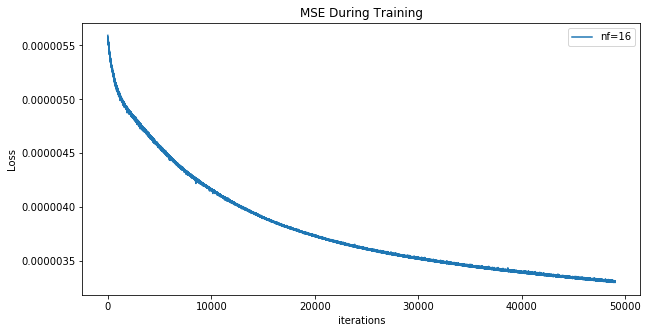

In [46]:
plt.figure(figsize=(10, 5))
plt.title("MSE During Training")
plt.plot(trainloss[1000:], label="nf=16")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
#plt.show()
plt.savefig('AE_TRAINING.png')

# Alter feature dimension

# Save Model

In [23]:
PATH = './AE_NET.pth'
torch.save(net.state_dict(), PATH)

# Testing

In [139]:
X_test, Y_test = next(iter(testloader))
X_test, Y_test = X_train, Y_train

X_test = X_test.view(-1, 1, X_test.shape[-2], X_test.shape[-1])
Y_test = Y_test.view(-1, 1, Y_test.shape[-2], Y_test.shape[-1])

if GPU:
    X_test = Variable(X_test).cuda()
    Y_pred = net(X_test)

In [140]:
Y_test.shape

torch.Size([240, 1, 64, 64])

In [141]:
Y_pred.shape

torch.Size([240, 1, 64, 64])

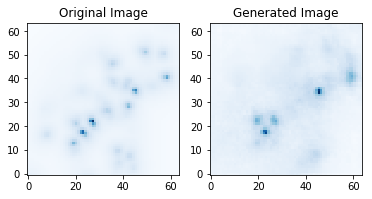

In [149]:
num = 6
fig = plt.figure()
plot = fig.add_subplot(1, 2, 1)
plot.set_title('Original Image')
imgplot = plt.imshow(Y_test[num, 0, :, :].cpu(), origin='lower', cmap='Blues')

plot = fig.add_subplot(1, 2, 2)
plot.set_title('Generated Image')
imgplot = plt.imshow(Y_pred[num, 0, :, :].cpu().detach(), origin='lower', cmap='Blues')

plt.savefig('AE_{}.png'.format(num))
plt.show()

# Encoder Weights Visualization

In [18]:
trained_weights = copy.deepcopy(net.decoder[3].weight.data)
d_weights = init_weights - trained_weights

In [19]:
net.decoder[3]

ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)

In [20]:
d_weights.shape

torch.Size([64, 32, 4, 4])

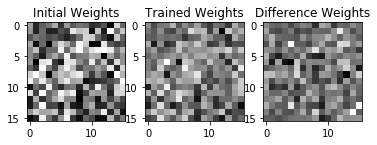

In [21]:
fig = plt.figure()
plot = fig.add_subplot(1, 3, 1)
plot.set_title('Initial Weights')
imgplot = plt.imshow(init_weights.view(-1, nf*2, nf*2).cpu()[0], cmap='gray')

plot = fig.add_subplot(1, 3, 2)
plot.set_title('Trained Weights')
imgplot = plt.imshow(trained_weights.view(-1, nf*2, nf*2).cpu()[0], cmap='gray')

plot = fig.add_subplot(1, 3, 3)
plot.set_title('Difference Weights')
imgplot = plt.imshow(d_weights.view(-1, nf*2, nf*2).cpu()[0], cmap='gray')
plt.savefig('weights.png')